## Provide list of paths for edits and run trials -> (maybe analyze results and add to CSV)

In [1]:
# General imports
import torch
import numpy as np
import os, sys
import json
from tqdm import tqdm
from datetime import datetime
import pandas as pd

In [35]:
# Local imports
sys.path.insert(0, 'src')
from utils import read_json, read_lists, informal_log, list_to_dict
from utils.model_utils import prepare_device
from parse_config import ConfigParser
# from data_loader import data_loaders
import datasets.datasets as module_data
import model.model as module_arch
from utils.knn_utils import load_and_analyze_knn, combine_results
from utils.analysis_utils import combine_results
from edit_knn import main as edit

In [36]:
# Obtain timestamp
timestamp = datetime.now().strftime(r'%m%d_%H%M%S')

In [37]:
# Define constants, paths
config_path = 'configs/copies/cinic10_imagenet_segmentation_edit_trials.json'
class_list_path = 'metadata/cinic-10/class_names.txt'
# key_image_id = 'dog-train-n02114712_211'
target_class_name = 'dog'

analyze_in_edit = True
# paths_dir = os.path.join('paths', 'edits', key_image_id)
paths_dir = os.path.join('paths', 'edits', target_class_name, '0113_120339')

key_image_paths = read_lists(os.path.join(paths_dir, 'key_images.txt'))
value_image_paths = read_lists(os.path.join(paths_dir, 'value_images.txt'))
n_trials = len(value_image_paths)
assert len(key_image_paths) == n_trials

print("First key image path: {}".format(key_image_paths[0]))
print("First value image path: {}".format(value_image_paths[0]))

First key image path: data/cinic-10-imagenet/train/dog/n02118333_7249.png
First value image path: saved/segmentations/dog/dog-train-n02118333_7249/modified_images/slic_masked_1.png


In [38]:
# Load config file
config_dict = read_json(config_path)
# Load class list and obtain target class idx
class_list = read_lists(class_list_path)
class_idx_dict = list_to_dict(class_list)
target_class_idx = class_idx_dict[target_class_name]

# Set K
K = config_dict['editor']['K']

device, device_ids = prepare_device(config_dict['n_gpu'])

In [39]:
# Load datasets
data_loader_args = dict(config_dict["data_loader"]["args"])
dataset_args = dict(config_dict["dataset_args"])

# Create validation data loader
val_image_paths = read_lists(config_dict['dataset_paths']['valid_images'])
val_labels = read_lists(config_dict['dataset_paths']['valid_labels'])
val_paths_data_loader = torch.utils.data.DataLoader(
    module_data.CINIC10Dataset(
        data_dir="",
        image_paths=val_image_paths,
        labels=val_labels,
        return_paths=True,
        **dataset_args
    ),
    **data_loader_args
)

# Create data loader for covariance matrix
covariance_image_paths = read_lists(config_dict['covariance_dataset']['images'])
covariance_labels = read_lists(config_dict['covariance_dataset']['labels'])

covariance_data_loader = torch.utils.data.DataLoader(
    module_data.CINIC10Dataset(
        data_dir="",
        image_paths=covariance_image_paths,
        labels=covariance_labels,
        **dataset_args
    ),
    **data_loader_args
)

### Create log and save paths

In [40]:
# create log path to store the paths to each trial
save_root = config_dict['trainer']['save_dir']
save_trials_path = os.path.join(save_root, config_dict['name'], timestamp, 'trial_paths.txt')
if os.path.exists(save_trials_path):
    # os.remove(save_trials_path)
    print("Path {} already exists. Aborting.".format(save_trials_path))
else:
    progress_report_path = os.path.join(save_root, config_dict['name'], timestamp, 'progress_report.txt')
    if os.path.exists(progress_report_path):
        os.remove(progress_report_path)
    print("Saving path to directories for each trial to {}".format(save_trials_path))
    print("Printing progress reports to {}".format(progress_report_path))

Saving path to directories for each trial to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/trial_paths.txt
Printing progress reports to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/progress_report.txt


### Ensure all paths for keys and values exist

In [41]:
non_existent_key_paths = []
non_existent_value_paths = []
for key_path, value_path in zip(key_image_paths, value_image_paths):
    if not os.path.exists(key_path):
        non_existent_key_paths.append(key_path)
    if not os.path.exists(value_path):
        non_existent_value_paths.append(value_path)

if len(non_existent_key_paths) > 0:
    raise ValueError("Following paths are non existent: {}".format(non_existent_key_paths))
    
if len(non_existent_value_paths) > 0:
    raise ValueError("Following paths are non existent: {}".format(non_existent_value_paths))

## Run edit for each modified image

(0113_160243) Starting Trial 1/2008...
Current run_id: 0113_160154/dog-train-n02118333_7249/slic_masked_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02118333_7249/slic_masked_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02118333_7249.png
Value images: saved/segmentations/dog/dog-train-n02118333_7249/modified_images/slic_masked_1.png
Masks: None
Prepared data for editing
Performing pre-edit metric & KNN calculations on validation set.


100%|██████████████████████████████████████████| 274/274 [07:17<00:00,  1.60s/it]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0059, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.06783458590507507 0.005938022397458553
L2 norm of weight change: 0.2369346022605896
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 28.56it/s]


Post-edit metrics: {'TP': array([6019, 5469, 5072, 3700, 4472, 3381, 5759, 4516, 5122, 4448]), 'TN': array([60659, 60975, 59849, 60042, 59607, 60934, 60747, 62438, 61135,
       61572]), 'FPs': array([2341, 2025, 3151, 2958, 3393, 2066, 2253,  562, 1865, 1428]), 'FNs': array([ 981, 1531, 1928, 3300, 2528, 3619, 1241, 2484, 1878, 2552]), 'accuracy': 0.6851142857142857, 'per_class_accuracy': array([0.95254286, 0.9492    , 0.92744286, 0.9106    , 0.91541429,
       0.91878571, 0.95008571, 0.95648571, 0.94652857, 0.94314286]), 'per_class_accuracy_mean': 0.9370228571428573, 'precision': array([0.71997608, 0.72978383, 0.61680652, 0.55572244, 0.56859504,
       0.62070865, 0.7187968 , 0.88932651, 0.73307571, 0.75697754]), 'precision_mean': 0.6909769108440533, 'recall': array([0.85985714, 0.78128571, 0.72457143, 0.52857143, 0.63885714,
       0.483     , 0.82271429, 0.64514286, 0.73171429, 0.63542857]), 'recall_mean': 0.6851142857142858, 'f1': array([0.78372396, 0.7546571 , 0.66636011, 0.54180

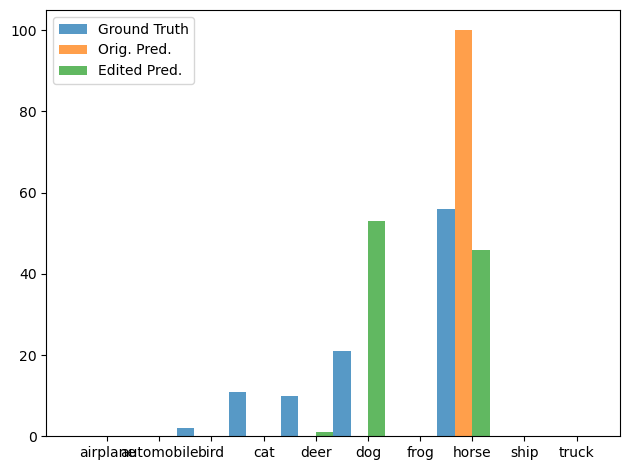

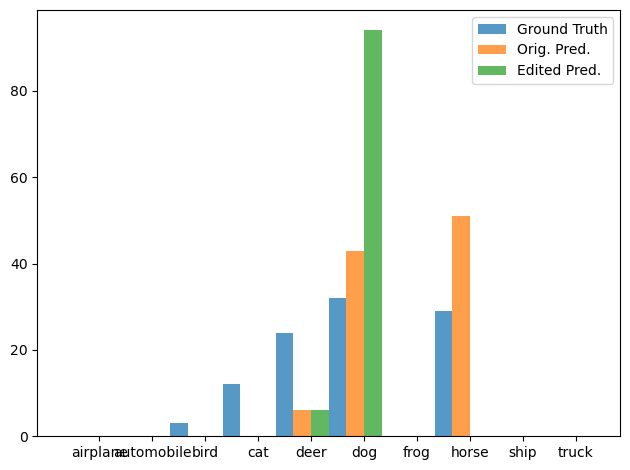

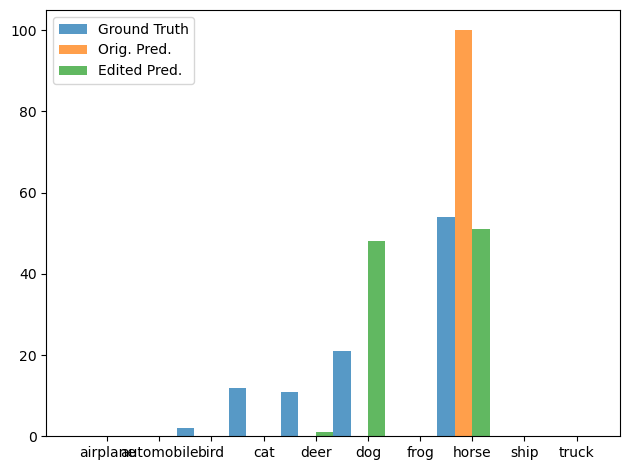

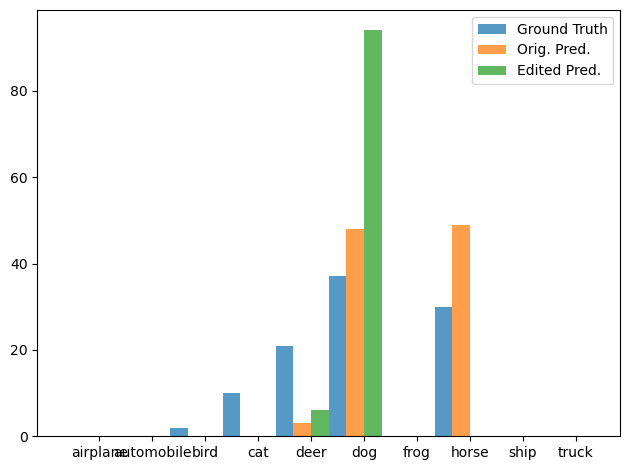

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02118333_7249/slic_masked_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02118333_7249/slic_masked_1/models
Finished trial 1/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02118333_7249/slic_masked_1
(0113_161118) Starting Trial 2/2008...
Current run_id: 0113_160154/dog-train-n02112706_413/quickshift_masked_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112706_413/quickshift_masked_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02112706_413.png
Value images: saved/segmentations/dog/dog-train-n02112706_413/modi

100%|██████████████████████████████████████████| 274/274 [00:10<00:00, 26.81it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0154, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.13256171345710754 0.015396649949252605
L2 norm of weight change: 0.34892717003822327
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:18<00:00, 14.66it/s]


Post-edit metrics: {'TP': array([6122, 5452, 5410, 4294, 2742, 3348, 5623, 5095, 4666, 4634]), 'TN': array([60217, 60974, 58475, 58373, 62396, 60922, 61022, 61884, 61824,
       61299]), 'FPs': array([2783, 2026, 4525, 4627,  604, 2078, 1978, 1116, 1176, 1701]), 'FNs': array([ 878, 1548, 1590, 2706, 4258, 3652, 1377, 1905, 2334, 2366]), 'accuracy': 0.6769428571428572, 'per_class_accuracy': array([0.9477    , 0.94894286, 0.91264286, 0.89524286, 0.93054286,
       0.91814286, 0.95207143, 0.95684286, 0.94985714, 0.9419    ]), 'per_class_accuracy_mean': 0.9353885714285715, 'precision': array([0.68747894, 0.72907194, 0.54453951, 0.48133617, 0.81948595,
       0.61702912, 0.73977108, 0.82031879, 0.79869908, 0.73149171]), 'precision_mean': 0.6969222301449255, 'recall': array([0.87457143, 0.77885714, 0.77285714, 0.61342857, 0.39171429,
       0.47828571, 0.80328571, 0.72785714, 0.66657143, 0.662     ]), 'recall_mean': 0.6769428571428572, 'f1': array([0.76982081, 0.7531427 , 0.63891349, 0.53941

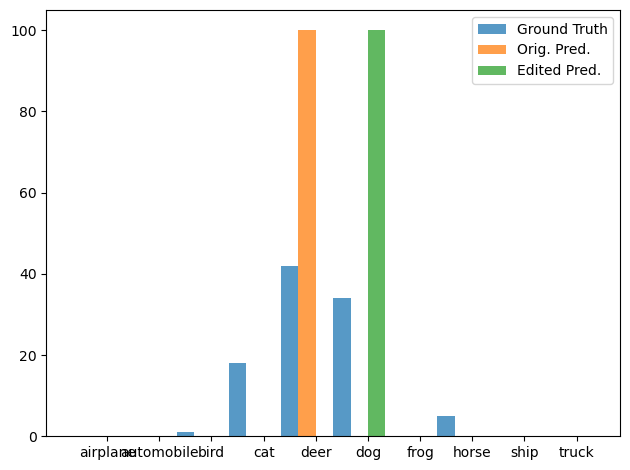

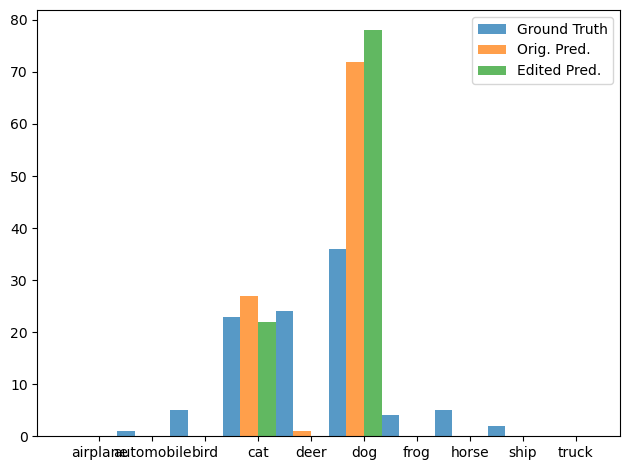

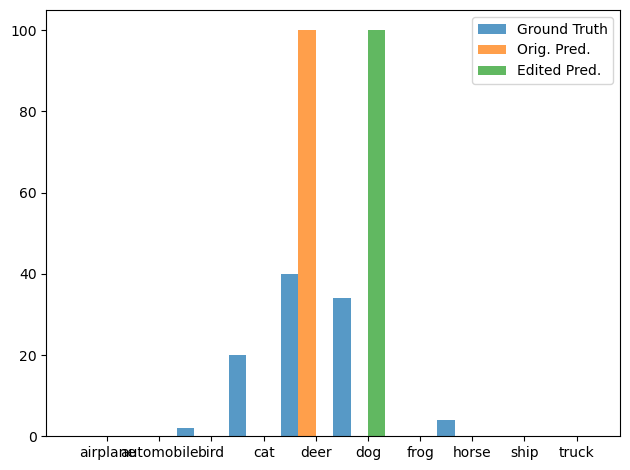

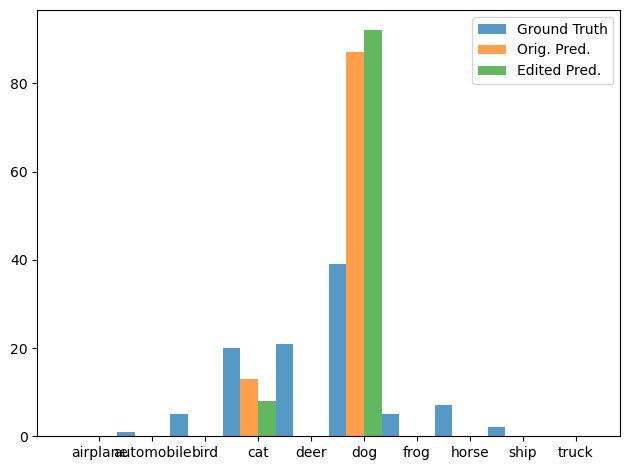

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112706_413/quickshift_masked_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112706_413/quickshift_masked_0/models
Finished trial 2/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112706_413/quickshift_masked_0
(0113_161256) Starting Trial 3/2008...
Current run_id: 0113_160154/dog-train-n02112706_413/slic_masked_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112706_413/slic_masked_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02112706_413.png
Value images: saved/segmentations/dog/dog-train-n02112706_413/m

100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 28.04it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.1898515522480011 0.003862569108605385
L2 norm of weight change: 0.6270527839660645
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:11<00:00, 24.64it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:165: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:202: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([5971, 5672, 5147, 3669,    0, 4893, 5180, 4672, 4557, 4360]), 'TN': array([60874, 60455, 59768, 60090, 63000, 51971, 62089, 62300, 61907,
       61667]), 'FPs': array([ 2126,  2545,  3232,  2910,     0, 11029,   911,   700,  1093,
        1333]), 'FNs': array([1029, 1328, 1853, 3331, 7000, 2107, 1820, 2328, 2443, 2640]), 'accuracy': 0.6303, 'per_class_accuracy': array([0.95492857, 0.94467143, 0.92735714, 0.91084286, 0.9       ,
       0.81234286, 0.96098571, 0.95674286, 0.94948571, 0.94324286]), 'per_class_accuracy_mean': 0.92606, 'precision': array([0.73743362, 0.69027626, 0.61427378, 0.55768354, 0.        ,
       0.30731064, 0.85043507, 0.86969471, 0.80654867, 0.7658528 ]), 'precision_mean': 0.6199509087230727, 'recall': array([0.853     , 0.81028571, 0.73528571, 0.52414286, 0.        ,
       0.699     , 0.74      , 0.66742857, 0.651     , 0.62285714]), 'recall_mean': 0.6302999999999999, 'f1': array([0.79101808, 0.74548203, 0.66935431, 0.54039325, 0

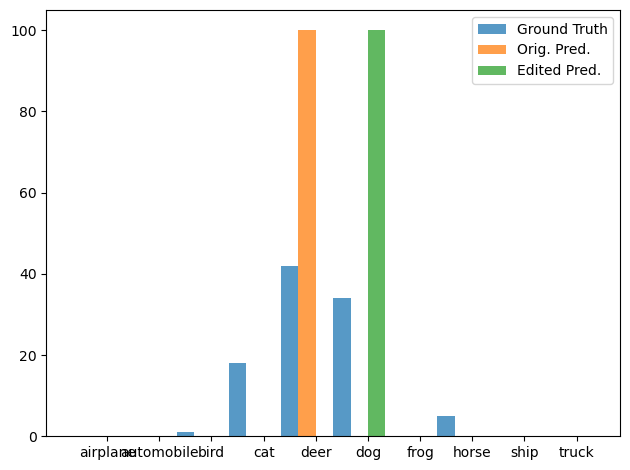

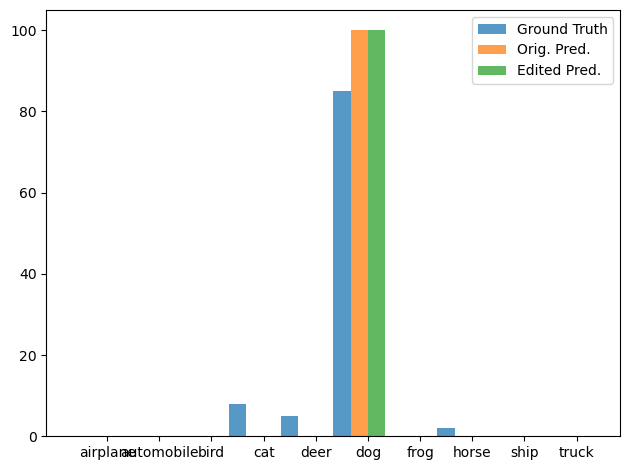

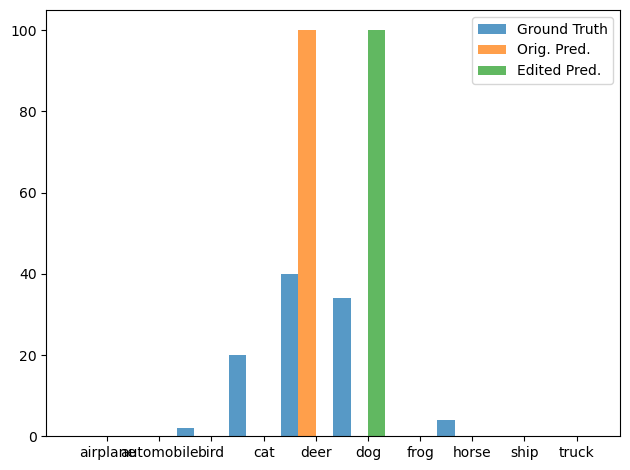

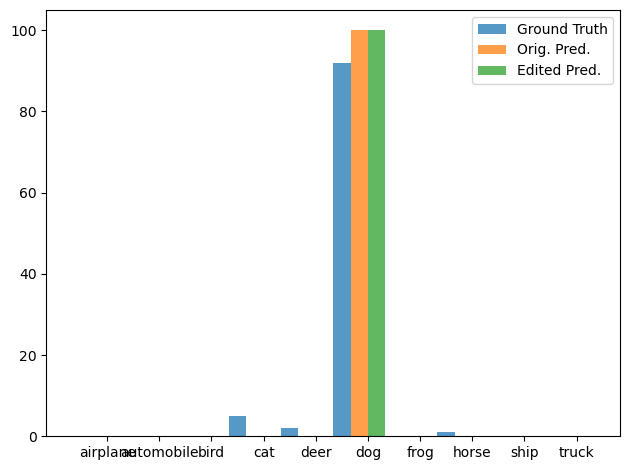

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112706_413/slic_masked_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112706_413/slic_masked_0/models
Finished trial 3/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112706_413/slic_masked_0
(0113_161427) Starting Trial 4/2008...
Current run_id: 0113_160154/dog-train-n02112706_413/watershed_masked_2
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112706_413/watershed_masked_2
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02112706_413.png
Value images: saved/segmentations/dog/dog-train-n02112706_413/modified_

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 31.82it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0091, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.14813995361328125 0.009126828983426094
L2 norm of weight change: 0.41893187165260315
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:12<00:00, 21.87it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:165: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:202: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6055, 5545, 5380, 4019,    0, 4183, 5453, 5026, 4694, 4512]), 'TN': array([60509, 60790, 58817, 59307, 63000, 55646, 61517, 61982, 61810,
       61489]), 'FPs': array([2491, 2210, 4183, 3693,    0, 7354, 1483, 1018, 1190, 1511]), 'FNs': array([ 945, 1455, 1620, 2981, 7000, 2817, 1547, 1974, 2306, 2488]), 'accuracy': 0.6409571428571429, 'per_class_accuracy': array([0.95091429, 0.94764286, 0.9171    , 0.90465714, 0.9       ,
       0.8547    , 0.95671429, 0.95725714, 0.95005714, 0.94287143]), 'per_class_accuracy_mean': 0.9281914285714287, 'precision': array([0.70851861, 0.71502257, 0.56258496, 0.52113589, 0.        ,
       0.36257259, 0.786188  , 0.8315685 , 0.79775663, 0.74912834]), 'precision_mean': 0.6034476090603647, 'recall': array([0.865     , 0.79214286, 0.76857143, 0.57414286, 0.        ,
       0.59757143, 0.779     , 0.718     , 0.67057143, 0.64457143]), 'recall_mean': 0.6409571428571429, 'f1': array([0.77897852, 0.75160962, 0.64964077, 0.54635

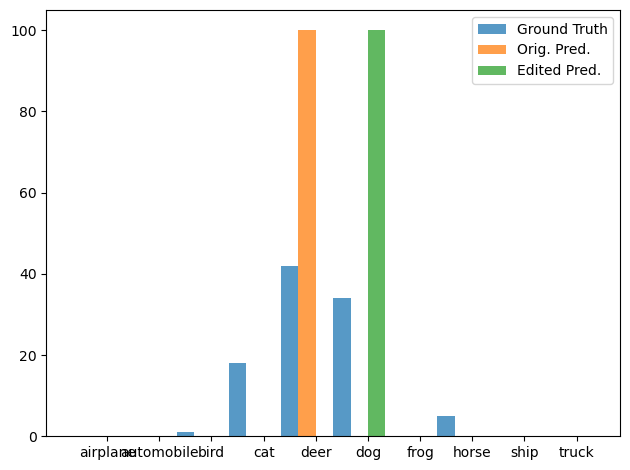

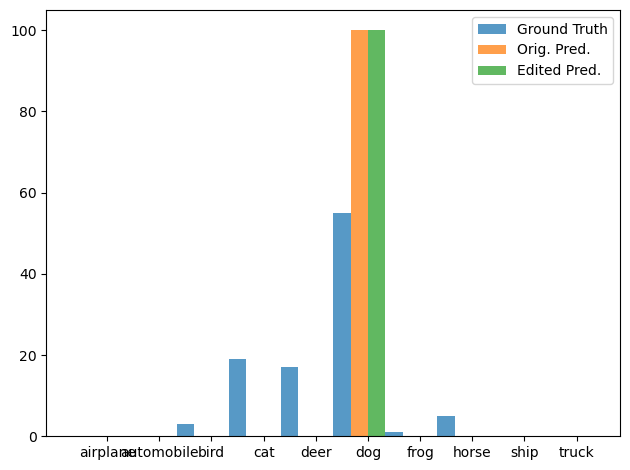

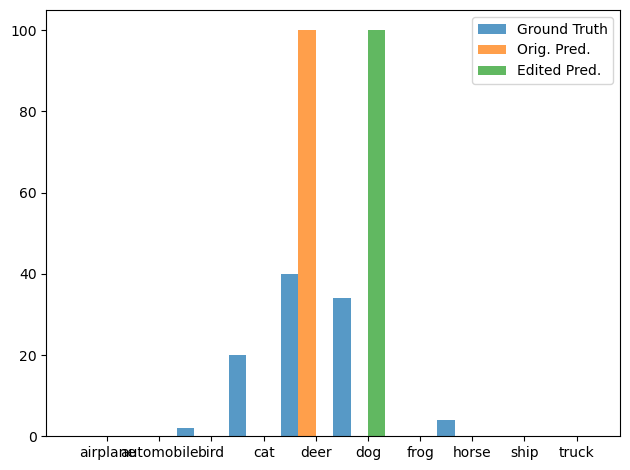

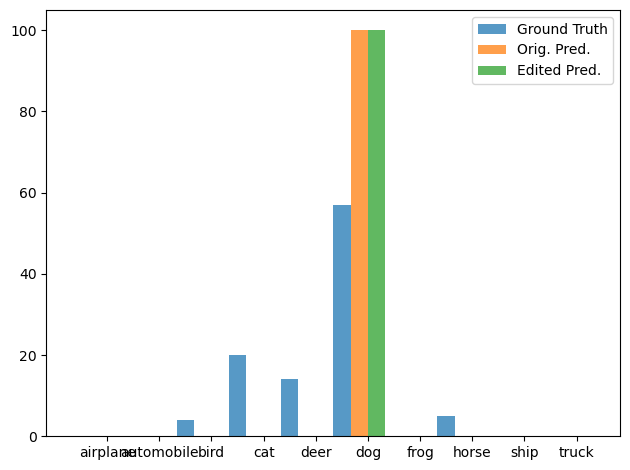

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112706_413/watershed_masked_2/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112706_413/watershed_masked_2/models
Finished trial 4/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112706_413/watershed_masked_2
(0113_161554) Starting Trial 5/2008...
Current run_id: 0113_160154/dog-train-n02115096_13735/felzenszwalb_masked_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02115096_13735/felzenszwalb_masked_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02115096_13735.png
Value images: saved/segmentations/dog/dog-tr

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 33.11it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0113, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.14329561591148376 0.011321231722831726
L2 norm of weight change: 0.3543589115142822
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 28.74it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:165: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:202: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6060, 5498, 5292, 4088,    0, 4091, 5514, 5069, 4786, 4567]), 'TN': array([60468, 60898, 59227, 59088, 63000, 55808, 61436, 61924, 61698,
       61418]), 'FPs': array([2532, 2102, 3773, 3912,    0, 7192, 1564, 1076, 1302, 1582]), 'FNs': array([ 940, 1502, 1708, 2912, 7000, 2909, 1486, 1931, 2214, 2433]), 'accuracy': 0.6423571428571428, 'per_class_accuracy': array([0.9504    , 0.94851429, 0.9217    , 0.90251429, 0.9       ,
       0.8557    , 0.95642857, 0.95704286, 0.94977143, 0.94264286]), 'per_class_accuracy_mean': 0.9284714285714285, 'precision': array([0.70530726, 0.72342105, 0.58378378, 0.511     , 0.        ,
       0.36258087, 0.77903363, 0.82489829, 0.78613666, 0.74272239]), 'precision_mean': 0.6018883945649526, 'recall': array([0.86571429, 0.78542857, 0.756     , 0.584     , 0.        ,
       0.58442857, 0.78771429, 0.72414286, 0.68371429, 0.65242857]), 'recall_mean': 0.6423571428571428, 'f1': array([0.7773217 , 0.75315068, 0.65882353, 0.54506

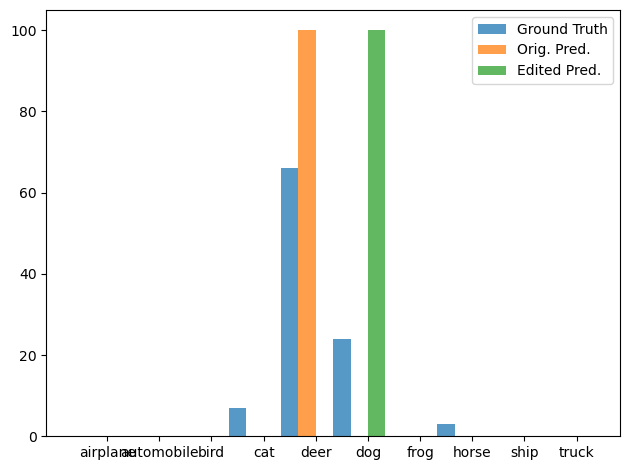

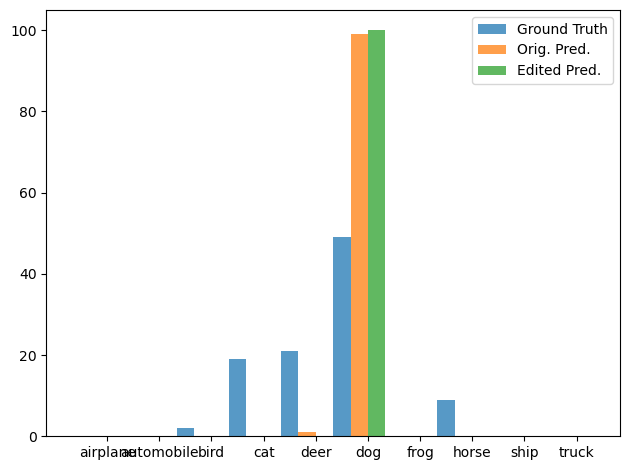

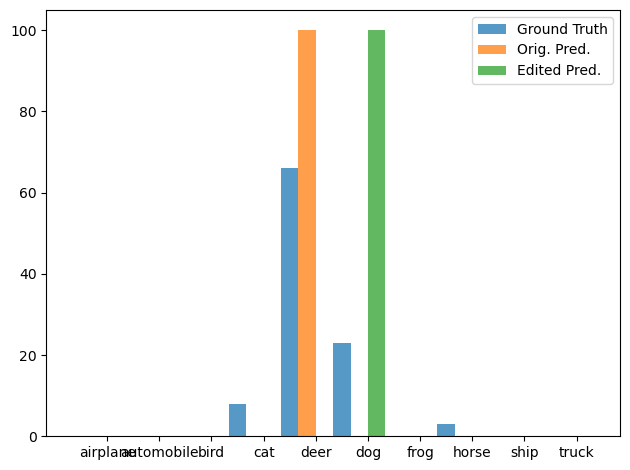

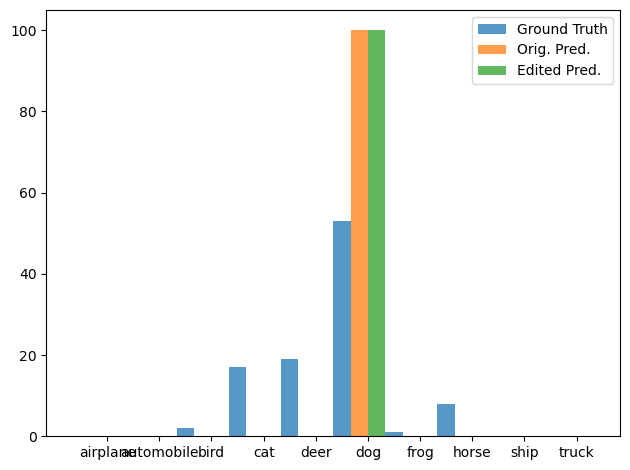

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02115096_13735/felzenszwalb_masked_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02115096_13735/felzenszwalb_masked_0/models
Finished trial 5/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02115096_13735/felzenszwalb_masked_0
(0113_161718) Starting Trial 6/2008...
Current run_id: 0113_160154/dog-train-n02115096_13735/felzenszwalb_masked_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02115096_13735/felzenszwalb_masked_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02115096_13735.png
Value images: saved/segmentat

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 34.01it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0284, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.1777307391166687 0.028446832671761513
L2 norm of weight change: 0.4700171649456024
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:12<00:00, 21.45it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:165: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:202: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6099, 5564, 5386, 3895,    0, 4124, 5407, 5313, 4575, 4551]), 'TN': array([60407, 60692, 58893, 59696, 63000, 55801, 61663, 61426, 61940,
       61396]), 'FPs': array([2593, 2308, 4107, 3304,    0, 7199, 1337, 1574, 1060, 1604]), 'FNs': array([ 901, 1436, 1614, 3105, 7000, 2876, 1593, 1687, 2425, 2449]), 'accuracy': 0.6416285714285714, 'per_class_accuracy': array([0.95008571, 0.94651429, 0.91827143, 0.90844286, 0.9       ,
       0.85607143, 0.95814286, 0.95341429, 0.95021429, 0.9421    ]), 'per_class_accuracy_mean': 0.9283257142857142, 'precision': array([0.70167971, 0.70680894, 0.56736543, 0.54104737, 0.        ,
       0.36421443, 0.8017497 , 0.77145346, 0.81188997, 0.73939886]), 'precision_mean': 0.600560787679741, 'recall': array([0.87128571, 0.79485714, 0.76942857, 0.55642857, 0.        ,
       0.58914286, 0.77242857, 0.759     , 0.65357143, 0.65014286]), 'recall_mean': 0.6416285714285714, 'f1': array([0.77733877, 0.74825175, 0.65312557, 0.548630

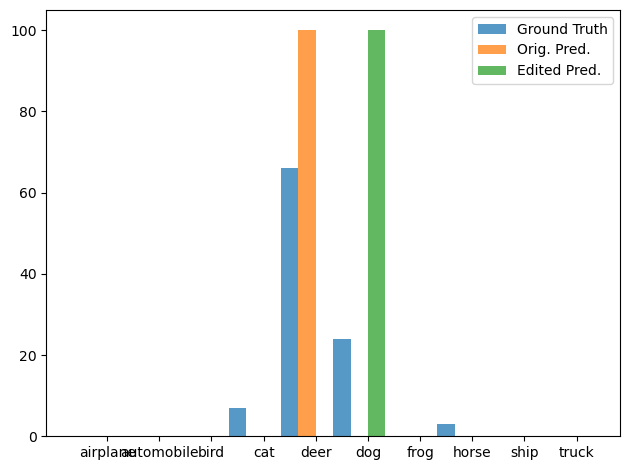

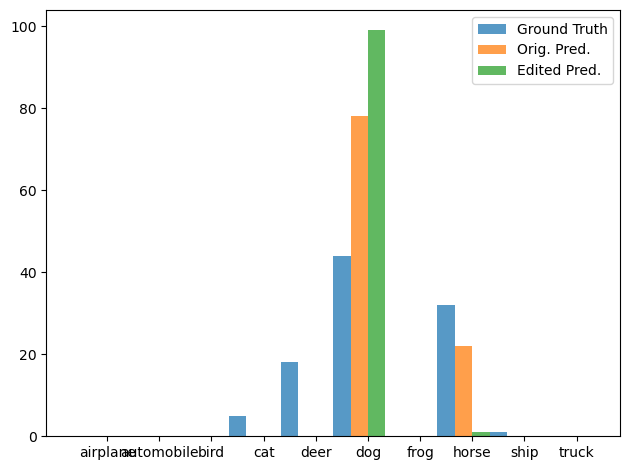

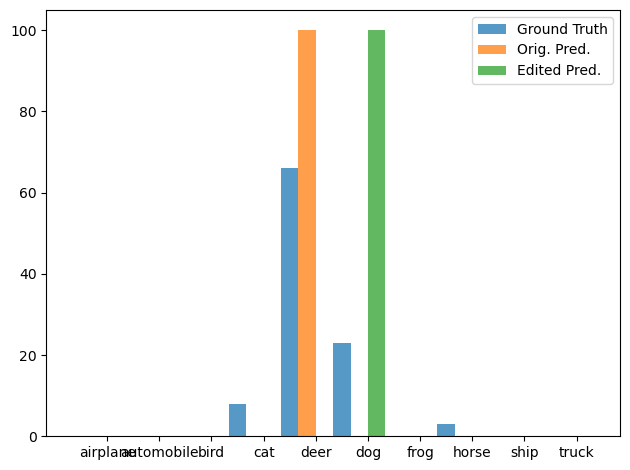

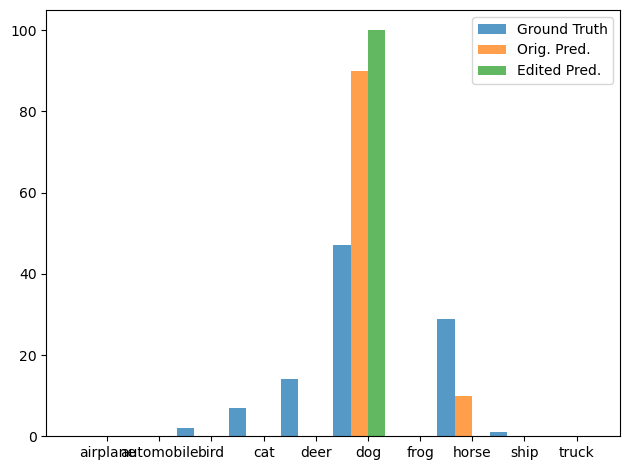

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02115096_13735/felzenszwalb_masked_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02115096_13735/felzenszwalb_masked_1/models
Finished trial 6/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02115096_13735/felzenszwalb_masked_1
(0113_161844) Starting Trial 7/2008...
Current run_id: 0113_160154/dog-train-n02115096_13735/quickshift_masked_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02115096_13735/quickshift_masked_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02115096_13735.png
Value images: saved/segmentations

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 32.44it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0205, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.158466175198555 0.020535236224532127
L2 norm of weight change: 0.37811601161956787
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:10<00:00, 27.26it/s]


Post-edit metrics: {'TP': array([6102, 5519, 5486, 3921,    4, 3932, 5548, 5131, 4717, 4533]), 'TN': array([60283, 60816, 58166, 59598, 63000, 56797, 61270, 61802, 61748,
       61413]), 'FPs': array([2717, 2184, 4834, 3402,    0, 6203, 1730, 1198, 1252, 1587]), 'FNs': array([ 898, 1481, 1514, 3079, 6996, 3068, 1452, 1869, 2283, 2467]), 'accuracy': 0.6413285714285715, 'per_class_accuracy': array([0.94835714, 0.94764286, 0.90931429, 0.90741429, 0.90005714,
       0.86755714, 0.95454286, 0.95618571, 0.9495    , 0.94208571]), 'per_class_accuracy_mean': 0.9282657142857141, 'precision': array([0.69191518, 0.7164741 , 0.53158915, 0.5354363 , 1.        ,
       0.38796251, 0.76229733, 0.81071259, 0.79024962, 0.74068627]), 'precision_mean': 0.6967323059001723, 'recall': array([8.71714286e-01, 7.88428571e-01, 7.83714286e-01, 5.60142857e-01,
       5.71428571e-04, 5.61714286e-01, 7.92571429e-01, 7.33000000e-01,
       6.73857143e-01, 6.47571429e-01]), 'recall_mean': 0.6413285714285714, 'f1': arr

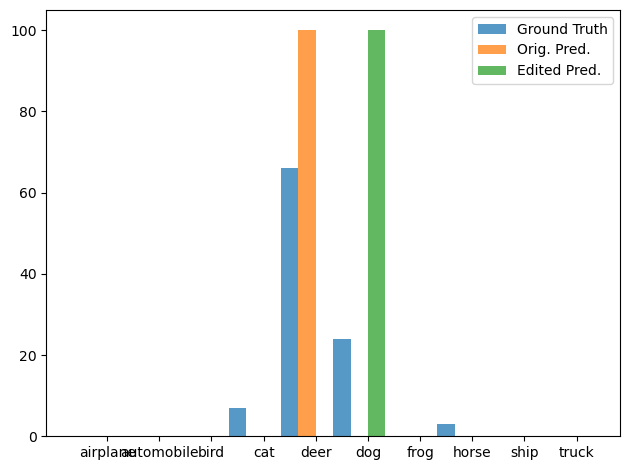

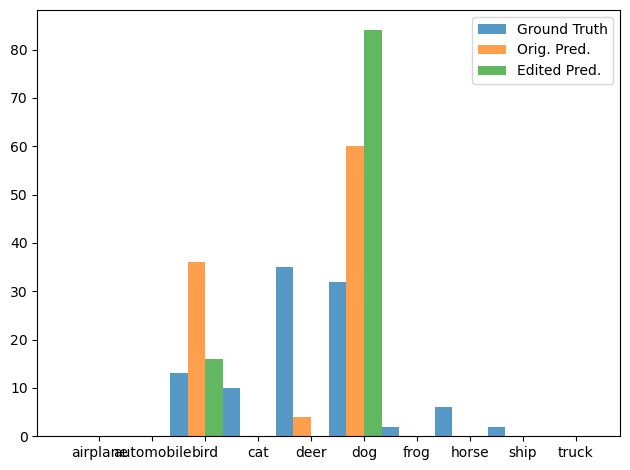

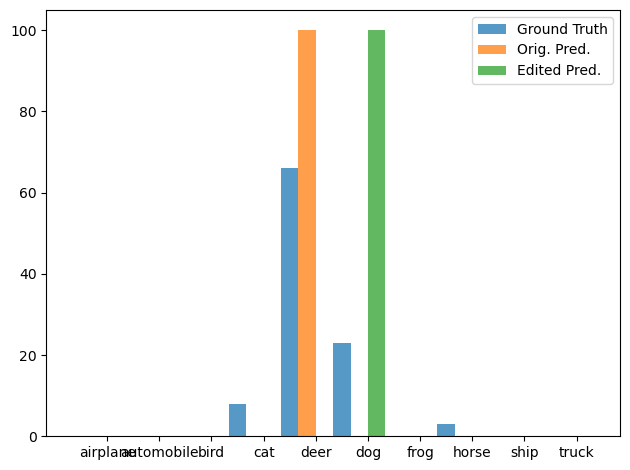

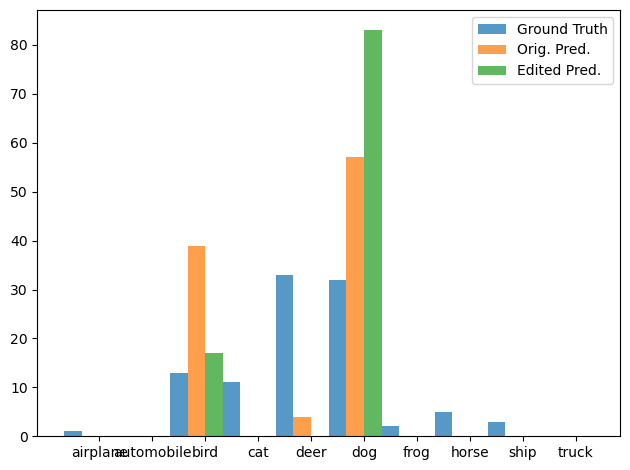

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02115096_13735/quickshift_masked_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02115096_13735/quickshift_masked_0/models
Finished trial 7/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02115096_13735/quickshift_masked_0
(0113_162008) Starting Trial 8/2008...
Current run_id: 0113_160154/dog-train-n02115096_13735/watershed_masked_3
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02115096_13735/watershed_masked_3
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02115096_13735.png
Value images: saved/segmentations/dog/dog

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 34.21it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0100, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.16621914505958557 0.010046065784990788
L2 norm of weight change: 0.43665406107902527
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 30.03it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:165: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:202: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6031, 5577, 5180, 3855,    0, 4508, 5427, 4922, 4802, 4458]), 'TN': array([60629, 60716, 59652, 59756, 63000, 54021, 61666, 62080, 61681,
       61559]), 'FPs': array([2371, 2284, 3348, 3244,    0, 8979, 1334,  920, 1319, 1441]), 'FNs': array([ 969, 1423, 1820, 3145, 7000, 2492, 1573, 2078, 2198, 2542]), 'accuracy': 0.6394285714285715, 'per_class_accuracy': array([0.95228571, 0.94704286, 0.92617143, 0.90872857, 0.9       ,
       0.83612857, 0.95847143, 0.95717143, 0.94975714, 0.9431    ]), 'per_class_accuracy_mean': 0.9278857142857142, 'precision': array([0.71780528, 0.70945172, 0.60741088, 0.54303423, 0.        ,
       0.33424779, 0.80269191, 0.84251969, 0.78451233, 0.75572131]), 'precision_mean': 0.6097395152104369, 'recall': array([0.86157143, 0.79671429, 0.74      , 0.55071429, 0.        ,
       0.644     , 0.77528571, 0.70314286, 0.686     , 0.63685714]), 'recall_mean': 0.6394285714285715, 'f1': array([0.78314505, 0.75055514, 0.66718187, 0.54684

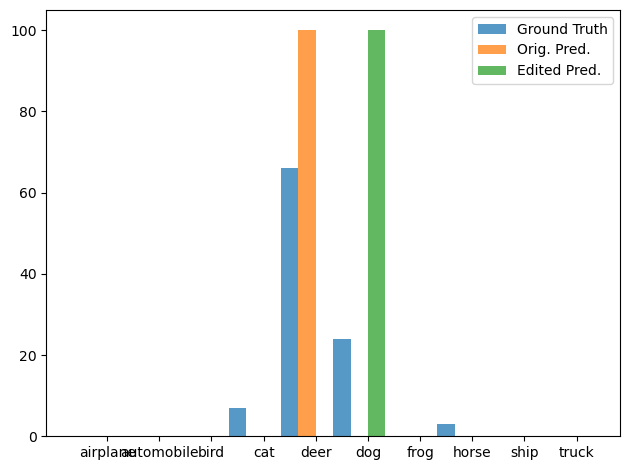

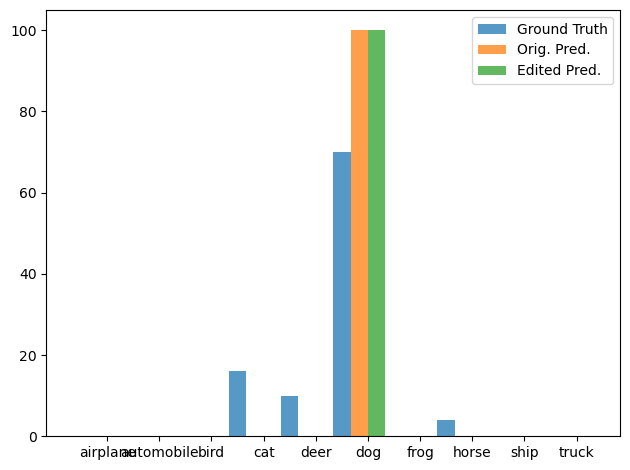

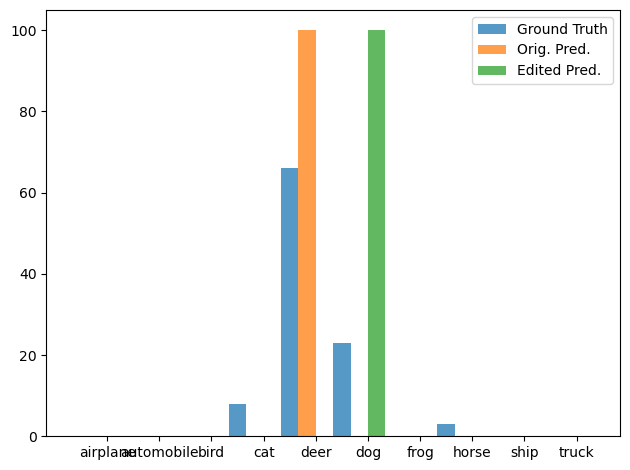

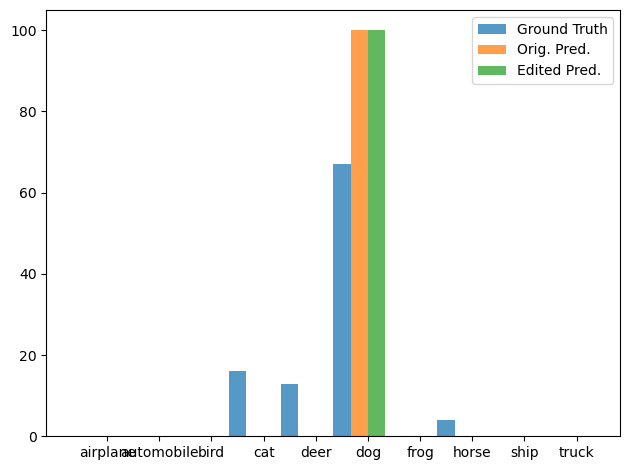

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02115096_13735/watershed_masked_3/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02115096_13735/watershed_masked_3/models
Finished trial 8/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02115096_13735/watershed_masked_3
(0113_162135) Starting Trial 9/2008...
Current run_id: 0113_160154/dog-train-n02110806_2904/felzenszwalb_masked_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02110806_2904/felzenszwalb_masked_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02110806_2904.png
Value images: saved/segmentations/dog/dog

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 34.19it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0067, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.11285263299942017 0.0066927094012498856
L2 norm of weight change: 0.4513884484767914
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 30.24it/s]


Post-edit metrics: {'TP': array([5912, 5826, 5126,    5, 3710, 5216, 5442, 5045, 4831, 4094]), 'TN': array([61058, 59848, 59878, 62993, 61303, 53037, 61649, 61890, 61608,
       61943]), 'FPs': array([1942, 3152, 3122,    7, 1697, 9963, 1351, 1110, 1392, 1057]), 'FNs': array([1088, 1174, 1874, 6995, 3290, 1784, 1558, 1955, 2169, 2906]), 'accuracy': 0.6458142857142857, 'per_class_accuracy': array([0.95671429, 0.9382    , 0.92862857, 0.89997143, 0.92875714,
       0.83218571, 0.95844286, 0.95621429, 0.94912857, 0.94338571]), 'per_class_accuracy_mean': 0.9291628571428572, 'precision': array([0.75273746, 0.64891958, 0.621484  , 0.41666667, 0.68614759,
       0.34363265, 0.8011188 , 0.81965881, 0.77631368, 0.79479713]), 'precision_mean': 0.6661476354023098, 'recall': array([8.44571429e-01, 8.32285714e-01, 7.32285714e-01, 7.14285714e-04,
       5.30000000e-01, 7.45142857e-01, 7.77428571e-01, 7.20714286e-01,
       6.90142857e-01, 5.84857143e-01]), 'recall_mean': 0.6458142857142857, 'f1': arr

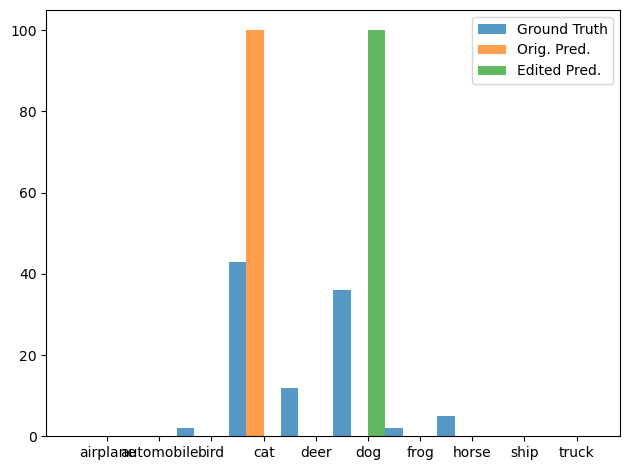

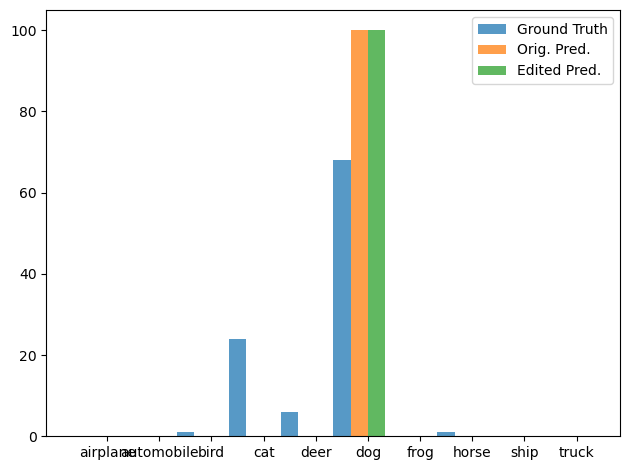

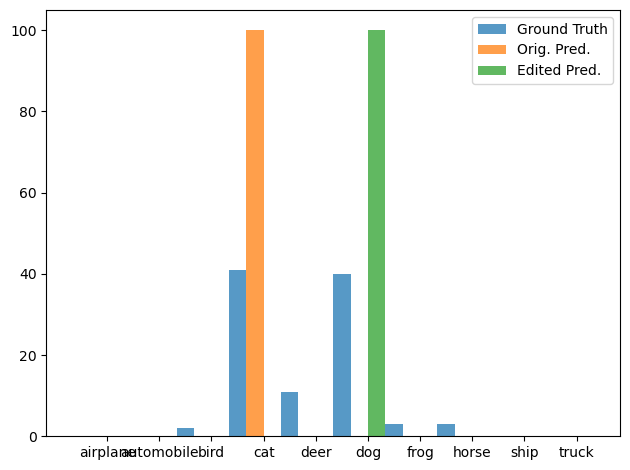

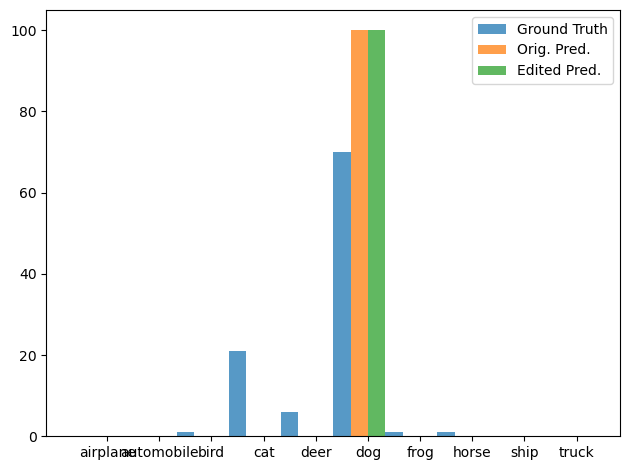

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02110806_2904/felzenszwalb_masked_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02110806_2904/felzenszwalb_masked_1/models
Finished trial 9/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02110806_2904/felzenszwalb_masked_1
(0113_162259) Starting Trial 10/2008...
Current run_id: 0113_160154/dog-train-n02110806_2904/quickshift_masked_2
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02110806_2904/quickshift_masked_2
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02110806_2904.png
Value images: saved/segmentations/dog/

100%|██████████████████████████████████████████| 274/274 [00:07<00:00, 34.27it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0068, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.09714844077825546 0.006795305293053389
L2 norm of weight change: 0.3788413405418396
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 30.49it/s]


Post-edit metrics: {'TP': array([5985, 5729, 5216, 1404, 3883, 4710, 5486, 5403, 4738, 4330]), 'TN': array([60841, 60234, 59568, 62703, 60951, 56460, 61531, 61156, 61750,
       61690]), 'FPs': array([2159, 2766, 3432,  297, 2049, 6540, 1469, 1844, 1250, 1310]), 'FNs': array([1015, 1271, 1784, 5596, 3117, 2290, 1514, 1597, 2262, 2670]), 'accuracy': 0.6697714285714286, 'per_class_accuracy': array([0.95465714, 0.94232857, 0.92548571, 0.91581429, 0.9262    ,
       0.87385714, 0.95738571, 0.95084286, 0.94982857, 0.94314286]), 'per_class_accuracy_mean': 0.9339542857142857, 'precision': array([0.73489686, 0.6743967 , 0.60314524, 0.82539683, 0.6545853 ,
       0.41866667, 0.78878505, 0.74554988, 0.79124916, 0.7677305 ]), 'precision_mean': 0.7004402179438263, 'recall': array([0.855     , 0.81842857, 0.74514286, 0.20057143, 0.55471429,
       0.67285714, 0.78371429, 0.77185714, 0.67685714, 0.61857143]), 'recall_mean': 0.6697714285714286, 'f1': array([0.79041204, 0.73946434, 0.66666667, 0.32272

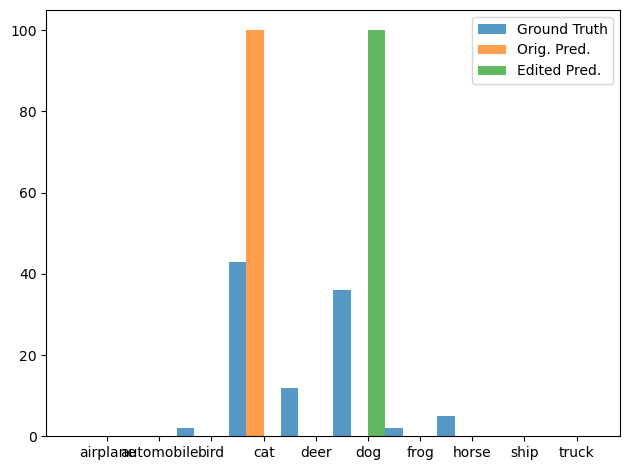

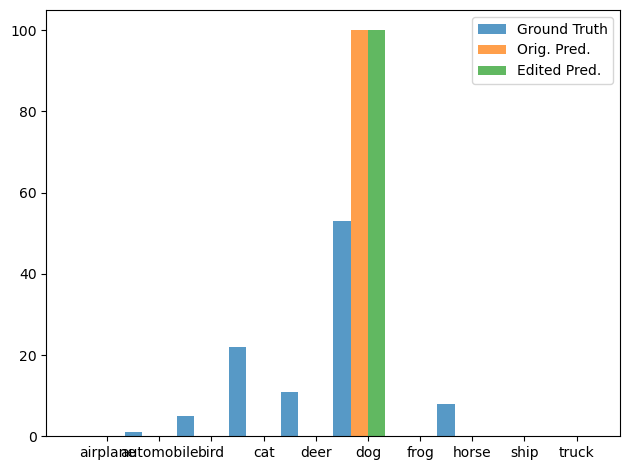

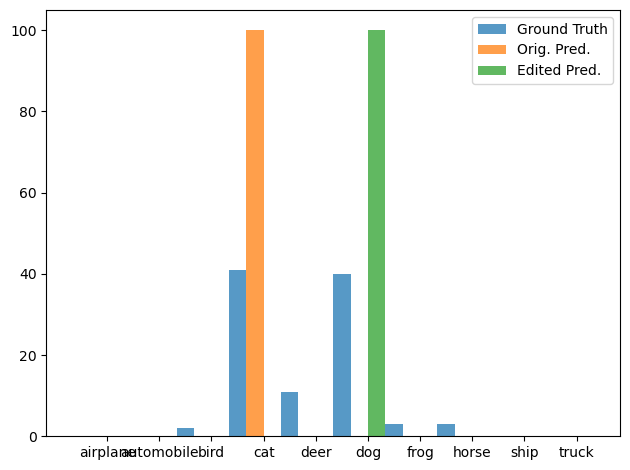

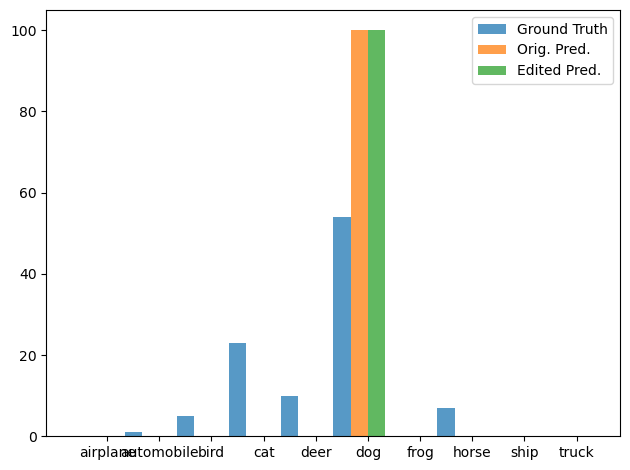

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02110806_2904/quickshift_masked_2/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02110806_2904/quickshift_masked_2/models
Finished trial 10/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02110806_2904/quickshift_masked_2
(0113_162425) Starting Trial 11/2008...
Current run_id: 0113_160154/dog-train-n02110806_2904/slic_masked_3
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02110806_2904/slic_masked_3
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02110806_2904.png
Value images: saved/segmentations/dog/dog-train-n021108

100%|██████████████████████████████████████████| 274/274 [00:07<00:00, 34.27it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0088, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.118930384516716 0.008786763995885849
L2 norm of weight change: 0.4920872747898102
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 29.05it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:165: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:202: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([5904, 5904, 5386,    0, 4032, 4816, 5424, 5099, 4849, 3877]), 'TN': array([61046, 59665, 58749, 63000, 60646, 55009, 61601, 61842, 61563,
       62170]), 'FPs': array([1954, 3335, 4251,    0, 2354, 7991, 1399, 1158, 1437,  830]), 'FNs': array([1096, 1096, 1614, 7000, 2968, 2184, 1576, 1901, 2151, 3123]), 'accuracy': 0.6470142857142858, 'per_class_accuracy': array([0.95642857, 0.9367    , 0.91621429, 0.9       , 0.92397143,
       0.85464286, 0.9575    , 0.9563    , 0.94874286, 0.94352857]), 'per_class_accuracy_mean': 0.9294028571428571, 'precision': array([0.75133622, 0.6390302 , 0.55888762, 0.        , 0.63138115,
       0.37604435, 0.79495823, 0.81492728, 0.77139675, 0.82366688]), 'precision_mean': 0.6161628678344245, 'recall': array([0.84342857, 0.84342857, 0.76942857, 0.        , 0.576     ,
       0.688     , 0.77485714, 0.72842857, 0.69271429, 0.55385714]), 'recall_mean': 0.6470142857142858, 'f1': array([0.79472338, 0.72713837, 0.6474725 , 0.     

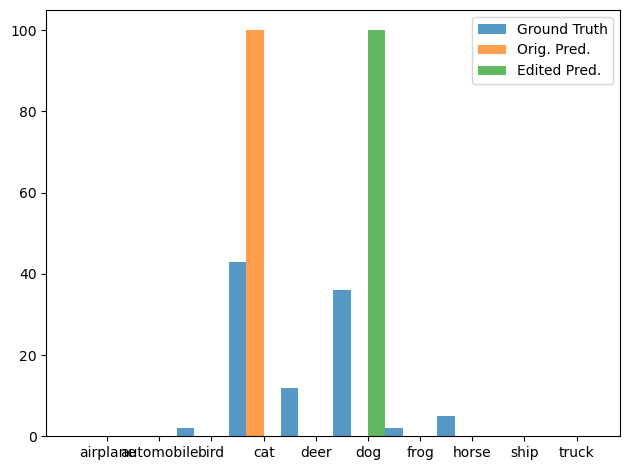

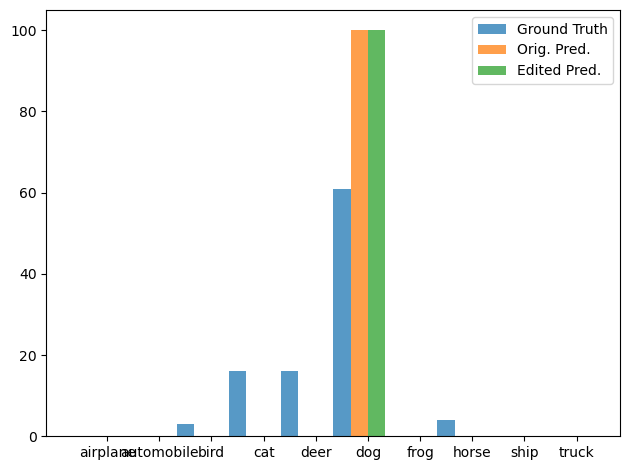

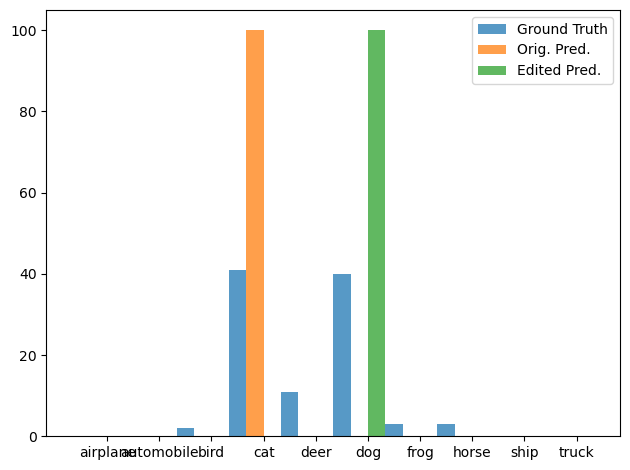

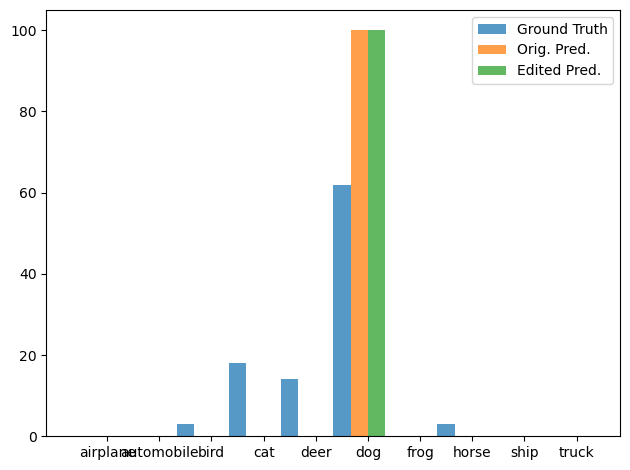

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02110806_2904/slic_masked_3/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02110806_2904/slic_masked_3/models
Finished trial 11/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02110806_2904/slic_masked_3
(0113_162551) Starting Trial 12/2008...
Current run_id: 0113_160154/dog-train-n02111626_5132/felzenszwalb_gaussian_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_gaussian_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111626_5132.png
Value images: saved/segmentations/dog/dog-train-n0211

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 33.73it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.08301715552806854 0.004099863115698099
L2 norm of weight change: 0.32286378741264343
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 29.89it/s]


Post-edit metrics: {'TP': array([6008, 5663, 5253, 2550, 4295, 4132, 5636, 5142, 4920, 4340]), 'TN': array([60722, 60556, 59293, 61923, 60054, 59348, 61118, 61774, 61468,
       61683]), 'FPs': array([2278, 2444, 3707, 1077, 2946, 3652, 1882, 1226, 1532, 1317]), 'FNs': array([ 992, 1337, 1747, 4450, 2705, 2868, 1364, 1858, 2080, 2660]), 'accuracy': 0.6848428571428572, 'per_class_accuracy': array([0.95328571, 0.94598571, 0.92208571, 0.92104286, 0.91927143,
       0.90685714, 0.95362857, 0.95594286, 0.9484    , 0.94318571]), 'per_class_accuracy_mean': 0.9369685714285714, 'precision': array([0.72507845, 0.69853213, 0.58627232, 0.70306038, 0.59315012,
       0.53083248, 0.74966746, 0.80747487, 0.76255425, 0.76719109]), 'precision_mean': 0.6923813551019127, 'recall': array([0.85828571, 0.809     , 0.75042857, 0.36428571, 0.61357143,
       0.59028571, 0.80514286, 0.73457143, 0.70285714, 0.62      ]), 'recall_mean': 0.6848428571428571, 'f1': array([0.78607876, 0.74971867, 0.65827068, 0.47990

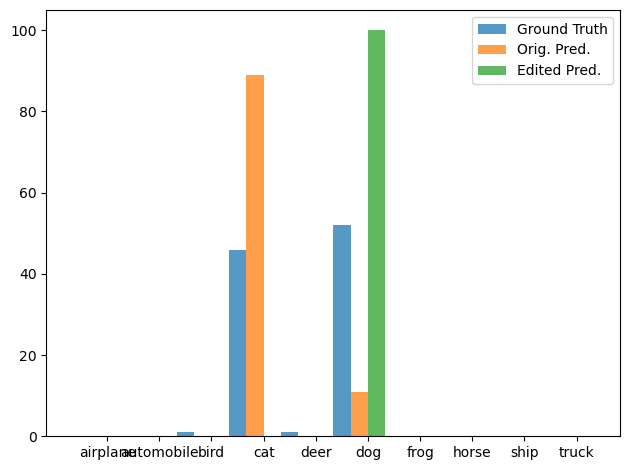

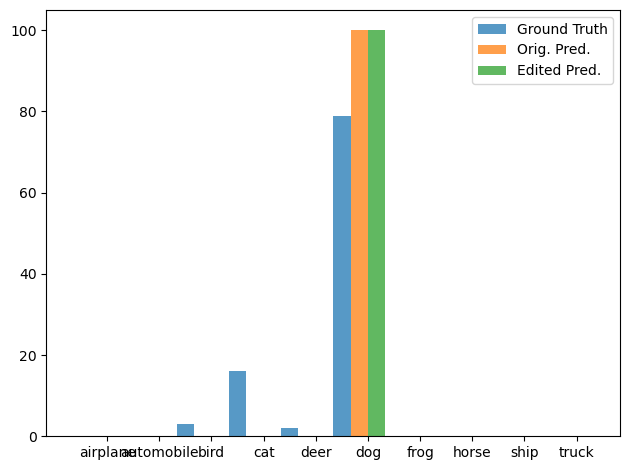

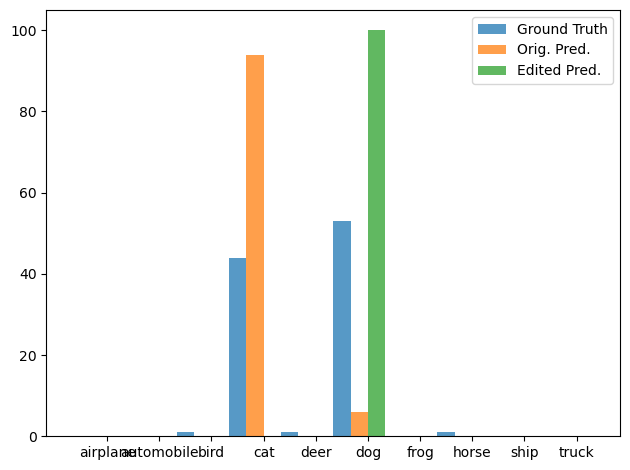

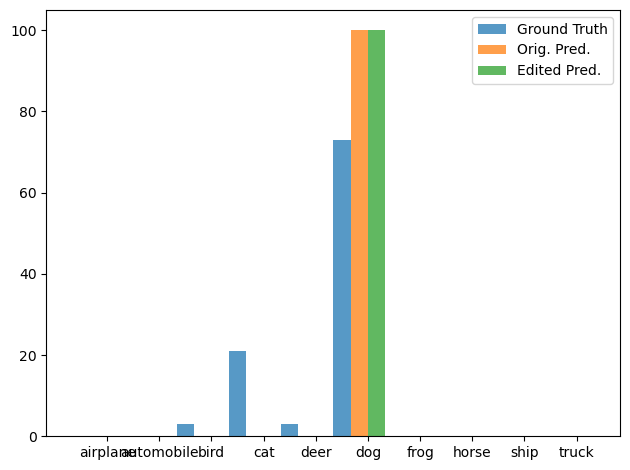

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_gaussian_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_gaussian_0/models
Finished trial 12/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_gaussian_0
(0113_162713) Starting Trial 13/2008...
Current run_id: 0113_160154/dog-train-n02111626_5132/felzenszwalb_gaussian_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_gaussian_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111626_5132.png
Value images: saved/seg

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 34.01it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.10132155567407608 0.004224040545523167
L2 norm of weight change: 0.4122808873653412
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:10<00:00, 25.93it/s]


Post-edit metrics: {'TP': array([5947, 5746, 5265,   10, 4289, 4603, 5604, 5139, 4929, 4196]), 'TN': array([60875, 60291, 59249, 62960, 60083, 55971, 61210, 61795, 61452,
       61842]), 'FPs': array([2125, 2709, 3751,   40, 2917, 7029, 1790, 1205, 1548, 1158]), 'FNs': array([1053, 1254, 1735, 6990, 2711, 2397, 1396, 1861, 2071, 2804]), 'accuracy': 0.6532571428571429, 'per_class_accuracy': array([0.9546    , 0.94338571, 0.92162857, 0.89957143, 0.9196    ,
       0.86534286, 0.95448571, 0.9562    , 0.9483    , 0.9434    ]), 'per_class_accuracy_mean': 0.9306514285714286, 'precision': array([0.7367443 , 0.67959787, 0.58396185, 0.2       , 0.59519845,
       0.39571871, 0.75791182, 0.81005675, 0.76100046, 0.78371311]), 'precision_mean': 0.6303903312529865, 'recall': array([0.84957143, 0.82085714, 0.75214286, 0.00142857, 0.61271429,
       0.65757143, 0.80057143, 0.73414286, 0.70414286, 0.59942857]), 'recall_mean': 0.6532571428571429, 'f1': array([0.78914544, 0.74357813, 0.65746753, 0.00283

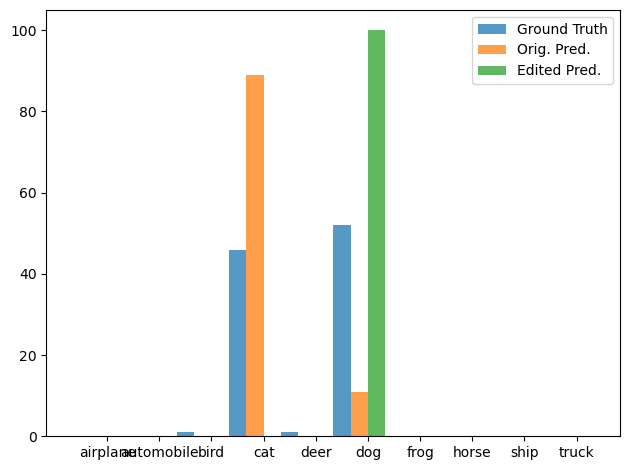

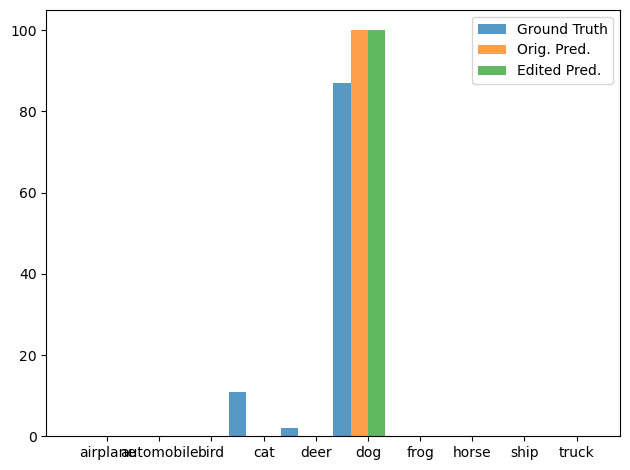

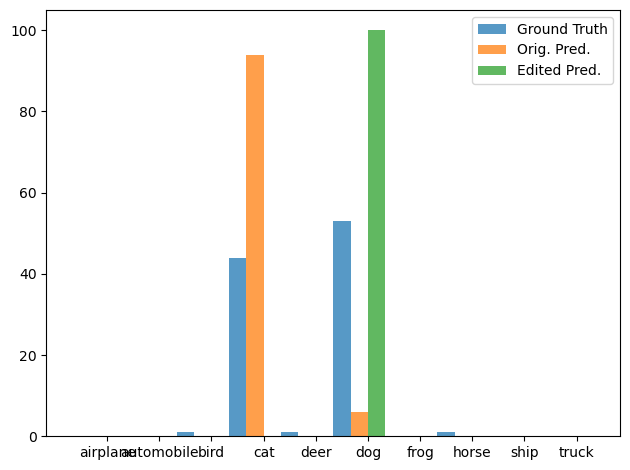

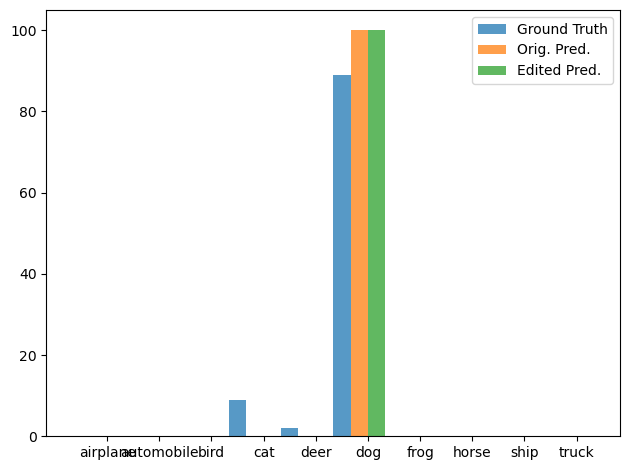

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_gaussian_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_gaussian_1/models
Finished trial 13/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_gaussian_1
(0113_162839) Starting Trial 14/2008...
Current run_id: 0113_160154/dog-train-n02111626_5132/felzenszwalb_masked_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_masked_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111626_5132.png
Value images: saved/segment

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 33.15it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.11162541806697845 0.003484685905277729
L2 norm of weight change: 0.46592578291893005
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:11<00:00, 23.76it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:202: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([5925, 5793, 5272,    0, 4279, 4628, 5573, 5144, 4928, 4143]), 'TN': array([60966, 60147, 59255, 62999, 60106, 55784, 61294, 61777, 61461,
       61896]), 'FPs': array([2034, 2853, 3745,    1, 2894, 7216, 1706, 1223, 1539, 1104]), 'FNs': array([1075, 1207, 1728, 7000, 2721, 2372, 1427, 1856, 2072, 2857]), 'accuracy': 0.6526428571428572, 'per_class_accuracy': array([0.95558571, 0.942     , 0.92181429, 0.89998571, 0.91978571,
       0.86302857, 0.95524286, 0.95601429, 0.94841429, 0.94341429]), 'per_class_accuracy_mean': 0.9305285714285713, 'precision': array([0.74444026, 0.67002082, 0.58467339, 0.        , 0.59654259,
       0.39074637, 0.76562715, 0.80791582, 0.76202258, 0.78959405]), 'precision_mean': 0.611158302203993, 'recall': array([0.84642857, 0.82757143, 0.75314286, 0.        , 0.61128571,
       0.66114286, 0.79614286, 0.73485714, 0.704     , 0.59185714]), 'recall_mean': 0.6526428571428571, 'f1': array([0.79216525, 0.74050876, 0.65830056, 0.      

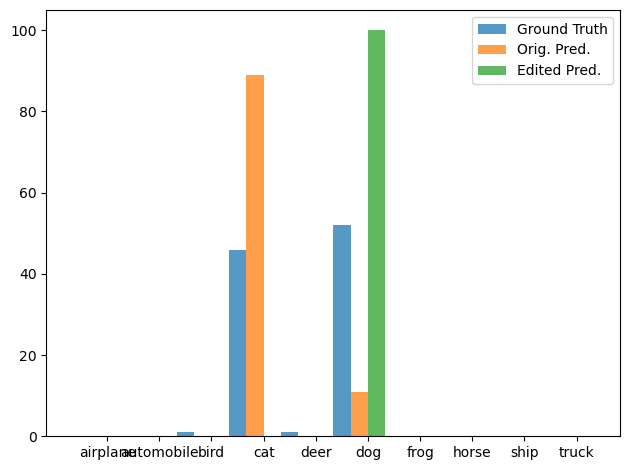

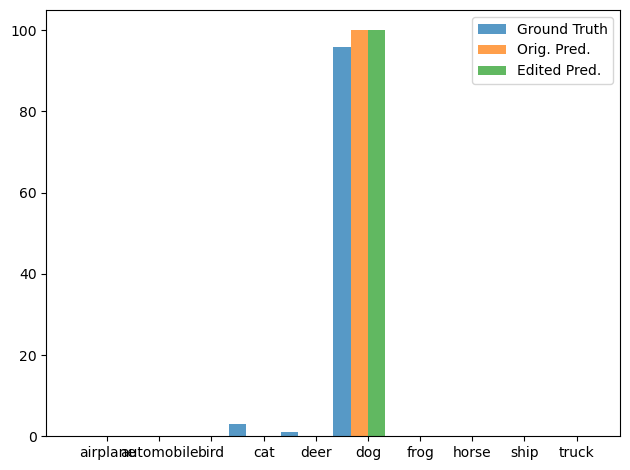

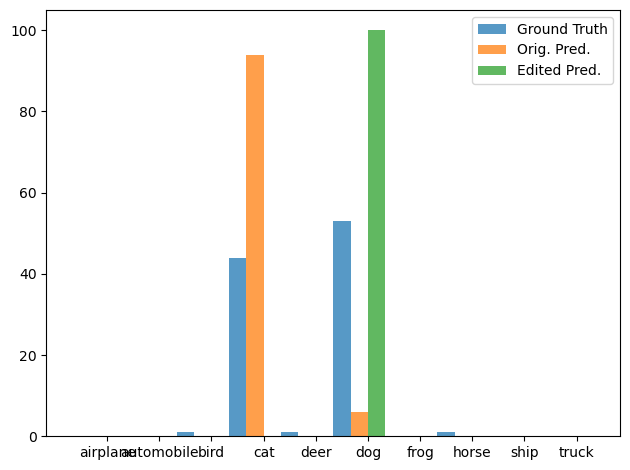

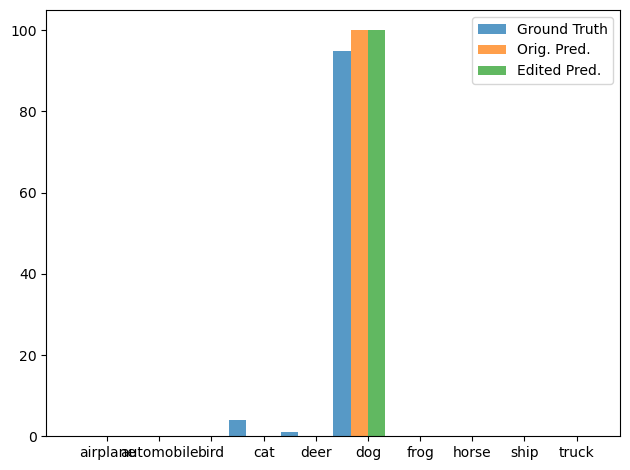

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_masked_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_masked_0/models
Finished trial 14/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_masked_0
(0113_163007) Starting Trial 15/2008...
Current run_id: 0113_160154/dog-train-n02111626_5132/felzenszwalb_masked_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_masked_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111626_5132.png
Value images: saved/segmentations

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 31.49it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.10099630802869797 0.004372484050691128
L2 norm of weight change: 0.4099348783493042
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:11<00:00, 24.22it/s]


Post-edit metrics: {'TP': array([5955, 5745, 5263,   12, 4302, 4588, 5605, 5135, 4940, 4203]), 'TN': array([60853, 60306, 59251, 62961, 60042, 56054, 61207, 61802, 61435,
       61837]), 'FPs': array([2147, 2694, 3749,   39, 2958, 6946, 1793, 1198, 1565, 1163]), 'FNs': array([1045, 1255, 1737, 6988, 2698, 2412, 1395, 1865, 2060, 2797]), 'accuracy': 0.6535428571428571, 'per_class_accuracy': array([0.9544    , 0.94358571, 0.92162857, 0.89961429, 0.9192    ,
       0.86631429, 0.95445714, 0.95624286, 0.94821429, 0.94342857]), 'per_class_accuracy_mean': 0.9307085714285714, 'precision': array([0.7350037 , 0.68076786, 0.58399911, 0.23529412, 0.59256198,
       0.39778048, 0.7576372 , 0.81083215, 0.75941583, 0.783265  ]), 'precision_mean': 0.6336557438951235, 'recall': array([0.85071429, 0.82071429, 0.75185714, 0.00171429, 0.61457143,
       0.65542857, 0.80071429, 0.73357143, 0.70571429, 0.60042857]), 'recall_mean': 0.6535428571428571, 'f1': array([0.78863727, 0.74421919, 0.65738196, 0.00340

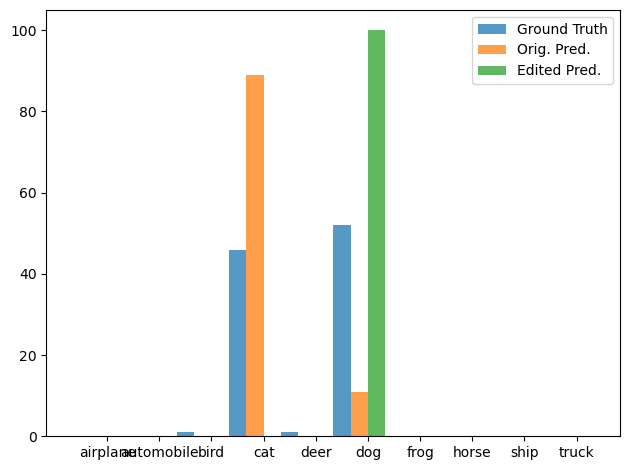

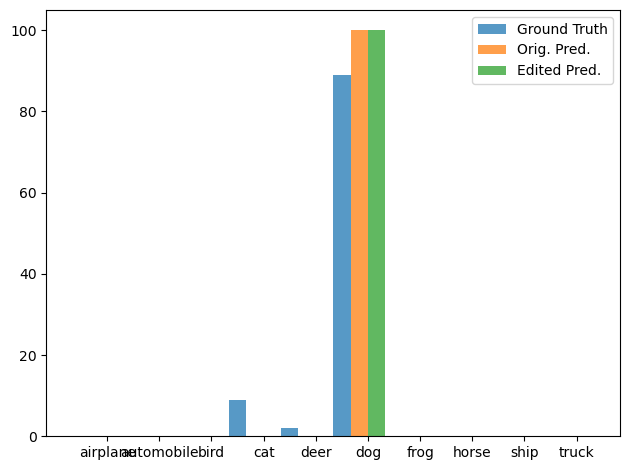

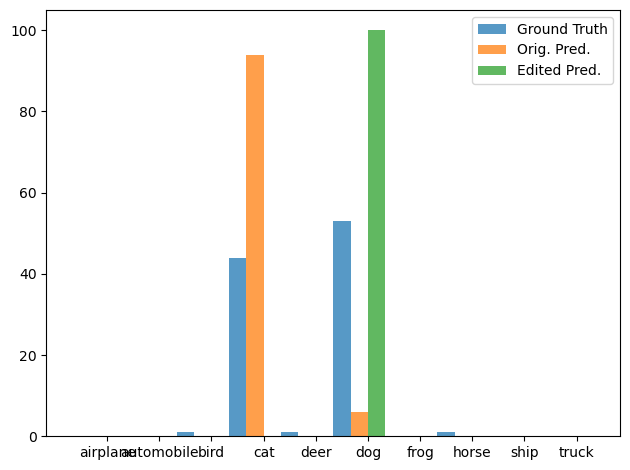

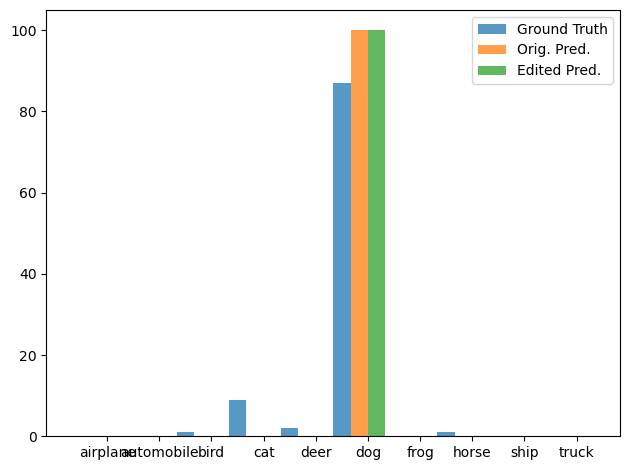

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_masked_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_masked_1/models
Finished trial 15/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_masked_1
(0113_163136) Starting Trial 16/2008...
Current run_id: 0113_160154/dog-train-n02111626_5132/felzenszwalb_masked_3
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_masked_3
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111626_5132.png
Value images: saved/segmentations

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 32.91it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.030310507863759995 0.004133759997785091
L2 norm of weight change: 0.16703422367572784
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:10<00:00, 26.38it/s]


Post-edit metrics: {'TP': array([6087, 5465, 5222, 3617, 4286, 3269, 5631, 5178, 4862, 4590]), 'TN': array([60351, 60996, 59382, 60361, 60061, 61324, 61117, 61665, 61589,
       61361]), 'FPs': array([2649, 2004, 3618, 2639, 2939, 1676, 1883, 1335, 1411, 1639]), 'FNs': array([ 913, 1535, 1778, 3383, 2714, 3731, 1369, 1822, 2138, 2410]), 'accuracy': 0.6886714285714286, 'per_class_accuracy': array([0.94911429, 0.94944286, 0.92291429, 0.91397143, 0.91924286,
       0.92275714, 0.95354286, 0.9549    , 0.9493    , 0.94215714]), 'per_class_accuracy_mean': 0.9377342857142859, 'precision': array([0.69677198, 0.73169099, 0.59072398, 0.57816496, 0.59321799,
       0.66107179, 0.74940112, 0.79502533, 0.77506775, 0.7368759 ]), 'precision_mean': 0.6908011799320765, 'recall': array([0.86957143, 0.78071429, 0.746     , 0.51671429, 0.61228571,
       0.467     , 0.80442857, 0.73971429, 0.69457143, 0.65571429]), 'recall_mean': 0.6886714285714286, 'f1': array([0.77364006, 0.75540811, 0.65934343, 0.54571

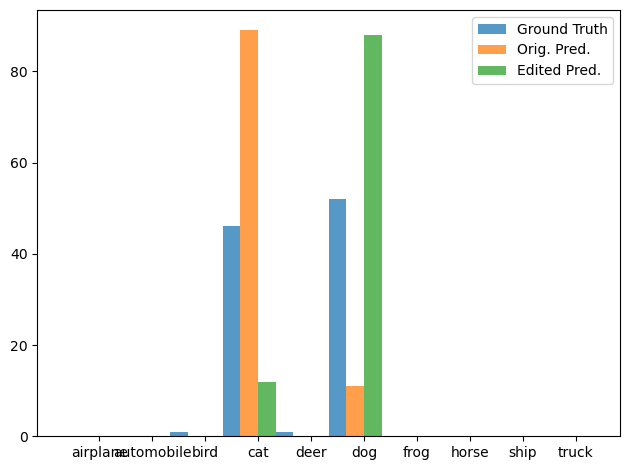

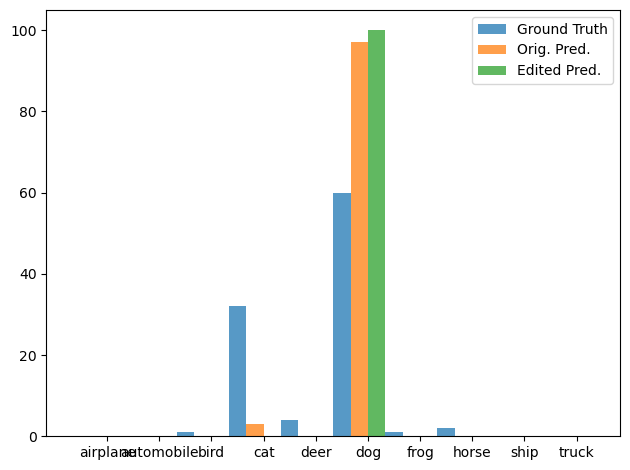

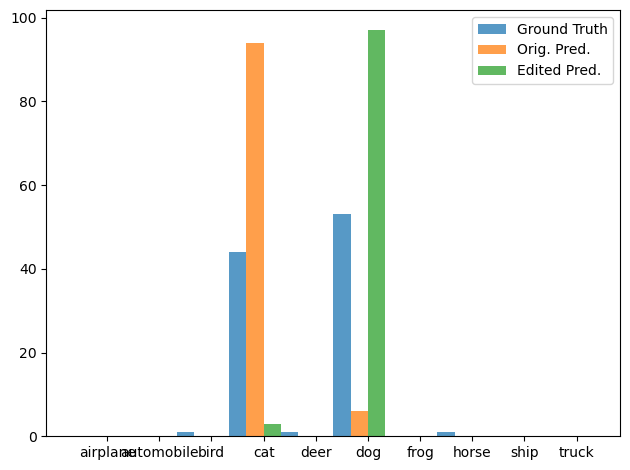

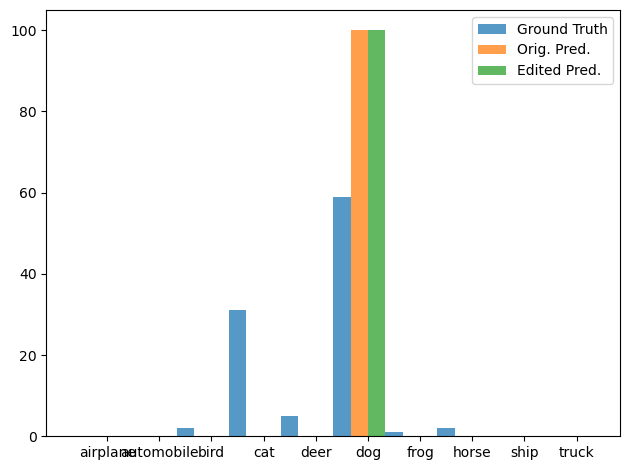

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_masked_3/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_masked_3/models
Finished trial 16/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/felzenszwalb_masked_3
(0113_163303) Starting Trial 17/2008...
Current run_id: 0113_160154/dog-train-n02111626_5132/quickshift_gaussian_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_gaussian_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111626_5132.png
Value images: saved/segmentations

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 32.48it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.09574900567531586 0.004116373136639595
L2 norm of weight change: 0.37683358788490295
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:10<00:00, 26.17it/s]


Post-edit metrics: {'TP': array([5968, 5710, 5261,  431, 4294, 4560, 5610, 5133, 4933, 4248]), 'TN': array([60818, 60398, 59266, 62841, 60076, 56535, 61183, 61805, 61445,
       61781]), 'FPs': array([2182, 2602, 3734,  159, 2924, 6465, 1817, 1195, 1555, 1219]), 'FNs': array([1032, 1290, 1739, 6569, 2706, 2440, 1390, 1867, 2067, 2752]), 'accuracy': 0.6592571428571429, 'per_class_accuracy': array([0.95408571, 0.9444    , 0.92181429, 0.90388571, 0.91957143,
       0.87278571, 0.95418571, 0.95625714, 0.94825714, 0.94327143]), 'per_class_accuracy_mean': 0.9318514285714287, 'precision': array([0.73226994, 0.68695861, 0.58488049, 0.73050847, 0.59490163,
       0.41360544, 0.75535209, 0.81115676, 0.76032676, 0.77702579]), 'precision_mean': 0.6846985998920785, 'recall': array([0.85257143, 0.81571429, 0.75157143, 0.06157143, 0.61342857,
       0.65142857, 0.80142857, 0.73328571, 0.70471429, 0.60685714]), 'recall_mean': 0.6592571428571429, 'f1': array([0.78785479, 0.74582027, 0.65783057, 0.11357

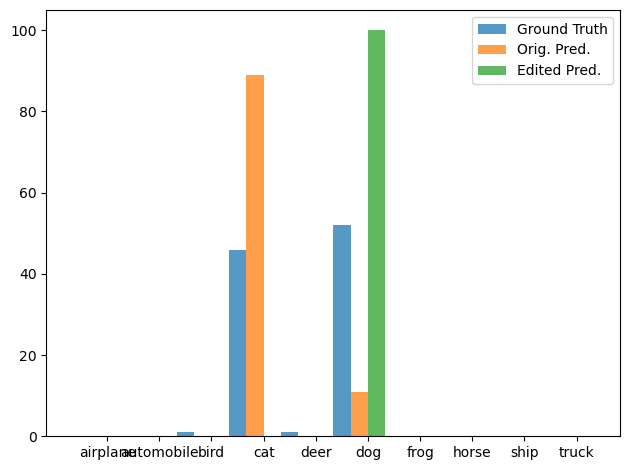

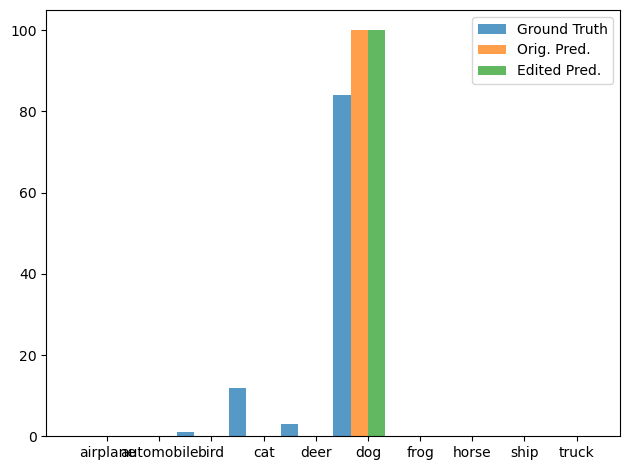

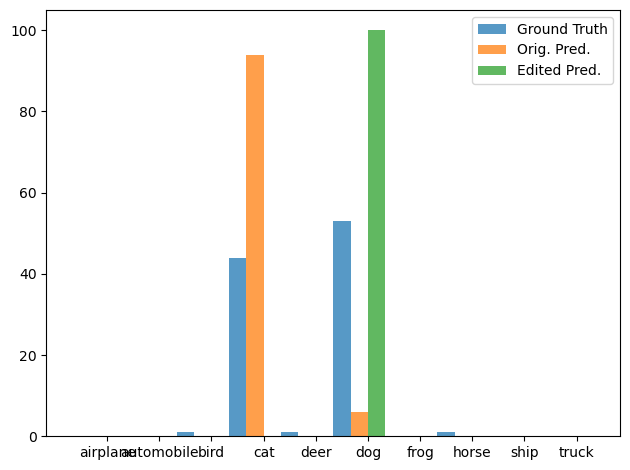

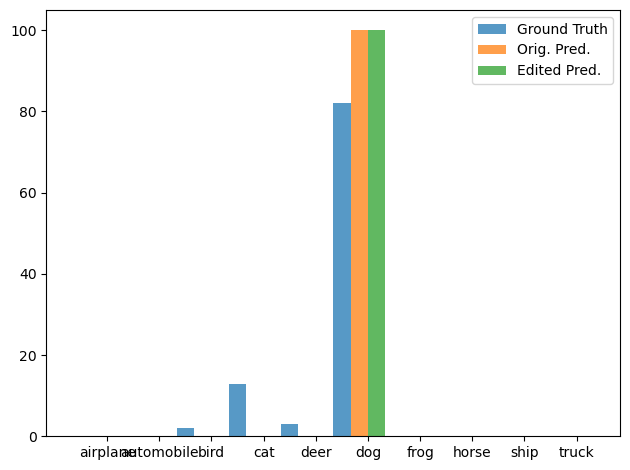

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_gaussian_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_gaussian_1/models
Finished trial 17/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_gaussian_1
(0113_163430) Starting Trial 18/2008...
Current run_id: 0113_160154/dog-train-n02111626_5132/quickshift_gaussian_4
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_gaussian_4
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111626_5132.png
Value images: saved/segmentations

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 33.26it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.019462063908576965 0.003641663584858179
L2 norm of weight change: 0.15008053183555603
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 28.28it/s]


Post-edit metrics: {'TP': array([6096, 5435, 5207, 3739, 4276, 3203, 5645, 5142, 4889, 4606]), 'TN': array([60325, 61014, 59482, 60133, 60131, 61431, 61092, 61767, 61558,
       61305]), 'FPs': array([2675, 1986, 3518, 2867, 2869, 1569, 1908, 1233, 1442, 1695]), 'FNs': array([ 904, 1565, 1793, 3261, 2724, 3797, 1355, 1858, 2111, 2394]), 'accuracy': 0.6891142857142857, 'per_class_accuracy': array([0.94887143, 0.94927143, 0.92412857, 0.91245714, 0.9201    ,
       0.92334286, 0.95338571, 0.95584286, 0.94924286, 0.94158571]), 'per_class_accuracy_mean': 0.9378228571428572, 'precision': array([0.69501767, 0.73238108, 0.59679083, 0.56600061, 0.59846046,
       0.67120704, 0.74738514, 0.80658824, 0.77223187, 0.73099508]), 'precision_mean': 0.6917058027297083, 'recall': array([0.87085714, 0.77642857, 0.74385714, 0.53414286, 0.61085714,
       0.45757143, 0.80642857, 0.73457143, 0.69842857, 0.658     ]), 'recall_mean': 0.6891142857142858, 'f1': array([0.77306449, 0.75376188, 0.66225755, 0.54961

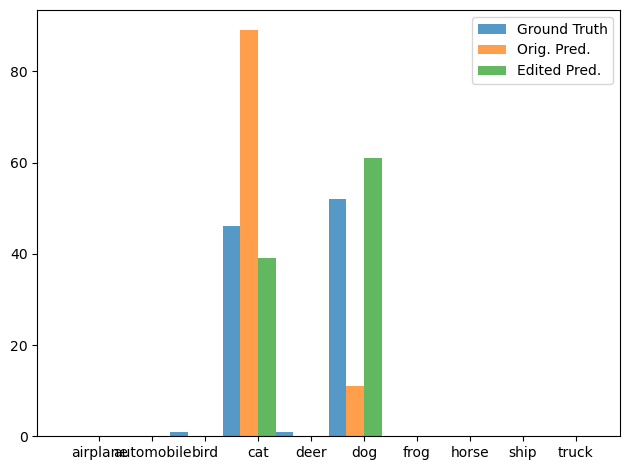

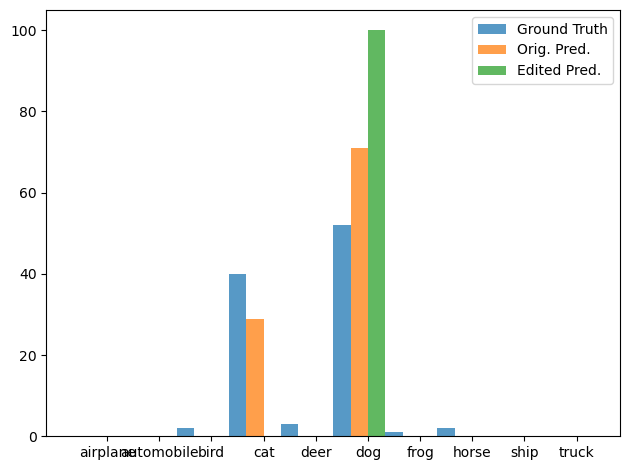

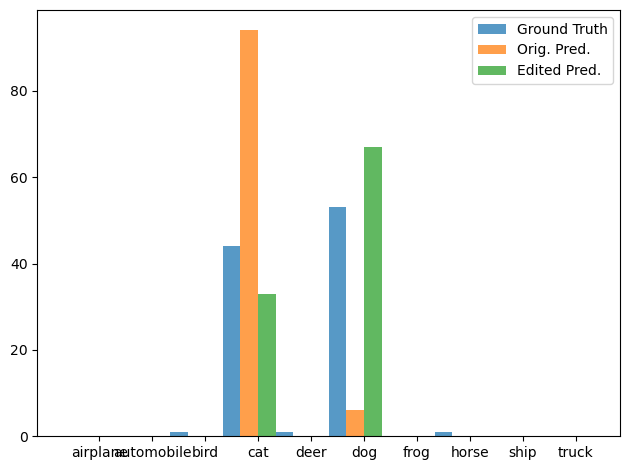

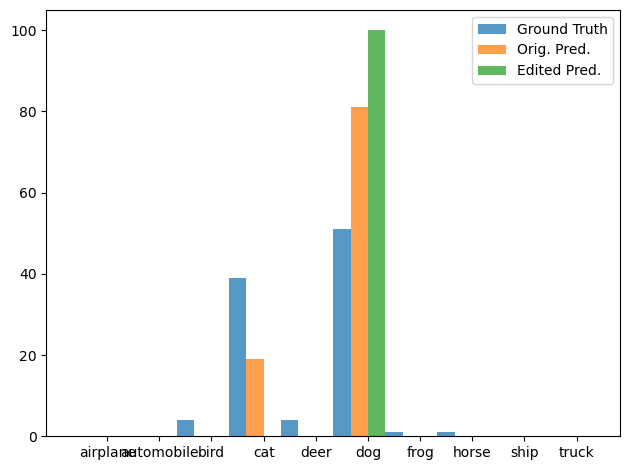

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_gaussian_4/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_gaussian_4/models
Finished trial 18/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_gaussian_4
(0113_163557) Starting Trial 19/2008...
Current run_id: 0113_160154/dog-train-n02111626_5132/quickshift_masked_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_masked_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111626_5132.png
Value images: saved/segmentations/dog

100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 28.24it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.017008241266012192 0.003090193960815668
L2 norm of weight change: 0.14946067333221436
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:10<00:00, 26.27it/s]


Post-edit metrics: {'TP': array([6103, 5431, 5206, 3770, 4264, 3184, 5643, 5145, 4878, 4618]), 'TN': array([60293, 61029, 59477, 60076, 60151, 61468, 61103, 61764, 61584,
       61297]), 'FPs': array([2707, 1971, 3523, 2924, 2849, 1532, 1897, 1236, 1416, 1703]), 'FNs': array([ 897, 1569, 1794, 3230, 2736, 3816, 1357, 1855, 2122, 2382]), 'accuracy': 0.6891714285714285, 'per_class_accuracy': array([0.94851429, 0.94942857, 0.92404286, 0.91208571, 0.92021429,
       0.9236    , 0.95351429, 0.95584286, 0.94945714, 0.94164286]), 'per_class_accuracy_mean': 0.9378342857142858, 'precision': array([0.69273553, 0.73372062, 0.5964028 , 0.56319092, 0.59946577,
       0.67514843, 0.74840849, 0.80629995, 0.77502383, 0.7305806 ]), 'precision_mean': 0.6920976931762737, 'recall': array([0.87185714, 0.77585714, 0.74371429, 0.53857143, 0.60914286,
       0.45485714, 0.80614286, 0.735     , 0.69685714, 0.65971429]), 'recall_mean': 0.6891714285714284, 'f1': array([0.77204301, 0.75420081, 0.66196198, 0.55060

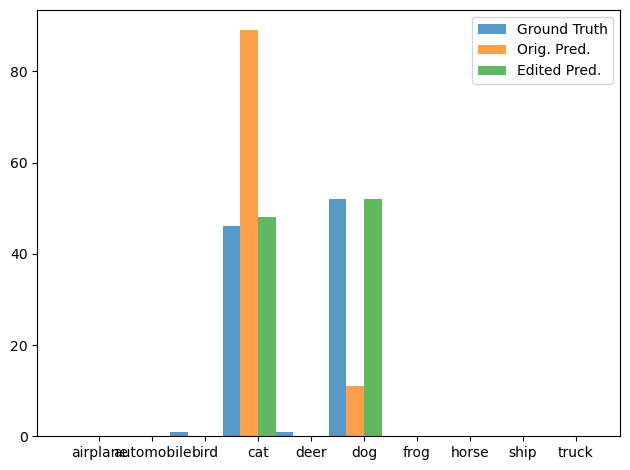

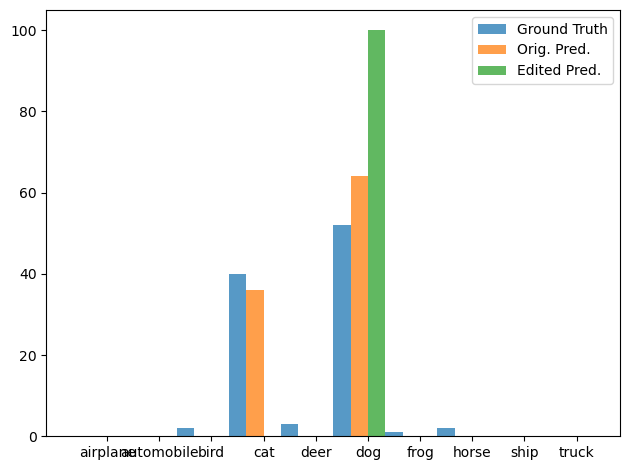

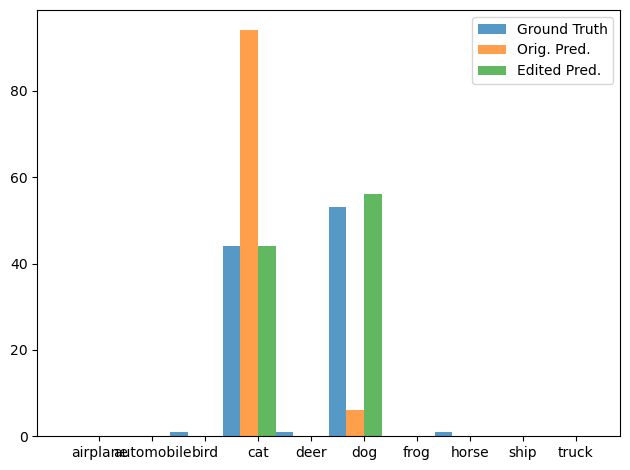

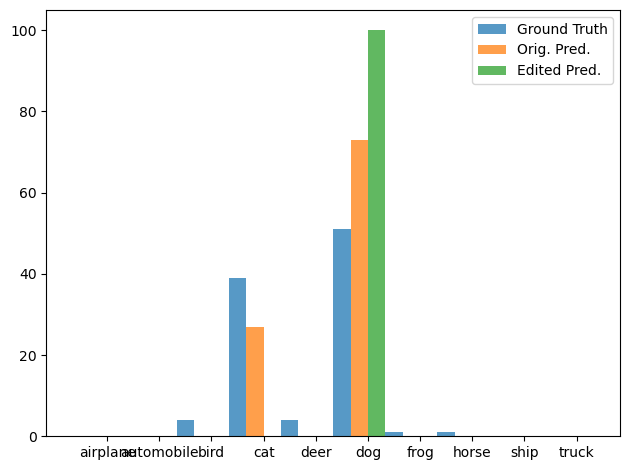

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_masked_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_masked_0/models
Finished trial 19/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_masked_0
(0113_163725) Starting Trial 20/2008...
Current run_id: 0113_160154/dog-train-n02111626_5132/quickshift_masked_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_masked_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111626_5132.png
Value images: saved/segmentations/dog/dog-t

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 33.26it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.10517062246799469 0.00413911510258913
L2 norm of weight change: 0.43798911571502686
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 30.00it/s]


Post-edit metrics: {'TP': array([5940, 5766, 5266,    1, 4289, 4609, 5592, 5144, 4926, 4177]), 'TN': array([60904, 60223, 59250, 62991, 60078, 55909, 61253, 61785, 61454,
       61863]), 'FPs': array([2096, 2777, 3750,    9, 2922, 7091, 1747, 1215, 1546, 1137]), 'FNs': array([1060, 1234, 1734, 6999, 2711, 2391, 1408, 1856, 2074, 2823]), 'accuracy': 0.653, 'per_class_accuracy': array([0.95491429, 0.9427    , 0.92165714, 0.89988571, 0.91952857,
       0.86454286, 0.95492857, 0.95612857, 0.94828571, 0.94342857]), 'per_class_accuracy_mean': 0.9305999999999999, 'precision': array([0.73917372, 0.67493855, 0.58407276, 0.1       , 0.59478574,
       0.39393162, 0.76195667, 0.80893222, 0.76112485, 0.78603688]), 'precision_mean': 0.6204953013003596, 'recall': array([8.48571429e-01, 8.23714286e-01, 7.52285714e-01, 1.42857143e-04,
       6.12714286e-01, 6.58428571e-01, 7.98857143e-01, 7.34857143e-01,
       7.03714286e-01, 5.96714286e-01]), 'recall_mean': 0.653, 'f1': array([7.90103751e-01, 7.4194

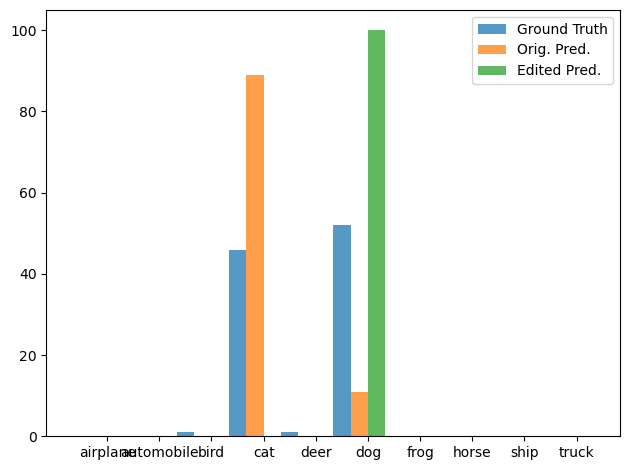

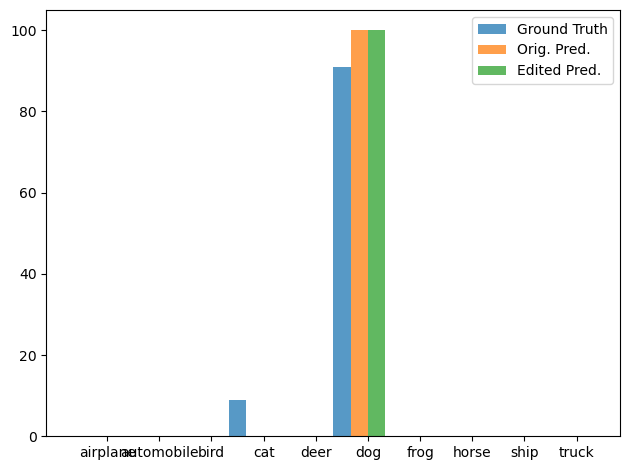

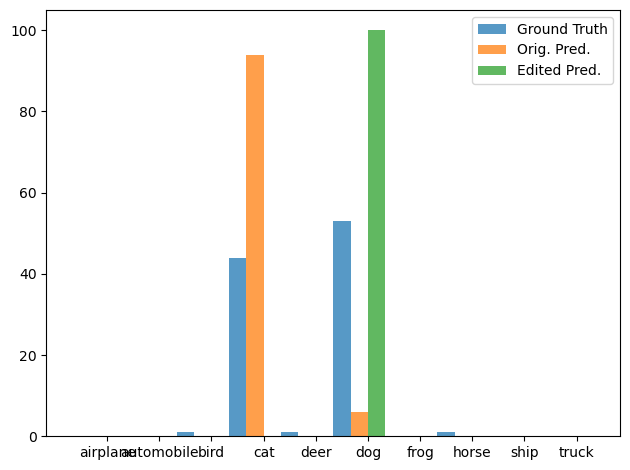

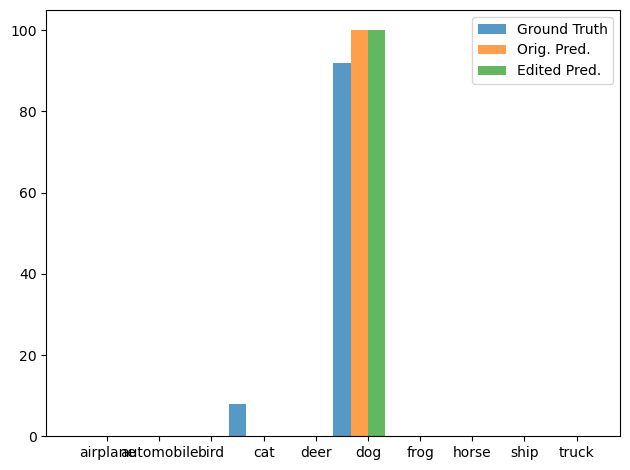

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_masked_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_masked_1/models
Finished trial 20/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_masked_1
(0113_163849) Starting Trial 21/2008...
Current run_id: 0113_160154/dog-train-n02111626_5132/quickshift_masked_3
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_masked_3
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111626_5132.png
Value images: saved/segmentations/dog/dog-t

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 33.71it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0051, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.0927850678563118 0.00511441333219409
L2 norm of weight change: 0.33879563212394714
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:10<00:00, 26.22it/s]


Post-edit metrics: {'TP': array([6083, 5701, 5291, 2331, 4334, 3967, 5632, 5170, 4901, 4250]), 'TN': array([60286, 60406, 59032, 62196, 59913, 59794, 61124, 61688, 61468,
       61753]), 'FPs': array([2714, 2594, 3968,  804, 3087, 3206, 1876, 1312, 1532, 1247]), 'FNs': array([ 917, 1299, 1709, 4669, 2666, 3033, 1368, 1830, 2099, 2750]), 'accuracy': 0.6808571428571428, 'per_class_accuracy': array([0.94812857, 0.94438571, 0.9189    , 0.92181429, 0.91781429,
       0.91087143, 0.95365714, 0.95511429, 0.94812857, 0.9429    ]), 'per_class_accuracy_mean': 0.9361714285714285, 'precision': array([0.69148573, 0.68728149, 0.571444  , 0.74354067, 0.58401833,
       0.55304615, 0.75013319, 0.79759334, 0.76185295, 0.77314899]), 'precision_mean': 0.691354483333569, 'recall': array([0.869     , 0.81442857, 0.75585714, 0.333     , 0.61914286,
       0.56671429, 0.80457143, 0.73857143, 0.70014286, 0.60714286]), 'recall_mean': 0.6808571428571428, 'f1': array([0.77014623, 0.74547238, 0.65083954, 0.459990

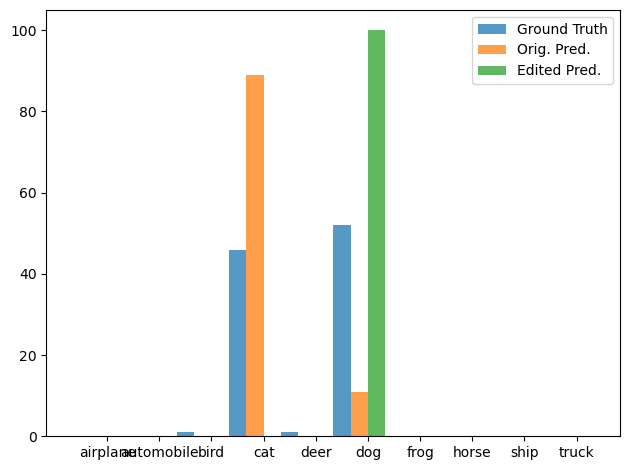

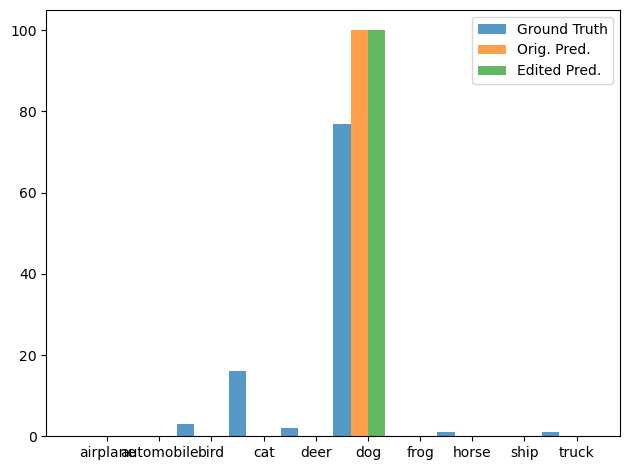

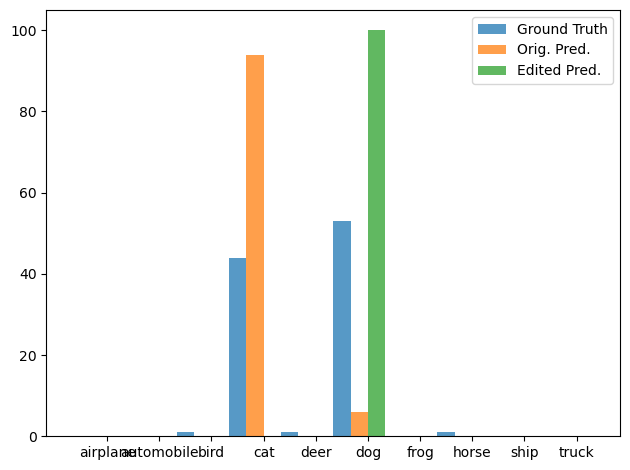

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_masked_3/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_masked_3/models
Finished trial 21/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/quickshift_masked_3
(0113_164015) Starting Trial 22/2008...
Current run_id: 0113_160154/dog-train-n02111626_5132/slic_gaussian_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_gaussian_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111626_5132.png
Value images: saved/segmentations/dog/dog-train-n02

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 34.07it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.10906830430030823 0.004128840286284685
L2 norm of weight change: 0.45239508152008057
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:10<00:00, 26.50it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:202: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([5928, 5783, 5267,    0, 4281, 4631, 5575, 5139, 4931, 4154]), 'TN': array([60948, 60201, 59255, 62997, 60102, 55770, 61287, 61788, 61454,
       61887]), 'FPs': array([2052, 2799, 3745,    3, 2898, 7230, 1713, 1212, 1546, 1113]), 'FNs': array([1072, 1217, 1733, 7000, 2719, 2369, 1425, 1861, 2069, 2846]), 'accuracy': 0.6527, 'per_class_accuracy': array([0.95537143, 0.94262857, 0.92174286, 0.89995714, 0.91975714,
       0.86287143, 0.95517143, 0.9561    , 0.94835714, 0.94344286]), 'per_class_accuracy_mean': 0.93054, 'precision': array([0.74285714, 0.67385225, 0.58444296, 0.        , 0.59632261,
       0.39043925, 0.76495609, 0.80916391, 0.76130925, 0.78868426]), 'precision_mean': 0.6112027730991599, 'recall': array([0.84685714, 0.82614286, 0.75242857, 0.        , 0.61157143,
       0.66157143, 0.79642857, 0.73414286, 0.70442857, 0.59342857]), 'recall_mean': 0.6527, 'f1': array([0.79145527, 0.74226672, 0.65788159, 0.        , 0.60385077,
       0.49106622,

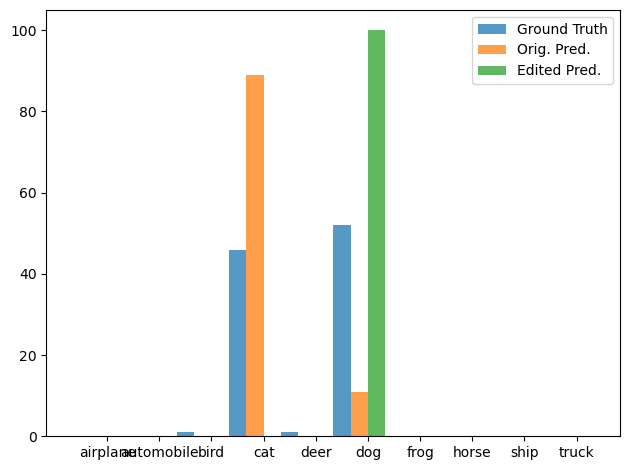

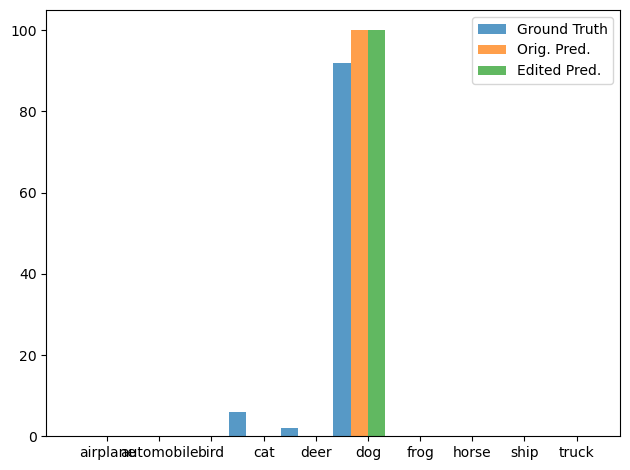

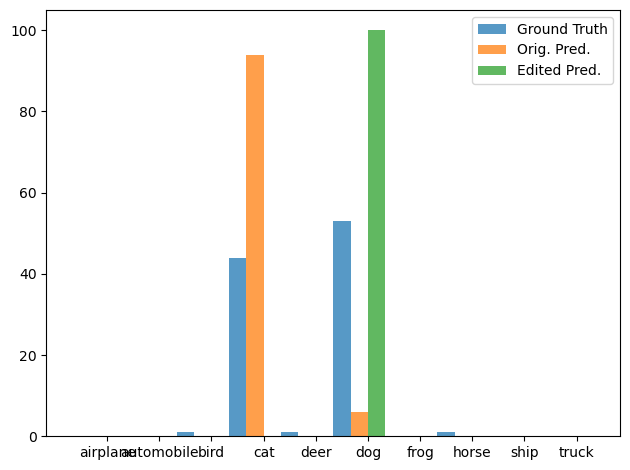

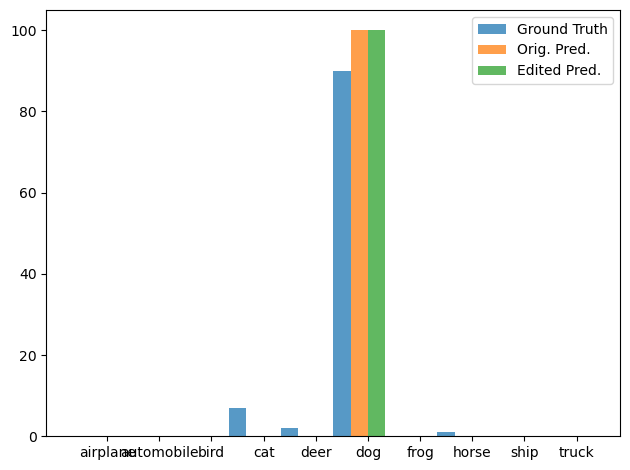

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_gaussian_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_gaussian_0/models
Finished trial 22/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_gaussian_0
(0113_164137) Starting Trial 23/2008...
Current run_id: 0113_160154/dog-train-n02111626_5132/slic_gaussian_2
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_gaussian_2
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111626_5132.png
Value images: saved/segmentations/dog/dog-train-n02111626_5132/

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 34.23it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.03922880068421364 0.003921233583241701
L2 norm of weight change: 0.19532062113285065
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 28.63it/s]


Post-edit metrics: {'TP': array([6065, 5507, 5216, 3510, 4272, 3438, 5640, 5151, 4906, 4532]), 'TN': array([60442, 60890, 59425, 60535, 60110, 61064, 61095, 61738, 61523,
       61415]), 'FPs': array([2558, 2110, 3575, 2465, 2890, 1936, 1905, 1262, 1477, 1585]), 'FNs': array([ 935, 1493, 1784, 3490, 2728, 3562, 1360, 1849, 2094, 2468]), 'accuracy': 0.6891, 'per_class_accuracy': array([0.9501    , 0.94852857, 0.92344286, 0.91492857, 0.91974286,
       0.92145714, 0.95335714, 0.95555714, 0.94898571, 0.9421    ]), 'per_class_accuracy_mean': 0.93782, 'precision': array([0.7033515 , 0.72298805, 0.59333409, 0.5874477 , 0.59648143,
       0.63974693, 0.74751491, 0.80321223, 0.7686041 , 0.74088606]), 'precision_mean': 0.690356700030901, 'recall': array([0.86642857, 0.78671429, 0.74514286, 0.50142857, 0.61028571,
       0.49114286, 0.80571429, 0.73585714, 0.70085714, 0.64742857]), 'recall_mean': 0.6891, 'f1': array([0.77641938, 0.75350619, 0.66062947, 0.54104046, 0.60330462,
       0.55568127, 

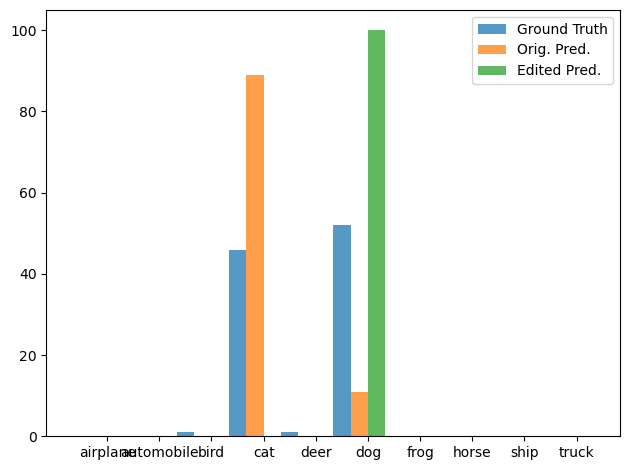

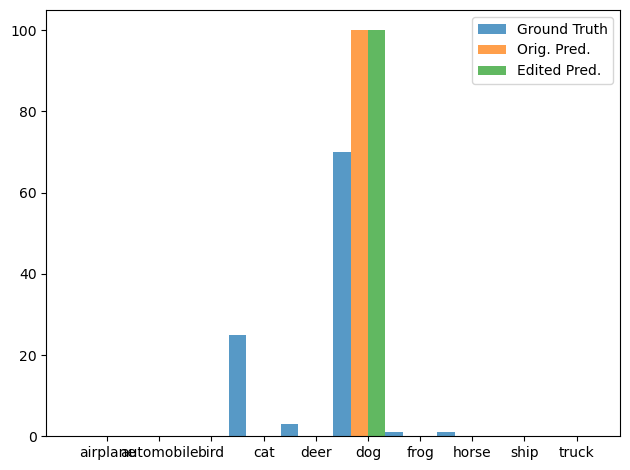

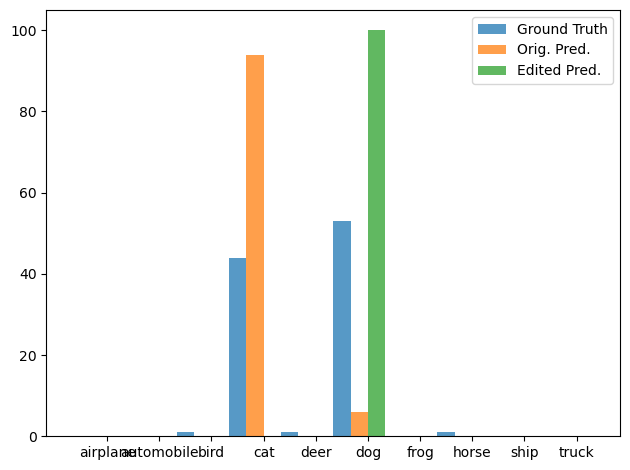

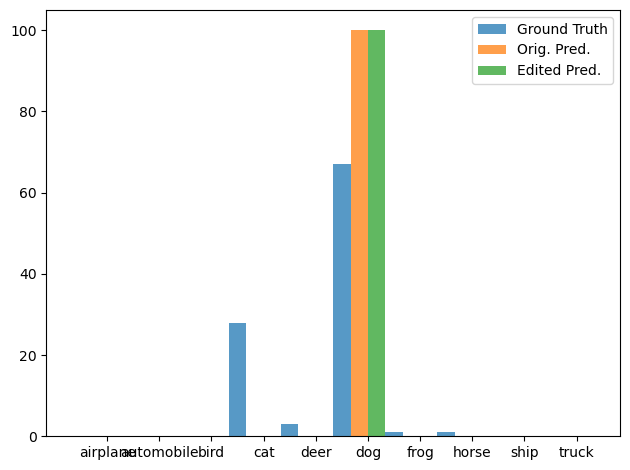

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_gaussian_2/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_gaussian_2/models
Finished trial 23/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_gaussian_2
(0113_164303) Starting Trial 24/2008...
Current run_id: 0113_160154/dog-train-n02111626_5132/slic_gaussian_4
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_gaussian_4
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111626_5132.png
Value images: saved/segmentations/dog/dog-train-n02111626_5132/

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 34.02it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.015964573249220848 0.003288794308900833
L2 norm of weight change: 0.14656025171279907
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:14<00:00, 18.85it/s]


Post-edit metrics: {'TP': array([6104, 5427, 5206, 3773, 4267, 3164, 5643, 5146, 4878, 4625]), 'TN': array([60289, 61038, 59481, 60062, 60143, 61483, 61101, 61765, 61582,
       61289]), 'FPs': array([2711, 1962, 3519, 2938, 2857, 1517, 1899, 1235, 1418, 1711]), 'FNs': array([ 896, 1573, 1794, 3227, 2733, 3836, 1357, 1854, 2122, 2375]), 'accuracy': 0.6890428571428572, 'per_class_accuracy': array([0.94847143, 0.9495    , 0.9241    , 0.91192857, 0.92014286,
       0.92352857, 0.95348571, 0.95587143, 0.94942857, 0.94162857]), 'per_class_accuracy_mean': 0.9378085714285715, 'precision': array([0.69245604, 0.73447016, 0.59667622, 0.56221129, 0.59896126,
       0.67592395, 0.74821002, 0.80645667, 0.77477764, 0.72995581]), 'precision_mean': 0.69200990542074, 'recall': array([0.872     , 0.77528571, 0.74371429, 0.539     , 0.60957143,
       0.452     , 0.80614286, 0.73514286, 0.69685714, 0.66071429]), 'recall_mean': 0.6890428571428571, 'f1': array([0.77192539, 0.75432622, 0.66213037, 0.5503610

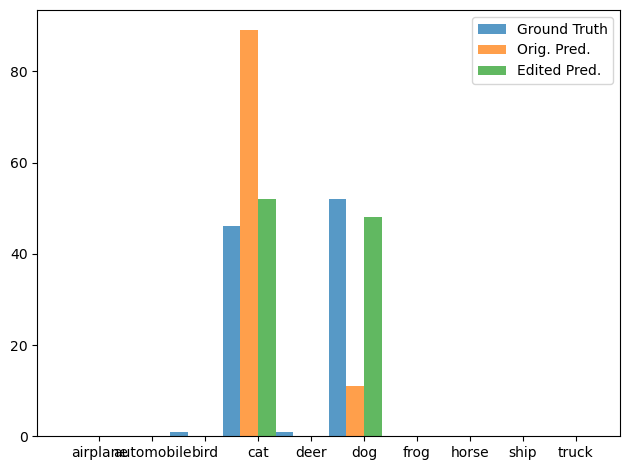

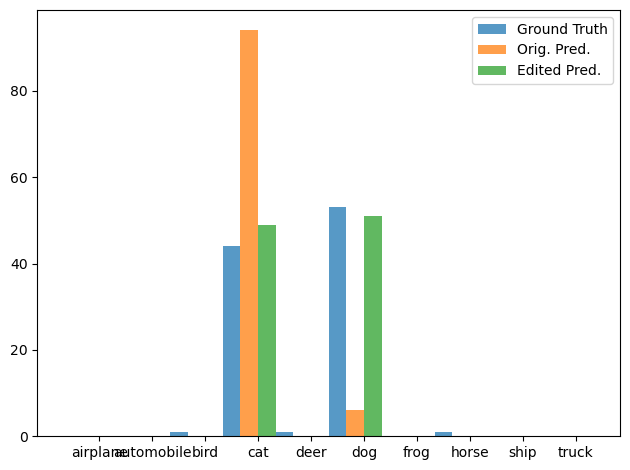

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_gaussian_4/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_gaussian_4/models
Finished trial 24/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_gaussian_4
(0113_164431) Starting Trial 25/2008...
Current run_id: 0113_160154/dog-train-n02111626_5132/slic_masked_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_masked_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111626_5132.png
Value images: saved/segmentations/dog/dog-train-n02111626_5132/modi

100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 27.56it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.07786932587623596 0.004029260948300362
L2 norm of weight change: 0.30398309230804443
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 28.12it/s]


Post-edit metrics: {'TP': array([6039, 5645, 5258, 2775, 4315, 3970, 5641, 5136, 4933, 4353]), 'TN': array([60581, 60590, 59298, 61703, 59988, 59894, 61102, 61785, 61449,
       61675]), 'FPs': array([2419, 2410, 3702, 1297, 3012, 3106, 1898, 1215, 1551, 1325]), 'FNs': array([ 961, 1355, 1742, 4225, 2685, 3030, 1359, 1864, 2067, 2647]), 'accuracy': 0.6866428571428571, 'per_class_accuracy': array([0.95171429, 0.94621429, 0.92222857, 0.92111429, 0.91861429,
       0.91234286, 0.95347143, 0.95601429, 0.94831429, 0.94325714]), 'per_class_accuracy_mean': 0.9373285714285713, 'precision': array([0.71399858, 0.70080695, 0.58683036, 0.6814833 , 0.5889177 ,
       0.56105144, 0.74824247, 0.80869154, 0.76079581, 0.76664318]), 'precision_mean': 0.6917461340698016, 'recall': array([0.86271429, 0.80642857, 0.75114286, 0.39642857, 0.61642857,
       0.56714286, 0.80585714, 0.73371429, 0.70471429, 0.62185714]), 'recall_mean': 0.6866428571428571, 'f1': array([0.78134299, 0.74991697, 0.65889724, 0.50126

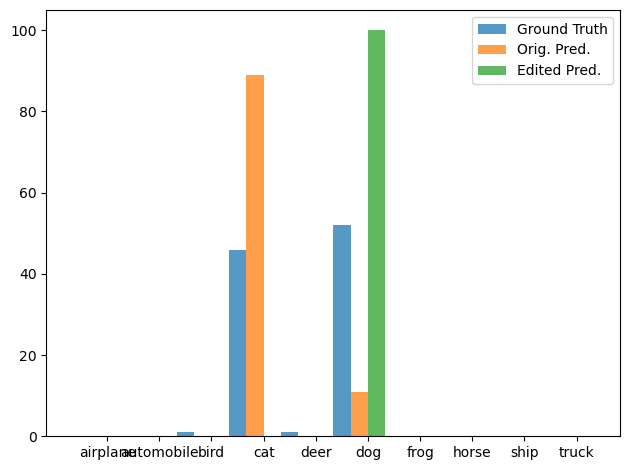

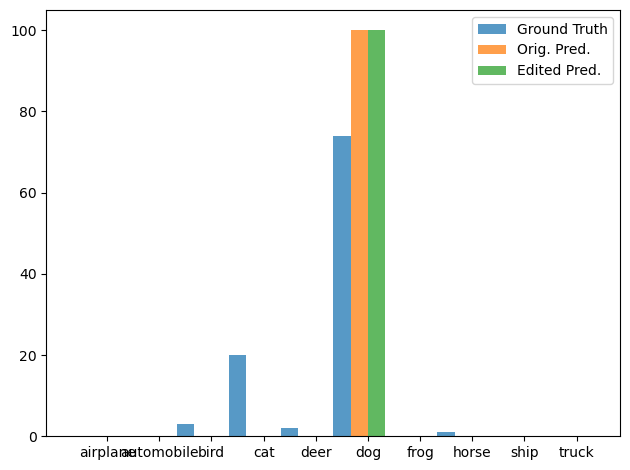

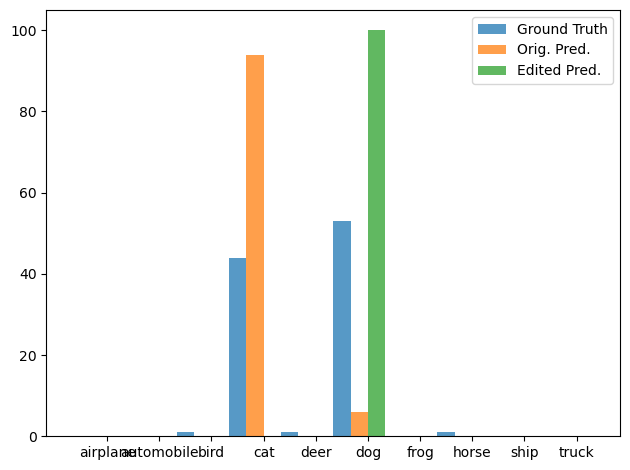

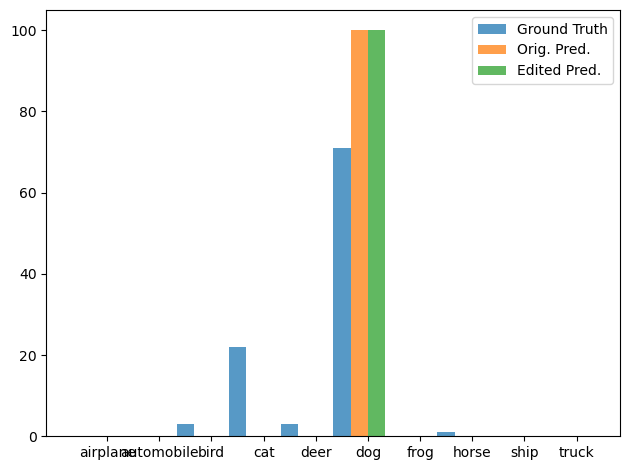

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_masked_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_masked_0/models
Finished trial 25/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_masked_0
(0113_164601) Starting Trial 26/2008...
Current run_id: 0113_160154/dog-train-n02111626_5132/slic_masked_2
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_masked_2
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111626_5132.png
Value images: saved/segmentations/dog/dog-train-n02111626_5132/modified_i

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 34.09it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.10599926859140396 0.0038981973193585873
L2 norm of weight change: 0.4383980929851532
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 30.16it/s]


Post-edit metrics: {'TP': array([5938, 5774, 5266,    1, 4285, 4616, 5586, 5139, 4926, 4168]), 'TN': array([60910, 60218, 59244, 62992, 60097, 55861, 61258, 61786, 61460,
       61873]), 'FPs': array([2090, 2782, 3756,    8, 2903, 7139, 1742, 1214, 1540, 1127]), 'FNs': array([1062, 1226, 1734, 6999, 2715, 2384, 1414, 1861, 2074, 2832]), 'accuracy': 0.6528428571428572, 'per_class_accuracy': array([0.95497143, 0.94274286, 0.92157143, 0.8999    , 0.91974286,
       0.86395714, 0.95491429, 0.95607143, 0.94837143, 0.94344286]), 'per_class_accuracy_mean': 0.9305685714285715, 'precision': array([0.73966119, 0.67484806, 0.58368433, 0.11111111, 0.59613244,
       0.39268396, 0.76228166, 0.80890918, 0.76183112, 0.7871577 ]), 'precision_mean': 0.6218300739937929, 'recall': array([8.48285714e-01, 8.24857143e-01, 7.52285714e-01, 1.42857143e-04,
       6.12142857e-01, 6.59428571e-01, 7.98000000e-01, 7.34142857e-01,
       7.03714286e-01, 5.95428571e-01]), 'recall_mean': 0.6528428571428571, 'f1': arr

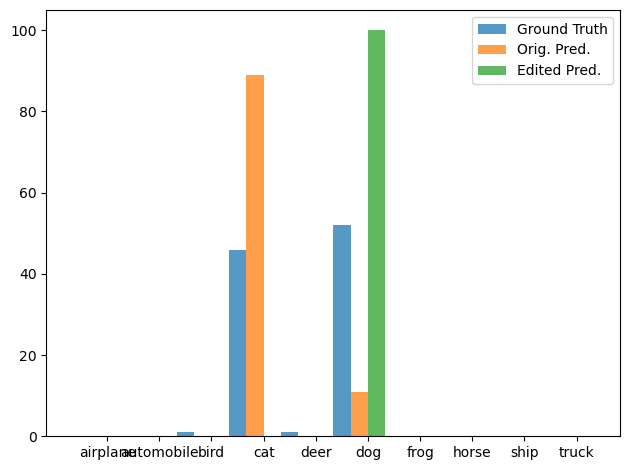

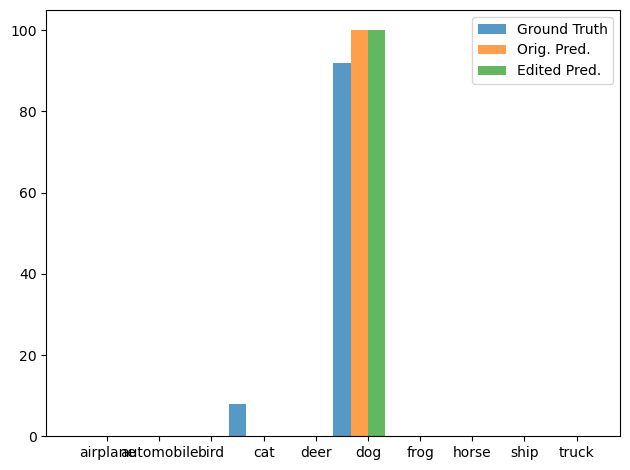

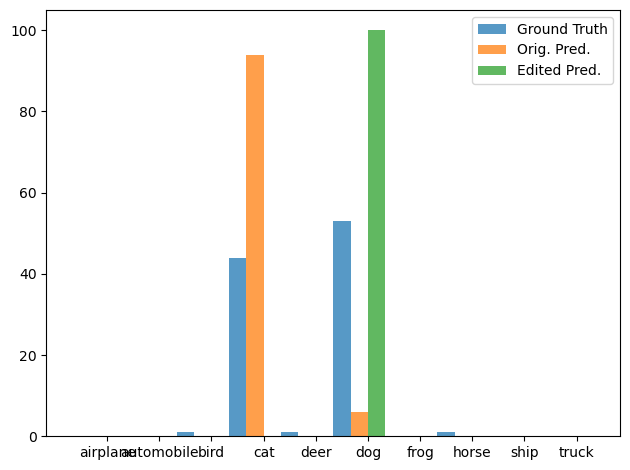

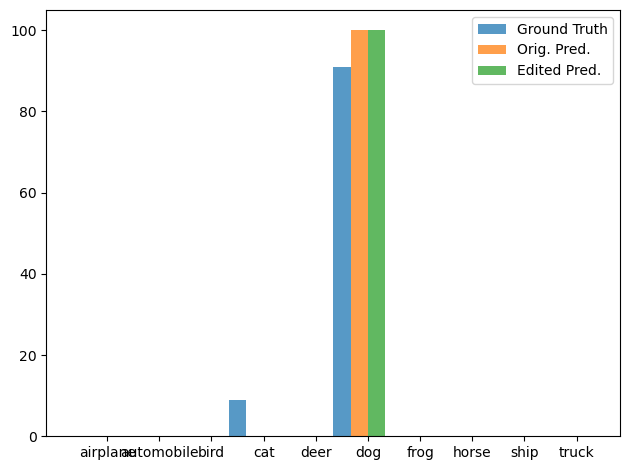

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_masked_2/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_masked_2/models
Finished trial 26/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/slic_masked_2
(0113_164727) Starting Trial 27/2008...
Current run_id: 0113_160154/dog-train-n02111626_5132/watershed_gaussian_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/watershed_gaussian_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111626_5132.png
Value images: saved/segmentations/dog/dog-train-n02111626_5

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 34.03it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:


Loss (orig, final): 0.078083835542202 0.004048333503305912
L2 norm of weight change: 0.30686041712760925
Performing post-edit metric & KNN calculations on validation set.


100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 27.65it/s]


Post-edit metrics: {'TP': array([6023, 5641, 5257, 2763, 4304, 4008, 5639, 5146, 4922, 4360]), 'TN': array([60665, 60597, 59308, 61703, 60023, 59777, 61103, 61768, 61458,
       61661]), 'FPs': array([2335, 2403, 3692, 1297, 2977, 3223, 1897, 1232, 1542, 1339]), 'FNs': array([ 977, 1359, 1743, 4237, 2696, 2992, 1361, 1854, 2078, 2640]), 'accuracy': 0.6866142857142857, 'per_class_accuracy': array([0.95268571, 0.94625714, 0.92235714, 0.92094286, 0.91895714,
       0.91121429, 0.95345714, 0.95591429, 0.94828571, 0.94315714]), 'per_class_accuracy_mean': 0.9373228571428571, 'precision': array([0.72062694, 0.70126803, 0.58743994, 0.68054187, 0.59112759,
       0.55428018, 0.74827495, 0.806836  , 0.76144802, 0.7650465 ]), 'precision_mean': 0.6916890019213197, 'recall': array([0.86042857, 0.80585714, 0.751     , 0.39471429, 0.61485714,
       0.57257143, 0.80557143, 0.73514286, 0.70314286, 0.62285714]), 'recall_mean': 0.6866142857142857, 'f1': array([0.78434692, 0.74993353, 0.65922628, 0.49963

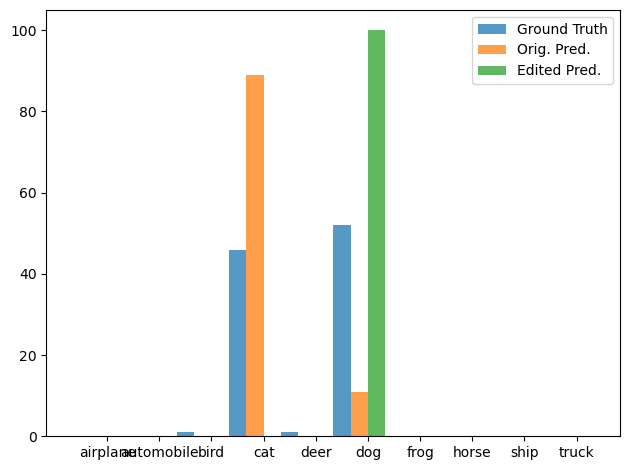

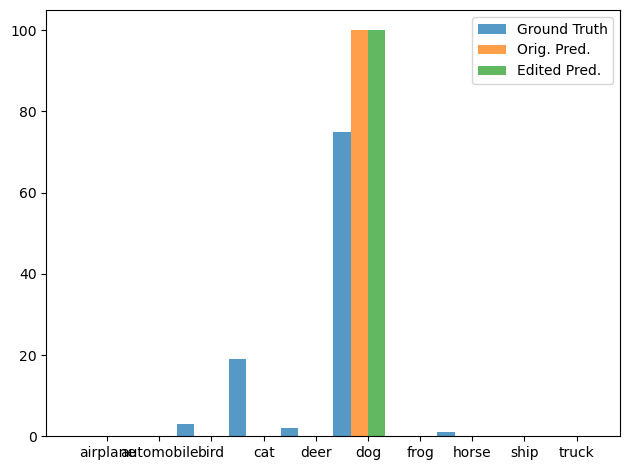

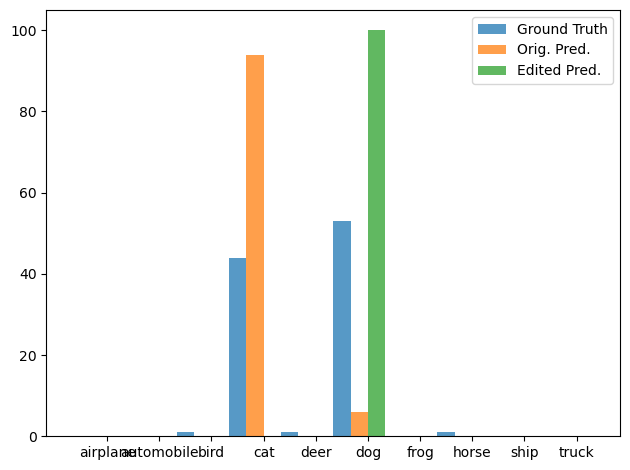

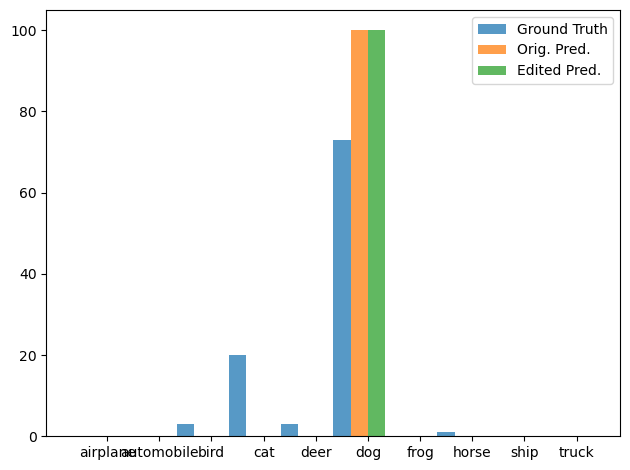

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/watershed_gaussian_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/watershed_gaussian_0/models
Finished trial 27/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/watershed_gaussian_0
(0113_164851) Starting Trial 28/2008...
Current run_id: 0113_160154/dog-train-n02111626_5132/watershed_gaussian_4
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/watershed_gaussian_4
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111626_5132.png
Value images: saved/segmentations/dog/

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 33.90it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.07583881914615631 0.003927646204829216
L2 norm of weight change: 0.2998168170452118
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 29.10it/s]


Post-edit metrics: {'TP': array([6018, 5633, 5248, 2827, 4288, 3989, 5635, 5146, 4923, 4372]), 'TN': array([60681, 60620, 59329, 61597, 60049, 59832, 61102, 61767, 61462,
       61640]), 'FPs': array([2319, 2380, 3671, 1403, 2951, 3168, 1898, 1233, 1538, 1360]), 'FNs': array([ 982, 1367, 1752, 4173, 2712, 3011, 1365, 1854, 2077, 2628]), 'accuracy': 0.6868428571428571, 'per_class_accuracy': array([0.95284286, 0.94647143, 0.92252857, 0.92034286, 0.9191    ,
       0.91172857, 0.95338571, 0.9559    , 0.94835714, 0.94302857]), 'per_class_accuracy_mean': 0.9373685714285716, 'precision': array([0.72184239, 0.70298265, 0.58840677, 0.66832151, 0.59234701,
       0.55735643, 0.74804195, 0.80670952, 0.76195635, 0.76273552]), 'precision_mean': 0.6910700108865699, 'recall': array([0.85971429, 0.80471429, 0.74971429, 0.40385714, 0.61257143,
       0.56985714, 0.805     , 0.73514286, 0.70328571, 0.62457143]), 'recall_mean': 0.6868428571428572, 'f1': array([0.78476886, 0.75041631, 0.6593379 , 0.50347

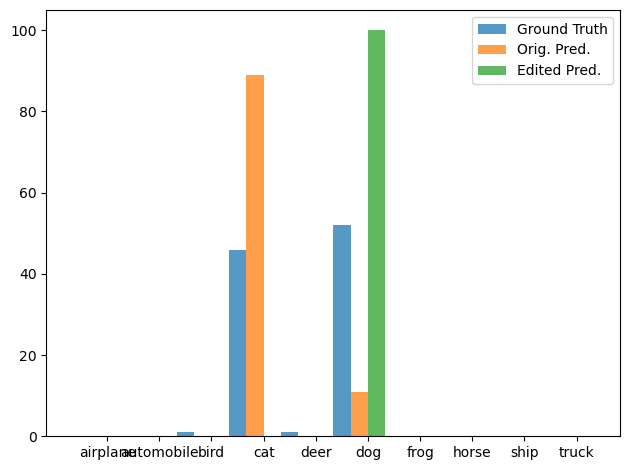

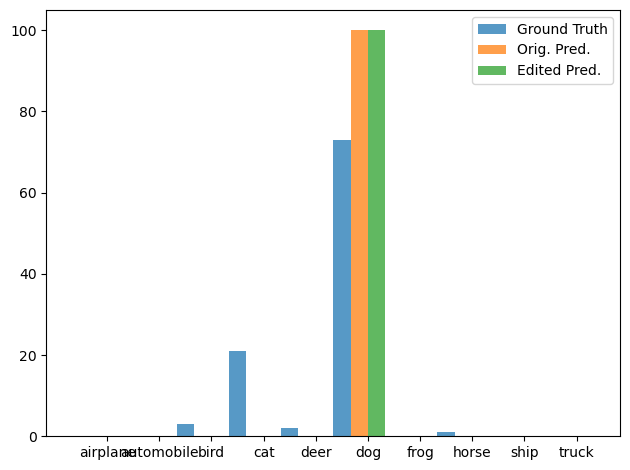

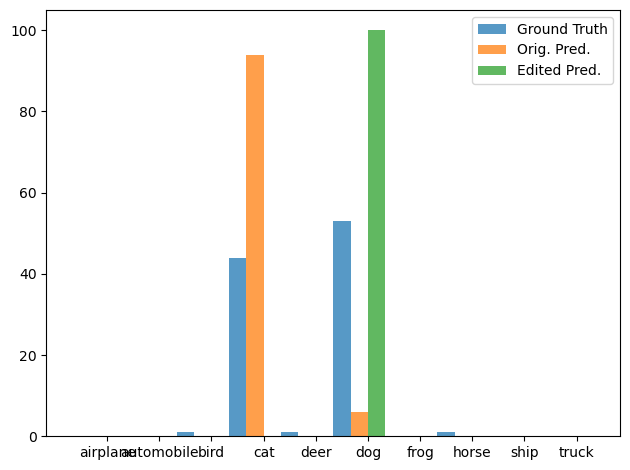

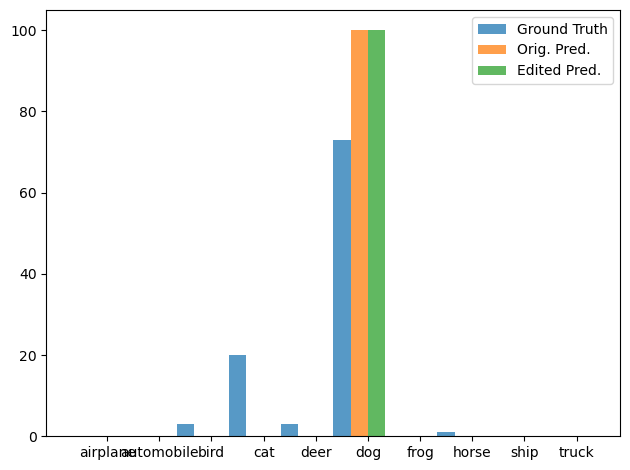

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/watershed_gaussian_4/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/watershed_gaussian_4/models
Finished trial 28/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/watershed_gaussian_4
(0113_165017) Starting Trial 29/2008...
Current run_id: 0113_160154/dog-train-n02111626_5132/watershed_masked_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/watershed_masked_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111626_5132.png
Value images: saved/segmentations/dog/dog-

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 33.75it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0038, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.044067081063985825 0.0038011157885193825
L2 norm of weight change: 0.20480066537857056
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:11<00:00, 22.97it/s]


Post-edit metrics: {'TP': array([6064, 5519, 5221, 3462, 4277, 3484, 5642, 5144, 4914, 4504]), 'TN': array([60454, 60860, 59403, 60629, 60101, 60973, 61096, 61753, 61509,
       61453]), 'FPs': array([2546, 2140, 3597, 2371, 2899, 2027, 1904, 1247, 1491, 1547]), 'FNs': array([ 936, 1481, 1779, 3538, 2723, 3516, 1358, 1856, 2086, 2496]), 'accuracy': 0.6890142857142857, 'per_class_accuracy': array([0.95025714, 0.94827143, 0.9232    , 0.91558571, 0.91968571,
       0.92081429, 0.9534    , 0.95567143, 0.9489    , 0.94224286]), 'per_class_accuracy_mean': 0.937802857142857, 'precision': array([0.70429733, 0.72059016, 0.59208437, 0.59351963, 0.59601449,
       0.63219017, 0.74768089, 0.80488187, 0.76721311, 0.74433978]), 'precision_mean': 0.6902811793469011, 'recall': array([0.86628571, 0.78842857, 0.74585714, 0.49457143, 0.611     ,
       0.49771429, 0.806     , 0.73485714, 0.702     , 0.64342857]), 'recall_mean': 0.6890142857142857, 'f1': array([0.77693786, 0.75298451, 0.66013402, 0.539546

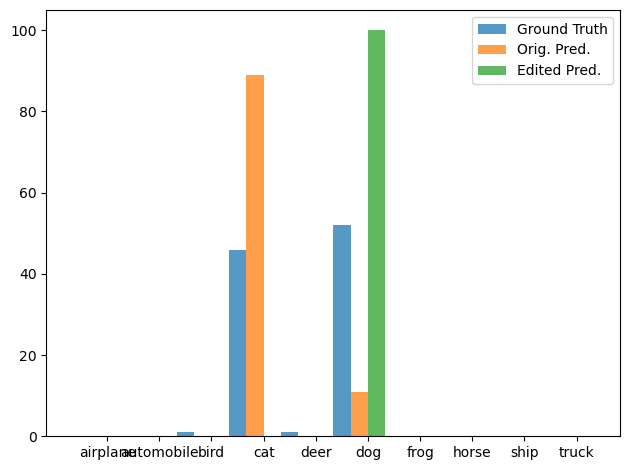

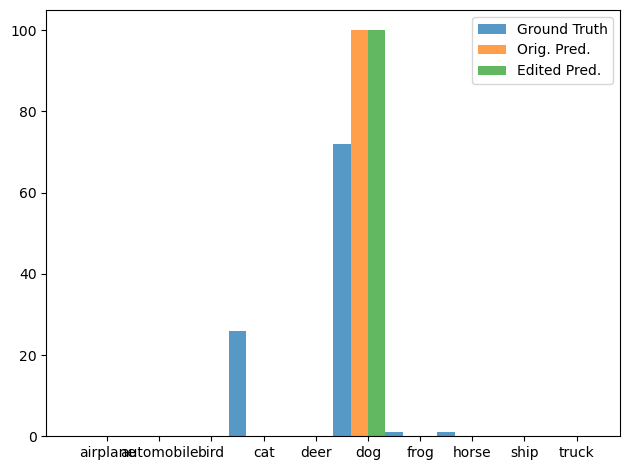

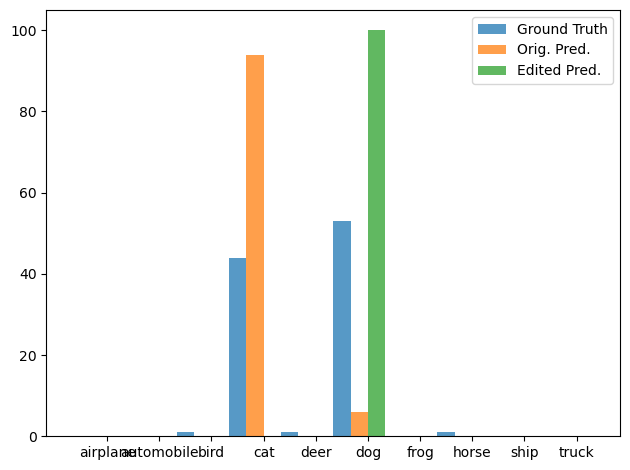

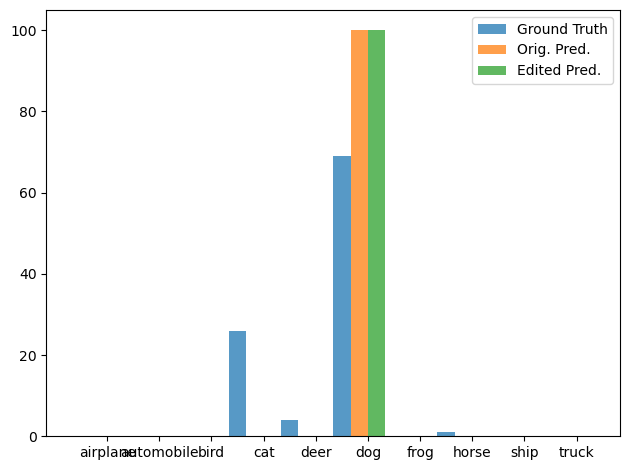

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/watershed_masked_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/watershed_masked_1/models
Finished trial 29/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/watershed_masked_1
(0113_165145) Starting Trial 30/2008...
Current run_id: 0113_160154/dog-train-n02111626_5132/watershed_masked_4
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/watershed_masked_4
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111626_5132.png
Value images: saved/segmentations/dog/dog-train-

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 32.99it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.11306753754615784 0.0035239863209426403
L2 norm of weight change: 0.46857765316963196
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 29.86it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:165: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:202: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([5923, 5797, 5271,    0, 4276, 4632, 5571, 5142, 4927, 4136]), 'TN': array([60972, 60135, 59261, 63000, 60112, 55753, 61300, 61776, 61463,
       61903]), 'FPs': array([2028, 2865, 3739,    0, 2888, 7247, 1700, 1224, 1537, 1097]), 'FNs': array([1077, 1203, 1729, 7000, 2724, 2368, 1429, 1858, 2073, 2864]), 'accuracy': 0.6525, 'per_class_accuracy': array([0.95564286, 0.94188571, 0.92188571, 0.9       , 0.91982857,
       0.86264286, 0.9553    , 0.95597143, 0.94842857, 0.94341429]), 'per_class_accuracy_mean': 0.9305, 'precision': array([0.74493774, 0.66924498, 0.58501665, 0.        , 0.59687326,
       0.38993181, 0.76619447, 0.80772856, 0.76222153, 0.79036881]), 'precision_mean': 0.6112517814625458, 'recall': array([0.84614286, 0.82814286, 0.753     , 0.        , 0.61085714,
       0.66171429, 0.79585714, 0.73457143, 0.70385714, 0.59085714]), 'recall_mean': 0.6525000000000001, 'f1': array([0.79232158, 0.74026306, 0.65846346, 0.        , 0.60378424,
       

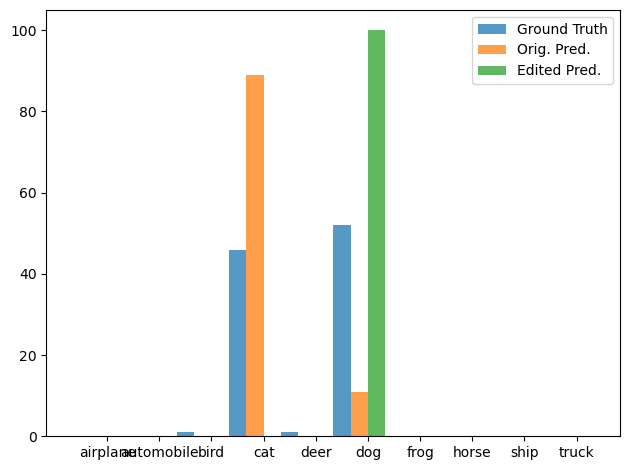

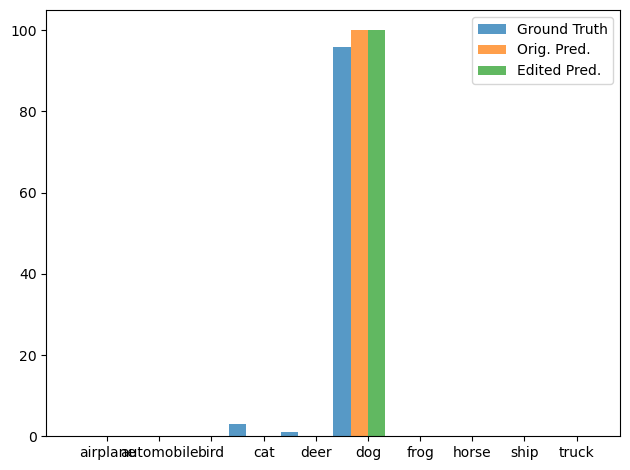

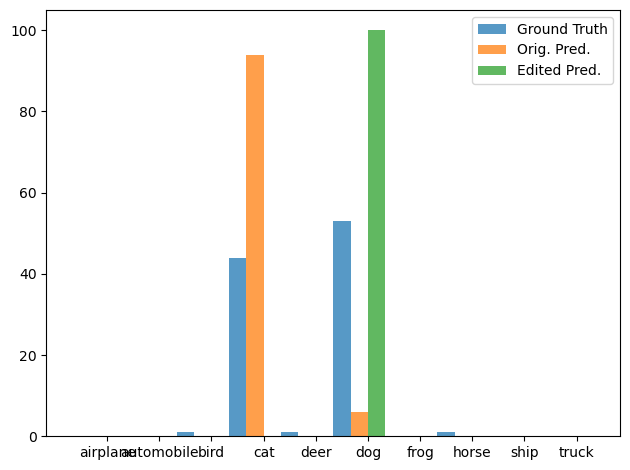

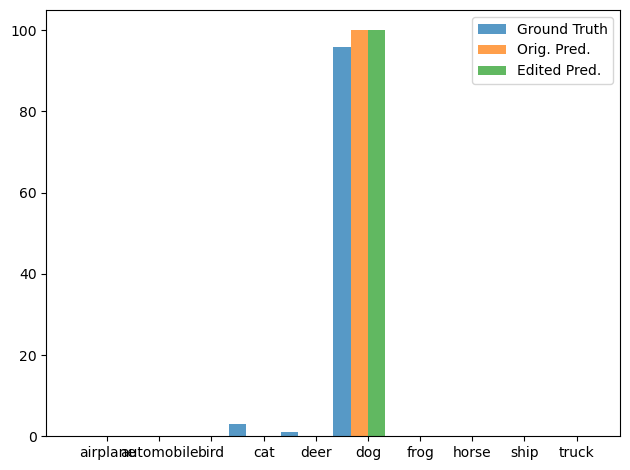

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/watershed_masked_4/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/watershed_masked_4/models
Finished trial 30/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111626_5132/watershed_masked_4
(0113_165309) Starting Trial 31/2008...
Current run_id: 0113_160154/dog-train-n02112826_3446/slic_masked_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112826_3446/slic_masked_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02112826_3446.png
Value images: saved/segmentations/dog/dog-train-n02112826_

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 33.31it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0235, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.12089932709932327 0.023476116359233856
L2 norm of weight change: 0.3145241141319275
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 27.46it/s]


Post-edit metrics: {'TP': array([6060, 5522, 5176, 2738, 4674, 3511, 5630, 5259, 4912, 4476]), 'TN': array([60521, 60868, 59498, 61829, 58719, 60913, 61187, 61393, 61510,
       61520]), 'FPs': array([2479, 2132, 3502, 1171, 4281, 2087, 1813, 1607, 1490, 1480]), 'FNs': array([ 940, 1478, 1824, 4262, 2326, 3489, 1370, 1741, 2088, 2524]), 'accuracy': 0.6851142857142857, 'per_class_accuracy': array([0.95115714, 0.94842857, 0.92391429, 0.92238571, 0.90561429,
       0.92034286, 0.95452857, 0.95217143, 0.94888571, 0.9428    ]), 'per_class_accuracy_mean': 0.9370228571428572, 'precision': array([0.70968497, 0.72145284, 0.5964508 , 0.70043489, 0.52194305,
       0.62718828, 0.75641542, 0.76594815, 0.76726023, 0.75151108]), 'precision_mean': 0.6918289715628876, 'recall': array([0.86571429, 0.78885714, 0.73942857, 0.39114286, 0.66771429,
       0.50157143, 0.80428571, 0.75128571, 0.70171429, 0.63942857]), 'recall_mean': 0.6851142857142858, 'f1': array([0.77997297, 0.75365088, 0.6602883 , 0.50197

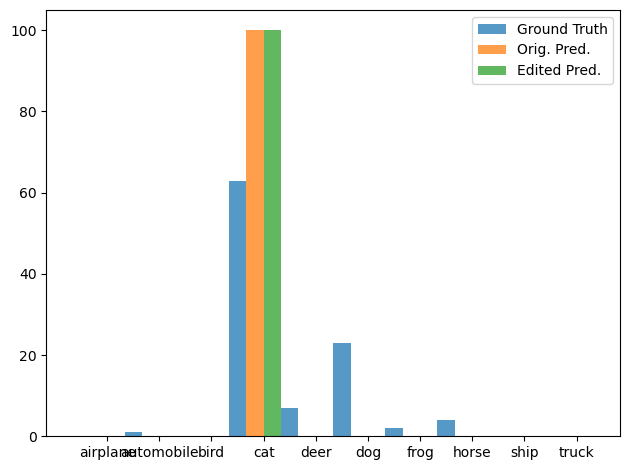

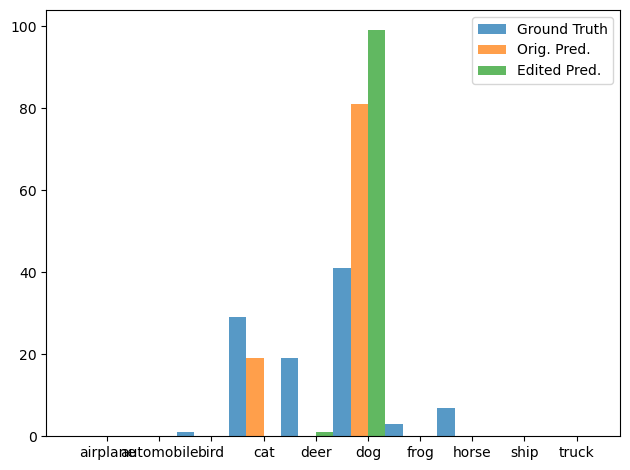

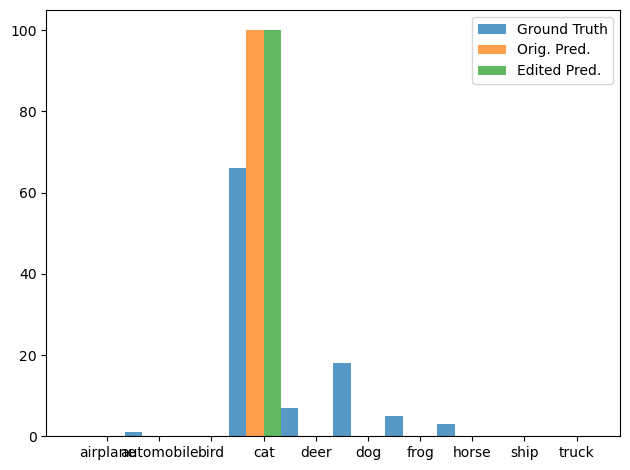

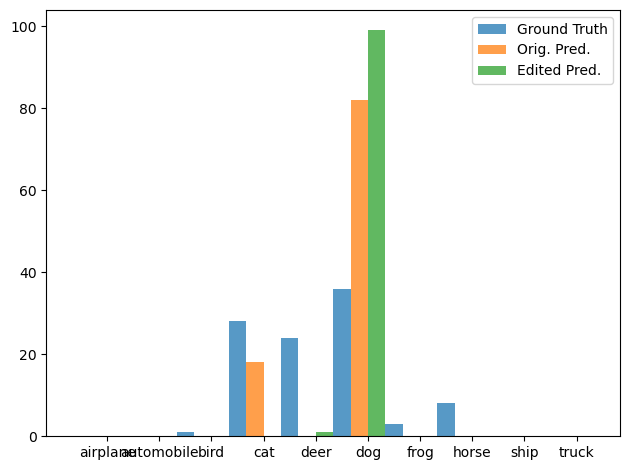

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112826_3446/slic_masked_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112826_3446/slic_masked_1/models
Finished trial 31/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112826_3446/slic_masked_1
(0113_165436) Starting Trial 32/2008...
Current run_id: 0113_160154/dog-train-n02112826_3446/watershed_gaussian_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112826_3446/watershed_gaussian_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02112826_3446.png
Value images: saved/segmentations/dog/dog-train-n02112826_3

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 31.70it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0197, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.12690559029579163 0.01974467746913433
L2 norm of weight change: 0.32237476110458374
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 27.80it/s]


Post-edit metrics: {'TP': array([6074, 5513, 5294, 2503, 4684, 3395, 5617, 5255, 4895, 4465]), 'TN': array([60445, 60871, 58945, 62098, 58524, 61167, 61199, 61377, 61520,
       61549]), 'FPs': array([2555, 2129, 4055,  902, 4476, 1833, 1801, 1623, 1480, 1451]), 'FNs': array([ 926, 1487, 1706, 4497, 2316, 3605, 1383, 1745, 2105, 2535]), 'accuracy': 0.6813571428571429, 'per_class_accuracy': array([0.95027143, 0.94834286, 0.9177    , 0.92287143, 0.90297143,
       0.92231429, 0.95451429, 0.95188571, 0.94878571, 0.94305714]), 'per_class_accuracy_mean': 0.9362714285714284, 'precision': array([0.70390544, 0.72140801, 0.56626377, 0.73509545, 0.51135371,
       0.64938791, 0.75721219, 0.76403024, 0.76784314, 0.75473293]), 'precision_mean': 0.6931232778801096, 'recall': array([0.86771429, 0.78757143, 0.75628571, 0.35757143, 0.66914286,
       0.485     , 0.80242857, 0.75071429, 0.69928571, 0.63785714]), 'recall_mean': 0.6813571428571429, 'f1': array([0.77727302, 0.7530392 , 0.64762371, 0.48111

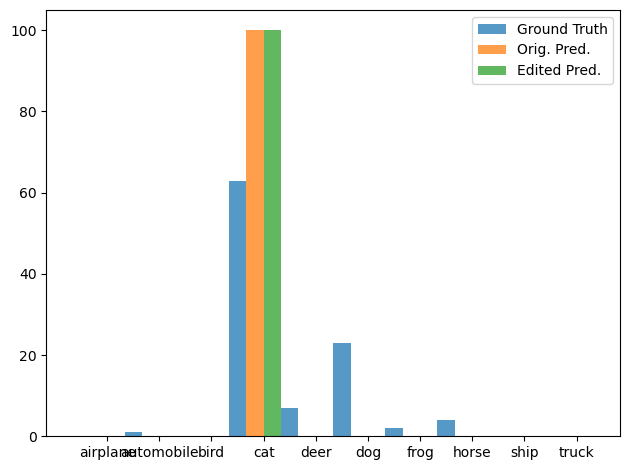

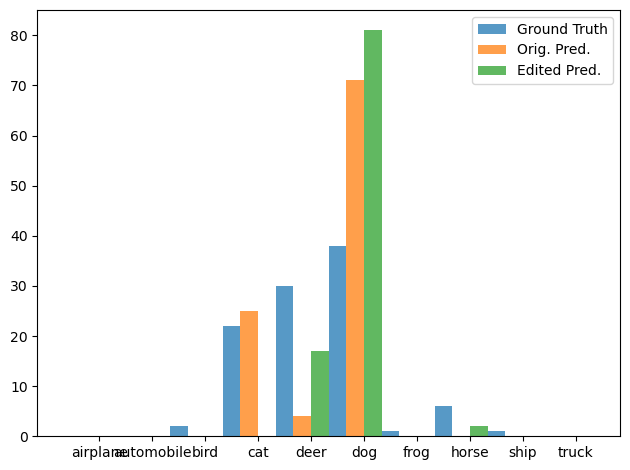

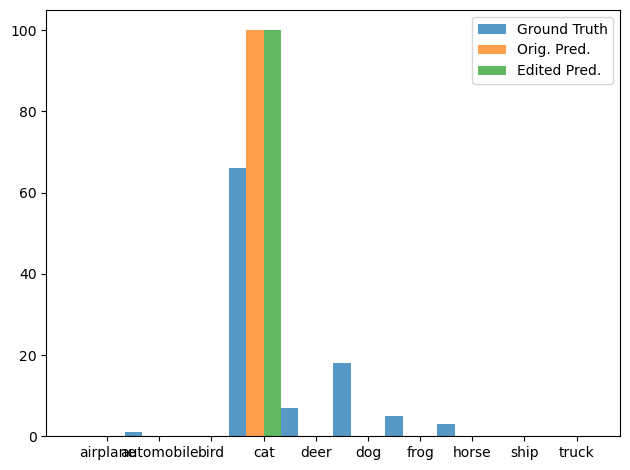

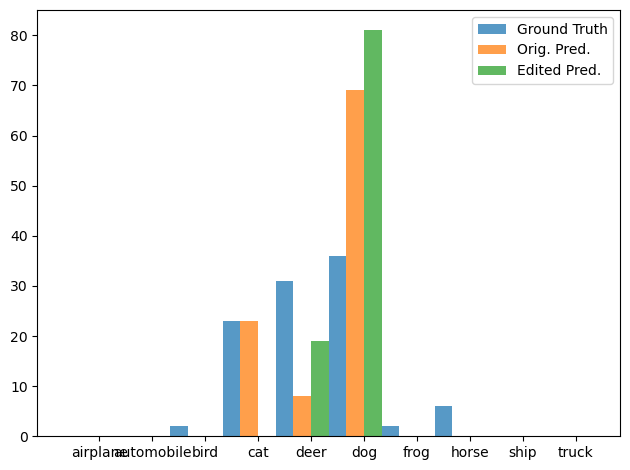

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112826_3446/watershed_gaussian_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112826_3446/watershed_gaussian_0/models
Finished trial 32/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112826_3446/watershed_gaussian_0
(0113_165604) Starting Trial 33/2008...
Current run_id: 0113_160154/dog-train-n02103406_4858/felzenszwalb_masked_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02103406_4858/felzenszwalb_masked_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02103406_4858.png
Value images: saved/segmentations/do

100%|██████████████████████████████████████████| 274/274 [00:12<00:00, 22.55it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0083, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.1391274333000183 0.008313925936818123
L2 norm of weight change: 0.4504793882369995
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:16<00:00, 16.48it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:165: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:202: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6064, 5585, 5226,    0, 4992, 3272, 5601, 5172, 4898, 4301]), 'TN': array([60501, 60743, 59239, 63000, 54184, 61394, 61235, 61563, 61498,
       61754]), 'FPs': array([2499, 2257, 3761,    0, 8816, 1606, 1765, 1437, 1502, 1246]), 'FNs': array([ 936, 1415, 1774, 7000, 2008, 3728, 1399, 1828, 2102, 2699]), 'accuracy': 0.6444428571428571, 'per_class_accuracy': array([0.95092857, 0.94754286, 0.92092857, 0.9       , 0.84537143,
       0.9238    , 0.9548    , 0.95335714, 0.94851429, 0.94364286]), 'per_class_accuracy_mean': 0.9288885714285714, 'precision': array([0.70816303, 0.71219077, 0.58150662, 0.        , 0.36152955,
       0.67076671, 0.76038556, 0.78256922, 0.7653125 , 0.77537408]), 'precision_mean': 0.6117798026184063, 'recall': array([0.86628571, 0.79785714, 0.74657143, 0.        , 0.71314286,
       0.46742857, 0.80014286, 0.73885714, 0.69971429, 0.61442857]), 'recall_mean': 0.6444428571428571, 'f1': array([0.7792842 , 0.75259399, 0.6537812 , 0.     

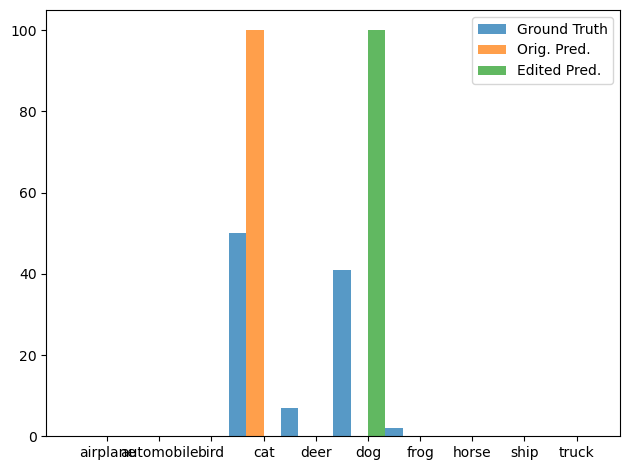

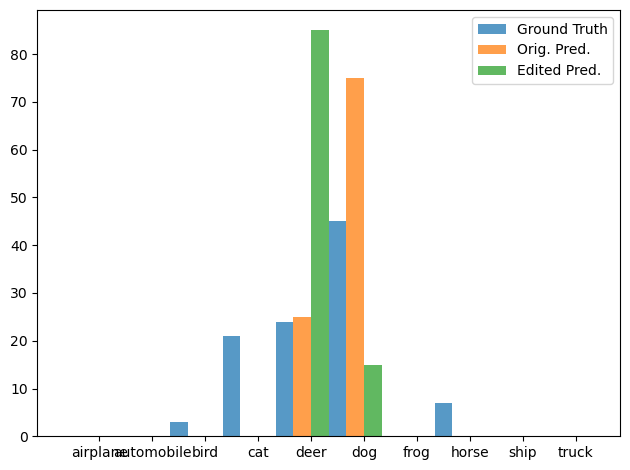

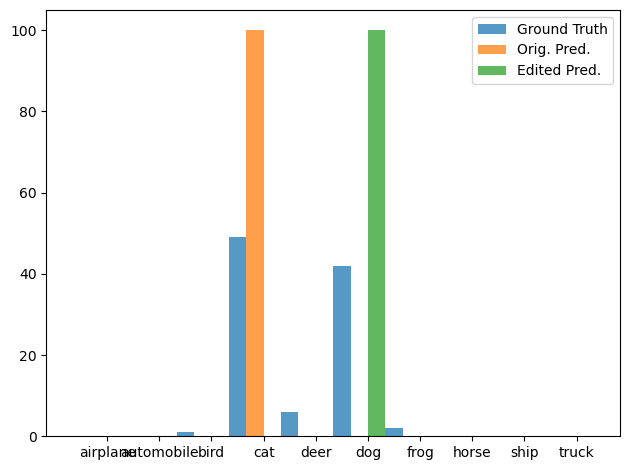

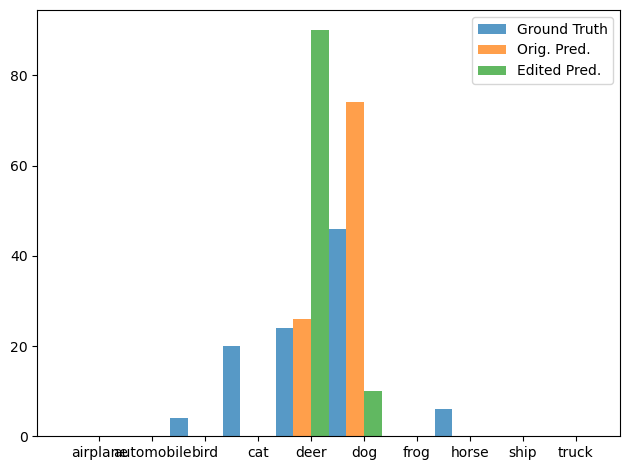

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02103406_4858/felzenszwalb_masked_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02103406_4858/felzenszwalb_masked_1/models
Finished trial 33/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02103406_4858/felzenszwalb_masked_1
(0113_165739) Starting Trial 34/2008...
Current run_id: 0113_160154/dog-train-n02103406_4858/slic_masked_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02103406_4858/slic_masked_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02103406_4858.png
Value images: saved/segmentations/dog/dog-train-n

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 32.71it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0048, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.09521959722042084 0.004757520742714405
L2 norm of weight change: 0.3023611307144165
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:13<00:00, 20.75it/s]


Post-edit metrics: {'TP': array([6021, 5636, 5224, 2464, 4471, 3951, 5681, 5139, 4979, 4347]), 'TN': array([60650, 60623, 59390, 62062, 59503, 59857, 61013, 61762, 61380,
       61673]), 'FPs': array([2350, 2377, 3610,  938, 3497, 3143, 1987, 1238, 1620, 1327]), 'FNs': array([ 979, 1364, 1776, 4536, 2529, 3049, 1319, 1861, 2021, 2653]), 'accuracy': 0.6844714285714286, 'per_class_accuracy': array([0.95244286, 0.94655714, 0.92305714, 0.9218    , 0.91391429,
       0.91154286, 0.95277143, 0.95572857, 0.94798571, 0.94314286]), 'per_class_accuracy_mean': 0.9368942857142859, 'precision': array([0.7192689 , 0.70335704, 0.5913516 , 0.72427984, 0.56111948,
       0.55694953, 0.74087115, 0.80586483, 0.75450826, 0.76612619]), 'precision_mean': 0.6923696821608376, 'recall': array([0.86014286, 0.80514286, 0.74628571, 0.352     , 0.63871429,
       0.56442857, 0.81157143, 0.73414286, 0.71128571, 0.621     ]), 'recall_mean': 0.6844714285714286, 'f1': array([0.78342333, 0.75081596, 0.6598459 , 0.47375

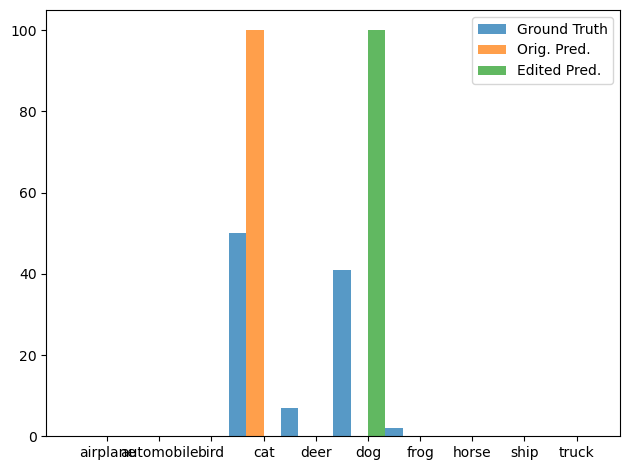

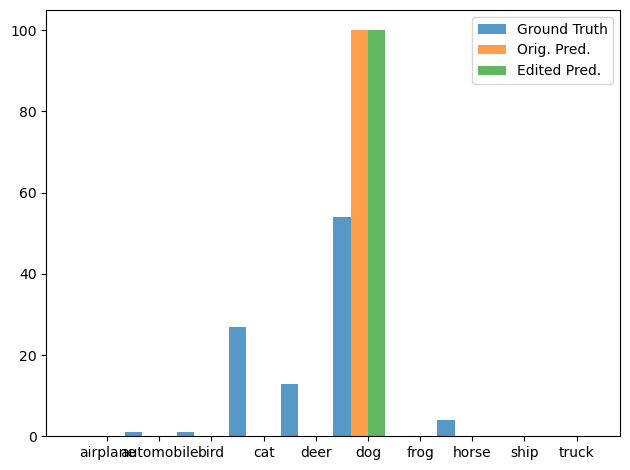

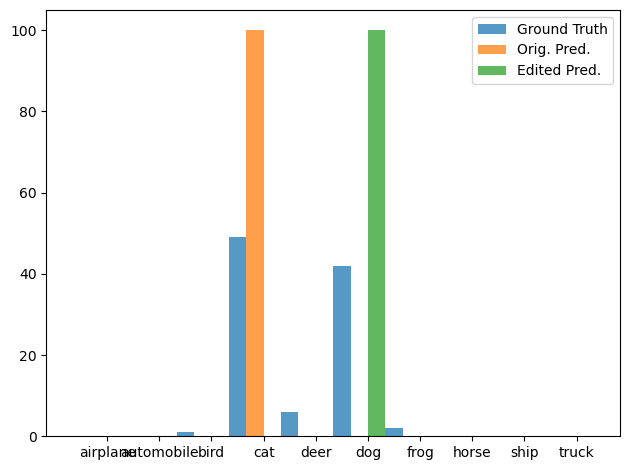

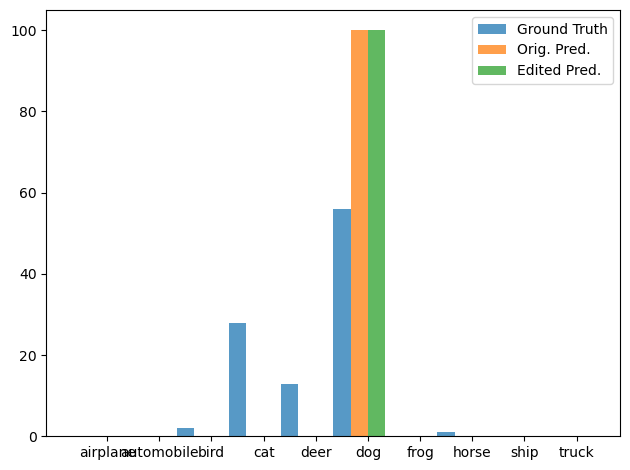

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02103406_4858/slic_masked_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02103406_4858/slic_masked_0/models
Finished trial 34/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02103406_4858/slic_masked_0
(0113_165908) Starting Trial 35/2008...
Current run_id: 0113_160154/dog-train-n02119477_5497/watershed_masked_2
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02119477_5497/watershed_masked_2
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02119477_5497.png
Value images: saved/segmentations/dog/dog-train-n02119477_5497/

100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 30.36it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0228, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.19123026728630066 0.022836098447442055
L2 norm of weight change: 0.6348828077316284
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 30.03it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:165: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:202: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6144, 5588, 5062, 4302,    0, 4120, 5570, 4826, 4508, 4586]), 'TN': array([60253, 60562, 59961, 58411, 63000, 55707, 61312, 62192, 62025,
       61283]), 'FPs': array([2747, 2438, 3039, 4589,    0, 7293, 1688,  808,  975, 1717]), 'FNs': array([ 856, 1412, 1938, 2698, 7000, 2880, 1430, 2174, 2492, 2414]), 'accuracy': 0.6386571428571428, 'per_class_accuracy': array([0.94852857, 0.945     , 0.9289    , 0.8959    , 0.9       ,
       0.85467143, 0.95545714, 0.9574    , 0.95047143, 0.94098571]), 'per_class_accuracy_mean': 0.9277314285714287, 'precision': array([0.69103588, 0.69623723, 0.62486113, 0.48386008, 0.        ,
       0.36099185, 0.76742904, 0.85658502, 0.82217764, 0.72759004]), 'precision_mean': 0.603076791067472, 'recall': array([0.87771429, 0.79828571, 0.72314286, 0.61457143, 0.        ,
       0.58857143, 0.79571429, 0.68942857, 0.644     , 0.65514286]), 'recall_mean': 0.6386571428571428, 'f1': array([0.77326789, 0.74377745, 0.67041918, 0.541438

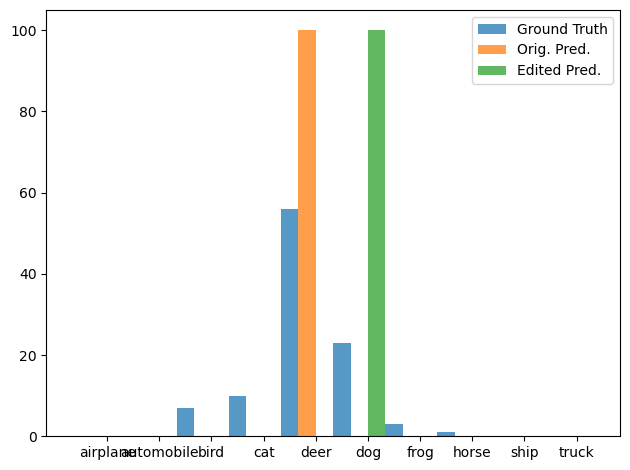

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02119477_5497/watershed_masked_2/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02119477_5497/watershed_masked_2/models
Finished trial 35/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02119477_5497/watershed_masked_2
(0113_170029) Starting Trial 36/2008...
Current run_id: 0113_160154/dog-train-n02111277_7214/slic_gaussian_3
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111277_7214/slic_gaussian_3
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02111277_7214.png
Value images: saved/segmentations/dog/dog-train-n02111

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 33.98it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.06945692002773285 0.003937556408345699
L2 norm of weight change: 0.33875858783721924
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:14<00:00, 18.77it/s]


Post-edit metrics: {'TP': array([6019, 5459, 5294, 3689, 4291, 3656, 5560, 4932, 4807, 4158]), 'TN': array([60645, 61001, 59102, 59906, 60067, 60292, 61280, 62032, 61582,
       61958]), 'FPs': array([2355, 1999, 3898, 3094, 2933, 2708, 1720,  968, 1418, 1042]), 'FNs': array([ 981, 1541, 1706, 3311, 2709, 3344, 1440, 2068, 2193, 2842]), 'accuracy': 0.6837857142857143, 'per_class_accuracy': array([0.95234286, 0.94942857, 0.91994286, 0.9085    , 0.9194    ,
       0.91354286, 0.95485714, 0.95662857, 0.94841429, 0.94451429]), 'per_class_accuracy_mean': 0.9367571428571428, 'precision': array([0.71877239, 0.73196567, 0.5759356 , 0.54385965, 0.59399225,
       0.57448146, 0.76373626, 0.8359322 , 0.77220884, 0.79961538]), 'precision_mean': 0.691049970381741, 'recall': array([0.85985714, 0.77985714, 0.75628571, 0.527     , 0.613     ,
       0.52228571, 0.79428571, 0.70457143, 0.68671429, 0.594     ]), 'recall_mean': 0.6837857142857142, 'f1': array([0.78301028, 0.75515286, 0.65390316, 0.535297

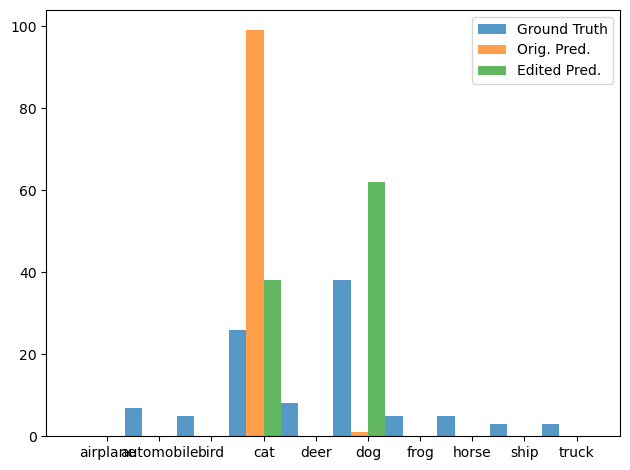

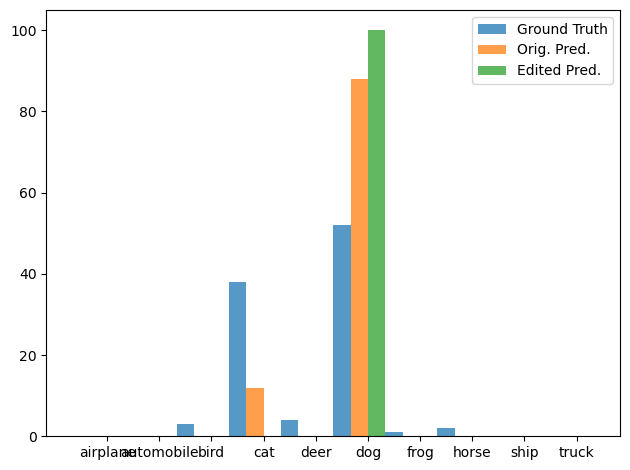

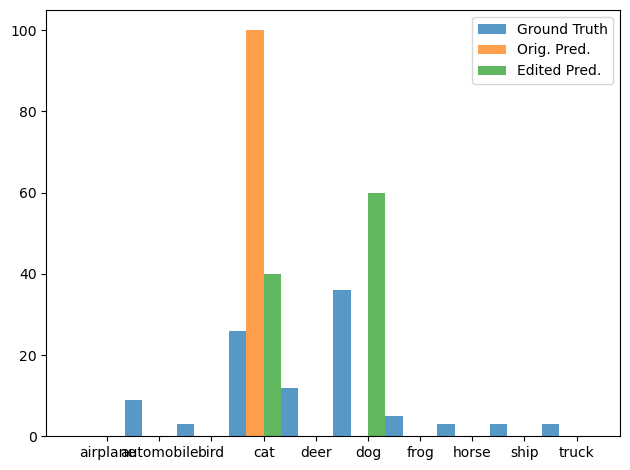

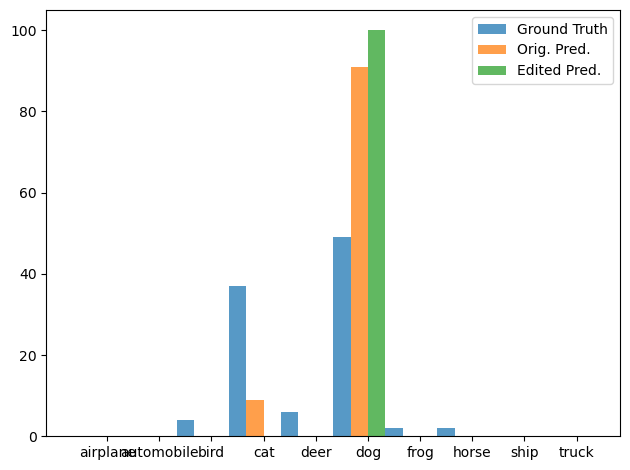

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111277_7214/slic_gaussian_3/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111277_7214/slic_gaussian_3/models
Finished trial 36/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02111277_7214/slic_gaussian_3
(0113_170157) Starting Trial 37/2008...
Current run_id: 0113_160154/dog-train-n02118333_11590/felzenszwalb_masked_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02118333_11590/felzenszwalb_masked_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02118333_11590.png
Value images: saved/segmentations/dog/dog-train-

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 32.01it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0045, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.17809882760047913 0.004463118966668844
L2 norm of weight change: 0.5802775025367737
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:11<00:00, 24.56it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:165: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:202: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([5990, 5650, 5176, 3768,    0, 4742, 5288, 4749, 4654, 4409]), 'TN': array([60786, 60489, 59669, 59909, 63000, 52962, 61938, 62228, 61842,
       61603]), 'FPs': array([ 2214,  2511,  3331,  3091,     0, 10038,  1062,   772,  1158,
        1397]), 'FNs': array([1010, 1350, 1824, 3232, 7000, 2258, 1712, 2251, 2346, 2591]), 'accuracy': 0.6346571428571428, 'per_class_accuracy': array([0.95394286, 0.94484286, 0.92635714, 0.90967143, 0.9       ,
       0.82434286, 0.96037143, 0.95681429, 0.94994286, 0.94302857]), 'per_class_accuracy_mean': 0.9269314285714285, 'precision': array([0.73013164, 0.69231712, 0.60844011, 0.54935122, 0.        ,
       0.32083897, 0.83275591, 0.86017026, 0.80075705, 0.75938684]), 'precision_mean': 0.6154149118301139, 'recall': array([0.85571429, 0.80714286, 0.73942857, 0.53828571, 0.        ,
       0.67742857, 0.75542857, 0.67842857, 0.66485714, 0.62985714]), 'recall_mean': 0.6346571428571428, 'f1': array([0.78795054, 0.74533342, 0.

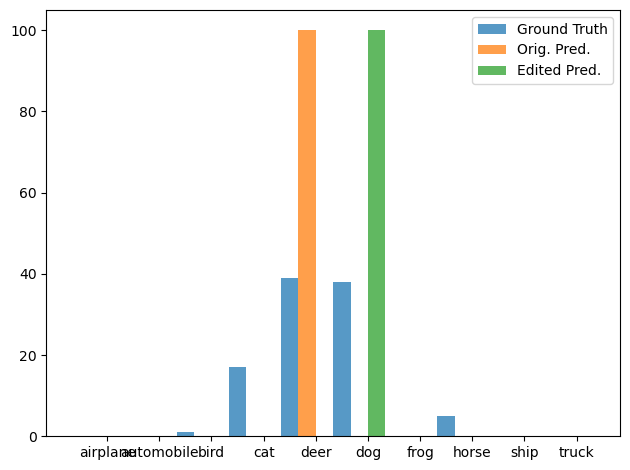

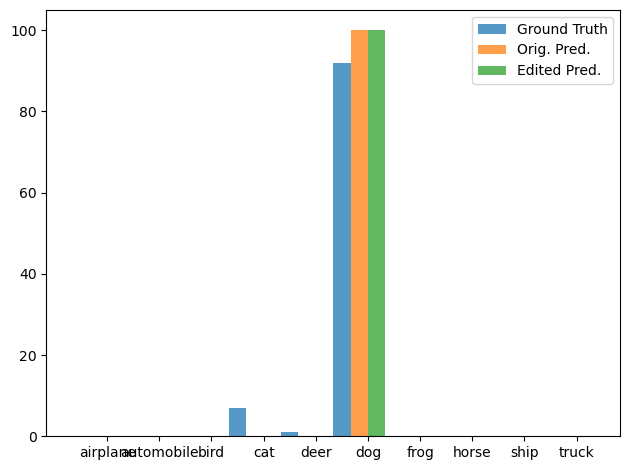

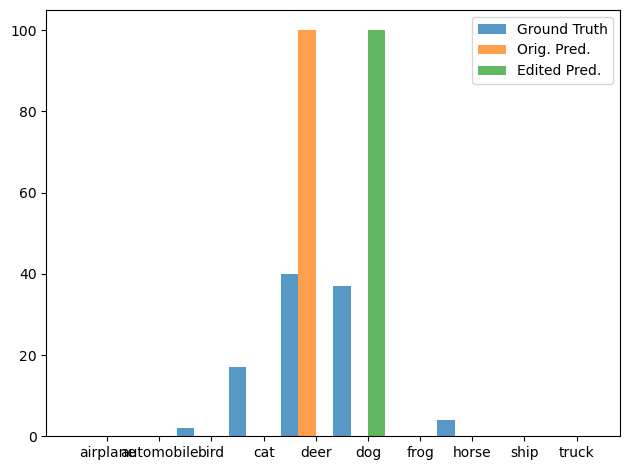

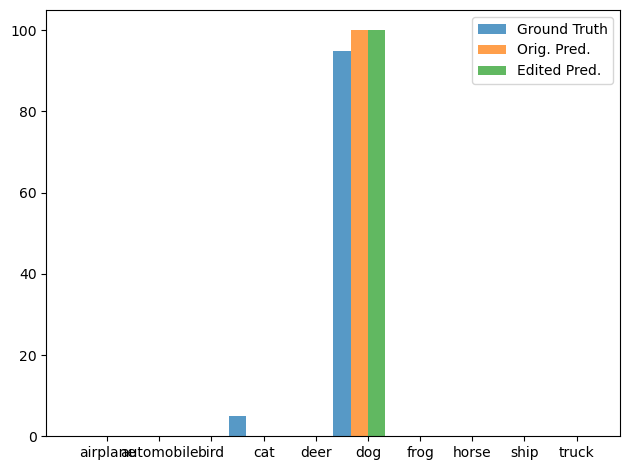

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02118333_11590/felzenszwalb_masked_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02118333_11590/felzenszwalb_masked_1/models
Finished trial 37/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02118333_11590/felzenszwalb_masked_1
(0113_170324) Starting Trial 38/2008...
Current run_id: 0113_160154/dog-train-n02118333_11590/felzenszwalb_masked_2
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02118333_11590/felzenszwalb_masked_2
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02118333_11590.png
Value images: saved/segment

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 33.34it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.06940013915300369 0.0035552550107240677
L2 norm of weight change: 0.209297776222229
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:10<00:00, 25.62it/s]


Post-edit metrics: {'TP': array([6085, 5500, 5253, 3922, 3766, 3433, 5616, 5176, 4833, 4565]), 'TN': array([60349, 60889, 59319, 59672, 61195, 60859, 61168, 61712, 61619,
       61367]), 'FPs': array([2651, 2111, 3681, 3328, 1805, 2141, 1832, 1288, 1381, 1633]), 'FNs': array([ 915, 1500, 1747, 3078, 3234, 3567, 1384, 1824, 2167, 2435]), 'accuracy': 0.6878428571428571, 'per_class_accuracy': array([0.94905714, 0.94841429, 0.92245714, 0.90848571, 0.92801429,
       0.91845714, 0.95405714, 0.95554286, 0.94931429, 0.94188571]), 'per_class_accuracy_mean': 0.9375685714285714, 'precision': array([0.69654304, 0.72263829, 0.58797851, 0.54096552, 0.67600072,
       0.61589523, 0.75402793, 0.80074257, 0.7777599 , 0.73652791]), 'precision_mean': 0.6909079609592926, 'recall': array([0.86928571, 0.78571429, 0.75042857, 0.56028571, 0.538     ,
       0.49042857, 0.80228571, 0.73942857, 0.69042857, 0.65214286]), 'recall_mean': 0.6878428571428572, 'f1': array([0.77338587, 0.75285744, 0.6593448 , 0.55045

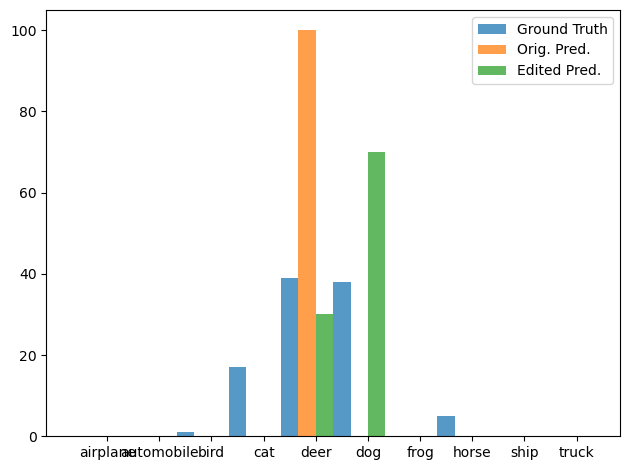

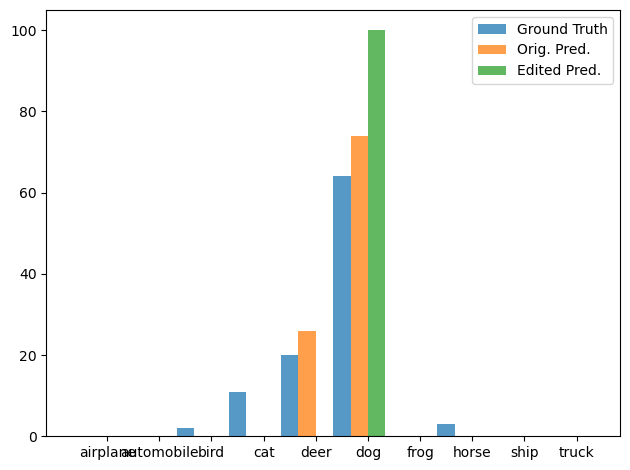

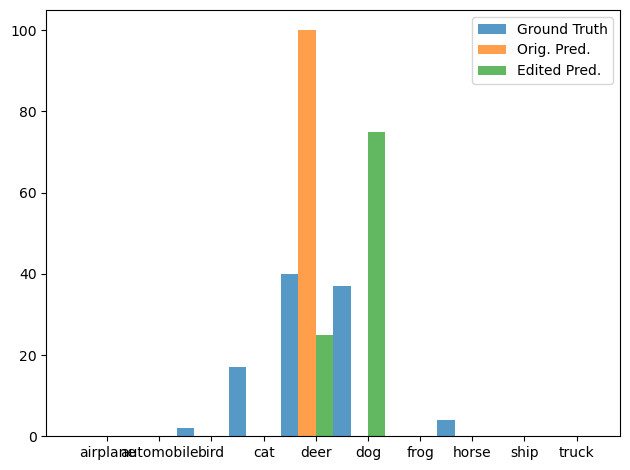

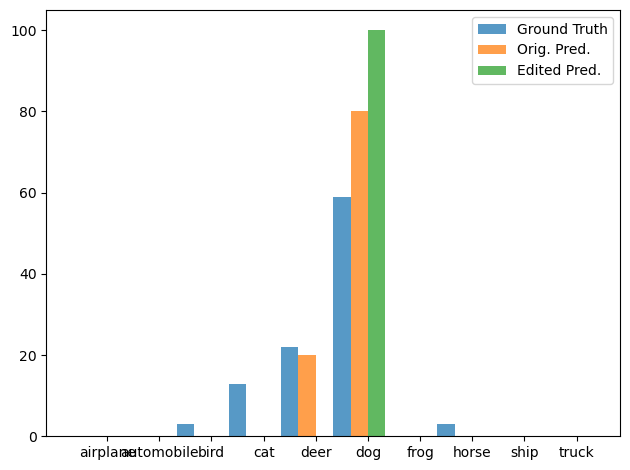

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02118333_11590/felzenszwalb_masked_2/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02118333_11590/felzenszwalb_masked_2/models
Finished trial 38/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02118333_11590/felzenszwalb_masked_2
(0113_170452) Starting Trial 39/2008...
Current run_id: 0113_160154/dog-train-n02118333_11590/quickshift_masked_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02118333_11590/quickshift_masked_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02118333_11590.png
Value images: saved/segmentatio

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 34.16it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0055, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.15991465747356415 0.00548359053209424
L2 norm of weight change: 0.48123589158058167
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 28.19it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:165: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:202: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6011, 5626, 5193, 3813,    0, 4616, 5383, 4886, 4723, 4441]), 'TN': array([60717, 60575, 59604, 59849, 63000, 53724, 61759, 62116, 61784,
       61564]), 'FPs': array([2283, 2425, 3396, 3151,    0, 9276, 1241,  884, 1216, 1436]), 'FNs': array([ 989, 1374, 1807, 3187, 7000, 2384, 1617, 2114, 2277, 2559]), 'accuracy': 0.6384571428571428, 'per_class_accuracy': array([0.95325714, 0.94572857, 0.92567143, 0.90945714, 0.9       ,
       0.83342857, 0.95917143, 0.95717143, 0.9501    , 0.94292857]), 'per_class_accuracy_mean': 0.9276914285714286, 'precision': array([0.72474078, 0.69879518, 0.60461055, 0.54753016, 0.        ,
       0.33227757, 0.81265097, 0.84679376, 0.79525173, 0.75565765]), 'precision_mean': 0.6118308331826621, 'recall': array([0.85871429, 0.80371429, 0.74185714, 0.54471429, 0.        ,
       0.65942857, 0.769     , 0.698     , 0.67471429, 0.63442857]), 'recall_mean': 0.638457142857143, 'f1': array([0.78605989, 0.74759152, 0.66623901, 0.546118

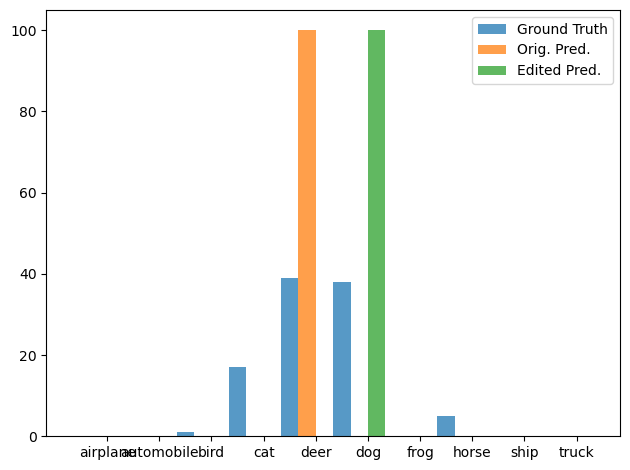

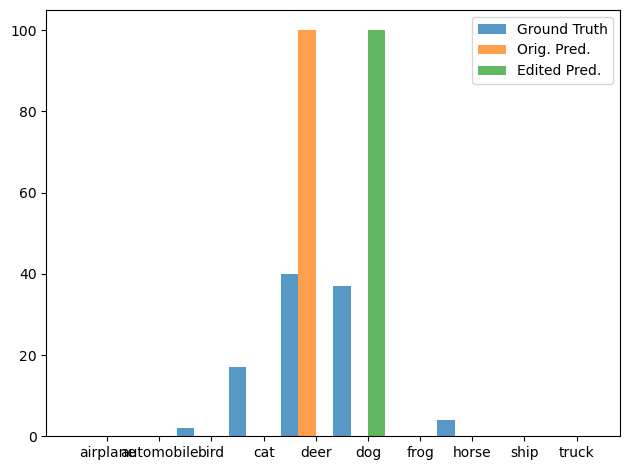

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02118333_11590/quickshift_masked_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02118333_11590/quickshift_masked_0/models
Finished trial 39/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02118333_11590/quickshift_masked_0
(0113_170617) Starting Trial 40/2008...
Current run_id: 0113_160154/dog-train-n02118333_11590/slic_masked_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02118333_11590/slic_masked_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02118333_11590.png
Value images: saved/segmentations/dog/dog-train-n

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 34.13it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.11208995431661606 0.004252108279615641
L2 norm of weight change: 0.3244897127151489
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:17<00:00, 15.85it/s]


Post-edit metrics: {'TP': array([6051, 5569, 5253, 3852, 1616, 4222, 5556, 5132, 4796, 4512]), 'TN': array([60546, 60744, 59415, 59722, 62887, 56926, 61343, 61817, 61689,
       61470]), 'FPs': array([2454, 2256, 3585, 3278,  113, 6074, 1657, 1183, 1311, 1530]), 'FNs': array([ 949, 1431, 1747, 3148, 5384, 2778, 1444, 1868, 2204, 2488]), 'accuracy': 0.6651285714285714, 'per_class_accuracy': array([0.95138571, 0.94732857, 0.92382857, 0.9082    , 0.92147143,
       0.87354286, 0.9557    , 0.95641429, 0.94978571, 0.9426    ]), 'per_class_accuracy_mean': 0.9330257142857142, 'precision': array([0.71146384, 0.71169329, 0.59436524, 0.54025245, 0.9346443 ,
       0.41006216, 0.77027589, 0.81266825, 0.78532831, 0.74677259]), 'precision_mean': 0.7017526338663347, 'recall': array([0.86442857, 0.79557143, 0.75042857, 0.55028571, 0.23085714,
       0.60314286, 0.79371429, 0.73314286, 0.68514286, 0.64457143]), 'recall_mean': 0.6651285714285715, 'f1': array([0.78052241, 0.75129848, 0.66334133, 0.54522

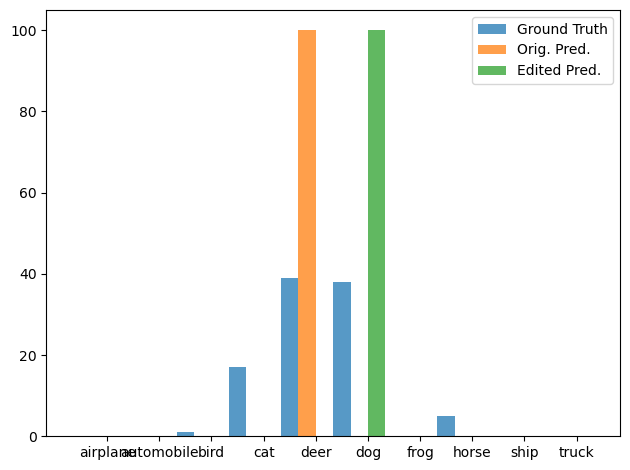

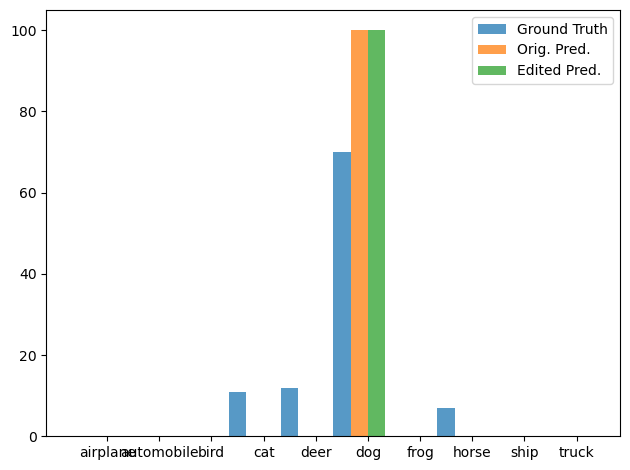

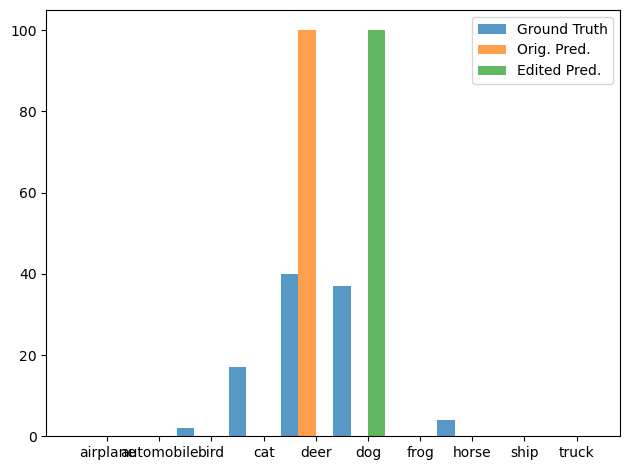

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02118333_11590/slic_masked_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02118333_11590/slic_masked_1/models
Finished trial 40/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02118333_11590/slic_masked_1
(0113_170749) Starting Trial 41/2008...
Current run_id: 0113_160154/dog-train-n02083346_1346/slic_masked_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02083346_1346/slic_masked_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02083346_1346.png
Value images: saved/segmentations/dog/dog-train-n02083346_1346/modifie

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 31.56it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0120, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.0734064057469368 0.012044556438922882
L2 norm of weight change: 0.21192188560962677
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:18<00:00, 15.20it/s]


Post-edit metrics: {'TP': array([6051, 5545, 5480, 3535, 3953, 3451, 5565, 5179, 4812, 4446]), 'TN': array([60489, 60817, 58264, 60491, 60816, 61014, 61202, 61712, 61643,
       61569]), 'FPs': array([2511, 2183, 4736, 2509, 2184, 1986, 1798, 1288, 1357, 1431]), 'FNs': array([ 949, 1455, 1520, 3465, 3047, 3549, 1435, 1821, 2188, 2554]), 'accuracy': 0.6859571428571428, 'per_class_accuracy': array([0.95057143, 0.94802857, 0.91062857, 0.91465714, 0.92527143,
       0.92092857, 0.95381429, 0.95558571, 0.94935714, 0.94307143]), 'per_class_accuracy_mean': 0.9371914285714287, 'precision': array([0.7067274 , 0.7175207 , 0.53641347, 0.58487756, 0.64412579,
       0.63472503, 0.75580606, 0.80083501, 0.78002918, 0.75650842]), 'precision_mean': 0.6917568630849512, 'recall': array([0.86442857, 0.79214286, 0.78285714, 0.505     , 0.56471429,
       0.493     , 0.795     , 0.73985714, 0.68742857, 0.63514286]), 'recall_mean': 0.6859571428571429, 'f1': array([0.77766354, 0.75298751, 0.6366171 , 0.54201

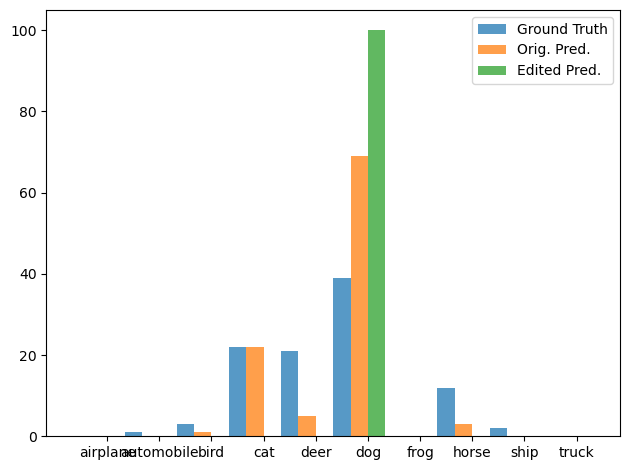

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02083346_1346/slic_masked_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02083346_1346/slic_masked_0/models
Finished trial 41/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02083346_1346/slic_masked_0
(0113_170925) Starting Trial 42/2008...
Current run_id: 0113_160154/dog-train-n02112018_292/felzenszwalb_masked_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/felzenszwalb_masked_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02112018_292.png
Value images: saved/segmentations/dog/dog-train-n02112018_29

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 33.46it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0073, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.08866368234157562 0.00728304497897625
L2 norm of weight change: 0.2973545491695404
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 27.74it/s]


Post-edit metrics: {'TP': array([6106, 5562, 5461, 2900, 4280, 3308, 5559, 5407, 4698, 4493]), 'TN': array([60285, 60753, 58283, 61639, 59992, 61317, 61214, 61019, 61784,
       61488]), 'FPs': array([2715, 2247, 4717, 1361, 3008, 1683, 1786, 1981, 1216, 1512]), 'FNs': array([ 894, 1438, 1539, 4100, 2720, 3692, 1441, 1593, 2302, 2507]), 'accuracy': 0.6824857142857143, 'per_class_accuracy': array([0.94844286, 0.94735714, 0.91062857, 0.92198571, 0.91817143,
       0.92321429, 0.9539    , 0.94894286, 0.94974286, 0.94258571]), 'per_class_accuracy_mean': 0.9364971428571429, 'precision': array([0.69221177, 0.71225509, 0.53654942, 0.68059141, 0.58726674,
       0.66279303, 0.75684139, 0.73186248, 0.7943862 , 0.74820983]), 'precision_mean': 0.6902967351509157, 'recall': array([0.87228571, 0.79457143, 0.78014286, 0.41428571, 0.61142857,
       0.47257143, 0.79414286, 0.77242857, 0.67114286, 0.64185714]), 'recall_mean': 0.6824857142857143, 'f1': array([0.77188547, 0.75116483, 0.63581325, 0.51505

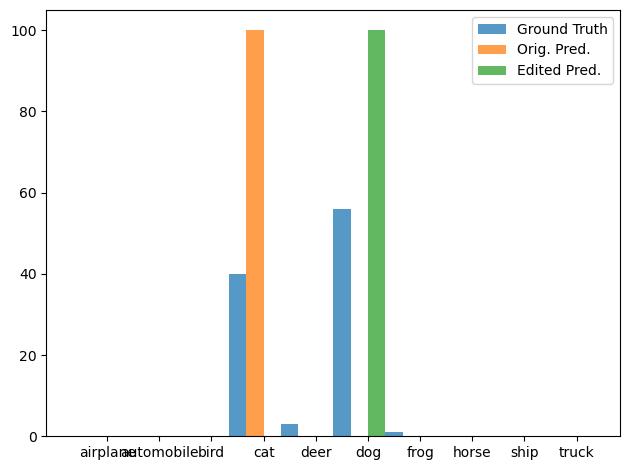

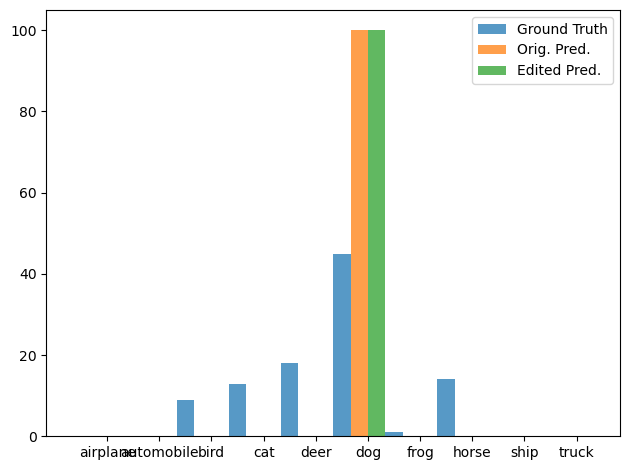

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/felzenszwalb_masked_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/felzenszwalb_masked_1/models
Finished trial 42/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/felzenszwalb_masked_1
(0113_171050) Starting Trial 43/2008...
Current run_id: 0113_160154/dog-train-n02112018_292/quickshift_gaussian_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/quickshift_gaussian_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02112018_292.png
Value images: saved/segmentations/dog/d

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 33.92it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.0267549566924572 0.0030913972295820713
L2 norm of weight change: 0.14660553634166718
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 28.69it/s]


Post-edit metrics: {'TP': array([6095, 5484, 5190, 3596, 4278, 3290, 5673, 5156, 4884, 4587]), 'TN': array([60330, 60925, 59552, 60385, 60123, 61304, 61028, 61700, 61561,
       61325]), 'FPs': array([2670, 2075, 3448, 2615, 2877, 1696, 1972, 1300, 1439, 1675]), 'FNs': array([ 905, 1516, 1810, 3404, 2722, 3710, 1327, 1844, 2116, 2413]), 'accuracy': 0.6890428571428572, 'per_class_accuracy': array([0.94892857, 0.9487    , 0.92488571, 0.91401429, 0.92001429,
       0.92277143, 0.95287143, 0.95508571, 0.94921429, 0.9416    ]), 'per_class_accuracy_mean': 0.9378085714285713, 'precision': array([0.69537935, 0.72549279, 0.60083353, 0.57897279, 0.59790356,
       0.65984757, 0.74205363, 0.79863693, 0.77241816, 0.73251357]), 'precision_mean': 0.6904051879964073, 'recall': array([0.87071429, 0.78342857, 0.74142857, 0.51371429, 0.61114286,
       0.47      , 0.81042857, 0.73657143, 0.69771429, 0.65528571]), 'recall_mean': 0.6890428571428571, 'f1': array([0.77323184, 0.75334844, 0.66376775, 0.54439

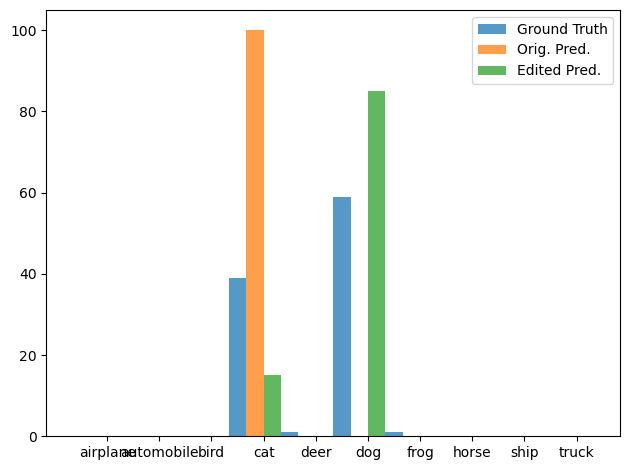

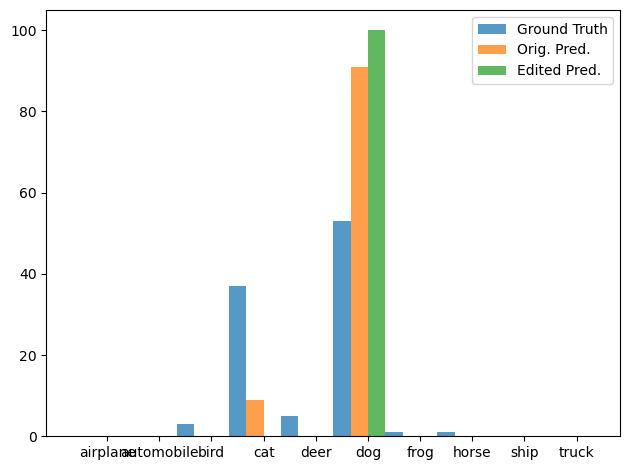

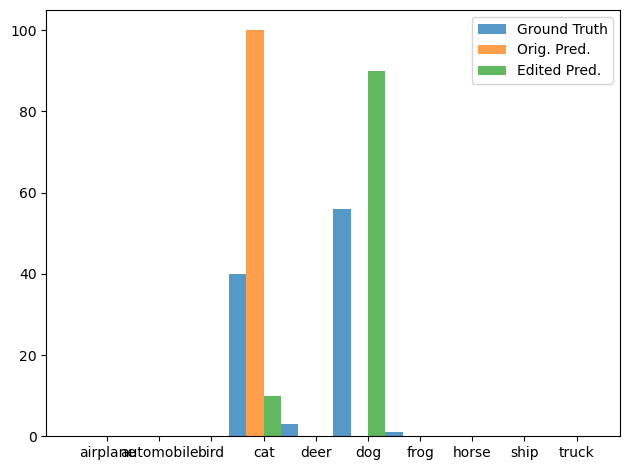

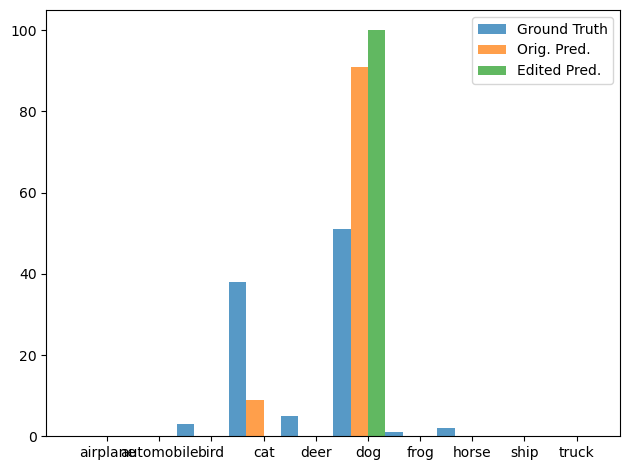

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/quickshift_gaussian_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/quickshift_gaussian_0/models
Finished trial 43/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/quickshift_gaussian_0
(0113_171217) Starting Trial 44/2008...
Current run_id: 0113_160154/dog-train-n02112018_292/quickshift_gaussian_3
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/quickshift_gaussian_3
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02112018_292.png
Value images: saved/segmentations/dog/d

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 33.75it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.032103508710861206 0.0036078840494155884
L2 norm of weight change: 0.1485571563243866
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 29.92it/s]


Post-edit metrics: {'TP': array([6081, 5482, 5224, 3534, 4289, 3290, 5663, 5152, 4916, 4580]), 'TN': array([60370, 60932, 59380, 60504, 60086, 61328, 61042, 61735, 61502,
       61332]), 'FPs': array([2630, 2068, 3620, 2496, 2914, 1672, 1958, 1265, 1498, 1668]), 'FNs': array([ 919, 1518, 1776, 3466, 2711, 3710, 1337, 1848, 2084, 2420]), 'accuracy': 0.6887285714285715, 'per_class_accuracy': array([0.9493    , 0.94877143, 0.92291429, 0.91482857, 0.91964286,
       0.92311429, 0.95292857, 0.95552857, 0.94882857, 0.9416    ]), 'per_class_accuracy_mean': 0.9377457142857141, 'precision': array([0.69808288, 0.72609272, 0.59068295, 0.58606965, 0.59544634,
       0.6630391 , 0.74307834, 0.80286738, 0.76644839, 0.73303457]), 'precision_mean': 0.6904842323404978, 'recall': array([0.86871429, 0.78314286, 0.74628571, 0.50485714, 0.61271429,
       0.47      , 0.809     , 0.736     , 0.70228571, 0.65428571]), 'recall_mean': 0.6887285714285714, 'f1': array([0.77410731, 0.75353952, 0.65942944, 0.54244

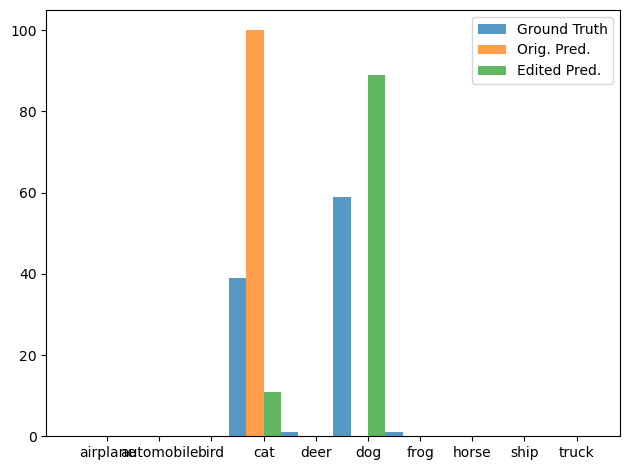

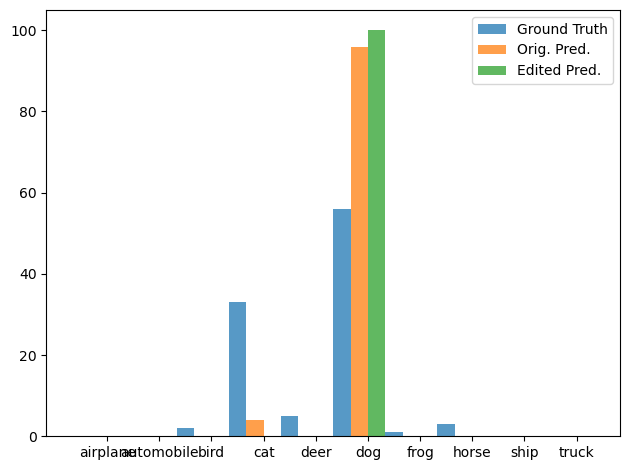

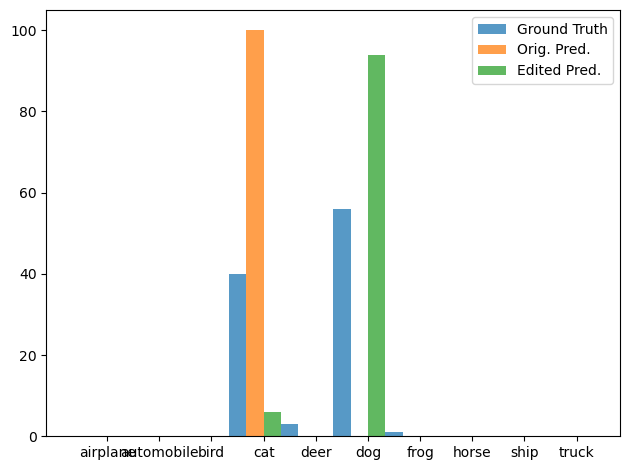

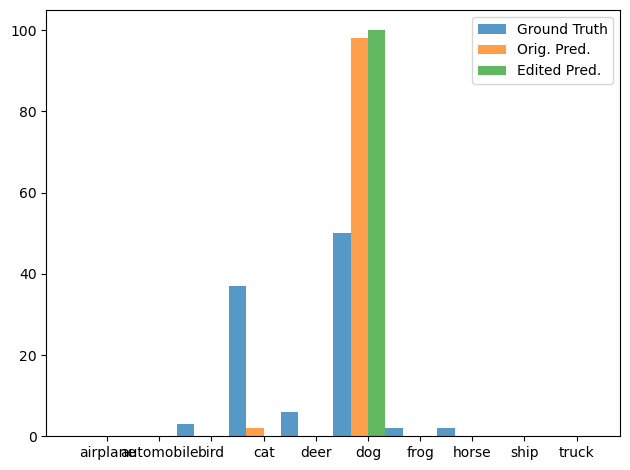

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/quickshift_gaussian_3/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/quickshift_gaussian_3/models
Finished trial 44/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/quickshift_gaussian_3
(0113_171341) Starting Trial 45/2008...
Current run_id: 0113_160154/dog-train-n02112018_292/quickshift_masked_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/quickshift_masked_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02112018_292.png
Value images: saved/segmentations/dog/dog-t

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 32.70it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.0938602164387703 0.004147006198763847
L2 norm of weight change: 0.35806038975715637
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 29.77it/s]


Post-edit metrics: {'TP': array([5986, 5727, 5358,  861, 4228, 4488, 5611, 5131, 4916, 4215]), 'TN': array([60736, 60341, 58894, 62798, 60220, 57250, 61180, 61812, 61483,
       61807]), 'FPs': array([2264, 2659, 4106,  202, 2780, 5750, 1820, 1188, 1517, 1193]), 'FNs': array([1014, 1273, 1642, 6139, 2772, 2512, 1389, 1869, 2084, 2785]), 'accuracy': 0.6645857142857143, 'per_class_accuracy': array([0.95317143, 0.94382857, 0.91788571, 0.90941429, 0.92068571,
       0.88197143, 0.95415714, 0.95632857, 0.94855714, 0.94317143]), 'per_class_accuracy_mean': 0.9329171428571428, 'precision': array([0.72557576, 0.68292392, 0.56614539, 0.80997178, 0.6033105 ,
       0.43836687, 0.75508007, 0.81199557, 0.76418467, 0.77940089]), 'precision_mean': 0.6936955419514781, 'recall': array([0.85514286, 0.81814286, 0.76542857, 0.123     , 0.604     ,
       0.64114286, 0.80157143, 0.733     , 0.70228571, 0.60214286]), 'recall_mean': 0.6645857142857142, 'f1': array([0.78504918, 0.744443  , 0.65087464, 0.21356

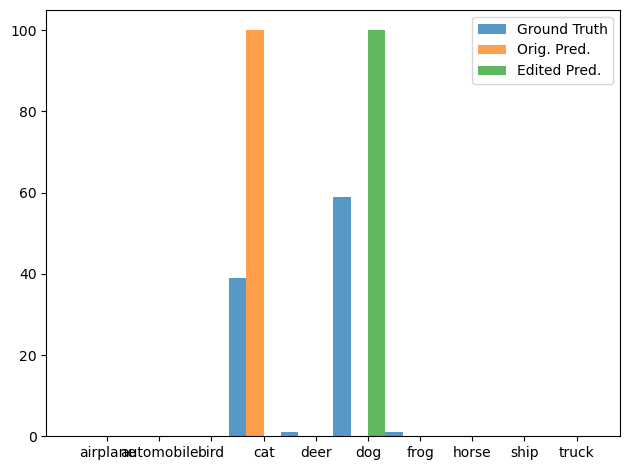

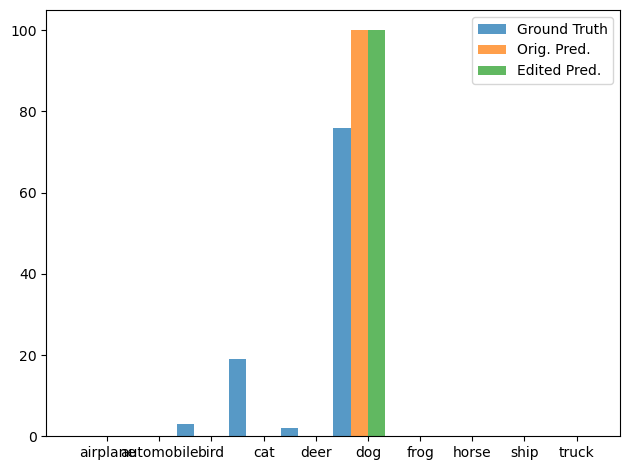

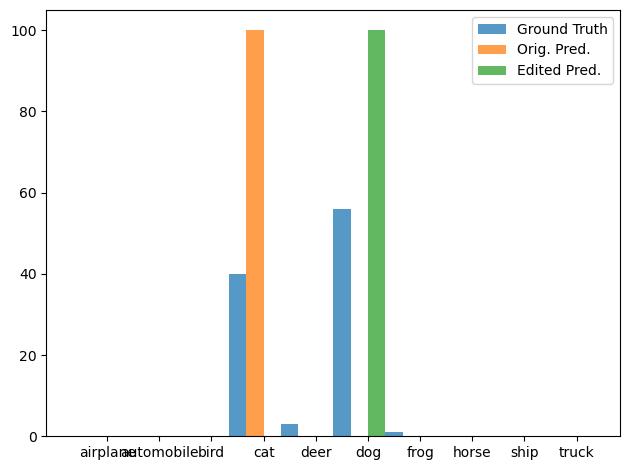

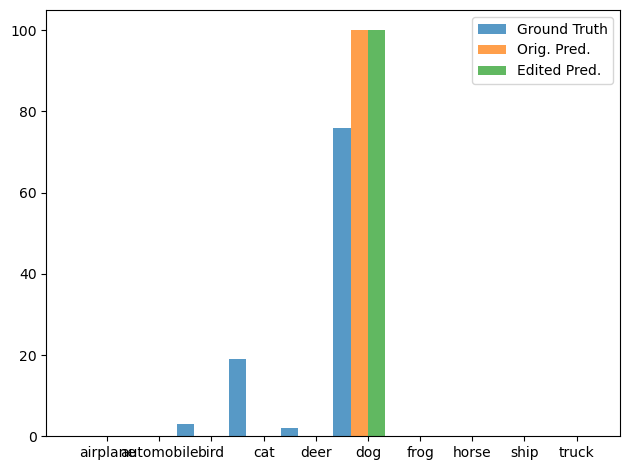

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/quickshift_masked_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/quickshift_masked_1/models
Finished trial 45/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/quickshift_masked_1
(0113_171507) Starting Trial 46/2008...
Current run_id: 0113_160154/dog-train-n02112018_292/slic_gaussian_4
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/slic_gaussian_4
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02112018_292.png
Value images: saved/segmentations/dog/dog-train-n02112018

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 32.44it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.042563535273075104 0.003518914571031928
L2 norm of weight change: 0.17836059629917145
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 29.30it/s]


Post-edit metrics: {'TP': array([6068, 5522, 5225, 3417, 4296, 3414, 5661, 5148, 4930, 4530]), 'TN': array([60422, 60849, 59394, 60726, 60049, 61116, 61033, 61743, 61477,
       61402]), 'FPs': array([2578, 2151, 3606, 2274, 2951, 1884, 1967, 1257, 1523, 1598]), 'FNs': array([ 932, 1478, 1775, 3583, 2704, 3586, 1339, 1852, 2070, 2470]), 'accuracy': 0.6887285714285715, 'per_class_accuracy': array([0.94985714, 0.94815714, 0.92312857, 0.91632857, 0.91921429,
       0.92185714, 0.95277143, 0.95558571, 0.94867143, 0.94188571]), 'per_class_accuracy_mean': 0.9377457142857143, 'precision': array([0.70182743, 0.71966636, 0.59166572, 0.60042172, 0.59279702,
       0.64439411, 0.74213424, 0.80374707, 0.76398574, 0.73922977]), 'precision_mean': 0.6899869192130758, 'recall': array([0.86685714, 0.78885714, 0.74642857, 0.48814286, 0.61371429,
       0.48771429, 0.80871429, 0.73542857, 0.70428571, 0.64714286]), 'recall_mean': 0.6887285714285715, 'f1': array([0.77566151, 0.75267498, 0.66009728, 0.53849

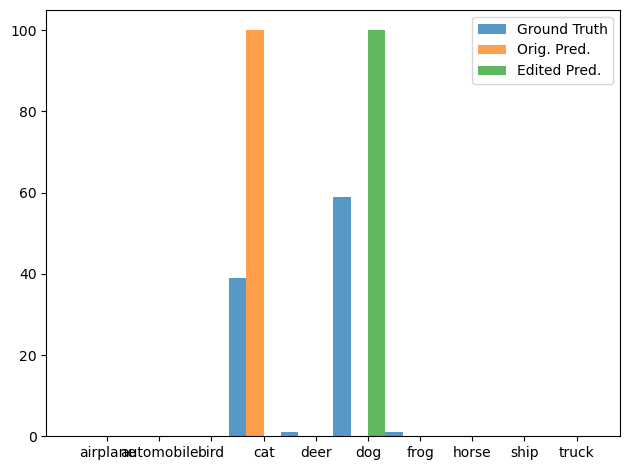

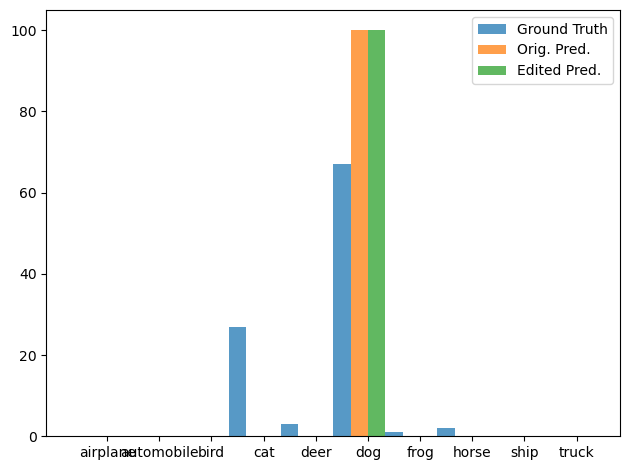

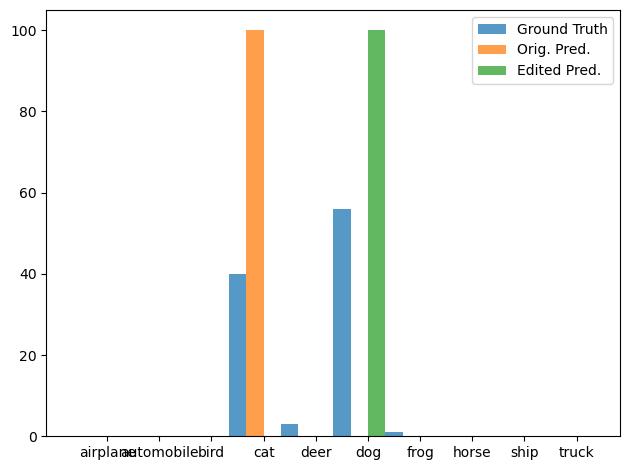

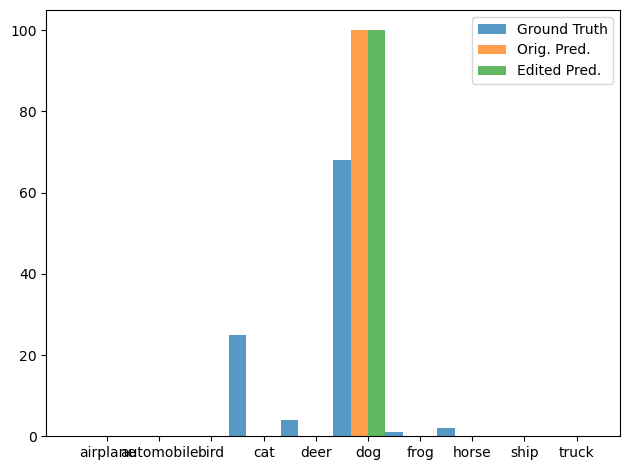

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/slic_gaussian_4/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/slic_gaussian_4/models
Finished trial 46/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/slic_gaussian_4
(0113_171633) Starting Trial 47/2008...
Current run_id: 0113_160154/dog-train-n02112018_292/slic_masked_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/slic_masked_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02112018_292.png
Value images: saved/segmentations/dog/dog-train-n02112018_292/modified_im

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 32.33it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.07469931244850159 0.0034480676986277103
L2 norm of weight change: 0.2920798659324646
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 28.49it/s]


Post-edit metrics: {'TP': array([6031, 5661, 5247, 2803, 4246, 4035, 5624, 5147, 4914, 4352]), 'TN': array([60632, 60545, 59312, 61653, 60172, 59690, 61154, 61755, 61483,
       61664]), 'FPs': array([2368, 2455, 3688, 1347, 2828, 3310, 1846, 1245, 1517, 1336]), 'FNs': array([ 969, 1339, 1753, 4197, 2754, 2965, 1376, 1853, 2086, 2648]), 'accuracy': 0.6865714285714286, 'per_class_accuracy': array([0.95232857, 0.9458    , 0.92227143, 0.9208    , 0.92025714,
       0.91035714, 0.95397143, 0.95574286, 0.94852857, 0.94308571]), 'per_class_accuracy_mean': 0.9373142857142858, 'precision': array([0.71806167, 0.69751109, 0.58724119, 0.67542169, 0.60022618,
       0.5493533 , 0.75287818, 0.80522528, 0.76411134, 0.76511955]), 'precision_mean': 0.6915149464886179, 'recall': array([0.86157143, 0.80871429, 0.74957143, 0.40042857, 0.60657143,
       0.57642857, 0.80342857, 0.73528571, 0.702     , 0.62171429]), 'recall_mean': 0.6865714285714286, 'f1': array([0.78329762, 0.74900767, 0.65855036, 0.50278

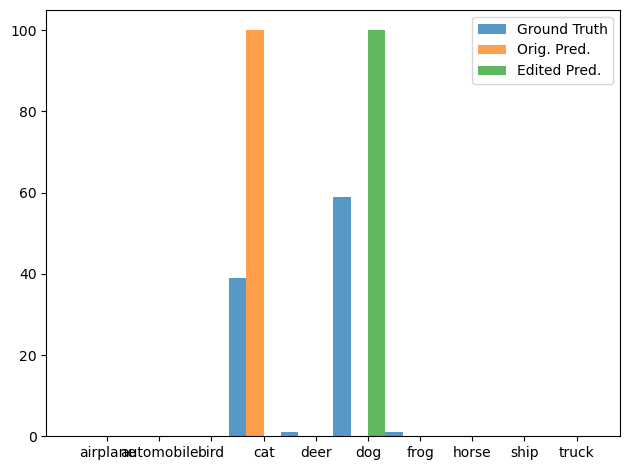

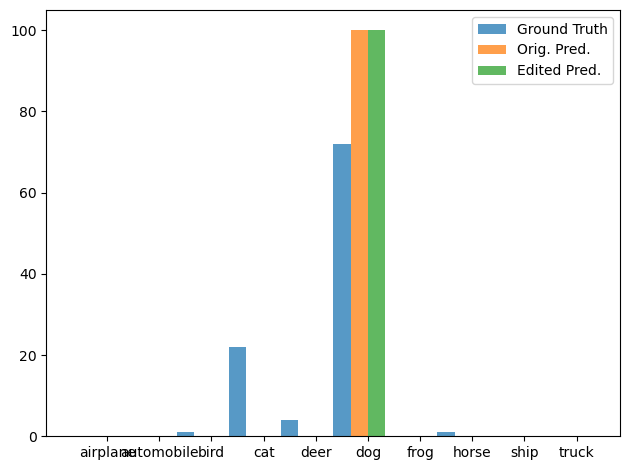

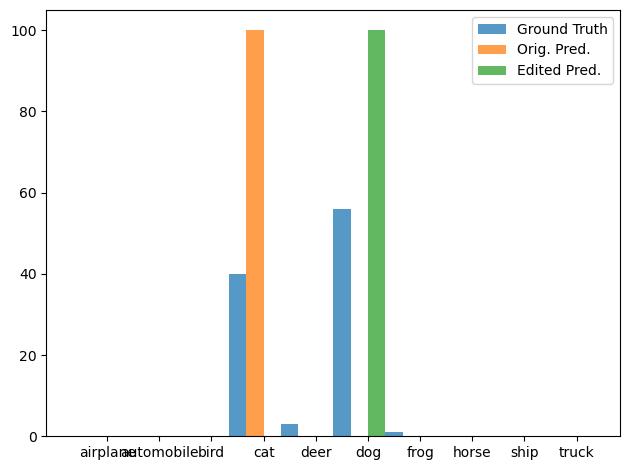

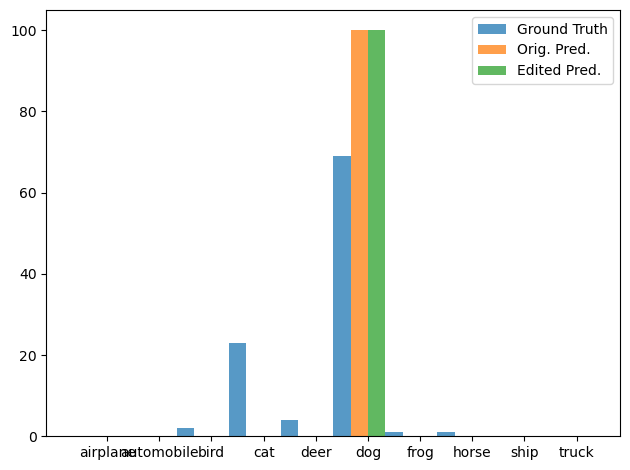

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/slic_masked_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/slic_masked_0/models
Finished trial 47/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/slic_masked_0
(0113_171801) Starting Trial 48/2008...
Current run_id: 0113_160154/dog-train-n02112018_292/slic_masked_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/slic_masked_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02112018_292.png
Value images: saved/segmentations/dog/dog-train-n02112018_292/modified_images/s

100%|██████████████████████████████████████████| 274/274 [00:18<00:00, 14.82it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0038, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.08719594776630402 0.003776345867663622
L2 norm of weight change: 0.3389348089694977
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 28.54it/s]


Post-edit metrics: {'TP': array([6018, 5713, 5302, 1905, 4263, 4312, 5639, 5151, 4903, 4260]), 'TN': array([60673, 60380, 59145, 62449, 60140, 58548, 61124, 61774, 61481,
       61752]), 'FPs': array([2327, 2620, 3855,  551, 2860, 4452, 1876, 1226, 1519, 1248]), 'FNs': array([ 982, 1287, 1698, 5095, 2737, 2688, 1361, 1849, 2097, 2740]), 'accuracy': 0.6780857142857143, 'per_class_accuracy': array([0.95272857, 0.94418571, 0.92067143, 0.91934286, 0.92004286,
       0.898     , 0.95375714, 0.95607143, 0.94834286, 0.94302857]), 'per_class_accuracy_mean': 0.9356171428571429, 'precision': array([0.72115039, 0.68558742, 0.57901059, 0.77565147, 0.59848378,
       0.49201278, 0.75036593, 0.80774659, 0.76346932, 0.77342048]), 'precision_mean': 0.6946898763816807, 'recall': array([0.85971429, 0.81614286, 0.75742857, 0.27214286, 0.609     ,
       0.616     , 0.80557143, 0.73585714, 0.70042857, 0.60857143]), 'recall_mean': 0.6780857142857143, 'f1': array([0.78435973, 0.74519011, 0.65630996, 0.40291

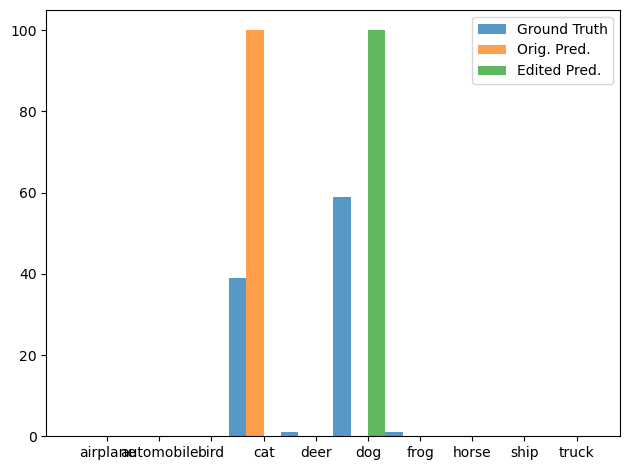

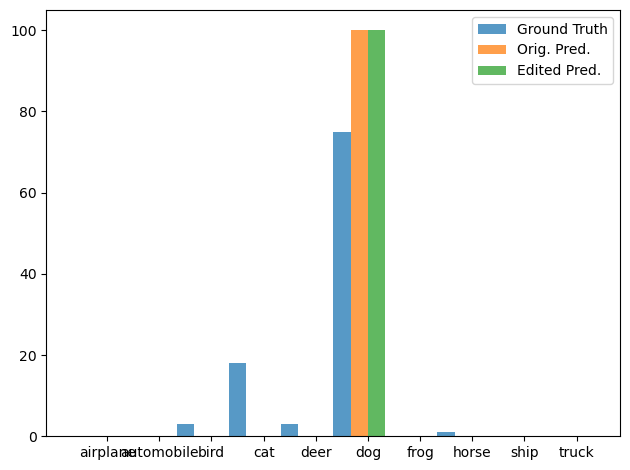

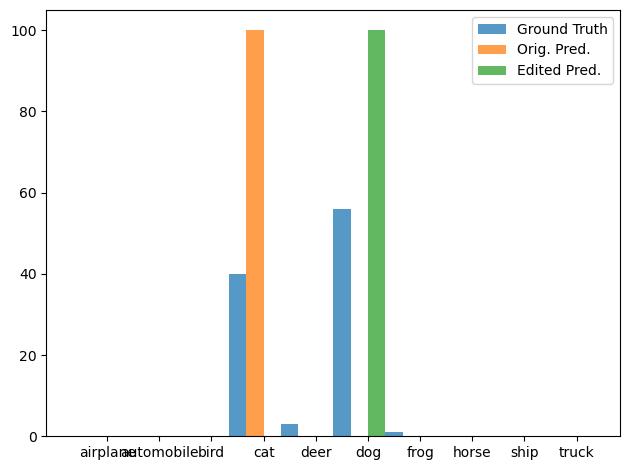

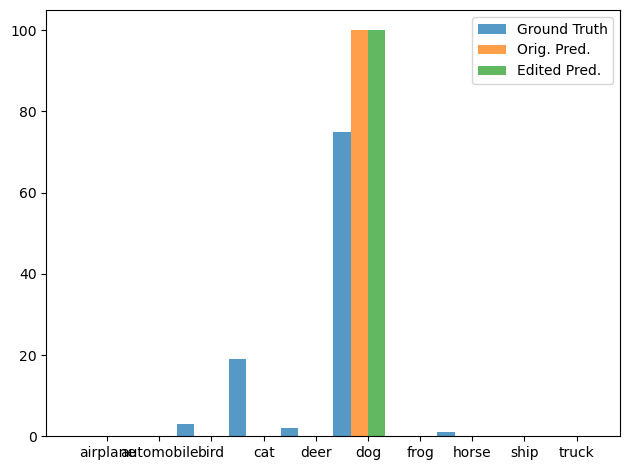

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/slic_masked_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/slic_masked_1/models
Finished trial 48/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/slic_masked_1
(0113_171938) Starting Trial 49/2008...
Current run_id: 0113_160154/dog-train-n02112018_292/watershed_gaussian_4
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/watershed_gaussian_4
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02112018_292.png
Value images: saved/segmentations/dog/dog-train-n02112018_292/mod

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 33.26it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.037604402750730515 0.0035587442107498646
L2 norm of weight change: 0.17885875701904297
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:10<00:00, 24.98it/s]


Post-edit metrics: {'TP': array([6072, 5522, 5212, 3487, 4264, 3428, 5660, 5158, 4906, 4530]), 'TN': array([60405, 60840, 59456, 60588, 60152, 61097, 61056, 61723, 61517,
       61405]), 'FPs': array([2595, 2160, 3544, 2412, 2848, 1903, 1944, 1277, 1483, 1595]), 'FNs': array([ 928, 1478, 1788, 3513, 2736, 3572, 1340, 1842, 2094, 2470]), 'accuracy': 0.6891285714285714, 'per_class_accuracy': array([0.94967143, 0.94802857, 0.92382857, 0.91535714, 0.92022857,
       0.92178571, 0.95308571, 0.95544286, 0.9489    , 0.94192857]), 'per_class_accuracy_mean': 0.9378257142857143, 'precision': array([0.70058844, 0.71882322, 0.59524897, 0.59111714, 0.59955006,
       0.64303133, 0.74434508, 0.801554  , 0.7678823 , 0.73959184]), 'precision_mean': 0.6901732372628704, 'recall': array([0.86742857, 0.78885714, 0.74457143, 0.49814286, 0.60914286,
       0.48971429, 0.80857143, 0.73685714, 0.70085714, 0.64714286]), 'recall_mean': 0.6891285714285714, 'f1': array([0.77513244, 0.75221359, 0.66158924, 0.54066

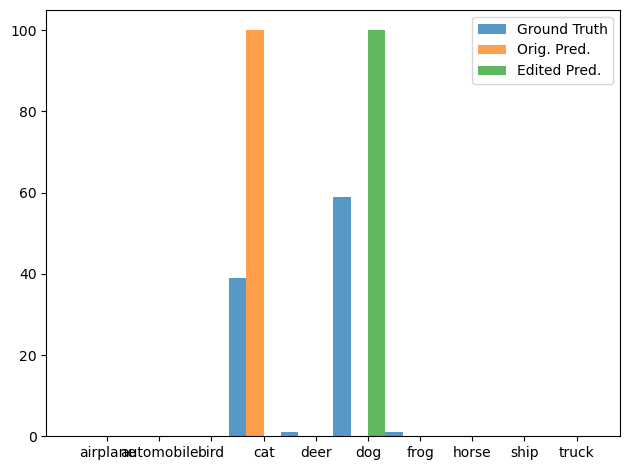

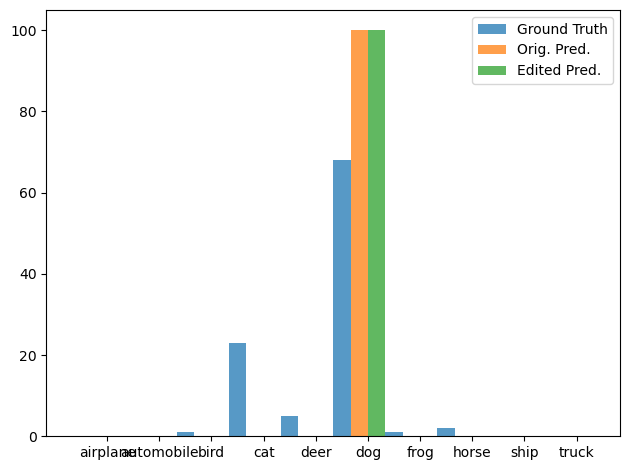

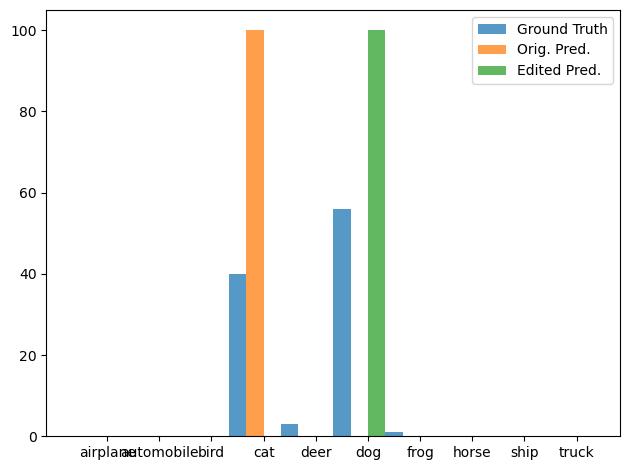

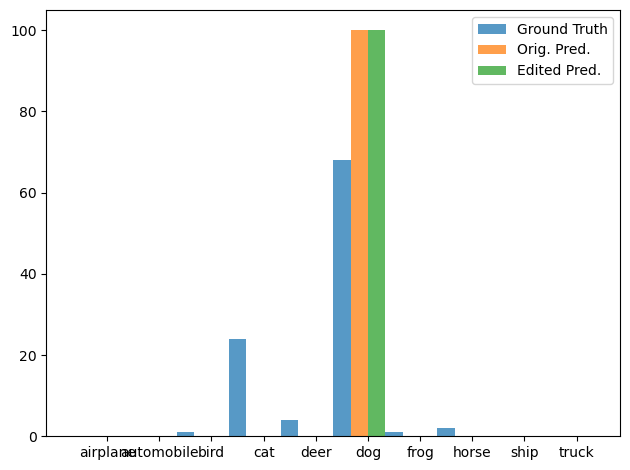

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/watershed_gaussian_4/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/watershed_gaussian_4/models
Finished trial 49/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/watershed_gaussian_4
(0113_172103) Starting Trial 50/2008...
Current run_id: 0113_160154/dog-train-n02112018_292/watershed_masked_2
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/watershed_masked_2
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02112018_292.png
Value images: saved/segmentations/dog/dog-train-

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 33.49it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.05999801680445671 0.003738260827958584
L2 norm of weight change: 0.24107207357883453
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:11<00:00, 23.01it/s]


Post-edit metrics: {'TP': array([6053, 5595, 5258, 3164, 4252, 3691, 5646, 5167, 4894, 4435]), 'TN': array([60525, 60670, 59246, 61187, 60123, 60581, 61078, 61701, 61512,
       61532]), 'FPs': array([2475, 2330, 3754, 1813, 2877, 2419, 1922, 1299, 1488, 1468]), 'FNs': array([ 947, 1405, 1742, 3836, 2748, 3309, 1354, 1833, 2106, 2565]), 'accuracy': 0.6879285714285714, 'per_class_accuracy': array([0.95111429, 0.94664286, 0.92148571, 0.9193    , 0.91964286,
       0.91817143, 0.9532    , 0.95525714, 0.94865714, 0.94238571]), 'per_class_accuracy_mean': 0.9375857142857142, 'precision': array([0.70977955, 0.70599369, 0.5834443 , 0.63572433, 0.59643709,
       0.60409165, 0.74603594, 0.799103  , 0.76684425, 0.75131289]), 'precision_mean': 0.6898766692283418, 'recall': array([0.86471429, 0.79928571, 0.75114286, 0.452     , 0.60742857,
       0.52728571, 0.80657143, 0.73814286, 0.69914286, 0.63357143]), 'recall_mean': 0.6879285714285716, 'f1': array([0.77962391, 0.74974874, 0.65675743, 0.52834

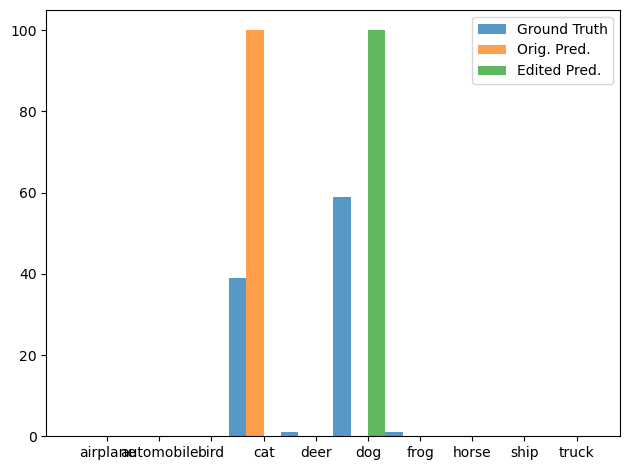

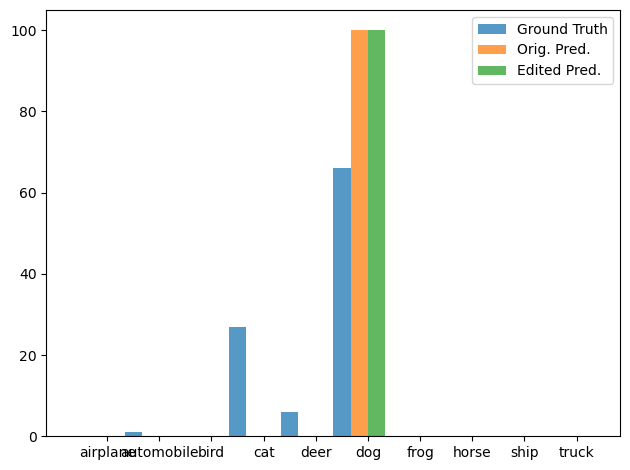

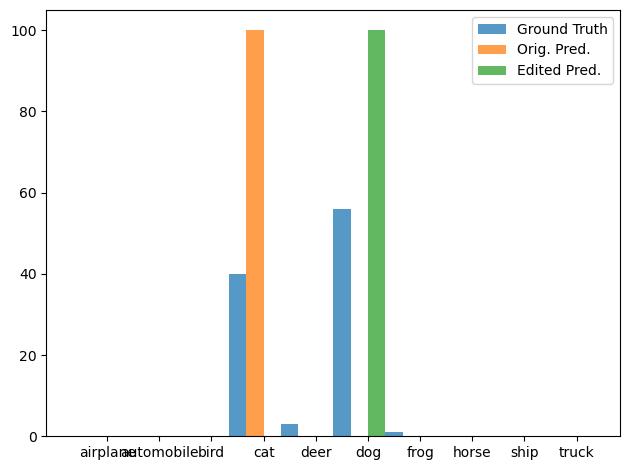

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/watershed_masked_2/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/watershed_masked_2/models
Finished trial 50/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/watershed_masked_2
(0113_172230) Starting Trial 51/2008...
Current run_id: 0113_160154/dog-train-n02112018_292/watershed_masked_4
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/watershed_masked_4
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02112018_292.png
Value images: saved/segmentations/dog/dog-train-n02112

100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 29.64it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.05148521065711975 0.0034354322124272585
L2 norm of weight change: 0.2172364592552185
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:13<00:00, 20.52it/s]


Post-edit metrics: {'TP': array([6069, 5576, 5232, 3294, 4268, 3579, 5652, 5147, 4914, 4457]), 'TN': array([60417, 60734, 59343, 60980, 60130, 60785, 61075, 61732, 61488,
       61504]), 'FPs': array([2583, 2266, 3657, 2020, 2870, 2215, 1925, 1268, 1512, 1496]), 'FNs': array([ 931, 1424, 1768, 3706, 2732, 3421, 1348, 1853, 2086, 2543]), 'accuracy': 0.6884, 'per_class_accuracy': array([0.9498    , 0.94728571, 0.9225    , 0.9182    , 0.91997143,
       0.91948571, 0.95324286, 0.95541429, 0.9486    , 0.9423    ]), 'per_class_accuracy_mean': 0.93768, 'precision': array([0.70145631, 0.7110431 , 0.58859264, 0.61987204, 0.59792659,
       0.61770797, 0.74594167, 0.80233827, 0.76470588, 0.74869814]), 'precision_mean': 0.68982826074936, 'recall': array([0.867     , 0.79657143, 0.74742857, 0.47057143, 0.60971429,
       0.51128571, 0.80742857, 0.73528571, 0.702     , 0.63671429]), 'recall_mean': 0.6884, 'f1': array([0.77549195, 0.75138122, 0.65856882, 0.53500081, 0.60376291,
       0.55948101, 0

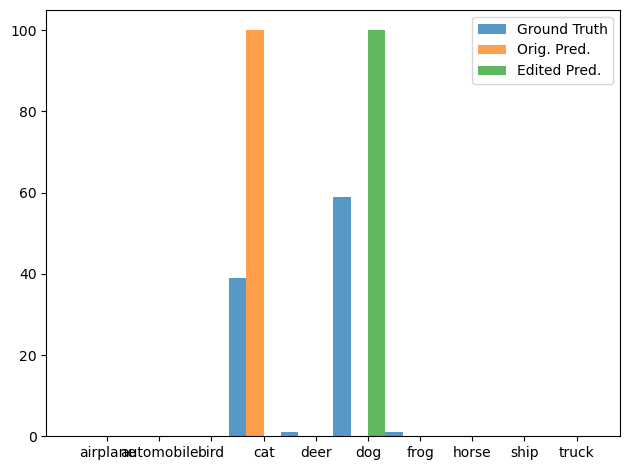

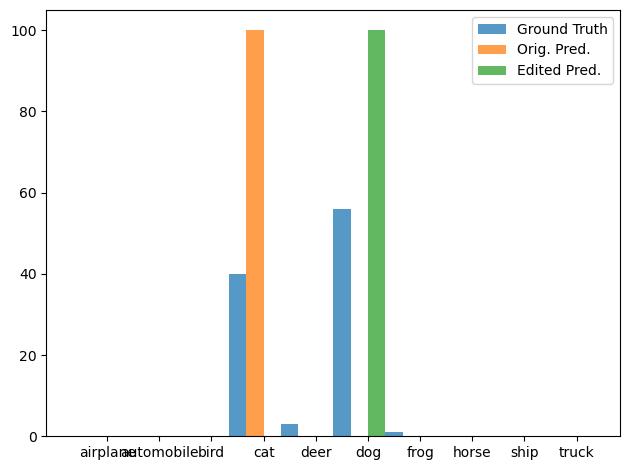

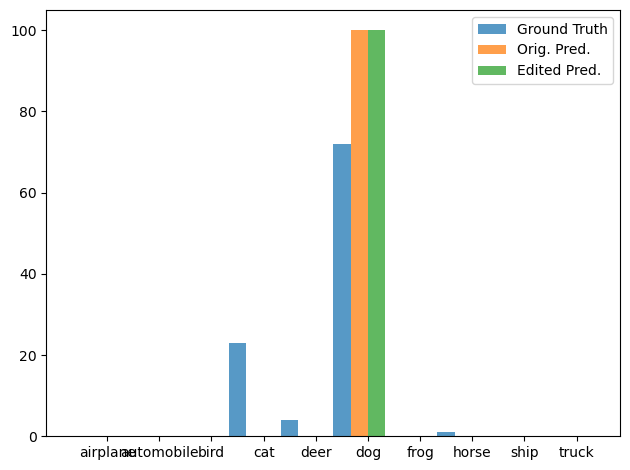

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/watershed_masked_4/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/watershed_masked_4/models
Finished trial 51/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02112018_292/watershed_masked_4
(0113_172359) Starting Trial 52/2008...
Current run_id: 0113_160154/dog-train-n02117135_4084/felzenszwalb_gaussian_2
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/felzenszwalb_gaussian_2
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02117135_4084.png
Value images: saved/segmentations/dog/dog

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 34.12it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.05168682336807251 0.004035274498164654
L2 norm of weight change: 0.23089854419231415
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 27.63it/s]


Post-edit metrics: {'TP': array([6121, 5413, 5186, 3583, 4604, 3166, 5454, 5144, 4861, 4510]), 'TN': array([60215, 61117, 59417, 60426, 59073, 61449, 61550, 61663, 61585,
       61547]), 'FPs': array([2785, 1883, 3583, 2574, 3927, 1551, 1450, 1337, 1415, 1453]), 'FNs': array([ 879, 1587, 1814, 3417, 2396, 3834, 1546, 1856, 2139, 2490]), 'accuracy': 0.6863142857142858, 'per_class_accuracy': array([0.94765714, 0.95042857, 0.9229    , 0.91441429, 0.90967143,
       0.92307143, 0.9572    , 0.95438571, 0.94922857, 0.94367143]), 'per_class_accuracy_mean': 0.9372628571428573, 'precision': array([0.68728947, 0.74191338, 0.59140153, 0.58193926, 0.53967882,
       0.67118932, 0.78997683, 0.79370468, 0.77453792, 0.75633071]), 'precision_mean': 0.6927961891376129, 'recall': array([0.87442857, 0.77328571, 0.74085714, 0.51185714, 0.65771429,
       0.45228571, 0.77914286, 0.73485714, 0.69442857, 0.64428571]), 'recall_mean': 0.6863142857142857, 'f1': array([0.76964667, 0.75727476, 0.65774621, 0.54465

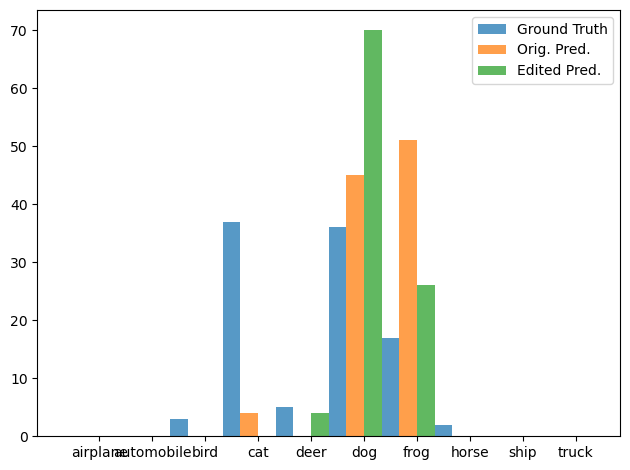

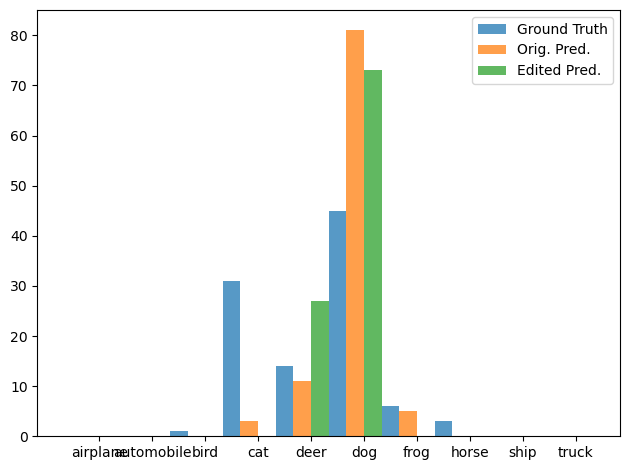

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/felzenszwalb_gaussian_2/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/felzenszwalb_gaussian_2/models
Finished trial 52/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/felzenszwalb_gaussian_2
(0113_172526) Starting Trial 53/2008...
Current run_id: 0113_160154/dog-train-n02117135_4084/felzenszwalb_masked_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/felzenszwalb_masked_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02117135_4084.png
Value images: saved/segment

100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 29.21it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.035050295293331146 0.002697271527722478
L2 norm of weight change: 0.18571732938289642
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:17<00:00, 15.90it/s]


Post-edit metrics: {'TP': array([6132, 5457, 5198, 3716, 4405, 3227, 5546, 5172, 4801, 4506]), 'TN': array([60211, 61015, 59459, 60187, 59734, 61346, 61382, 61646, 61667,
       61513]), 'FPs': array([2789, 1985, 3541, 2813, 3266, 1654, 1618, 1354, 1333, 1487]), 'FNs': array([ 868, 1543, 1802, 3284, 2595, 3773, 1454, 1828, 2199, 2494]), 'accuracy': 0.688, 'per_class_accuracy': array([0.94775714, 0.9496    , 0.92367143, 0.9129    , 0.91627143,
       0.92247143, 0.95611429, 0.95454286, 0.94954286, 0.94312857]), 'per_class_accuracy_mean': 0.9376000000000001, 'precision': array([0.68736689, 0.73327063, 0.5948049 , 0.56915301, 0.57424065,
       0.66113501, 0.77414852, 0.79252222, 0.78268666, 0.75187719]), 'precision_mean': 0.6921205674183601, 'recall': array([0.876     , 0.77957143, 0.74257143, 0.53085714, 0.62928571,
       0.461     , 0.79228571, 0.73885714, 0.68585714, 0.64371429]), 'recall_mean': 0.6880000000000001, 'f1': array([0.77030337, 0.75571251, 0.66052481, 0.54933846, 0.600504

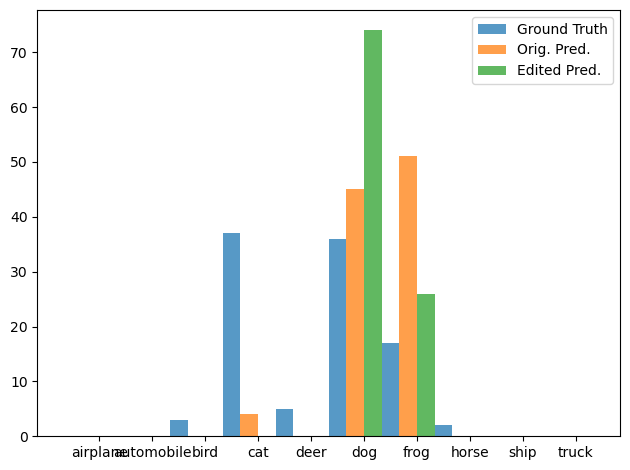

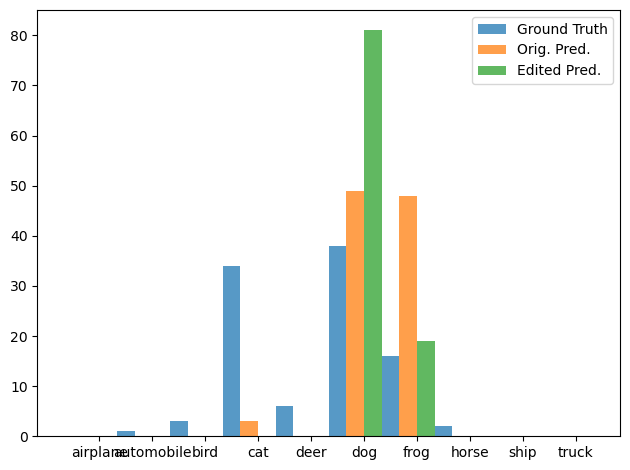

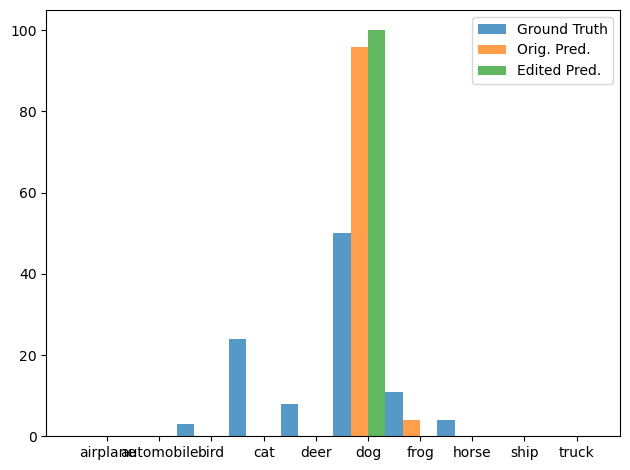

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/felzenszwalb_masked_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/felzenszwalb_masked_1/models
Finished trial 53/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/felzenszwalb_masked_1
(0113_172703) Starting Trial 54/2008...
Current run_id: 0113_160154/dog-train-n02117135_4084/quickshift_gaussian_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/quickshift_gaussian_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02117135_4084.png
Value images: saved/segmentations

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 30.72it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.022883303463459015 0.002841767156496644
L2 norm of weight change: 0.15936553478240967
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:12<00:00, 21.89it/s]


Post-edit metrics: {'TP': array([6122, 5504, 5234, 3502, 4327, 3170, 5674, 5164, 4838, 4512]), 'TN': array([60205, 60870, 59292, 60535, 59944, 61489, 60967, 61692, 61612,
       61441]), 'FPs': array([2795, 2130, 3708, 2465, 3056, 1511, 2033, 1308, 1388, 1559]), 'FNs': array([ 878, 1496, 1766, 3498, 2673, 3830, 1326, 1836, 2162, 2488]), 'accuracy': 0.6863857142857143, 'per_class_accuracy': array([0.94752857, 0.9482    , 0.9218    , 0.91481429, 0.91815714,
       0.9237    , 0.95201429, 0.95508571, 0.94928571, 0.94218571]), 'per_class_accuracy_mean': 0.9372771428571427, 'precision': array([0.68655377, 0.72098507, 0.58532767, 0.58689459, 0.58607612,
       0.67720573, 0.73621383, 0.79789864, 0.77706393, 0.7432054 ]), 'precision_mean': 0.6897424740757175, 'recall': array([0.87457143, 0.78628571, 0.74771429, 0.50028571, 0.61814286,
       0.45285714, 0.81057143, 0.73771429, 0.69114286, 0.64457143]), 'recall_mean': 0.6863857142857143, 'f1': array([0.76924043, 0.75222086, 0.65663028, 0.54014

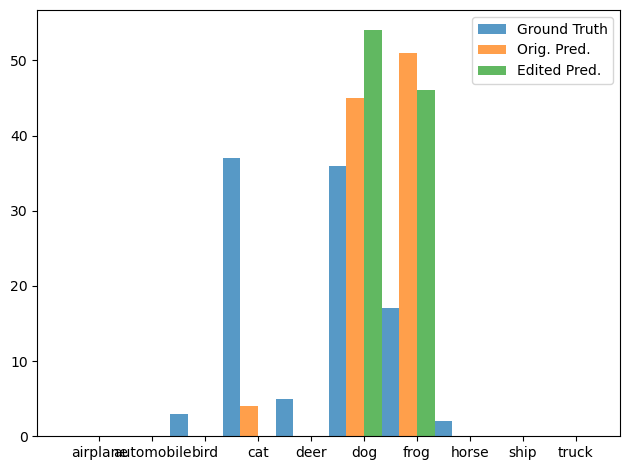

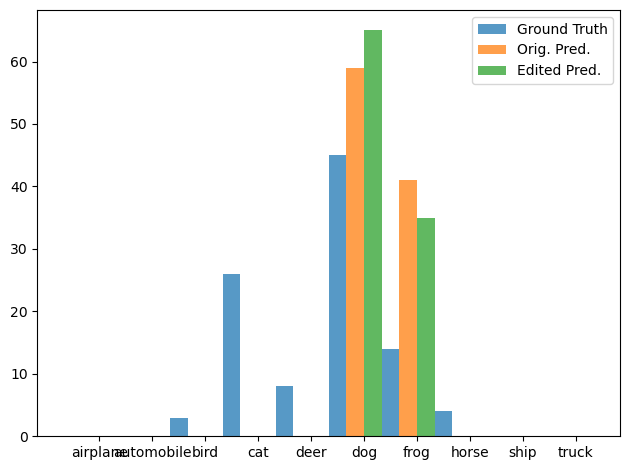

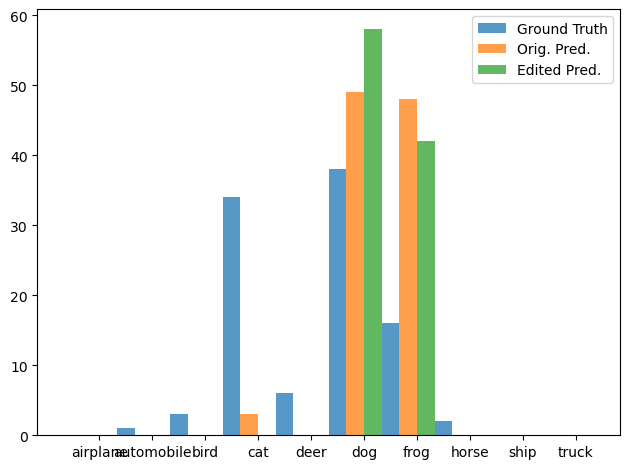

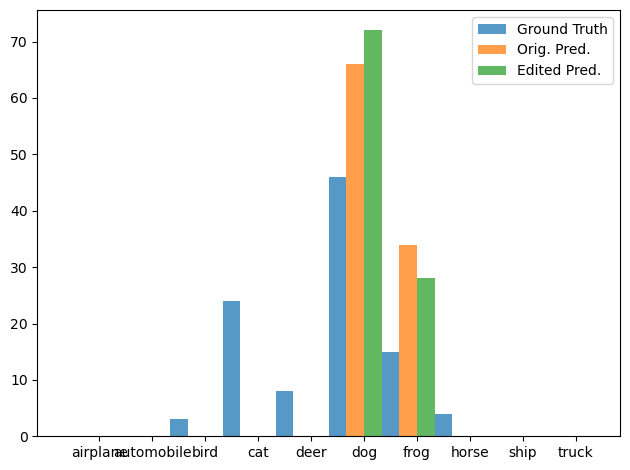

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/quickshift_gaussian_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/quickshift_gaussian_1/models
Finished trial 54/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/quickshift_gaussian_1
(0113_172831) Starting Trial 55/2008...
Current run_id: 0113_160154/dog-train-n02117135_4084/quickshift_gaussian_2
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/quickshift_gaussian_2
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02117135_4084.png
Value images: saved/segmentations

100%|██████████████████████████████████████████| 274/274 [00:15<00:00, 17.75it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.032127782702445984 0.003042789176106453
L2 norm of weight change: 0.17455296218395233
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 29.73it/s]


Post-edit metrics: {'TP': array([6127, 5441, 5171, 3805, 4370, 3207, 5560, 5154, 4809, 4536]), 'TN': array([60226, 61056, 59575, 59966, 59829, 61358, 61313, 61708, 61655,
       61494]), 'FPs': array([2774, 1944, 3425, 3034, 3171, 1642, 1687, 1292, 1345, 1506]), 'FNs': array([ 873, 1559, 1829, 3195, 2630, 3793, 1440, 1846, 2191, 2464]), 'accuracy': 0.6882857142857143, 'per_class_accuracy': array([0.9479    , 0.94995714, 0.92494286, 0.91101429, 0.91712857,
       0.92235714, 0.95532857, 0.95517143, 0.94948571, 0.94328571]), 'per_class_accuracy_mean': 0.937657142857143, 'precision': array([0.68834962, 0.73676371, 0.60155886, 0.55636789, 0.57949874,
       0.66137348, 0.76721402, 0.79956562, 0.78144296, 0.75074479]), 'precision_mean': 0.6922879699885758, 'recall': array([0.87528571, 0.77728571, 0.73871429, 0.54357143, 0.62428571,
       0.45814286, 0.79428571, 0.73628571, 0.687     , 0.648     ]), 'recall_mean': 0.6882857142857144, 'f1': array([0.77064336, 0.75648245, 0.66311875, 0.549895

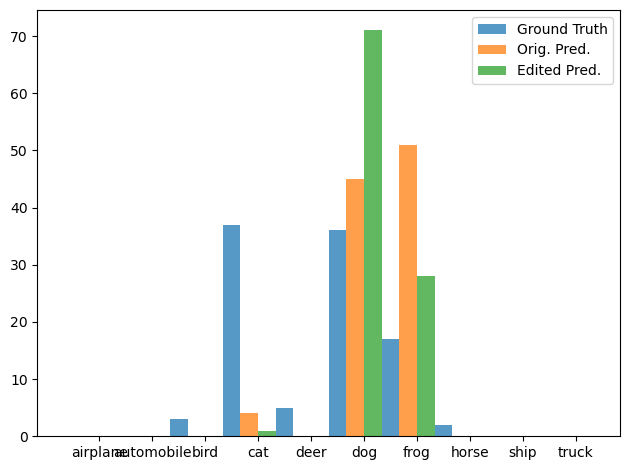

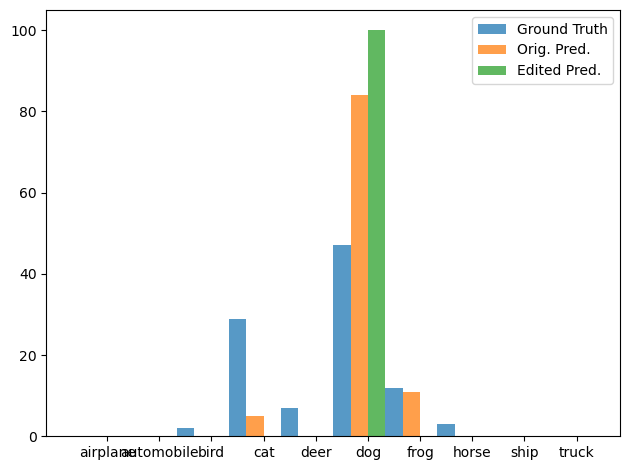

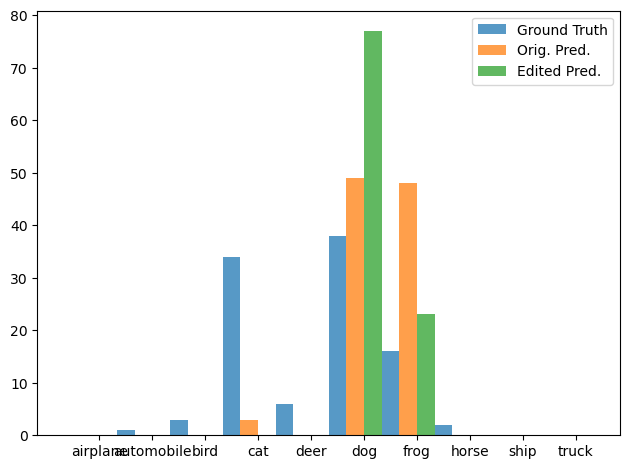

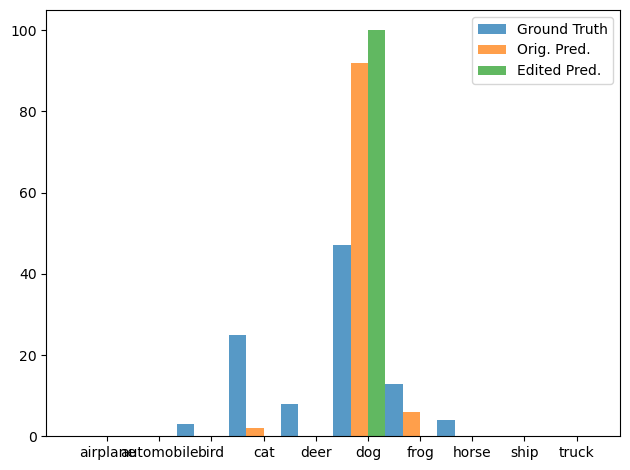

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/quickshift_gaussian_2/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/quickshift_gaussian_2/models
Finished trial 55/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/quickshift_gaussian_2
(0113_173006) Starting Trial 56/2008...
Current run_id: 0113_160154/dog-train-n02117135_4084/quickshift_masked_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/quickshift_masked_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02117135_4084.png
Value images: saved/segmentations/dog

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 33.95it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.11792466044425964 0.003919612616300583
L2 norm of weight change: 0.5216507315635681
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:14<00:00, 18.98it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:165: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:202: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6088, 5412, 5162, 3756, 3951, 4039,    0, 5248, 4900, 4357]), 'TN': array([60350, 61109, 59688, 59970, 60844, 53136, 63000, 61534, 61521,
       61761]), 'FPs': array([2650, 1891, 3312, 3030, 2156, 9864,    0, 1466, 1479, 1239]), 'FNs': array([ 912, 1588, 1838, 3244, 3049, 2961, 7000, 1752, 2100, 2643]), 'accuracy': 0.6130428571428571, 'per_class_accuracy': array([0.94911429, 0.9503    , 0.92642857, 0.91037143, 0.92564286,
       0.81678571, 0.9       , 0.95402857, 0.94887143, 0.94454286]), 'per_class_accuracy_mean': 0.9226085714285712, 'precision': array([0.69672694, 0.74106532, 0.60915742, 0.55349248, 0.6469625 ,
       0.29051284, 0.        , 0.78165028, 0.76814548, 0.77859185]), 'precision_mean': 0.5866305115321724, 'recall': array([0.86971429, 0.77314286, 0.73742857, 0.53657143, 0.56442857,
       0.577     , 0.        , 0.74971429, 0.7       , 0.62242857]), 'recall_mean': 0.6130428571428571, 'f1': array([0.77366883, 0.75676432, 0.66718366, 0.54490

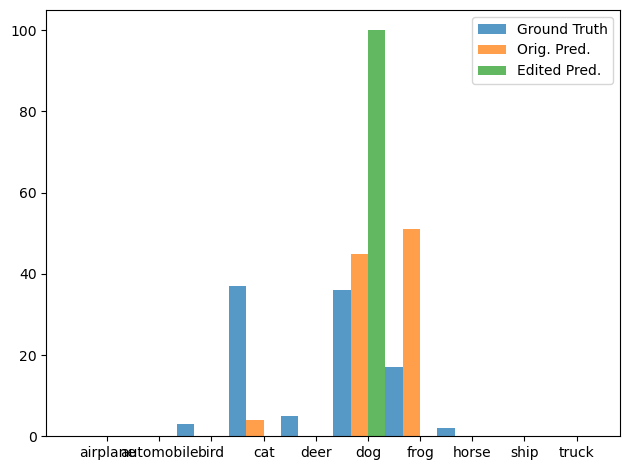

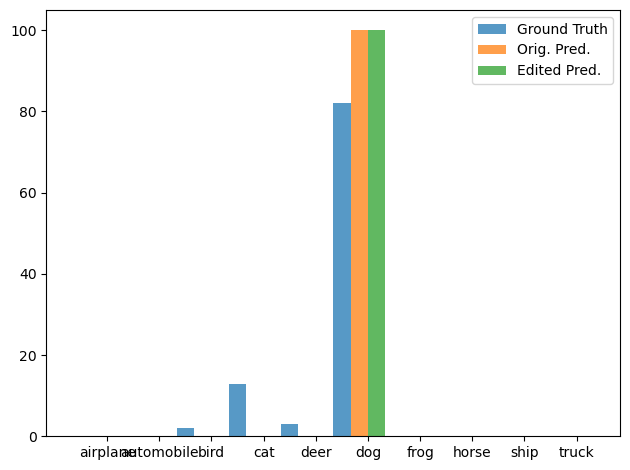

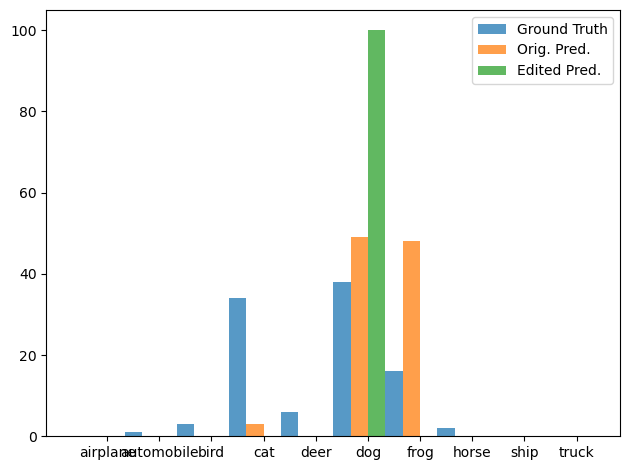

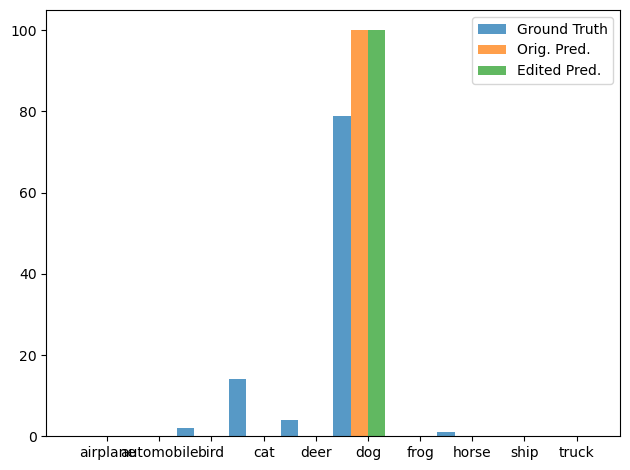

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/quickshift_masked_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/quickshift_masked_1/models
Finished trial 56/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/quickshift_masked_1
(0113_173134) Starting Trial 57/2008...
Current run_id: 0113_160154/dog-train-n02117135_4084/slic_gaussian_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/slic_gaussian_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02117135_4084.png
Value images: saved/segmentations/dog/dog-train-n02

100%|██████████████████████████████████████████| 274/274 [00:10<00:00, 27.20it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.030277002602815628 0.0035764253698289394
L2 norm of weight change: 0.18459706008434296
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:18<00:00, 14.96it/s]


Post-edit metrics: {'TP': array([6133, 5447, 5144, 3546, 4526, 3072, 5665, 5124, 4826, 4552]), 'TN': array([60208, 61038, 59554, 60440, 59367, 61627, 61005, 61716, 61638,
       61442]), 'FPs': array([2792, 1962, 3446, 2560, 3633, 1373, 1995, 1284, 1362, 1558]), 'FNs': array([ 867, 1553, 1856, 3454, 2474, 3928, 1335, 1876, 2174, 2448]), 'accuracy': 0.6862142857142857, 'per_class_accuracy': array([0.94772857, 0.94978571, 0.92425714, 0.91408571, 0.91275714,
       0.92427143, 0.95242857, 0.95485714, 0.94948571, 0.94277143]), 'per_class_accuracy_mean': 0.9372428571428572, 'precision': array([0.68717087, 0.73518693, 0.59883586, 0.58074026, 0.55472484,
       0.69111361, 0.73955614, 0.79962547, 0.77989657, 0.74500818]), 'precision_mean': 0.6911858730073668, 'recall': array([0.87614286, 0.77814286, 0.73485714, 0.50657143, 0.64657143,
       0.43885714, 0.80928571, 0.732     , 0.68942857, 0.65028571]), 'recall_mean': 0.6862142857142858, 'f1': array([0.77023548, 0.75605524, 0.6599102 , 0.54112

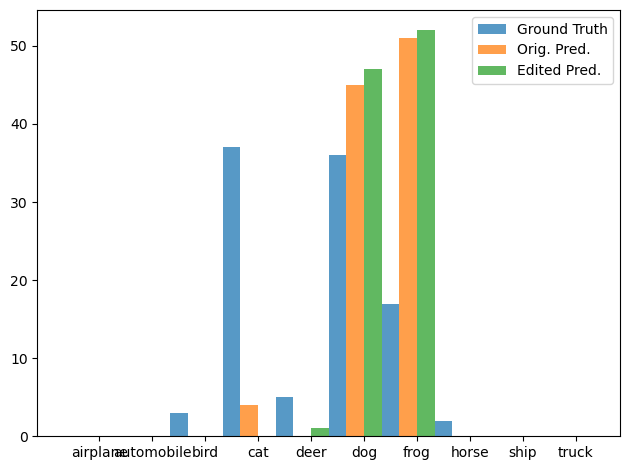

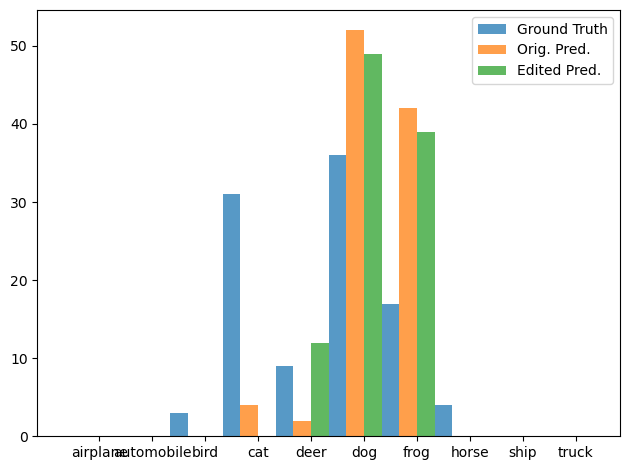

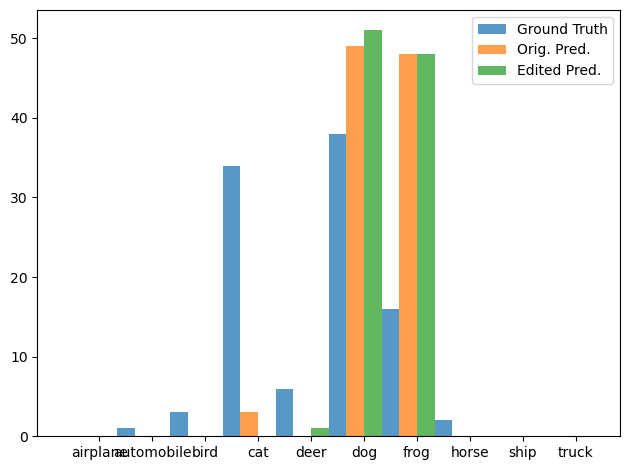

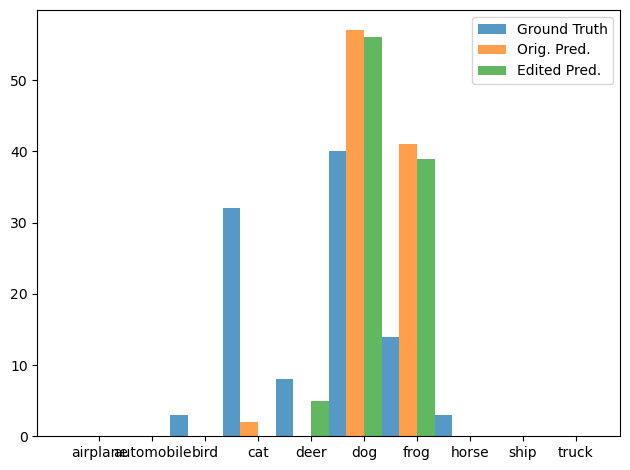

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/slic_gaussian_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/slic_gaussian_1/models
Finished trial 57/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/slic_gaussian_1
(0113_173311) Starting Trial 58/2008...
Current run_id: 0113_160154/dog-train-n02117135_4084/slic_gaussian_6
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/slic_gaussian_6
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02117135_4084.png
Value images: saved/segmentations/dog/dog-train-n02117135_4084/

100%|██████████████████████████████████████████| 274/274 [00:15<00:00, 17.28it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.021217219531536102 0.002579662250354886
L2 norm of weight change: 0.17300134897232056
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 28.33it/s]


Post-edit metrics: {'TP': array([6131, 5476, 5224, 3721, 4282, 3213, 5627, 5182, 4764, 4515]), 'TN': array([60208, 60965, 59385, 60130, 60082, 61380, 61127, 61655, 61711,
       61492]), 'FPs': array([2792, 2035, 3615, 2870, 2918, 1620, 1873, 1345, 1289, 1508]), 'FNs': array([ 869, 1524, 1776, 3279, 2718, 3787, 1373, 1818, 2236, 2485]), 'accuracy': 0.6876428571428571, 'per_class_accuracy': array([0.9477    , 0.94915714, 0.92298571, 0.91215714, 0.91948571,
       0.92275714, 0.95362857, 0.95481429, 0.94964286, 0.94295714]), 'per_class_accuracy_mean': 0.9375285714285715, 'precision': array([0.68710075, 0.72906404, 0.59101708, 0.56455773, 0.59472222,
       0.66480447, 0.75026667, 0.79393289, 0.78704774, 0.74962643]), 'precision_mean': 0.6912140033121285, 'recall': array([0.87585714, 0.78228571, 0.74628571, 0.53157143, 0.61171429,
       0.459     , 0.80385714, 0.74028571, 0.68057143, 0.645     ]), 'recall_mean': 0.6876428571428571, 'f1': array([0.77008101, 0.75473779, 0.6596376 , 0.54756

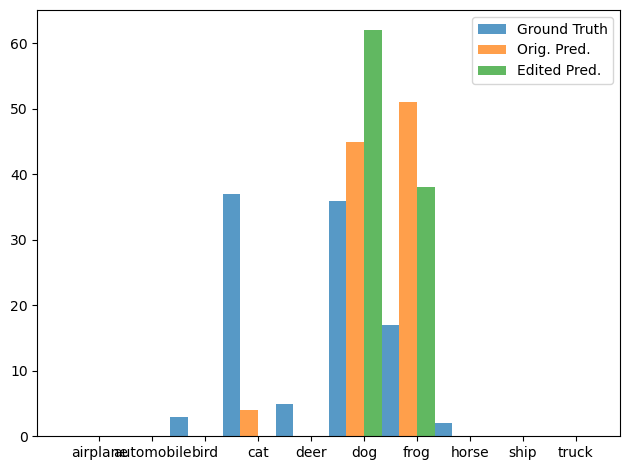

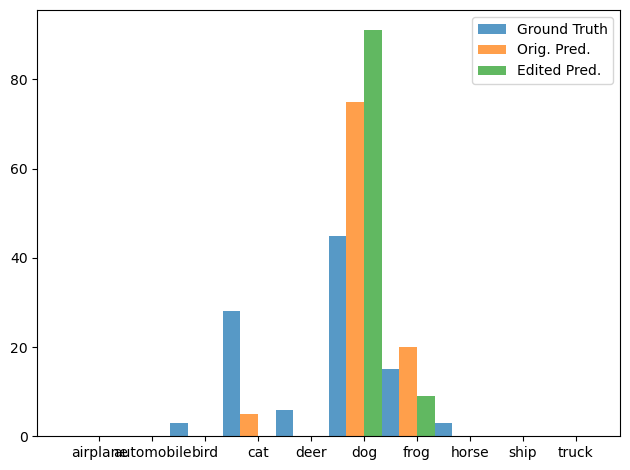

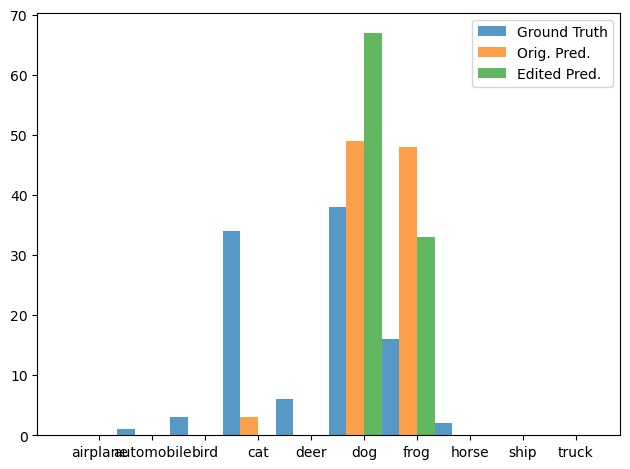

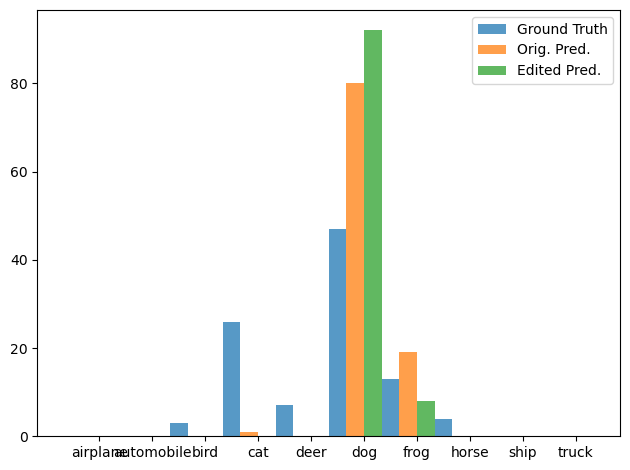

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/slic_gaussian_6/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/slic_gaussian_6/models
Finished trial 58/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/slic_gaussian_6
(0113_173447) Starting Trial 59/2008...
Current run_id: 0113_160154/dog-train-n02117135_4084/slic_masked_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/slic_masked_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02117135_4084.png
Value images: saved/segmentations/dog/dog-train-n02117135_4084/modi

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 33.95it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0052, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.047225192189216614 0.005215272307395935
L2 norm of weight change: 0.1915770024061203
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:11<00:00, 24.59it/s]


Post-edit metrics: {'TP': array([6144, 5284, 5242, 4166, 4211, 3033, 5327, 5164, 4838, 4695]), 'TN': array([60109, 61301, 59300, 59137, 60242, 61633, 61776, 61691, 61621,
       61294]), 'FPs': array([2891, 1699, 3700, 3863, 2758, 1367, 1224, 1309, 1379, 1706]), 'FNs': array([ 856, 1716, 1758, 2834, 2789, 3967, 1673, 1836, 2162, 2305]), 'accuracy': 0.6872, 'per_class_accuracy': array([0.94647143, 0.95121429, 0.92202857, 0.90432857, 0.92075714,
       0.9238    , 0.95861429, 0.95507143, 0.94941429, 0.9427    ]), 'per_class_accuracy_mean': 0.9374399999999999, 'precision': array([0.68002214, 0.75669483, 0.58622232, 0.5188691 , 0.60424738,
       0.68931818, 0.8131583 , 0.79777537, 0.77818884, 0.73347914]), 'precision_mean': 0.6957975602679811, 'recall': array([0.87771429, 0.75485714, 0.74885714, 0.59514286, 0.60157143,
       0.43328571, 0.761     , 0.73771429, 0.69114286, 0.67071429]), 'recall_mean': 0.6872, 'f1': array([0.76632367, 0.75577487, 0.65763392, 0.55439484, 0.60290644,
       

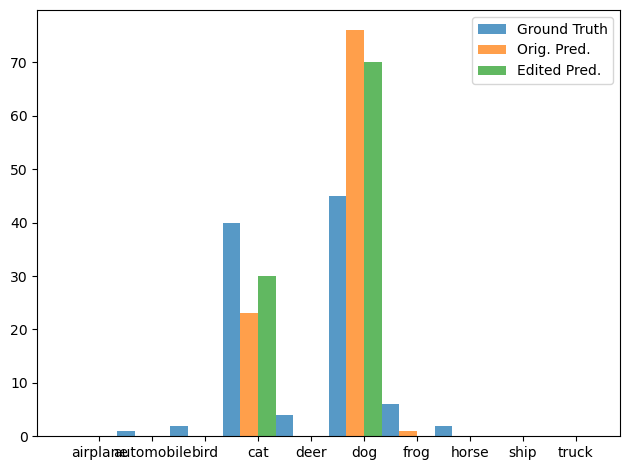

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/slic_masked_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/slic_masked_0/models
Finished trial 59/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/slic_masked_0
(0113_173615) Starting Trial 60/2008...
Current run_id: 0113_160154/dog-train-n02117135_4084/slic_masked_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/slic_masked_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02117135_4084.png
Value images: saved/segmentations/dog/dog-train-n02117135_4084/modified_i

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 31.55it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0049, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.05652992054820061 0.004880812950432301
L2 norm of weight change: 0.22337277233600616
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:14<00:00, 18.68it/s]


Post-edit metrics: {'TP': array([6146, 5415, 5283, 3546, 4537, 3096, 5390, 5200, 4805, 4515]), 'TN': array([60085, 61101, 59053, 60535, 59237, 61574, 61645, 61536, 61655,
       61512]), 'FPs': array([2915, 1899, 3947, 2465, 3763, 1426, 1355, 1464, 1345, 1488]), 'FNs': array([ 854, 1585, 1717, 3454, 2463, 3904, 1610, 1800, 2195, 2485]), 'accuracy': 0.6847571428571428, 'per_class_accuracy': array([0.94615714, 0.95022857, 0.91908571, 0.91544286, 0.91105714,
       0.92385714, 0.95764286, 0.95337143, 0.94942857, 0.94324286]), 'per_class_accuracy_mean': 0.9369514285714287, 'precision': array([0.67829158, 0.74036095, 0.5723727 , 0.58991848, 0.54662651,
       0.68465281, 0.79911045, 0.78031212, 0.78130081, 0.75212394]), 'precision_mean': 0.6925070353993706, 'recall': array([0.878     , 0.77357143, 0.75471429, 0.50657143, 0.64814286,
       0.44228571, 0.77      , 0.74285714, 0.68642857, 0.645     ]), 'recall_mean': 0.6847571428571427, 'f1': array([0.76533217, 0.75660193, 0.65101664, 0.54507

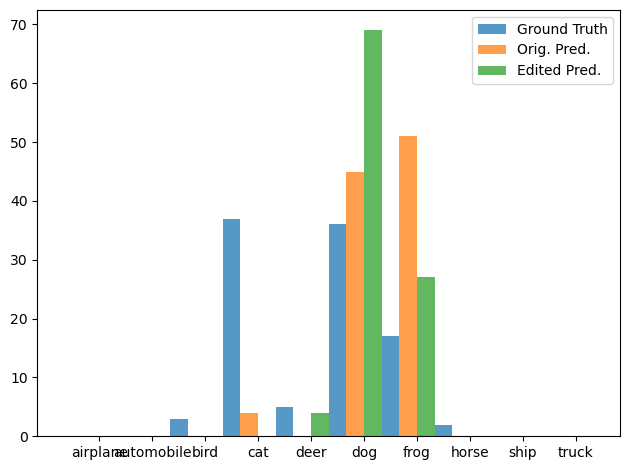

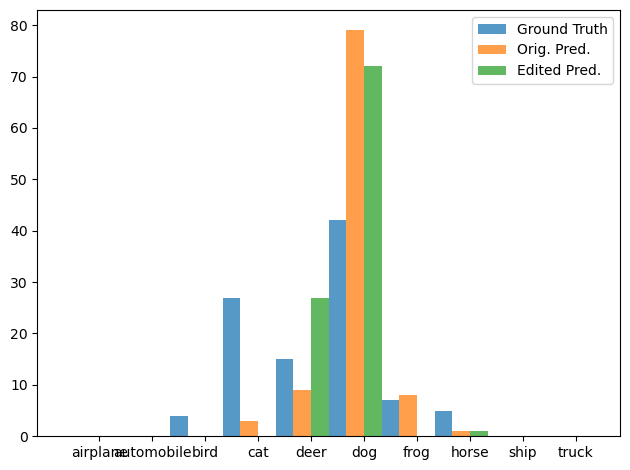

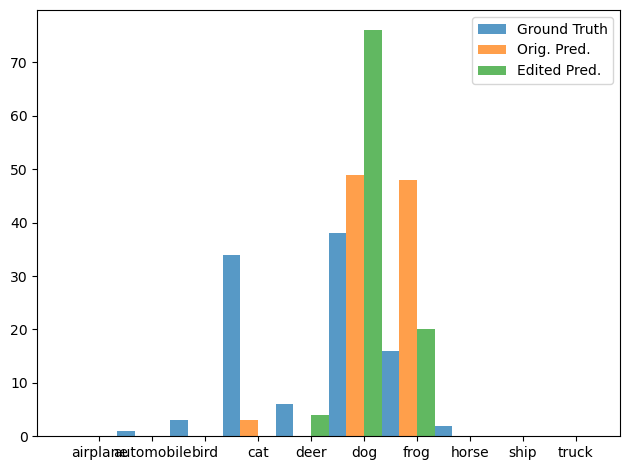

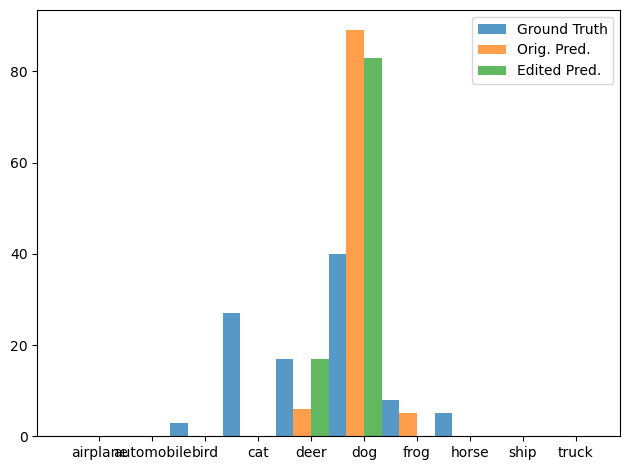

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/slic_masked_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/slic_masked_1/models
Finished trial 60/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/slic_masked_1
(0113_173747) Starting Trial 61/2008...
Current run_id: 0113_160154/dog-train-n02117135_4084/slic_masked_3
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/slic_masked_3
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02117135_4084.png
Value images: saved/segmentations/dog/dog-train-n02117135_4084/modified_i

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 33.61it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0056, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.04815860092639923 0.005599004216492176
L2 norm of weight change: 0.2006809413433075
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 29.07it/s]


Post-edit metrics: {'TP': array([6148, 5338, 5173, 4195, 4134, 3120, 5382, 5196, 4778, 4674]), 'TN': array([60100, 61210, 59579, 59003, 60411, 61477, 61697, 61623, 61712,
       61326]), 'FPs': array([2900, 1790, 3421, 3997, 2589, 1523, 1303, 1377, 1288, 1674]), 'FNs': array([ 852, 1662, 1827, 2805, 2866, 3880, 1618, 1804, 2222, 2326]), 'accuracy': 0.6876857142857142, 'per_class_accuracy': array([0.9464    , 0.95068571, 0.92502857, 0.90282857, 0.92207143,
       0.92281429, 0.95827143, 0.95455714, 0.94985714, 0.94285714]), 'per_class_accuracy_mean': 0.9375371428571428, 'precision': array([0.67948718, 0.74887767, 0.60193158, 0.51208496, 0.61490406,
       0.67197932, 0.80508601, 0.79050662, 0.78766897, 0.7362949 ]), 'precision_mean': 0.6948821272630008, 'recall': array([0.87828571, 0.76257143, 0.739     , 0.59928571, 0.59057143,
       0.44571429, 0.76885714, 0.74228571, 0.68257143, 0.66771429]), 'recall_mean': 0.6876857142857142, 'f1': array([0.7662014 , 0.75566251, 0.66346031, 0.55226

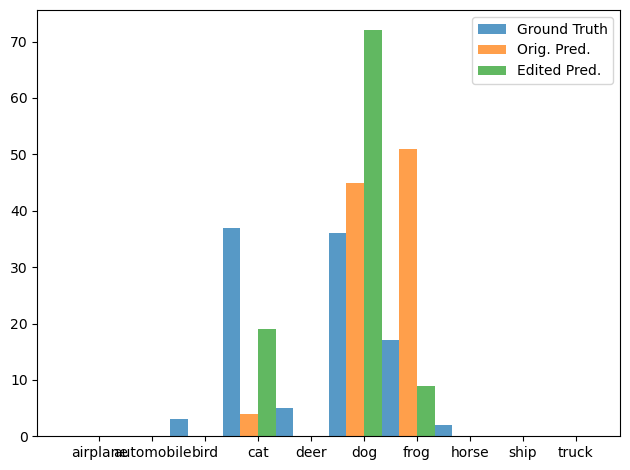

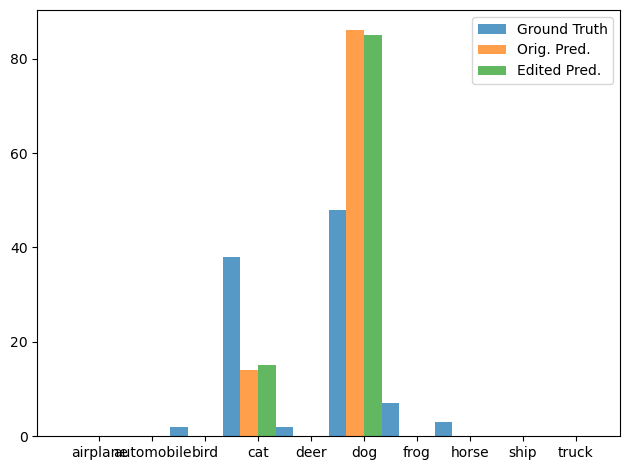

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/slic_masked_3/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/slic_masked_3/models
Finished trial 61/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/slic_masked_3
(0113_173910) Starting Trial 62/2008...
Current run_id: 0113_160154/dog-train-n02117135_4084/watershed_gaussian_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/watershed_gaussian_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02117135_4084.png
Value images: saved/segmentations/dog/dog-train-n02117135_4

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 33.04it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.044200748205184937 0.0036545665934681892
L2 norm of weight change: 0.16909721493721008
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 28.92it/s]


Post-edit metrics: {'TP': array([6091, 5447, 5232, 3770, 4237, 3289, 5483, 5167, 4965, 4601]), 'TN': array([60326, 60994, 59435, 60123, 60208, 61251, 61488, 61699, 61457,
       61301]), 'FPs': array([2674, 2006, 3565, 2877, 2792, 1749, 1512, 1301, 1543, 1699]), 'FNs': array([ 909, 1553, 1768, 3230, 2763, 3711, 1517, 1833, 2035, 2399]), 'accuracy': 0.6897428571428571, 'per_class_accuracy': array([0.94881429, 0.94915714, 0.92381429, 0.91275714, 0.92064286,
       0.922     , 0.95672857, 0.95522857, 0.94888571, 0.94145714]), 'per_class_accuracy_mean': 0.9379485714285714, 'precision': array([0.69492299, 0.73084664, 0.59474821, 0.56717316, 0.60278845,
       0.65283843, 0.7838456 , 0.79885591, 0.76290719, 0.73031746]), 'precision_mean': 0.691924403581503, 'recall': array([0.87014286, 0.77814286, 0.74742857, 0.53857143, 0.60528571,
       0.46985714, 0.78328571, 0.73814286, 0.70928571, 0.65728571]), 'recall_mean': 0.6897428571428571, 'f1': array([0.77272439, 0.75375355, 0.66240425, 0.552502

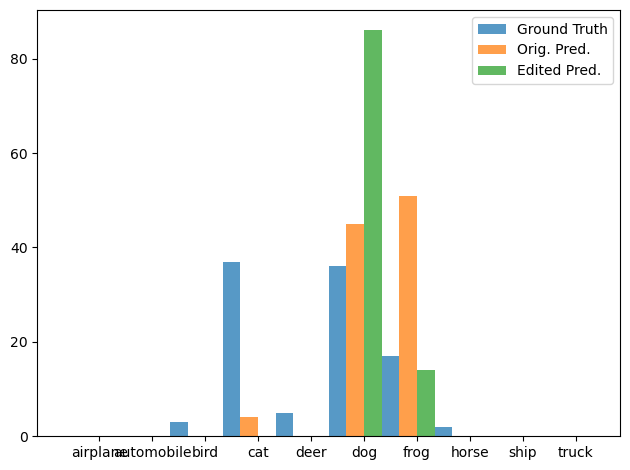

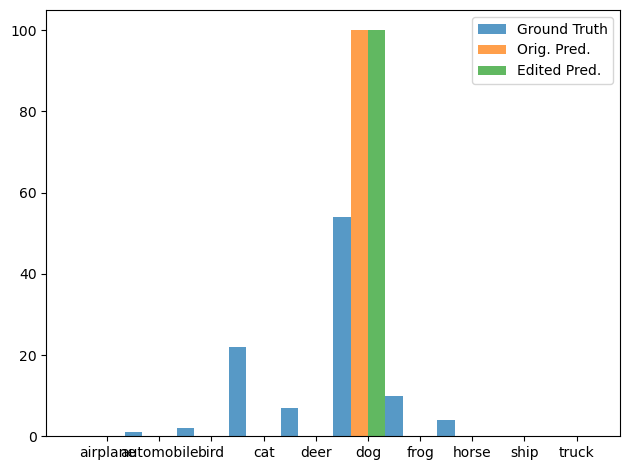

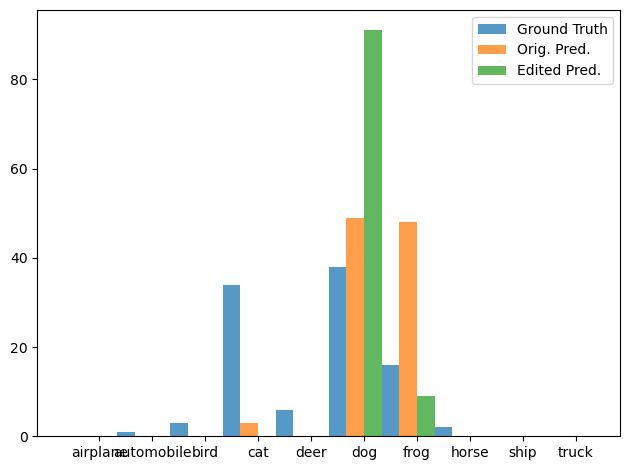

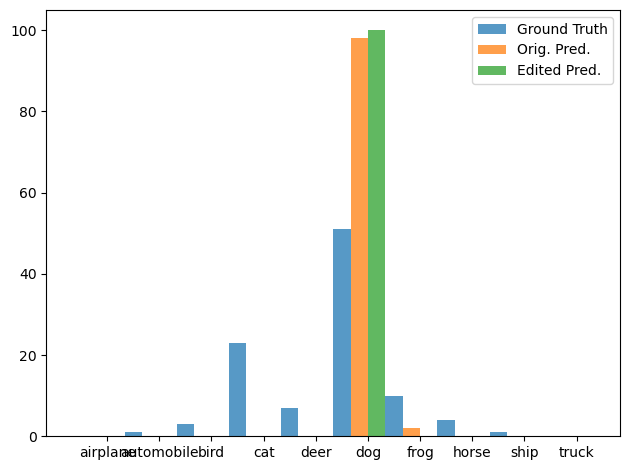

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/watershed_gaussian_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/watershed_gaussian_0/models
Finished trial 62/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/watershed_gaussian_0
(0113_174030) Starting Trial 63/2008...
Current run_id: 0113_160154/dog-train-n02117135_4084/watershed_gaussian_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/watershed_gaussian_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02117135_4084.png
Value images: saved/segmentations/dog/

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 32.63it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.017921339720487595 0.0033681485801935196
L2 norm of weight change: 0.13235998153686523
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 28.77it/s]


Post-edit metrics: {'TP': array([6131, 5407, 5171, 3921, 4237, 3112, 5608, 5147, 4825, 4626]), 'TN': array([60184, 61086, 59590, 59720, 60203, 61534, 61194, 61728, 61638,
       61308]), 'FPs': array([2816, 1914, 3410, 3280, 2797, 1466, 1806, 1272, 1362, 1692]), 'FNs': array([ 869, 1593, 1829, 3079, 2763, 3888, 1392, 1853, 2175, 2374]), 'accuracy': 0.6883571428571429, 'per_class_accuracy': array([0.94735714, 0.9499    , 0.92515714, 0.90915714, 0.92057143,
       0.92351429, 0.95431429, 0.95535714, 0.94947143, 0.94191429]), 'per_class_accuracy_mean': 0.9376714285714286, 'precision': array([0.68525763, 0.73856031, 0.60261042, 0.54450771, 0.60235997,
       0.67977283, 0.7564068 , 0.80183829, 0.779861  , 0.73219373]), 'precision_mean': 0.6923368673876366, 'recall': array([0.87585714, 0.77242857, 0.73871429, 0.56014286, 0.60528571,
       0.44457143, 0.80114286, 0.73528571, 0.68928571, 0.66085714]), 'recall_mean': 0.6883571428571429, 'f1': array([0.76892205, 0.75511487, 0.66375714, 0.55221

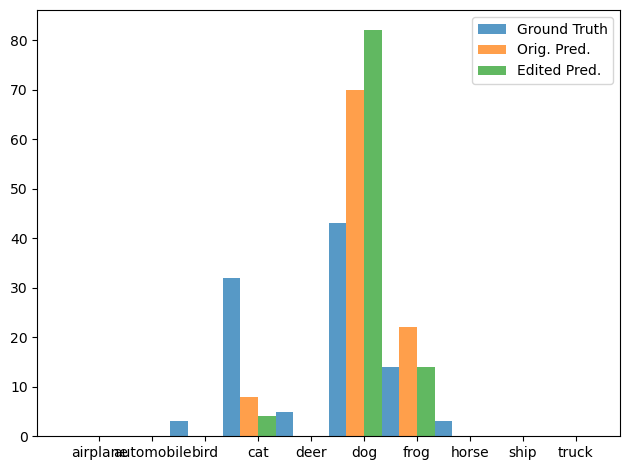

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/watershed_gaussian_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/watershed_gaussian_1/models
Finished trial 63/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/watershed_gaussian_1
(0113_174158) Starting Trial 64/2008...
Current run_id: 0113_160154/dog-train-n02117135_4084/watershed_gaussian_2
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/watershed_gaussian_2
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02117135_4084.png
Value images: saved/segmentations/dog/

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 32.21it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.005093027837574482 0.003515460528433323
L2 norm of weight change: 0.1469612419605255
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:24<00:00, 11.08it/s]


Post-edit metrics: {'TP': array([6140, 5455, 5171, 3743, 4281, 3110, 5714, 5161, 4776, 4587]), 'TN': array([60187, 61003, 59545, 60044, 60126, 61547, 60903, 61716, 61704,
       61363]), 'FPs': array([2813, 1997, 3455, 2956, 2874, 1453, 2097, 1284, 1296, 1637]), 'FNs': array([ 860, 1545, 1829, 3257, 2719, 3890, 1286, 1839, 2224, 2413]), 'accuracy': 0.6876857142857142, 'per_class_accuracy': array([0.94752857, 0.9494    , 0.92451429, 0.91124286, 0.9201    ,
       0.92367143, 0.95167143, 0.95538571, 0.94971429, 0.94214286]), 'per_class_accuracy_mean': 0.9375371428571428, 'precision': array([0.68580364, 0.73201825, 0.59946673, 0.55874011, 0.59832285,
       0.68156914, 0.73153245, 0.8007758 , 0.78656126, 0.73698586]), 'precision_mean': 0.6911776100017842, 'recall': array([0.87714286, 0.77928571, 0.73871429, 0.53471429, 0.61157143,
       0.44428571, 0.81628571, 0.73728571, 0.68228571, 0.65528571]), 'recall_mean': 0.6876857142857143, 'f1': array([0.76976117, 0.75491281, 0.66184564, 0.54646

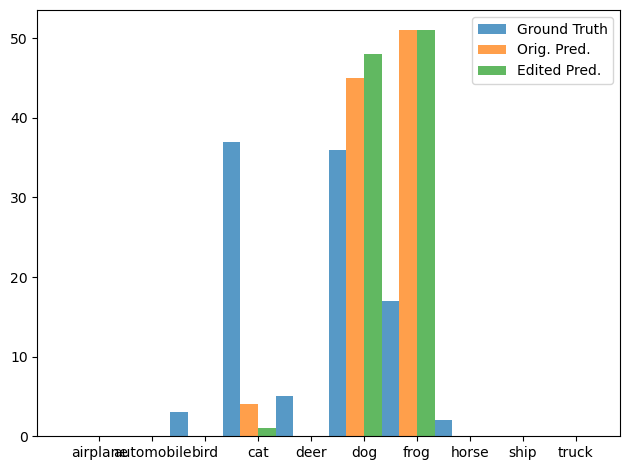

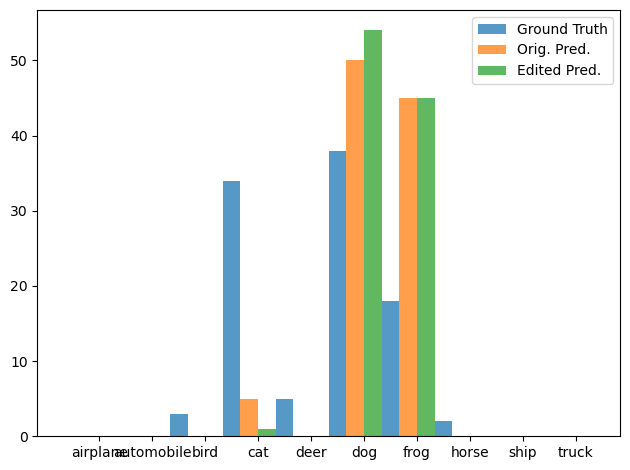

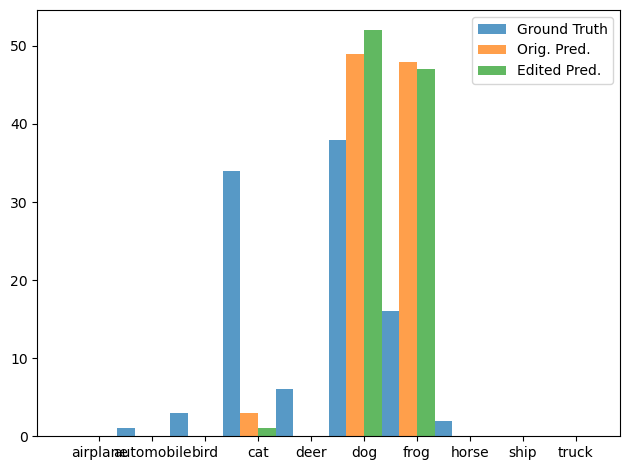

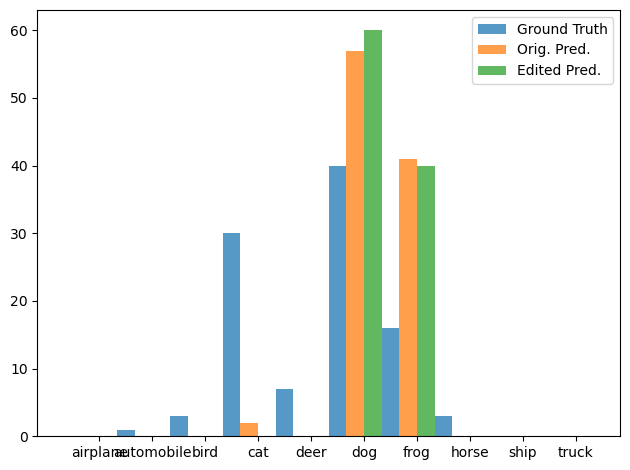

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/watershed_gaussian_2/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/watershed_gaussian_2/models
Finished trial 64/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/watershed_gaussian_2
(0113_174339) Starting Trial 65/2008...
Current run_id: 0113_160154/dog-train-n02117135_4084/watershed_gaussian_3
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/watershed_gaussian_3
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02117135_4084.png
Value images: saved/segmentations/dog/

100%|██████████████████████████████████████████| 274/274 [00:20<00:00, 13.49it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0038, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.030827678740024567 0.0037675932981073856
L2 norm of weight change: 0.16248507797718048
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:23<00:00, 11.51it/s]


Post-edit metrics: {'TP': array([6151, 5352, 5165, 3758, 4496, 2955, 5611, 5121, 4806, 4636]), 'TN': array([60108, 61189, 59528, 60058, 59495, 61765, 61183, 61721, 61668,
       61336]), 'FPs': array([2892, 1811, 3472, 2942, 3505, 1235, 1817, 1279, 1332, 1664]), 'FNs': array([ 849, 1648, 1835, 3242, 2504, 4045, 1389, 1879, 2194, 2364]), 'accuracy': 0.6864428571428571, 'per_class_accuracy': array([0.94655714, 0.95058571, 0.92418571, 0.91165714, 0.91415714,
       0.92457143, 0.9542    , 0.95488571, 0.94962857, 0.94245714]), 'per_class_accuracy_mean': 0.9372885714285714, 'precision': array([0.68019463, 0.74717297, 0.59800857, 0.56089552, 0.56192976,
       0.7052506 , 0.75538503, 0.80015625, 0.7829912 , 0.73587302]), 'precision_mean': 0.6927857541349048, 'recall': array([0.87871429, 0.76457143, 0.73785714, 0.53685714, 0.64228571,
       0.42214286, 0.80157143, 0.73157143, 0.68657143, 0.66228571]), 'recall_mean': 0.6864428571428571, 'f1': array([0.76681419, 0.75577208, 0.66061265, 0.54861

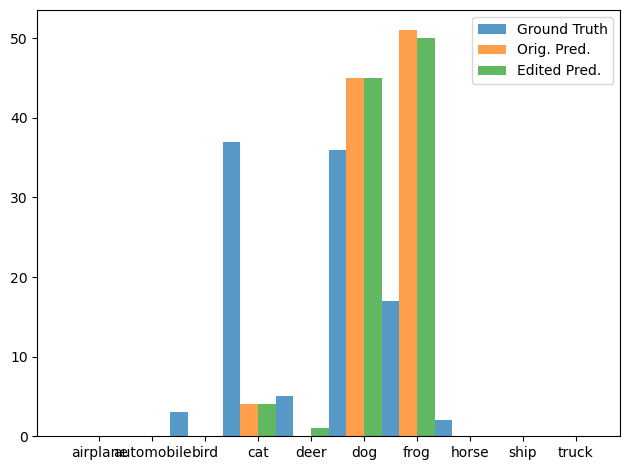

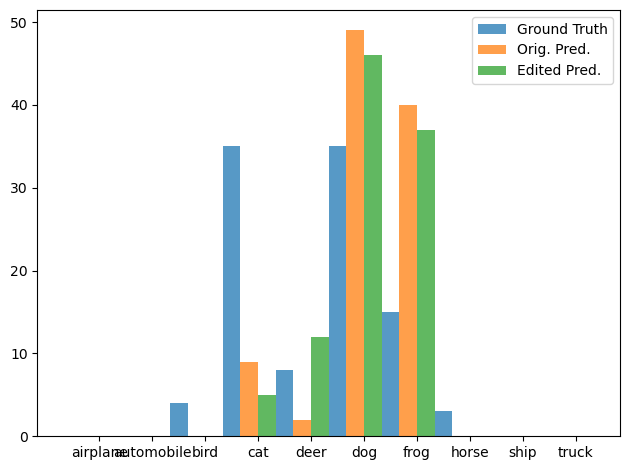

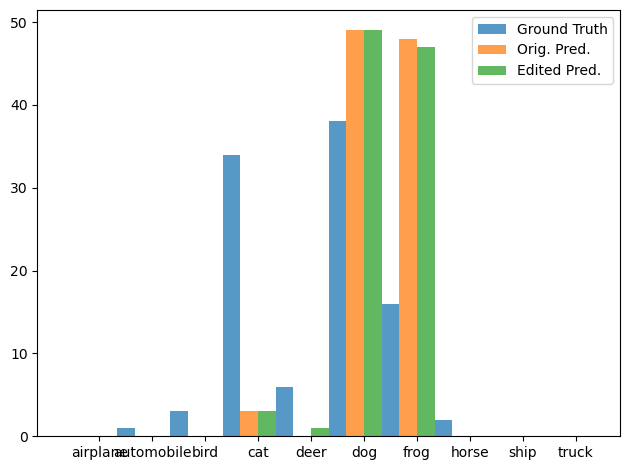

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/watershed_gaussian_3/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/watershed_gaussian_3/models
Finished trial 65/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/watershed_gaussian_3
(0113_174529) Starting Trial 66/2008...
Current run_id: 0113_160154/dog-train-n02117135_4084/watershed_gaussian_7
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/watershed_gaussian_7
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02117135_4084.png
Value images: saved/segmentations/dog/

100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 28.12it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.021894454956054688 0.002294680569320917
L2 norm of weight change: 0.16743165254592896
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:13<00:00, 20.42it/s]


Post-edit metrics: {'TP': array([6131, 5467, 5212, 3672, 4361, 3184, 5624, 5167, 4787, 4507]), 'TN': array([60213, 60990, 59399, 60208, 59870, 61439, 61115, 61680, 61692,
       61506]), 'FPs': array([2787, 2010, 3601, 2792, 3130, 1561, 1885, 1320, 1308, 1494]), 'FNs': array([ 869, 1533, 1788, 3328, 2639, 3816, 1376, 1833, 2213, 2493]), 'accuracy': 0.6873142857142858, 'per_class_accuracy': array([0.94777143, 0.94938571, 0.92301429, 0.91257143, 0.91758571,
       0.92318571, 0.95341429, 0.95495714, 0.9497    , 0.94304286]), 'per_class_accuracy_mean': 0.9374628571428569, 'precision': array([0.68748598, 0.73117561, 0.59139907, 0.56806931, 0.58216526,
       0.67102213, 0.74896791, 0.79651611, 0.78539787, 0.75104149]), 'precision_mean': 0.6913240733132131, 'recall': array([0.87585714, 0.781     , 0.74457143, 0.52457143, 0.623     ,
       0.45485714, 0.80342857, 0.73814286, 0.68385714, 0.64385714]), 'recall_mean': 0.6873142857142857, 'f1': array([0.7703229 , 0.75526698, 0.65920445, 0.54545

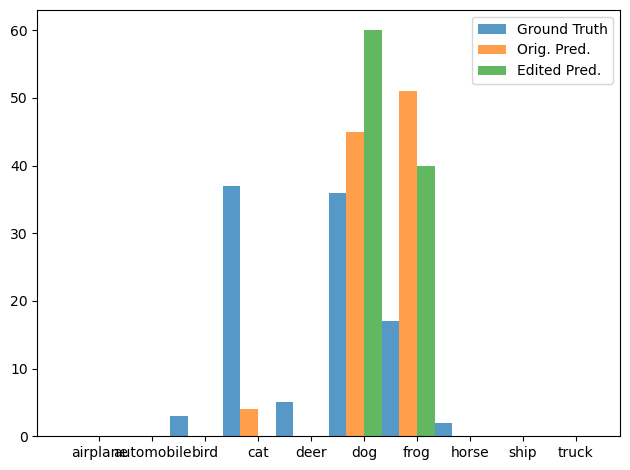

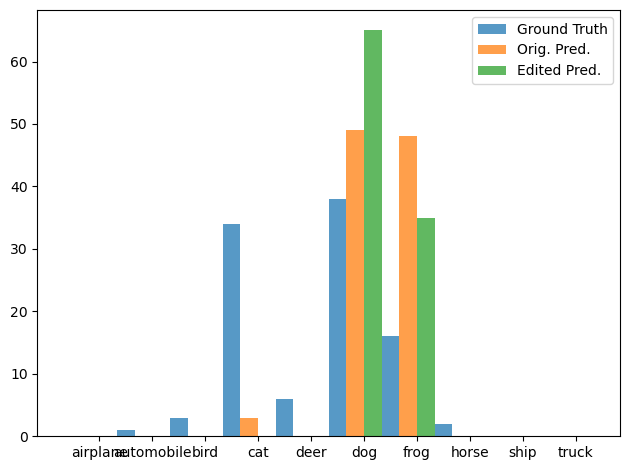

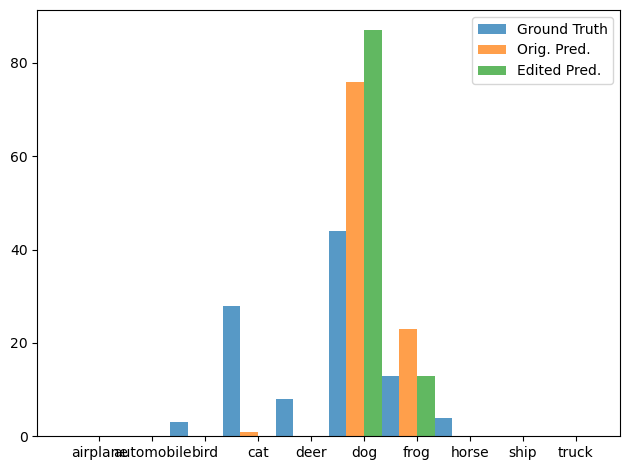

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/watershed_gaussian_7/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/watershed_gaussian_7/models
Finished trial 66/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/watershed_gaussian_7
(0113_174658) Starting Trial 67/2008...
Current run_id: 0113_160154/dog-train-n02117135_4084/watershed_masked_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/watershed_masked_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02117135_4084.png
Value images: saved/segmentations/dog/dog-

100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 29.21it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.06599967926740646 0.0031685982830822468
L2 norm of weight change: 0.25608885288238525
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 28.60it/s]


Post-edit metrics: {'TP': array([6091, 5519, 5264, 3732, 4226, 3557, 5353, 5199, 4855, 4409]), 'TN': array([60333, 60890, 59285, 60171, 60216, 60706, 61737, 61612, 61610,
       61645]), 'FPs': array([2667, 2110, 3715, 2829, 2784, 2294, 1263, 1388, 1390, 1355]), 'FNs': array([ 909, 1481, 1736, 3268, 2774, 3443, 1647, 1801, 2145, 2591]), 'accuracy': 0.6886428571428571, 'per_class_accuracy': array([0.94891429, 0.9487    , 0.92212857, 0.9129    , 0.9206    ,
       0.91804286, 0.95842857, 0.95444286, 0.9495    , 0.94362857]), 'per_class_accuracy_mean': 0.9377285714285716, 'precision': array([0.69547842, 0.72342378, 0.58625682, 0.56881573, 0.60285307,
       0.60793027, 0.80909915, 0.78928192, 0.77742194, 0.76492019]), 'precision_mean': 0.6925481287937965, 'recall': array([0.87014286, 0.78842857, 0.752     , 0.53314286, 0.60371429,
       0.50814286, 0.76471429, 0.74271429, 0.69357143, 0.62985714]), 'recall_mean': 0.6886428571428572, 'f1': array([0.77306765, 0.75452868, 0.65886476, 0.55040

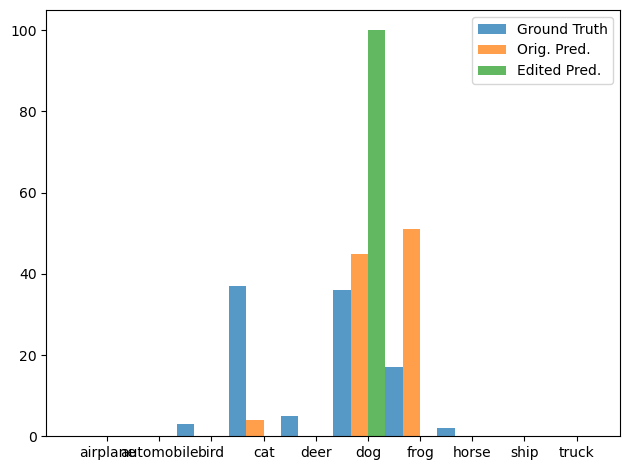

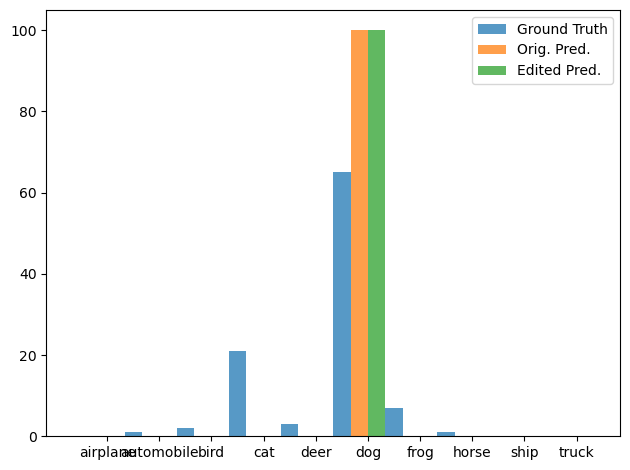

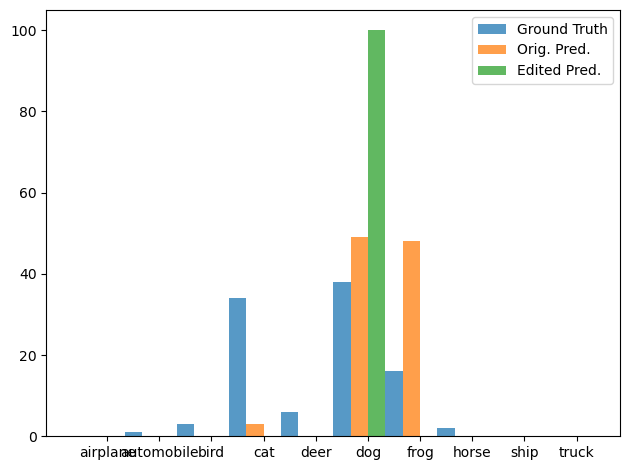

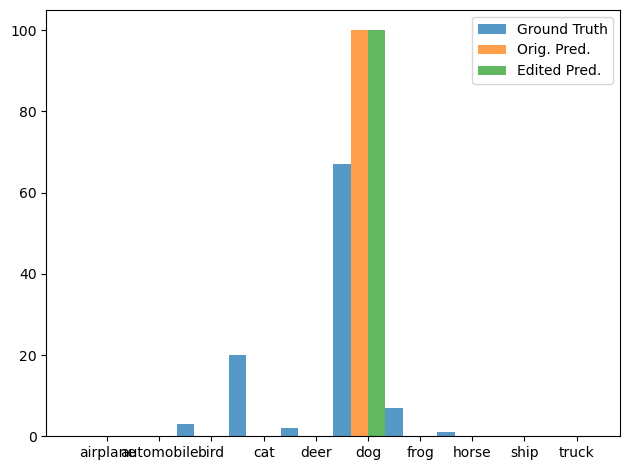

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/watershed_masked_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/watershed_masked_1/models
Finished trial 67/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/watershed_masked_1
(0113_174825) Starting Trial 68/2008...
Current run_id: 0113_160154/dog-train-n02117135_4084/watershed_masked_2
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/watershed_masked_2
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02117135_4084.png
Value images: saved/segmentations/dog/dog-train-

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 34.02it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.08709689974784851 0.0027511888183653355
L2 norm of weight change: 0.31410151720046997
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 29.95it/s]


Post-edit metrics: {'TP': array([6064, 5575, 5368, 3510, 4143, 3803, 5224, 5212, 4841, 4309]), 'TN': array([60448, 60784, 58883, 60596, 60396, 60044, 61971, 61578, 61597,
       61752]), 'FPs': array([2552, 2216, 4117, 2404, 2604, 2956, 1029, 1422, 1403, 1248]), 'FNs': array([ 936, 1425, 1632, 3490, 2857, 3197, 1776, 1788, 2159, 2691]), 'accuracy': 0.6864142857142858, 'per_class_accuracy': array([0.95017143, 0.94798571, 0.91787143, 0.9158    , 0.92198571,
       0.9121    , 0.95992857, 0.95414286, 0.94911429, 0.94372857]), 'per_class_accuracy_mean': 0.9372828571428572, 'precision': array([0.70380687, 0.71556925, 0.56594623, 0.59350693, 0.61405069,
       0.5626572 , 0.83543899, 0.78564968, 0.77530429, 0.77541839]), 'precision_mean': 0.6927348524175571, 'recall': array([0.86628571, 0.79642857, 0.76685714, 0.50142857, 0.59185714,
       0.54328571, 0.74628571, 0.74457143, 0.69157143, 0.61557143]), 'recall_mean': 0.6864142857142858, 'f1': array([0.77663934, 0.75383679, 0.65125872, 0.54359

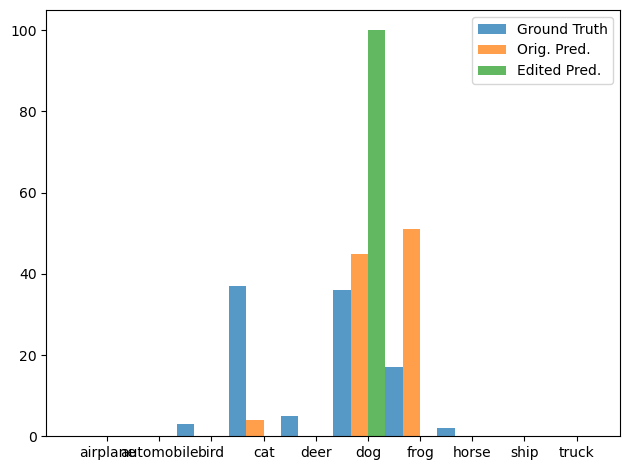

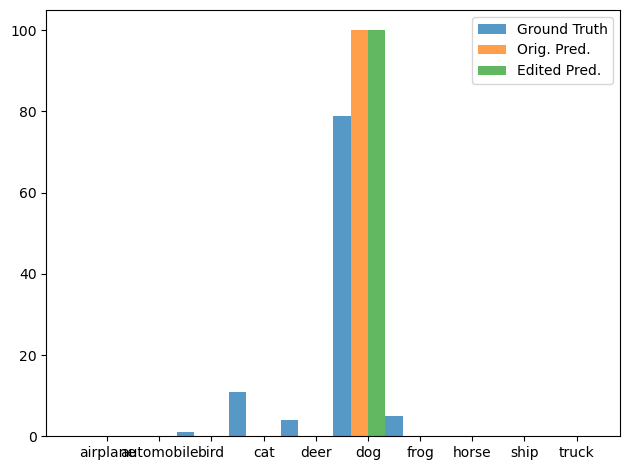

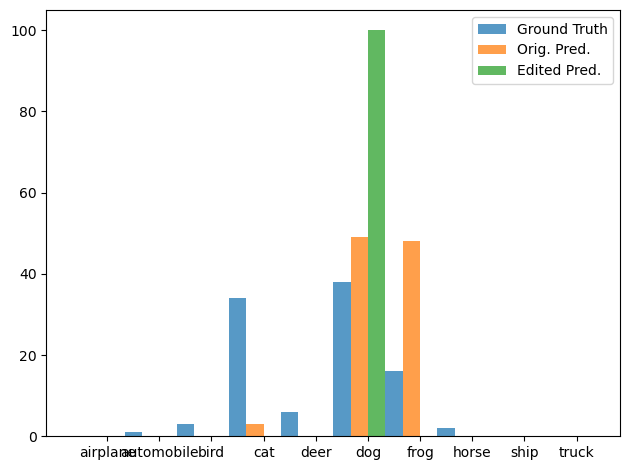

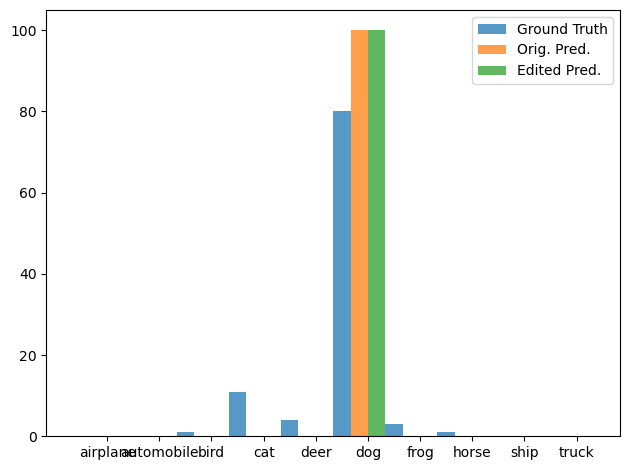

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/watershed_masked_2/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/watershed_masked_2/models
Finished trial 68/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/watershed_masked_2
(0113_174950) Starting Trial 69/2008...
Current run_id: 0113_160154/dog-train-n02117135_4084/watershed_masked_4
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/watershed_masked_4
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02117135_4084.png
Value images: saved/segmentations/dog/dog-train-

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 33.37it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0045, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.12272427976131439 0.004473604261875153
L2 norm of weight change: 0.5419061183929443
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 28.82it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:165: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:202: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6076, 5485, 5176, 3261, 4004, 4255,    0, 5272, 4883, 4261]), 'TN': array([60402, 60951, 59636, 60898, 60713, 52271, 63000, 61451, 61529,
       61822]), 'FPs': array([ 2598,  2049,  3364,  2102,  2287, 10729,     0,  1549,  1471,
        1178]), 'FNs': array([ 924, 1515, 1824, 3739, 2996, 2745, 7000, 1728, 2117, 2739]), 'accuracy': 0.6096142857142857, 'per_class_accuracy': array([0.94968571, 0.94908571, 0.92588571, 0.91655714, 0.92452857,
       0.80751429, 0.9       , 0.95318571, 0.94874286, 0.94404286]), 'per_class_accuracy_mean': 0.9219228571428573, 'precision': array([0.70048421, 0.72803292, 0.60608899, 0.60805519, 0.63646479,
       0.28396957, 0.        , 0.7729072 , 0.76849229, 0.78341607]), 'precision_mean': 0.5887911223396916, 'recall': array([0.868     , 0.78357143, 0.73942857, 0.46585714, 0.572     ,
       0.60785714, 0.        , 0.75314286, 0.69757143, 0.60871429]), 'recall_mean': 0.6096142857142858, 'f1': array([0.77529667, 0.75478189, 0.

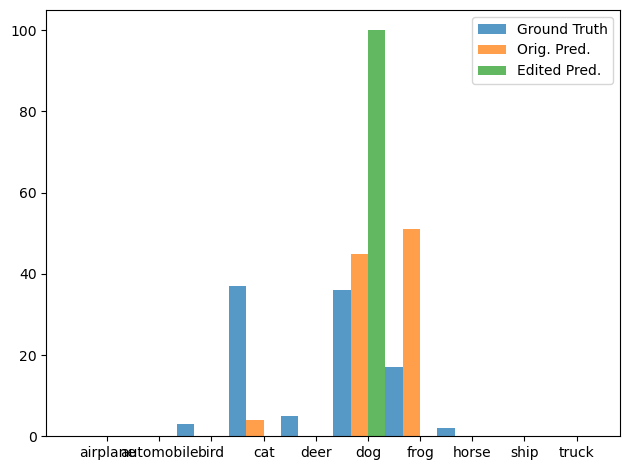

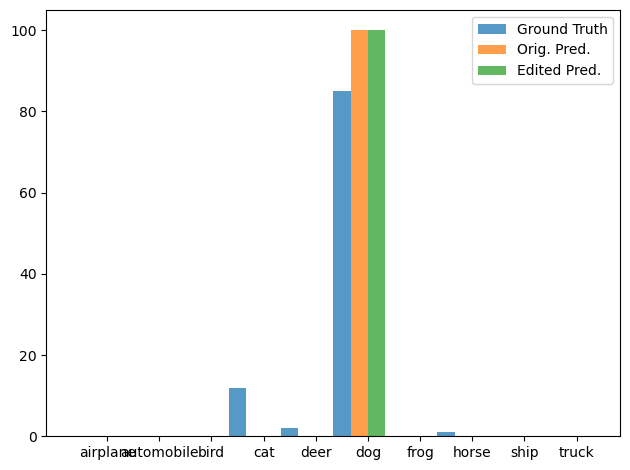

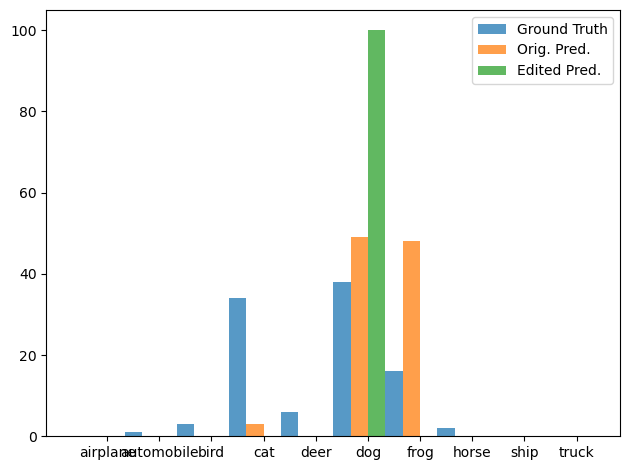

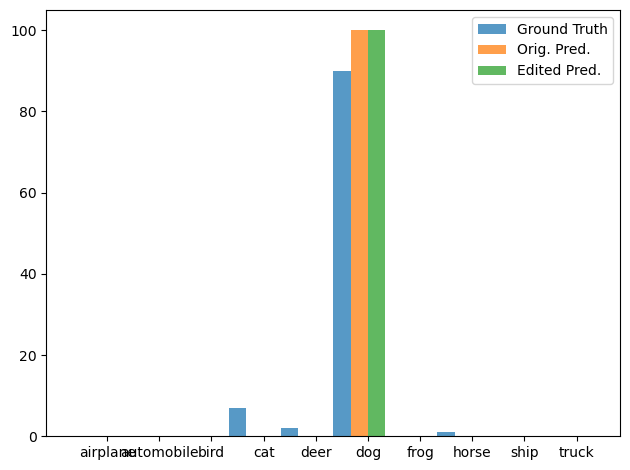

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/watershed_masked_4/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/watershed_masked_4/models
Finished trial 69/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/watershed_masked_4
(0113_175113) Starting Trial 70/2008...
Current run_id: 0113_160154/dog-train-n02117135_4084/watershed_masked_8
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/watershed_masked_8
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02117135_4084.png
Value images: saved/segmentations/dog/dog-train-

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 34.02it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.01067294180393219 0.0033059632405638695
L2 norm of weight change: 0.11553450673818588
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 30.59it/s]


Post-edit metrics: {'TP': array([6140, 5383, 5162, 3937, 4211, 3012, 5663, 5155, 4797, 4705]), 'TN': array([60131, 61137, 59583, 59669, 60283, 61719, 61088, 61700, 61689,
       61166]), 'FPs': array([2869, 1863, 3417, 3331, 2717, 1281, 1912, 1300, 1311, 1834]), 'FNs': array([ 860, 1617, 1838, 3063, 2789, 3988, 1337, 1845, 2203, 2295]), 'accuracy': 0.6880714285714286, 'per_class_accuracy': array([0.94672857, 0.95028571, 0.92492857, 0.90865714, 0.92134286,
       0.92472857, 0.95358571, 0.95507143, 0.9498    , 0.94101429]), 'per_class_accuracy_mean': 0.9376142857142856, 'precision': array([0.68154068, 0.74289263, 0.60170183, 0.5416896 , 0.60782333,
       0.70160727, 0.74759076, 0.79860573, 0.78536346, 0.71952898]), 'precision_mean': 0.6928344262319831, 'recall': array([0.87714286, 0.769     , 0.73742857, 0.56242857, 0.60157143,
       0.43028571, 0.809     , 0.73642857, 0.68528571, 0.67214286]), 'recall_mean': 0.6880714285714286, 'f1': array([0.76706852, 0.7557209 , 0.66268695, 0.55186

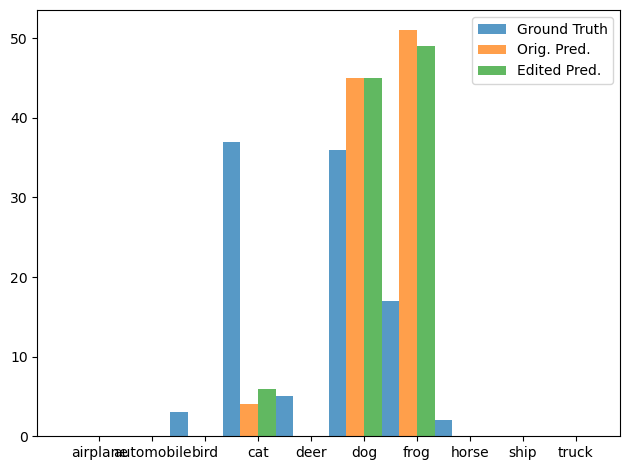

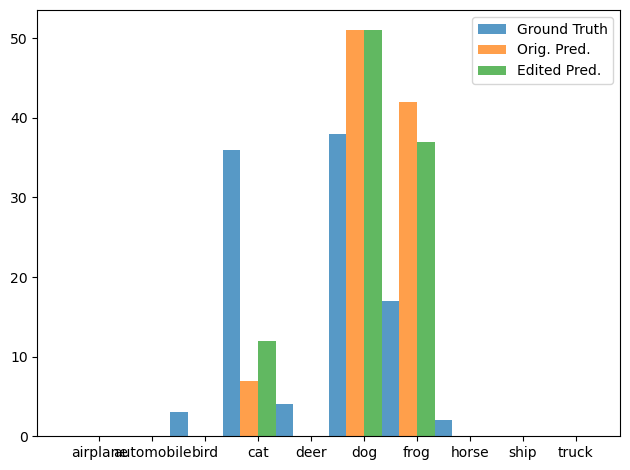

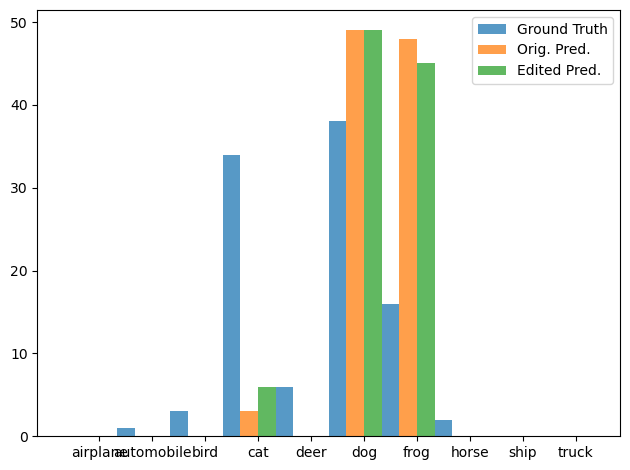

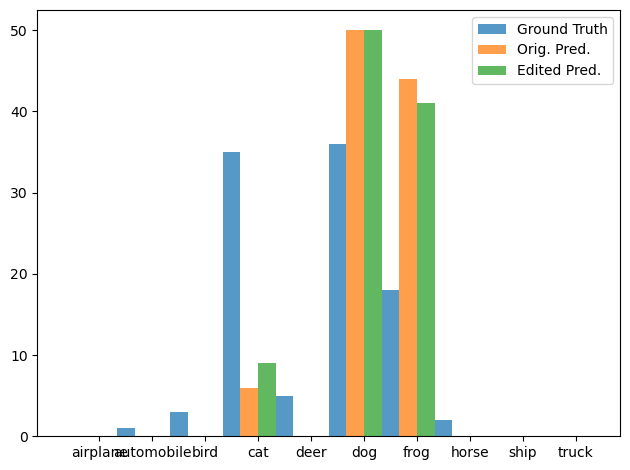

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/watershed_masked_8/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/watershed_masked_8/models
Finished trial 70/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_4084/watershed_masked_8
(0113_175239) Starting Trial 71/2008...
Current run_id: 0113_160154/dog-train-n02087551_7927/watershed_masked_8
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02087551_7927/watershed_masked_8
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02087551_7927.png
Value images: saved/segmentations/dog/dog-train-

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 33.96it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0051, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.09257344901561737 0.005053948611021042
L2 norm of weight change: 0.28675851225852966
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 30.92it/s]


Post-edit metrics: {'TP': array([6034, 5548, 4405, 3904, 4269, 3683, 5713, 5124, 4979, 4544]), 'TN': array([60664, 60765, 61481, 59663, 60138, 59843, 61062, 61783, 61422,
       61382]), 'FPs': array([2336, 2235, 1519, 3337, 2862, 3157, 1938, 1217, 1578, 1618]), 'FNs': array([ 966, 1452, 2595, 3096, 2731, 3317, 1287, 1876, 2021, 2456]), 'accuracy': 0.6886142857142857, 'per_class_accuracy': array([0.95282857, 0.94732857, 0.94122857, 0.9081    , 0.9201    ,
       0.90751429, 0.95392857, 0.95581429, 0.94858571, 0.9418    ]), 'per_class_accuracy_mean': 0.9377228571428573, 'precision': array([0.720908  , 0.71283567, 0.74358542, 0.53915205, 0.59865377,
       0.53845029, 0.74669978, 0.80807444, 0.75934116, 0.73742291]), 'precision_mean': 0.6905123486759572, 'recall': array([0.862     , 0.79257143, 0.62928571, 0.55771429, 0.60985714,
       0.52614286, 0.81614286, 0.732     , 0.71128571, 0.64914286]), 'recall_mean': 0.6886142857142857, 'f1': array([0.78516591, 0.7505919 , 0.6816775 , 0.54827

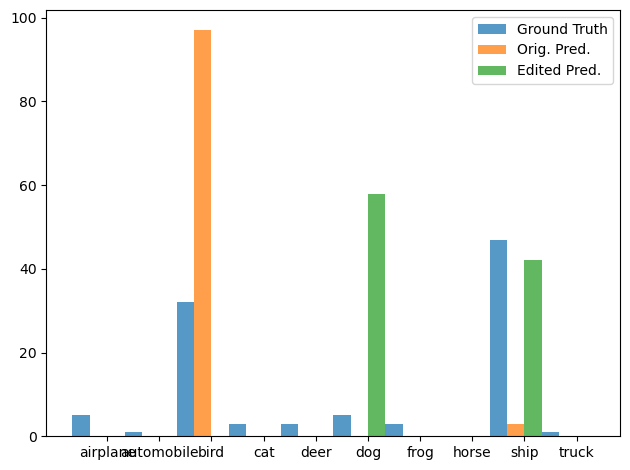

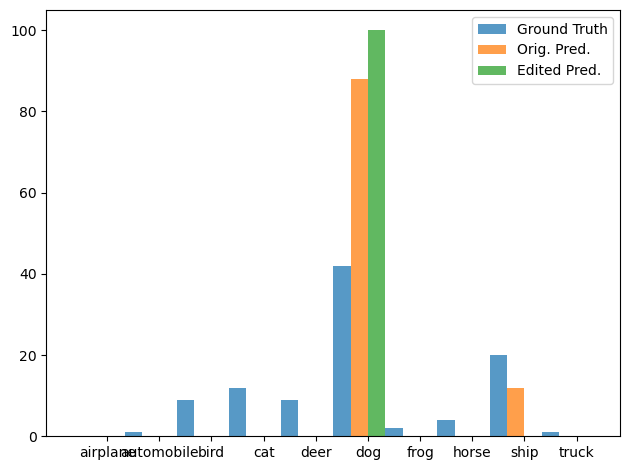

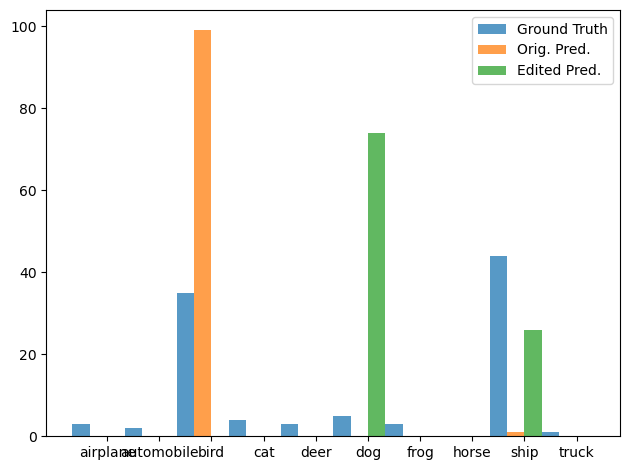

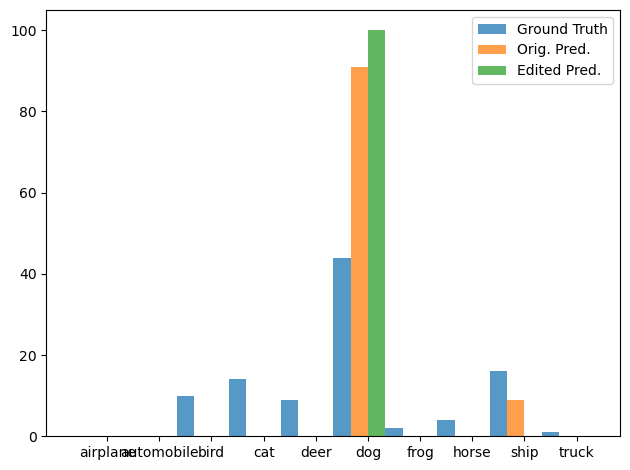

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02087551_7927/watershed_masked_8/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02087551_7927/watershed_masked_8/models
Finished trial 71/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02087551_7927/watershed_masked_8
(0113_175404) Starting Trial 72/2008...
Current run_id: 0113_160154/dog-train-n02117135_15001/slic_masked_3
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_15001/slic_masked_3
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02117135_15001.png
Value images: saved/segmentations/dog/dog-train-n021171

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 34.04it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0378, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.11960605531930923 0.037763237953186035
L2 norm of weight change: 0.27301472425460815
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 29.98it/s]


Post-edit metrics: {'TP': array([6125, 5464, 5286, 4021, 3572, 3280, 5611, 5291, 4787, 4663]), 'TN': array([60200, 60950, 59194, 59496, 61510, 61226, 61193, 61483, 61673,
       61175]), 'FPs': array([2800, 2050, 3806, 3504, 1490, 1774, 1807, 1517, 1327, 1825]), 'FNs': array([ 875, 1536, 1714, 2979, 3428, 3720, 1389, 1709, 2213, 2337]), 'accuracy': 0.6871428571428572, 'per_class_accuracy': array([0.9475    , 0.94877143, 0.92114286, 0.90738571, 0.92974286,
       0.92151429, 0.95434286, 0.95391429, 0.94942857, 0.94054286]), 'per_class_accuracy_mean': 0.9374285714285714, 'precision': array([0.68627451, 0.72717594, 0.58139023, 0.53435216, 0.70564994,
       0.6489909 , 0.75640334, 0.77717391, 0.78295715, 0.71871147]), 'precision_mean': 0.6919079550843472, 'recall': array([0.875     , 0.78057143, 0.75514286, 0.57442857, 0.51028571,
       0.46857143, 0.80157143, 0.75585714, 0.68385714, 0.66614286]), 'recall_mean': 0.6871428571428572, 'f1': array([0.76923077, 0.75292821, 0.65697241, 0.55366

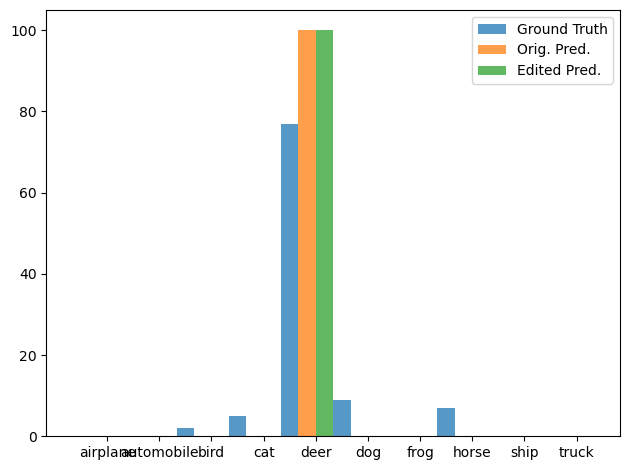

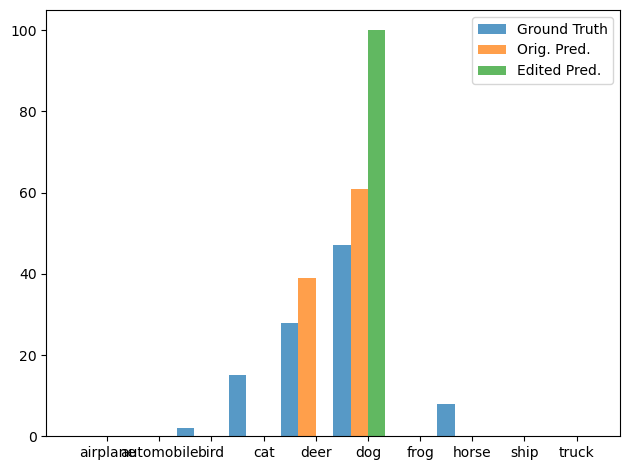

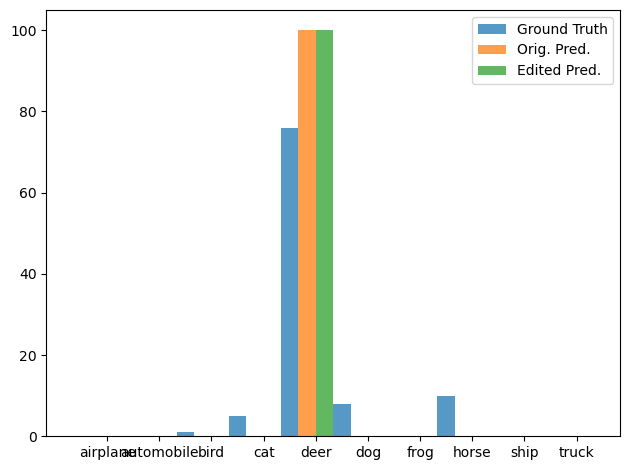

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_15001/slic_masked_3/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_15001/slic_masked_3/models
Finished trial 72/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117135_15001/slic_masked_3
(0113_175529) Starting Trial 73/2008...
Current run_id: 0113_160154/dog-train-n02117512_3536/felzenszwalb_masked_2
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117512_3536/felzenszwalb_masked_2
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02117512_3536.png
Value images: saved/segmentations/dog/dog-train-n02117

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 33.54it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.09456318616867065 0.00426783412694931
L2 norm of weight change: 0.3264302909374237
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:11<00:00, 23.08it/s]


Post-edit metrics: {'TP': array([6053, 5500, 5533, 3793, 3224, 3816, 5192, 5247, 4816, 4457]), 'TN': array([60473, 60921, 58181, 59997, 61923, 59351, 61954, 61622, 61627,
       61582]), 'FPs': array([2527, 2079, 4819, 3003, 1077, 3649, 1046, 1378, 1373, 1418]), 'FNs': array([ 947, 1500, 1467, 3207, 3776, 3184, 1808, 1753, 2184, 2543]), 'accuracy': 0.6804428571428571, 'per_class_accuracy': array([0.95037143, 0.94887143, 0.9102    , 0.91128571, 0.93067143,
       0.90238571, 0.95922857, 0.95527143, 0.94918571, 0.94341429]), 'per_class_accuracy_mean': 0.9360885714285715, 'precision': array([0.70547786, 0.7256894 , 0.53448609, 0.55812242, 0.74959312,
       0.51118553, 0.83231805, 0.792     , 0.77815479, 0.7586383 ]), 'precision_mean': 0.6945665564664805, 'recall': array([0.86471429, 0.78571429, 0.79042857, 0.54185714, 0.46057143,
       0.54514286, 0.74171429, 0.74957143, 0.688     , 0.63671429]), 'recall_mean': 0.6804428571428571, 'f1': array([0.77702182, 0.75450991, 0.63773628, 0.54986

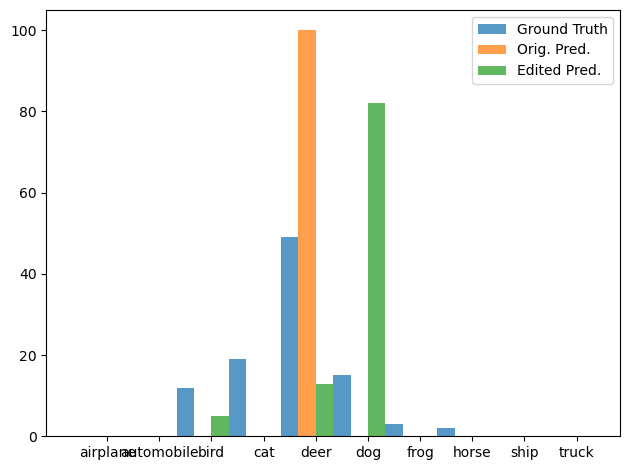

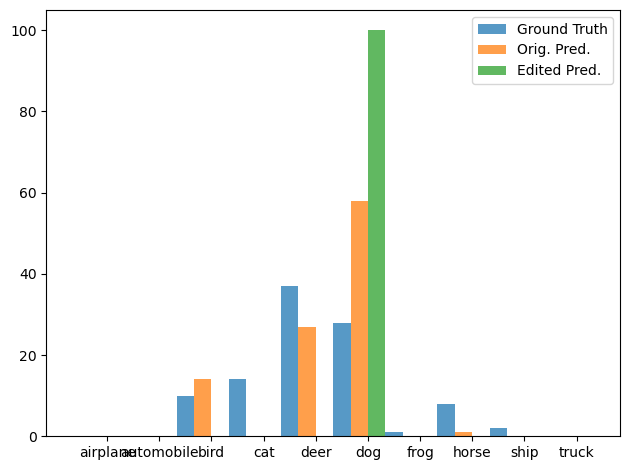

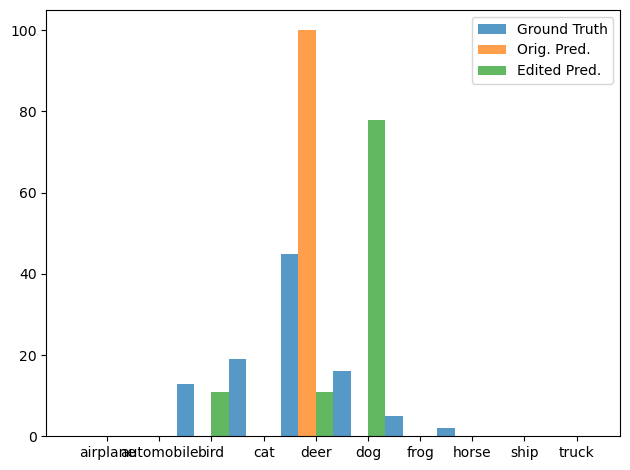

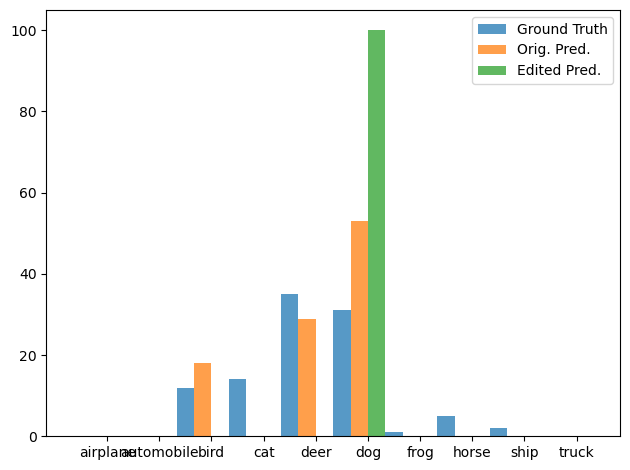

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117512_3536/felzenszwalb_masked_2/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117512_3536/felzenszwalb_masked_2/models
Finished trial 73/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117512_3536/felzenszwalb_masked_2
(0113_175656) Starting Trial 74/2008...
Current run_id: 0113_160154/dog-train-n02117512_3536/watershed_masked_6
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117512_3536/watershed_masked_6
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02117512_3536.png
Value images: saved/segmentations/dog/d

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 33.50it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0051, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.11207862198352814 0.005130971781909466
L2 norm of weight change: 0.38546061515808105
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:16<00:00, 16.91it/s]


Post-edit metrics: {'TP': array([6027, 5581, 5069, 3680,   58, 4649, 5282, 5114, 4852, 4443]), 'TN': array([60659, 60747, 59992, 60165, 63000, 53230, 61943, 61832, 61609,
       61578]), 'FPs': array([2341, 2253, 3008, 2835,    0, 9770, 1057, 1168, 1391, 1422]), 'FNs': array([ 973, 1419, 1931, 3320, 6942, 2351, 1718, 1886, 2148, 2557]), 'accuracy': 0.6393571428571428, 'per_class_accuracy': array([0.95265714, 0.94754286, 0.92944286, 0.91207143, 0.90082857,
       0.82684286, 0.96035714, 0.95637143, 0.94944286, 0.94315714]), 'per_class_accuracy_mean': 0.9278714285714285, 'precision': array([0.72024379, 0.71240745, 0.6275845 , 0.56485035, 1.        ,
       0.3224218 , 0.83325446, 0.81407195, 0.77719045, 0.75754476]), 'precision_mean': 0.7129569508138712, 'recall': array([0.861     , 0.79728571, 0.72414286, 0.52571429, 0.00828571,
       0.66414286, 0.75457143, 0.73057143, 0.69314286, 0.63471429]), 'recall_mean': 0.6393571428571428, 'f1': array([0.78435711, 0.75246056, 0.67241494, 0.54458

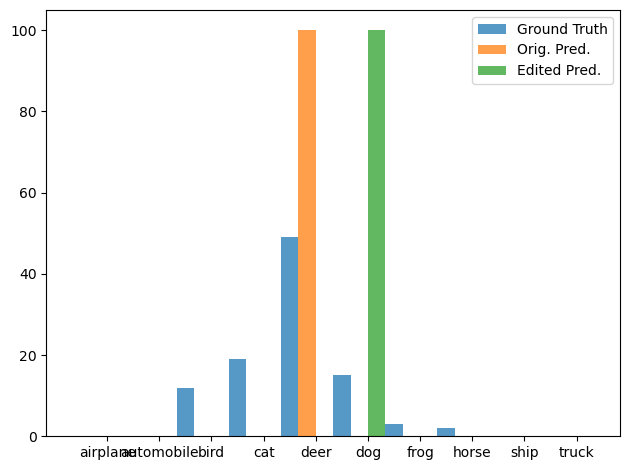

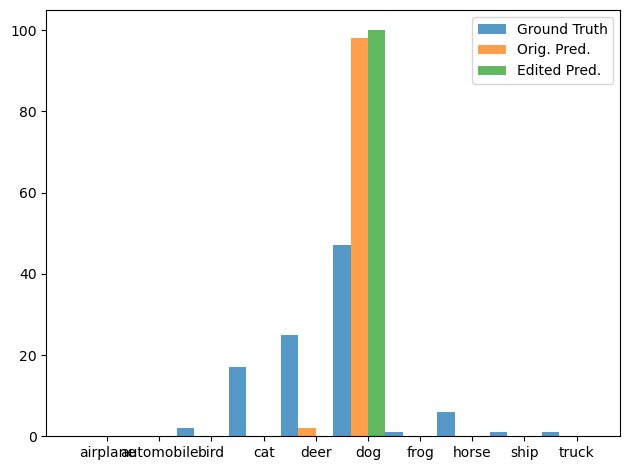

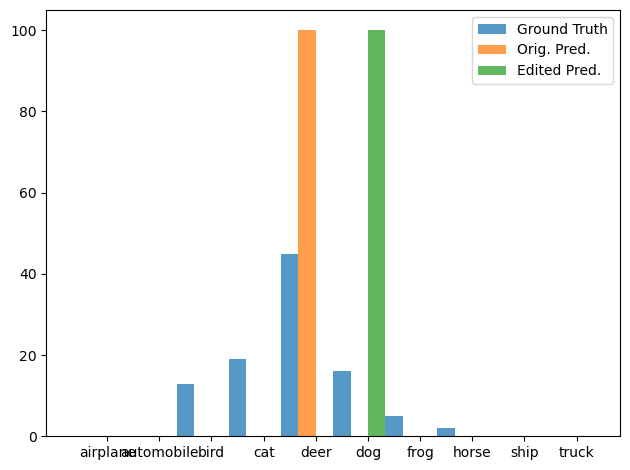

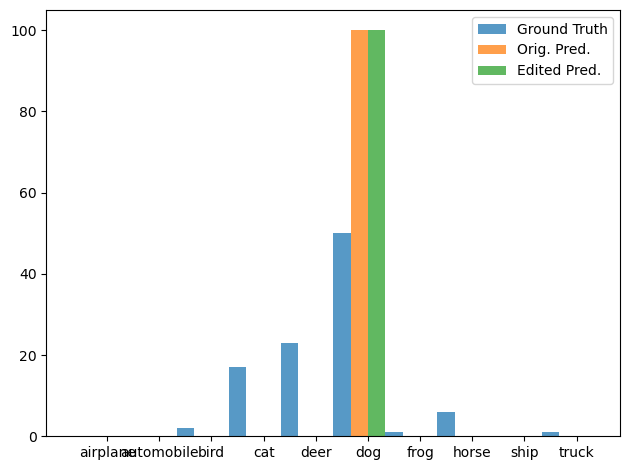

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117512_3536/watershed_masked_6/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117512_3536/watershed_masked_6/models
Finished trial 74/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02117512_3536/watershed_masked_6
(0113_175830) Starting Trial 75/2008...
Current run_id: 0113_160154/dog-train-n02114712_3011/watershed_gaussian_7
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02114712_3011/watershed_gaussian_7
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02114712_3011.png
Value images: saved/segmentations/dog/dog-tr

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 33.58it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0075, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.12157341092824936 0.0075102983973920345
L2 norm of weight change: 0.3461313545703888
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:12<00:00, 22.73it/s]


Post-edit metrics: {'TP': array([6018, 5454, 4977, 3752, 4476, 3279, 5952, 3639, 5093, 4374]), 'TN': array([60664, 61031, 60094, 59679, 59277, 60810, 59768, 62810, 61191,
       61690]), 'FPs': array([2336, 1969, 2906, 3321, 3723, 2190, 3232,  190, 1809, 1310]), 'FNs': array([ 982, 1546, 2023, 3248, 2524, 3721, 1048, 3361, 1907, 2626]), 'accuracy': 0.6716285714285715, 'per_class_accuracy': array([0.9526    , 0.94978571, 0.92958571, 0.90615714, 0.91075714,
       0.91555714, 0.93885714, 0.94927143, 0.94691429, 0.94377143]), 'per_class_accuracy_mean': 0.9343257142857144, 'precision': array([0.72037347, 0.73474337, 0.63135862, 0.53046798, 0.54592023,
       0.59956116, 0.64808362, 0.95037869, 0.73790206, 0.7695285 ]), 'precision_mean': 0.6868317703798802, 'recall': array([0.85971429, 0.77914286, 0.711     , 0.536     , 0.63942857,
       0.46842857, 0.85028571, 0.51985714, 0.72757143, 0.62485714]), 'recall_mean': 0.6716285714285714, 'f1': array([0.78389996, 0.75629203, 0.66881677, 0.53321

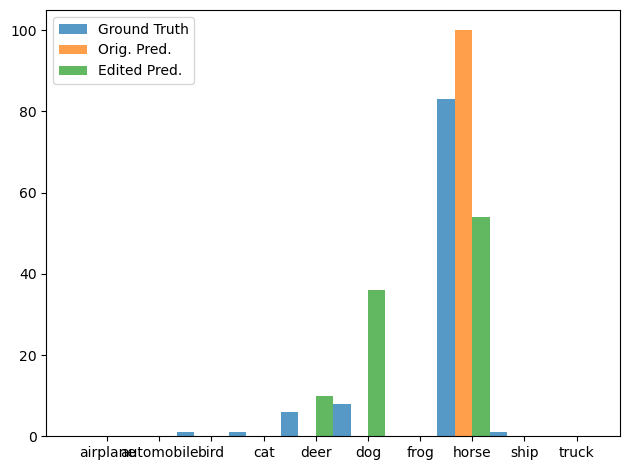

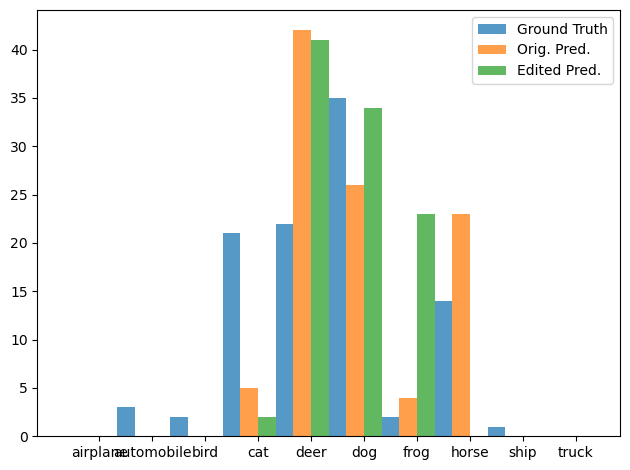

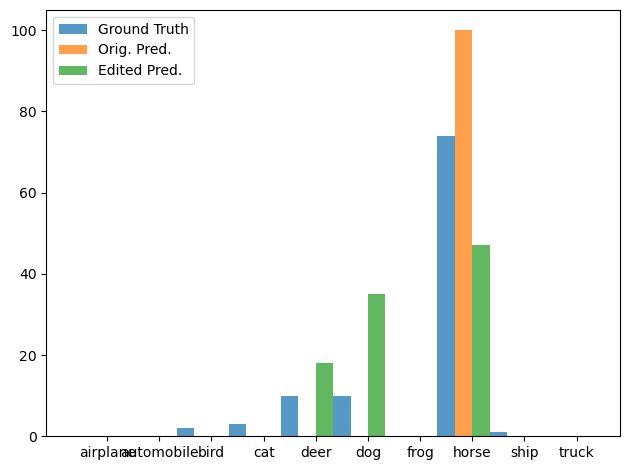

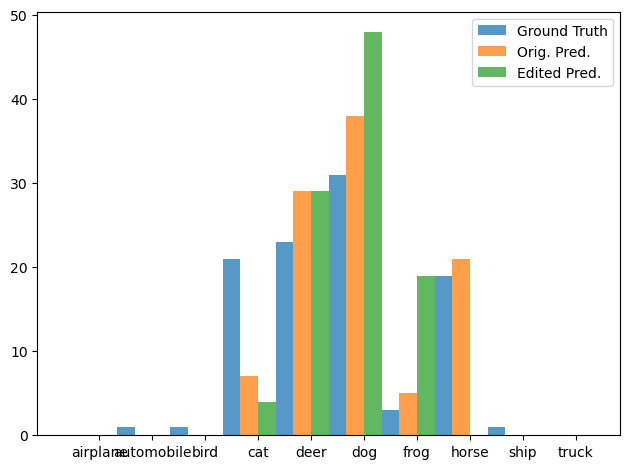

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02114712_3011/watershed_gaussian_7/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02114712_3011/watershed_gaussian_7/models
Finished trial 75/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02114712_3011/watershed_gaussian_7
(0113_180000) Starting Trial 76/2008...
Current run_id: 0113_160154/dog-train-n02087122_3666/felzenszwalb_masked_4
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02087122_3666/felzenszwalb_masked_4
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02087122_3666.png
Value images: saved/segmentations/do

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 32.57it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0084, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.0528024360537529 0.008359933272004128
L2 norm of weight change: 0.18248796463012695
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:10<00:00, 26.35it/s]


Post-edit metrics: {'TP': array([6126, 5414, 4843, 3978, 4313, 3199, 5650, 5226, 4836, 4690]), 'TN': array([60295, 61055, 60527, 59549, 60000, 61313, 61132, 61551, 61670,
       61183]), 'FPs': array([2705, 1945, 2473, 3451, 3000, 1687, 1868, 1449, 1330, 1817]), 'FNs': array([ 874, 1586, 2157, 3022, 2687, 3801, 1350, 1774, 2164, 2310]), 'accuracy': 0.6896428571428571, 'per_class_accuracy': array([0.94887143, 0.94955714, 0.93385714, 0.90752857, 0.91875714,
       0.9216    , 0.95402857, 0.95395714, 0.95008571, 0.94104286]), 'per_class_accuracy_mean': 0.9379285714285714, 'precision': array([0.69369267, 0.73569779, 0.66197376, 0.53546911, 0.58977164,
       0.65472779, 0.75152966, 0.78292135, 0.78430101, 0.72076226]), 'precision_mean': 0.6910847027511092, 'recall': array([0.87514286, 0.77342857, 0.69185714, 0.56828571, 0.61614286,
       0.457     , 0.80714286, 0.74657143, 0.69085714, 0.67      ]), 'recall_mean': 0.6896428571428572, 'f1': array([0.77392458, 0.75409151, 0.67658564, 0.55138

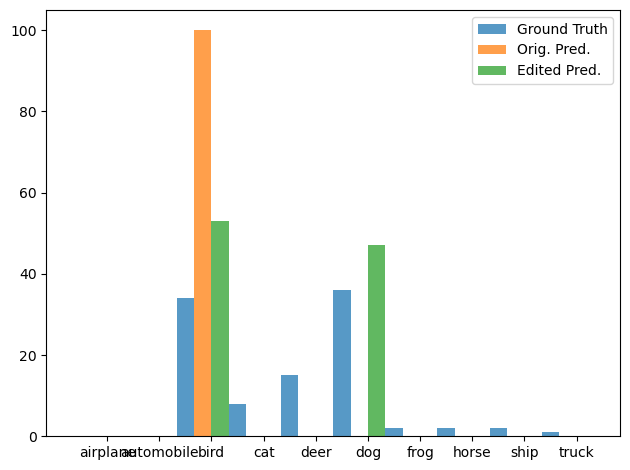

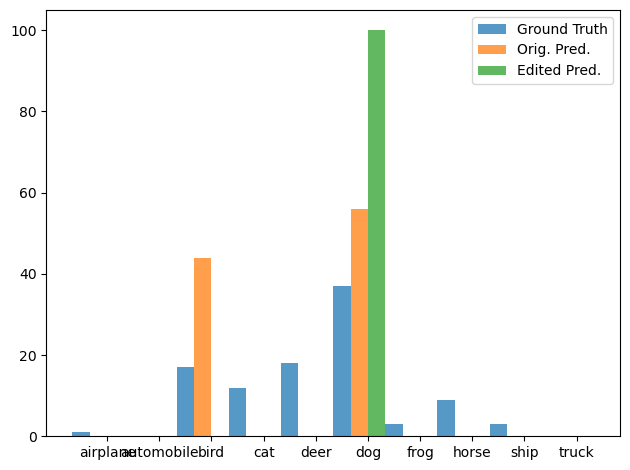

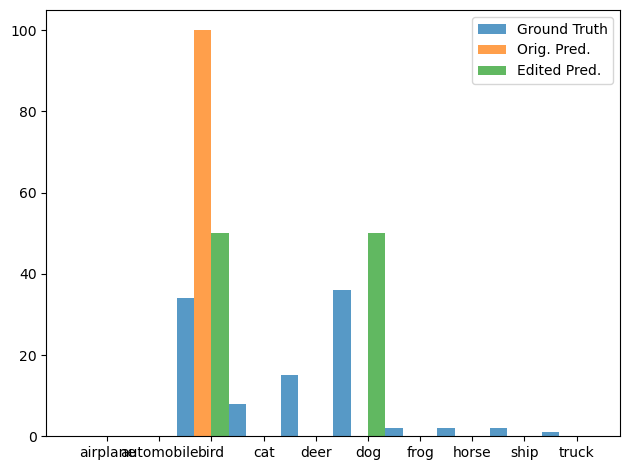

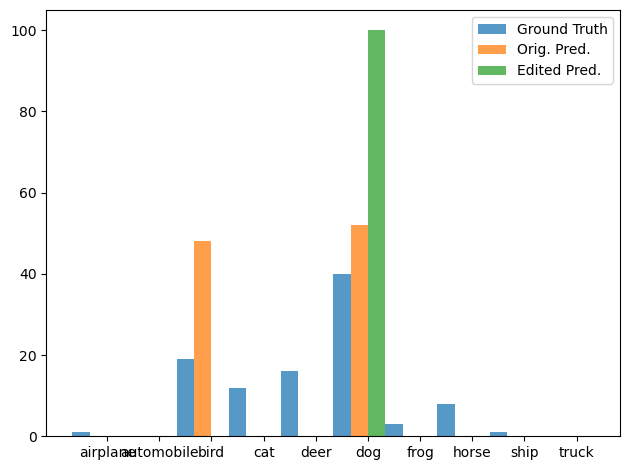

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02087122_3666/felzenszwalb_masked_4/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02087122_3666/felzenszwalb_masked_4/models
Finished trial 76/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02087122_3666/felzenszwalb_masked_4
(0113_180128) Starting Trial 77/2008...
Current run_id: 0113_160154/dog-train-n02087122_3666/watershed_masked_5
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02087122_3666/watershed_masked_5
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02087122_3666.png
Value images: saved/segmentations/dog/d

100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 28.27it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.09861642122268677 0.00444759801030159
L2 norm of weight change: 0.31551089882850647
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 29.93it/s]


Post-edit metrics: {'TP': array([6061, 5499, 4105, 4062, 4266, 3653, 5739, 5111, 4934, 4619]), 'TN': array([60597, 60905, 61867, 59217, 60125, 59676, 61026, 61805, 61523,
       61308]), 'FPs': array([2403, 2095, 1133, 3783, 2875, 3324, 1974, 1195, 1477, 1692]), 'FNs': array([ 939, 1501, 2895, 2938, 2734, 3347, 1261, 1889, 2066, 2381]), 'accuracy': 0.6864142857142858, 'per_class_accuracy': array([0.95225714, 0.94862857, 0.94245714, 0.90398571, 0.91987143,
       0.9047    , 0.95378571, 0.95594286, 0.94938571, 0.94181429]), 'per_class_accuracy_mean': 0.9372828571428571, 'precision': array([0.71609168, 0.72412431, 0.78369607, 0.51778203, 0.59739532,
       0.52357747, 0.74406846, 0.81049794, 0.76961472, 0.73189669]), 'precision_mean': 0.691874468400329, 'recall': array([0.86585714, 0.78557143, 0.58642857, 0.58028571, 0.60942857,
       0.52185714, 0.81985714, 0.73014286, 0.70485714, 0.65985714]), 'recall_mean': 0.6864142857142856, 'f1': array([0.78388515, 0.75359737, 0.67086125, 0.547254

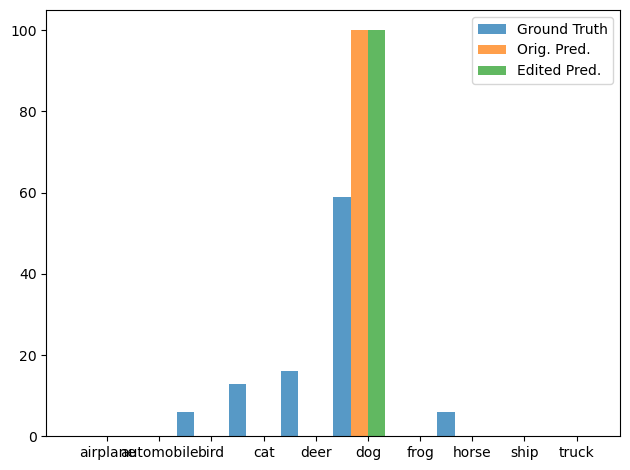

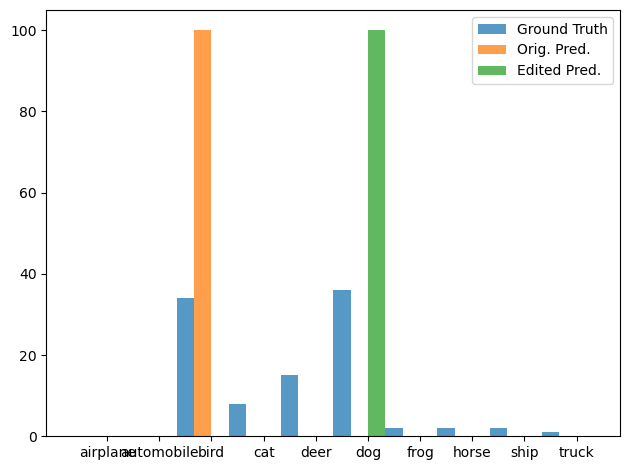

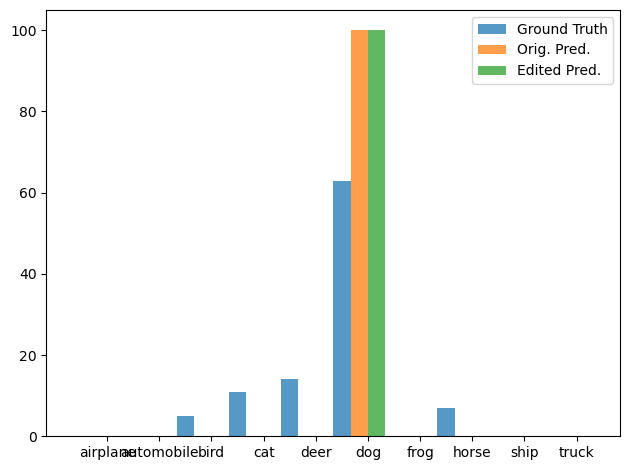

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02087122_3666/watershed_masked_5/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02087122_3666/watershed_masked_5/models
Finished trial 77/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02087122_3666/watershed_masked_5
(0113_180256) Starting Trial 78/2008...
Current run_id: 0113_160154/dog-train-n02086079_9352/felzenszwalb_gaussian_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/felzenszwalb_gaussian_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02086079_9352.png
Value images: saved/segmentations/dog/

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 33.43it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0038, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.026955239474773407 0.0038439021445810795
L2 norm of weight change: 0.18099524080753326
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:20<00:00, 13.42it/s]


Post-edit metrics: {'TP': array([6078, 5476, 5099, 3716, 4295, 3321, 5675, 5146, 4917, 4604]), 'TN': array([60449, 60959, 59833, 60180, 60068, 61224, 61044, 61731, 61531,
       61308]), 'FPs': array([2551, 2041, 3167, 2820, 2932, 1776, 1956, 1269, 1469, 1692]), 'FNs': array([ 922, 1524, 1901, 3284, 2705, 3679, 1325, 1854, 2083, 2396]), 'accuracy': 0.6903857142857143, 'per_class_accuracy': array([0.95038571, 0.94907143, 0.9276    , 0.9128    , 0.91947143,
       0.92207143, 0.95312857, 0.95538571, 0.94925714, 0.9416    ]), 'per_class_accuracy_mean': 0.9380771428571428, 'precision': array([0.70436899, 0.72848211, 0.61686426, 0.56854345, 0.59429916,
       0.65155974, 0.74367711, 0.80218239, 0.76996555, 0.73125794]), 'precision_mean': 0.6911200690149675, 'recall': array([0.86828571, 0.78228571, 0.72842857, 0.53085714, 0.61357143,
       0.47442857, 0.81071429, 0.73514286, 0.70242857, 0.65771429]), 'recall_mean': 0.6903857142857143, 'f1': array([0.77778489, 0.75442585, 0.66802044, 0.54905

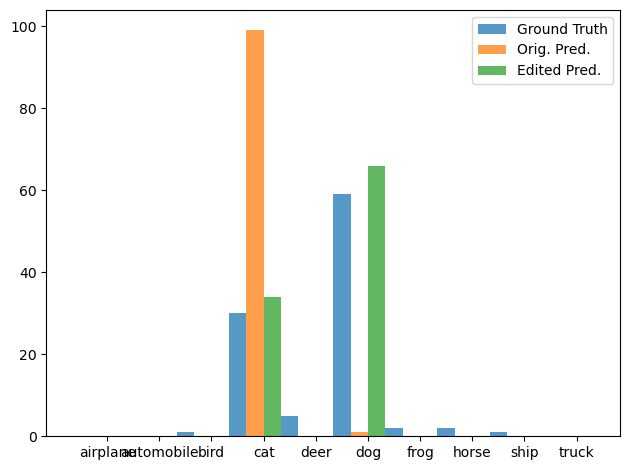

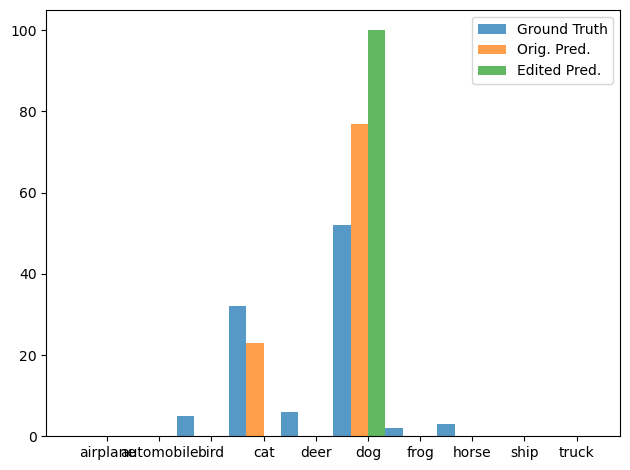

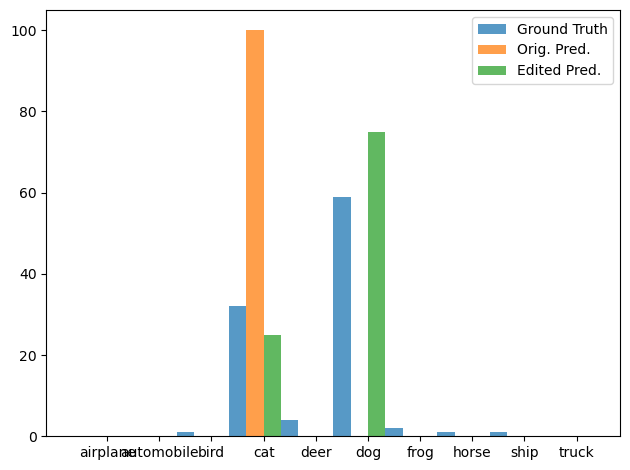

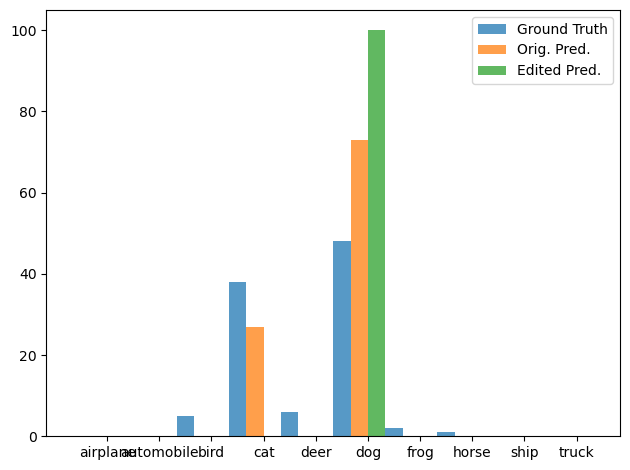

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/felzenszwalb_gaussian_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/felzenszwalb_gaussian_1/models
Finished trial 78/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/felzenszwalb_gaussian_1
(0113_180430) Starting Trial 79/2008...
Current run_id: 0113_160154/dog-train-n02086079_9352/felzenszwalb_gaussian_2
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/felzenszwalb_gaussian_2
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02086079_9352.png
Value images: saved/seg

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 30.54it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0046, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.07996125519275665 0.004564034286886454
L2 norm of weight change: 0.3147751986980438
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:17<00:00, 15.62it/s]


Post-edit metrics: {'TP': array([6023, 5615, 5684, 2743, 4240, 3356, 5640, 5066, 4790, 4288]), 'TN': array([60507, 60689, 56926, 61754, 60121, 61302, 60878, 61897, 61610,
       61761]), 'FPs': array([2493, 2311, 6074, 1246, 2879, 1698, 2122, 1103, 1390, 1239]), 'FNs': array([ 977, 1385, 1316, 4257, 2760, 3644, 1360, 1934, 2210, 2712]), 'accuracy': 0.6777857142857143, 'per_class_accuracy': array([0.95042857, 0.9472    , 0.89442857, 0.92138571, 0.91944286,
       0.92368571, 0.95025714, 0.95661429, 0.94857143, 0.94355714]), 'per_class_accuracy_mean': 0.9355571428571429, 'precision': array([0.70725693, 0.70842796, 0.48341555, 0.68764101, 0.59558927,
       0.66402849, 0.72661685, 0.82120279, 0.77508091, 0.77582775]), 'precision_mean': 0.6945087507107346, 'recall': array([0.86042857, 0.80214286, 0.812     , 0.39185714, 0.60571429,
       0.47942857, 0.80571429, 0.72371429, 0.68428571, 0.61257143]), 'recall_mean': 0.6777857142857142, 'f1': array([0.77635989, 0.7523784 , 0.60603476, 0.49922

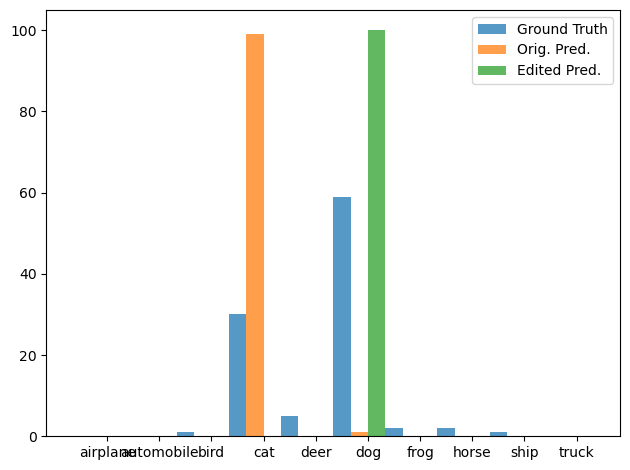

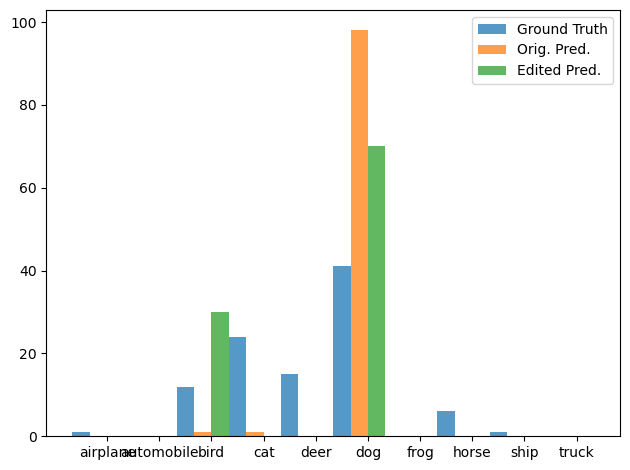

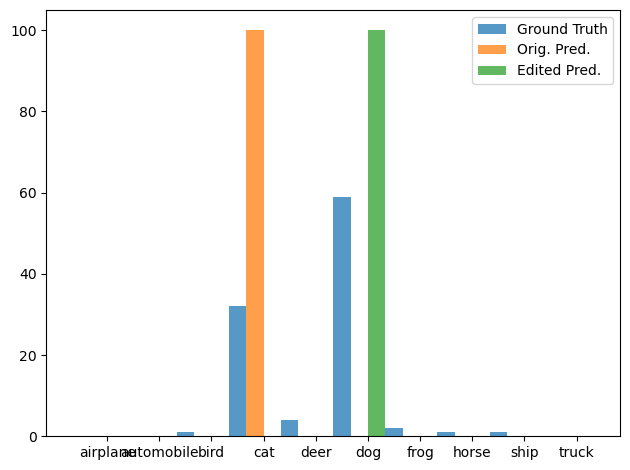

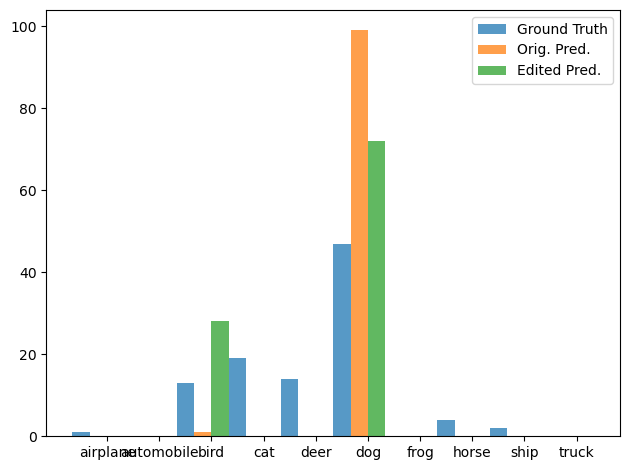

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/felzenszwalb_gaussian_2/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/felzenszwalb_gaussian_2/models
Finished trial 79/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/felzenszwalb_gaussian_2
(0113_180600) Starting Trial 80/2008...
Current run_id: 0113_160154/dog-train-n02086079_9352/felzenszwalb_gaussian_5
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/felzenszwalb_gaussian_5
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02086079_9352.png
Value images: saved/seg

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 31.77it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.02010810747742653 0.0030467829201370478
L2 norm of weight change: 0.1436164230108261
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 27.66it/s]


Post-edit metrics: {'TP': array([6084, 5459, 5212, 3684, 4273, 3215, 5654, 5153, 4868, 4598]), 'TN': array([60352, 60993, 59418, 60206, 60130, 61413, 61032, 61737, 61588,
       61331]), 'FPs': array([2648, 2007, 3582, 2794, 2870, 1587, 1968, 1263, 1412, 1669]), 'FNs': array([ 916, 1541, 1788, 3316, 2727, 3785, 1346, 1847, 2132, 2402]), 'accuracy': 0.6885714285714286, 'per_class_accuracy': array([0.94908571, 0.94931429, 0.92328571, 0.91271429, 0.92004286,
       0.92325714, 0.95265714, 0.95557143, 0.94937143, 0.94184286]), 'per_class_accuracy_mean': 0.9377142857142857, 'precision': array([0.6967476 , 0.73118136, 0.59267683, 0.56869404, 0.59820804,
       0.6695127 , 0.74180005, 0.80314838, 0.77515924, 0.73368438]), 'precision_mean': 0.6910812601580681, 'recall': array([0.86914286, 0.77985714, 0.74457143, 0.52628571, 0.61042857,
       0.45928571, 0.80771429, 0.73614286, 0.69542857, 0.65685714]), 'recall_mean': 0.6885714285714285, 'f1': array([0.77345538, 0.75473524, 0.65999747, 0.54666

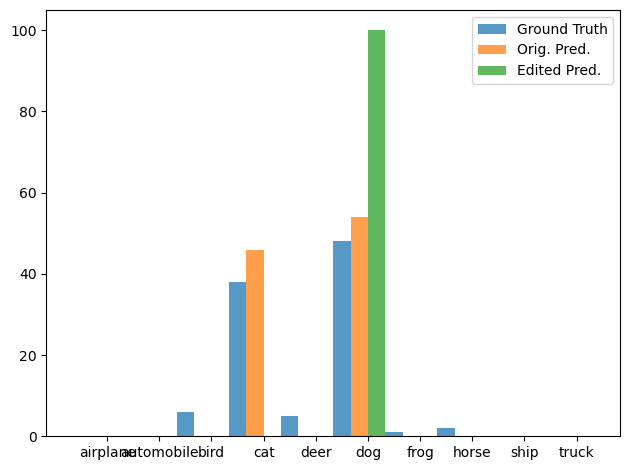

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/felzenszwalb_gaussian_5/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/felzenszwalb_gaussian_5/models
Finished trial 80/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/felzenszwalb_gaussian_5
(0113_180725) Starting Trial 81/2008...
Current run_id: 0113_160154/dog-train-n02086079_9352/felzenszwalb_masked_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/felzenszwalb_masked_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02086079_9352.png
Value images: saved/segment

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 34.04it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.04685785248875618 0.003968500066548586
L2 norm of weight change: 0.2526169717311859
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:15<00:00, 17.66it/s]


Post-edit metrics: {'TP': array([6039, 5563, 5015, 3497, 4324, 3611, 5690, 5160, 4962, 4521]), 'TN': array([60650, 60776, 60092, 60587, 60004, 60668, 60999, 61718, 61477,
       61411]), 'FPs': array([2350, 2224, 2908, 2413, 2996, 2332, 2001, 1282, 1523, 1589]), 'FNs': array([ 961, 1437, 1985, 3503, 2676, 3389, 1310, 1840, 2038, 2479]), 'accuracy': 0.6911714285714285, 'per_class_accuracy': array([0.9527    , 0.9477    , 0.9301    , 0.91548571, 0.91897143,
       0.91827143, 0.9527    , 0.9554    , 0.94912857, 0.94188571]), 'per_class_accuracy_mean': 0.9382342857142858, 'precision': array([0.71987126, 0.71439579, 0.63296731, 0.59170897, 0.59071038,
       0.60760559, 0.73982577, 0.80099348, 0.76515035, 0.73993453]), 'precision_mean': 0.6903163426138685, 'recall': array([0.86271429, 0.79471429, 0.71642857, 0.49957143, 0.61771429,
       0.51585714, 0.81285714, 0.73714286, 0.70885714, 0.64585714]), 'recall_mean': 0.6911714285714285, 'f1': array([0.78484632, 0.75241766, 0.67211687, 0.54175

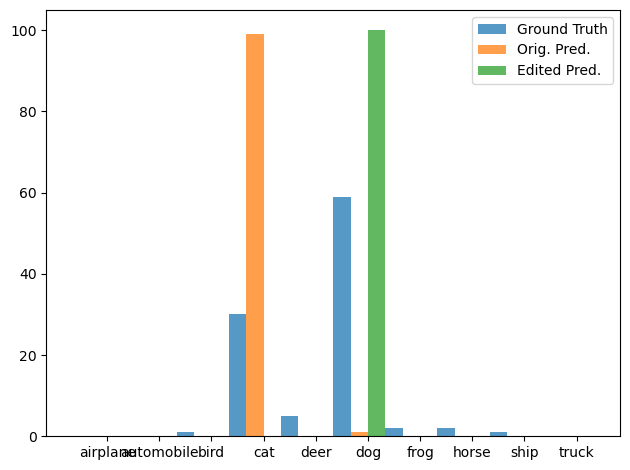

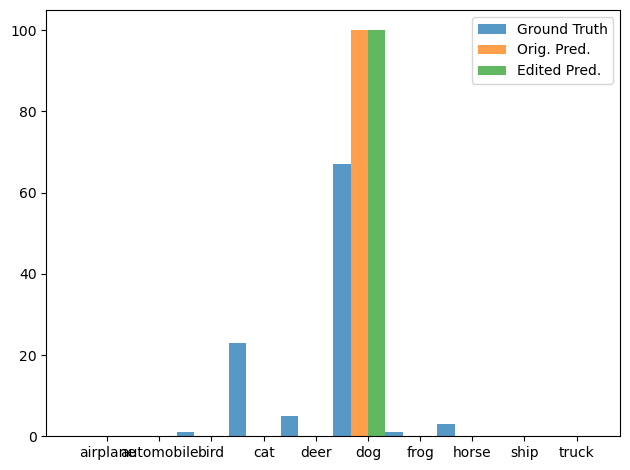

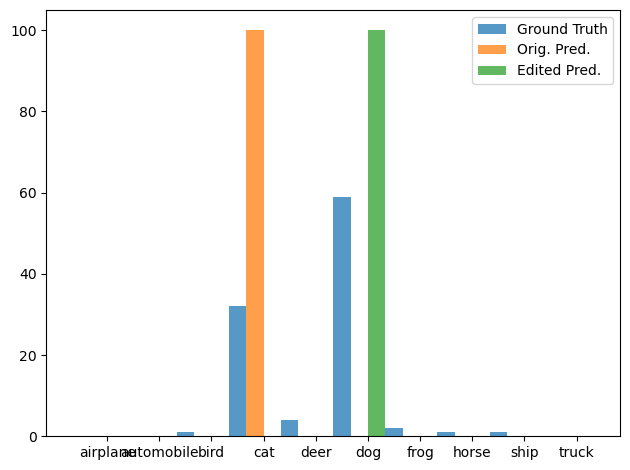

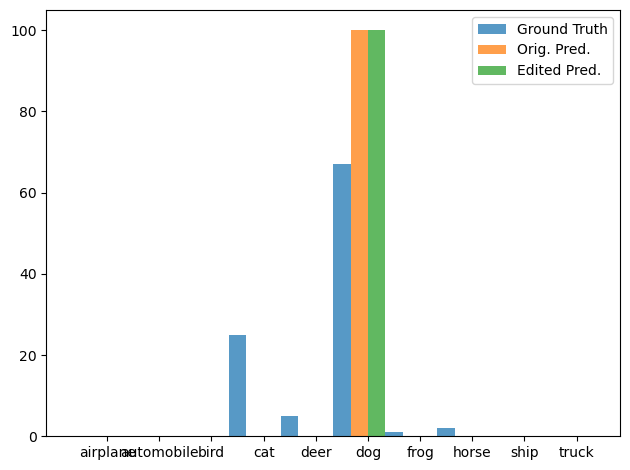

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/felzenszwalb_masked_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/felzenszwalb_masked_1/models
Finished trial 81/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/felzenszwalb_masked_1
(0113_180855) Starting Trial 82/2008...
Current run_id: 0113_160154/dog-train-n02086079_9352/felzenszwalb_masked_4
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/felzenszwalb_masked_4
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02086079_9352.png
Value images: saved/segmentations

100%|██████████████████████████████████████████| 274/274 [00:13<00:00, 20.93it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0077, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.10969323664903641 0.007660187780857086
L2 norm of weight change: 0.45934802293777466
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 27.76it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:202: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([5989, 5855, 5608,    0, 4227, 4038, 5649, 5145, 4810, 4022]), 'TN': array([60632, 59880, 57428, 62998, 60182, 57975, 60921, 61774, 61555,
       61998]), 'FPs': array([2368, 3120, 5572,    2, 2818, 5025, 2079, 1226, 1445, 1002]), 'FNs': array([1011, 1145, 1392, 7000, 2773, 2962, 1351, 1855, 2190, 2978]), 'accuracy': 0.6477571428571428, 'per_class_accuracy': array([0.95172857, 0.93907143, 0.90051429, 0.89997143, 0.92012857,
       0.8859    , 0.951     , 0.95598571, 0.94807143, 0.94314286]), 'per_class_accuracy_mean': 0.9295514285714287, 'precision': array([0.71664473, 0.65236769, 0.50161002, 0.        , 0.6       ,
       0.44554783, 0.73097826, 0.80756553, 0.76898481, 0.80055732]), 'precision_mean': 0.6024256195899234, 'recall': array([0.85557143, 0.83642857, 0.80114286, 0.        , 0.60385714,
       0.57685714, 0.807     , 0.735     , 0.68714286, 0.57457143]), 'recall_mean': 0.6477571428571428, 'f1': array([0.77997005, 0.73302034, 0.61694169, 0.     

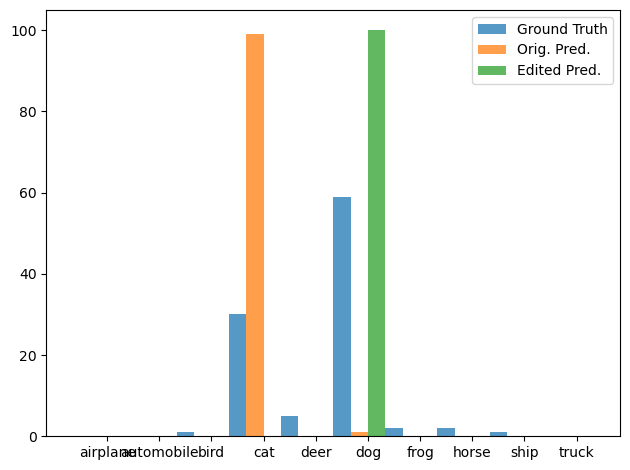

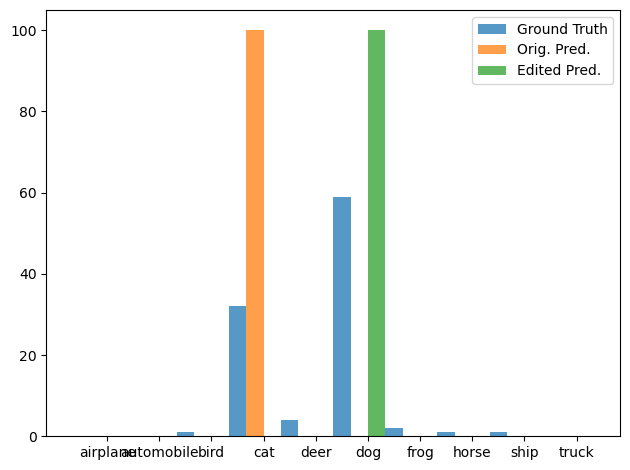

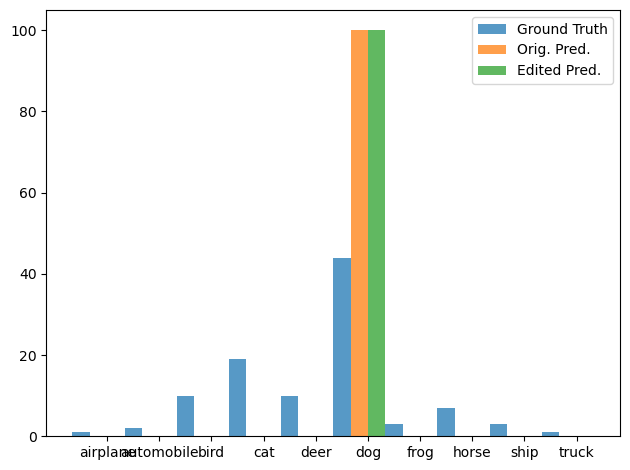

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/felzenszwalb_masked_4/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/felzenszwalb_masked_4/models
Finished trial 82/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/felzenszwalb_masked_4
(0113_181026) Starting Trial 83/2008...
Current run_id: 0113_160154/dog-train-n02086079_9352/quickshift_gaussian_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/quickshift_gaussian_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02086079_9352.png
Value images: saved/segmentations

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 34.15it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.02946695312857628 0.003549580927938223
L2 norm of weight change: 0.1785019487142563
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:15<00:00, 17.28it/s]


Post-edit metrics: {'TP': array([6079, 5472, 5152, 3681, 4304, 3346, 5643, 5146, 4921, 4576]), 'TN': array([60407, 60970, 59701, 60238, 60042, 61206, 61115, 61740, 61521,
       61380]), 'FPs': array([2593, 2030, 3299, 2762, 2958, 1794, 1885, 1260, 1479, 1620]), 'FNs': array([ 921, 1528, 1848, 3319, 2696, 3654, 1357, 1854, 2079, 2424]), 'accuracy': 0.6902857142857143, 'per_class_accuracy': array([0.9498    , 0.94917143, 0.92647143, 0.91312857, 0.91922857,
       0.92217143, 0.95368571, 0.95551429, 0.94917143, 0.94222857]), 'per_class_accuracy_mean': 0.9380571428571429, 'precision': array([0.7009917 , 0.72940549, 0.609632  , 0.57131771, 0.59267419,
       0.65097276, 0.74960149, 0.8033094 , 0.76890625, 0.73854099]), 'precision_mean': 0.6915351981132346, 'recall': array([0.86842857, 0.78171429, 0.736     , 0.52585714, 0.61485714,
       0.478     , 0.80614286, 0.73514286, 0.703     , 0.65371429]), 'recall_mean': 0.6902857142857144, 'f1': array([0.77577846, 0.75465453, 0.6668824 , 0.54764

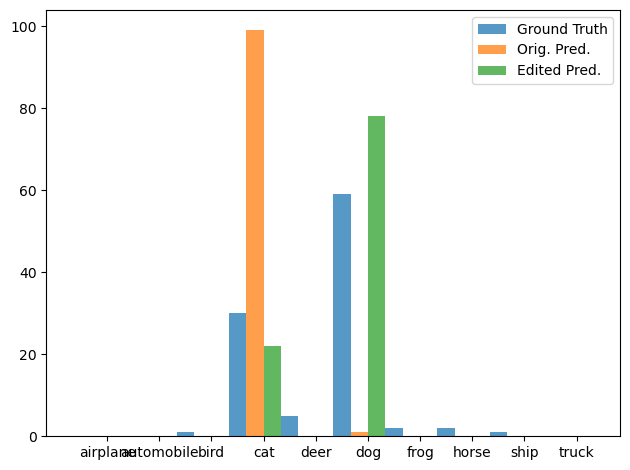

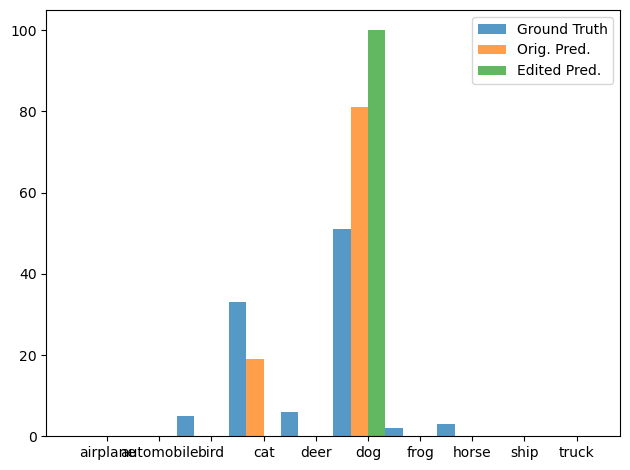

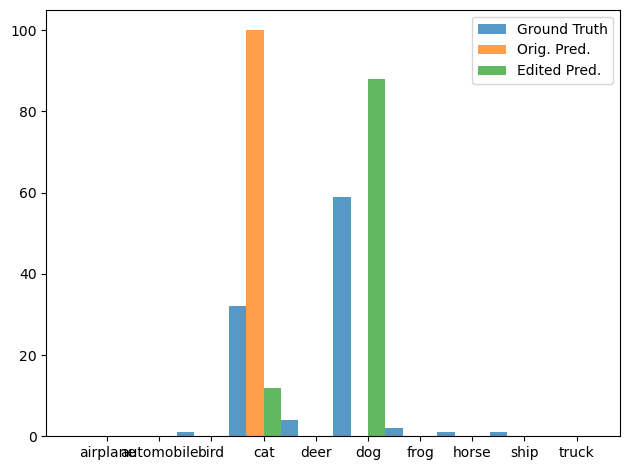

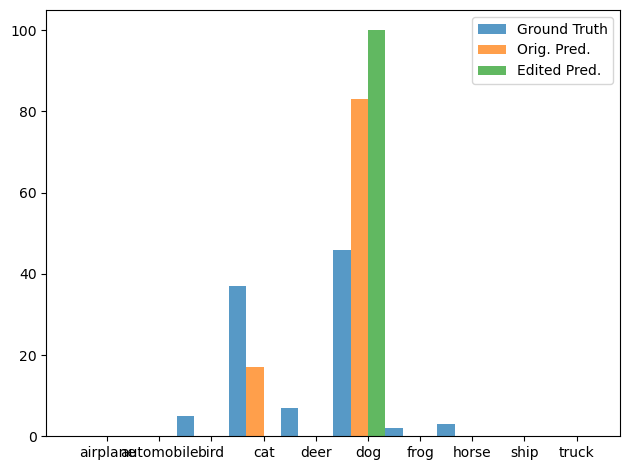

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/quickshift_gaussian_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/quickshift_gaussian_0/models
Finished trial 83/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/quickshift_gaussian_0
(0113_181156) Starting Trial 84/2008...
Current run_id: 0113_160154/dog-train-n02086079_9352/quickshift_gaussian_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/quickshift_gaussian_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02086079_9352.png
Value images: saved/segmentations

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 31.52it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.06437654793262482 0.003894764930009842
L2 norm of weight change: 0.2642957270145416
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:10<00:00, 26.26it/s]


Post-edit metrics: {'TP': array([6028, 5603, 5520, 2981, 4254, 3488, 5649, 5111, 4835, 4343]), 'TN': array([60513, 60700, 57984, 61425, 60133, 61030, 60978, 61800, 61568,
       61681]), 'FPs': array([2487, 2300, 5016, 1575, 2867, 1970, 2022, 1200, 1432, 1319]), 'FNs': array([ 972, 1397, 1480, 4019, 2746, 3512, 1351, 1889, 2165, 2657]), 'accuracy': 0.6830285714285714, 'per_class_accuracy': array([0.95058571, 0.94718571, 0.9072    , 0.92008571, 0.91981429,
       0.92168571, 0.95181429, 0.95587143, 0.94861429, 0.9432    ]), 'per_class_accuracy_mean': 0.9366057142857145, 'precision': array([0.70792719, 0.70897128, 0.523918  , 0.65430202, 0.59738801,
       0.63906193, 0.73640986, 0.80985581, 0.77150152, 0.76704345]), 'precision_mean': 0.6916379039596113, 'recall': array([0.86114286, 0.80042857, 0.78857143, 0.42585714, 0.60771429,
       0.49828571, 0.807     , 0.73014286, 0.69071429, 0.62042857]), 'recall_mean': 0.6830285714285714, 'f1': array([0.77705446, 0.75192914, 0.62956204, 0.51592

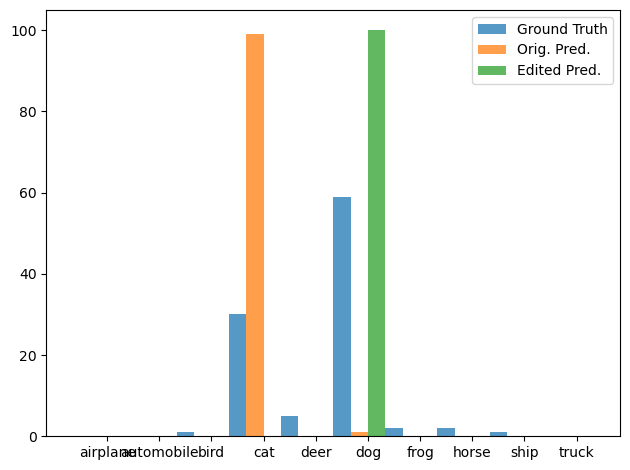

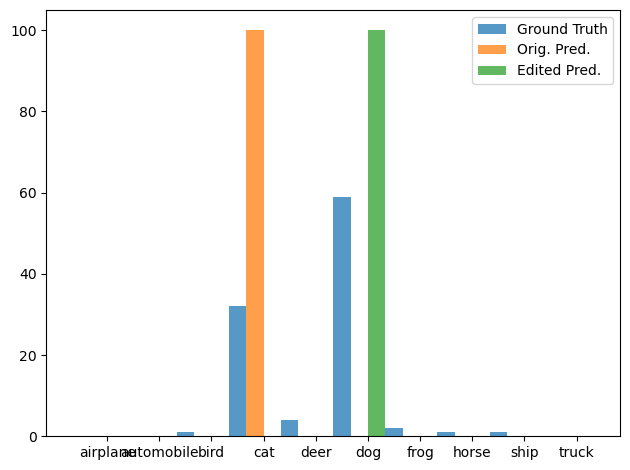

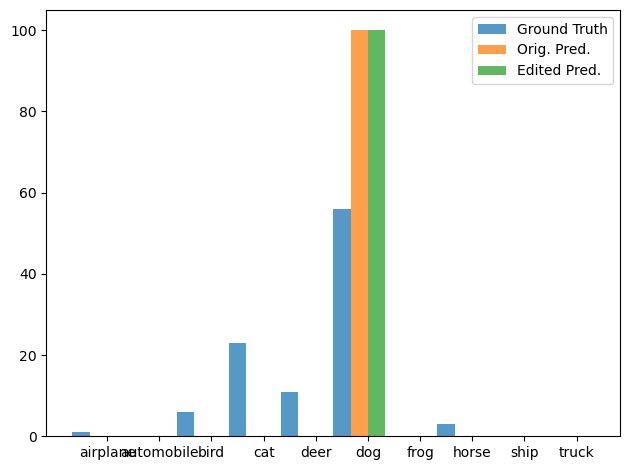

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/quickshift_gaussian_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/quickshift_gaussian_1/models
Finished trial 84/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/quickshift_gaussian_1
(0113_181326) Starting Trial 85/2008...
Current run_id: 0113_160154/dog-train-n02086079_9352/quickshift_masked_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/quickshift_masked_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02086079_9352.png
Value images: saved/segmentations/dog

100%|██████████████████████████████████████████| 274/274 [00:09<00:00, 30.37it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0056, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.0912616103887558 0.005606663413345814
L2 norm of weight change: 0.39292678236961365
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:10<00:00, 25.81it/s]


Post-edit metrics: {'TP': array([6019, 5762, 5516, 1133, 4302, 4200, 5559, 5153, 4846, 4106]), 'TN': array([60580, 60276, 58049, 62805, 60021, 58459, 61220, 61751, 61518,
       61917]), 'FPs': array([2420, 2724, 4951,  195, 2979, 4541, 1780, 1249, 1482, 1083]), 'FNs': array([ 981, 1238, 1484, 5867, 2698, 2800, 1441, 1847, 2154, 2894]), 'accuracy': 0.6656571428571428, 'per_class_accuracy': array([0.95141429, 0.9434    , 0.90807143, 0.9134    , 0.9189    ,
       0.89512857, 0.95398571, 0.95577143, 0.94805714, 0.94318571]), 'per_class_accuracy_mean': 0.9331314285714287, 'precision': array([0.71323617, 0.67900071, 0.52698959, 0.85316265, 0.5908529 ,
       0.48049422, 0.75746014, 0.80490472, 0.76580278, 0.79128927]), 'precision_mean': 0.6963193145594102, 'recall': array([0.85985714, 0.82314286, 0.788     , 0.16185714, 0.61457143,
       0.6       , 0.79414286, 0.73614286, 0.69228571, 0.58657143]), 'recall_mean': 0.6656571428571427, 'f1': array([0.77971371, 0.74415601, 0.631591  , 0.27209

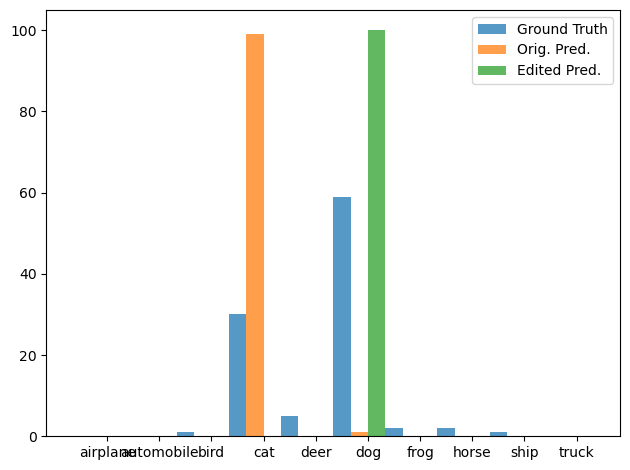

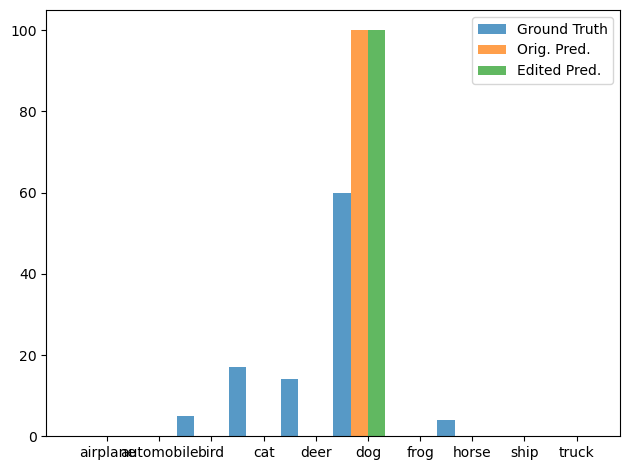

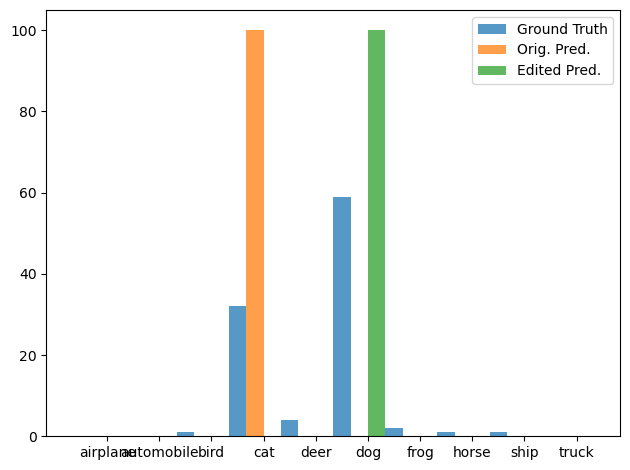

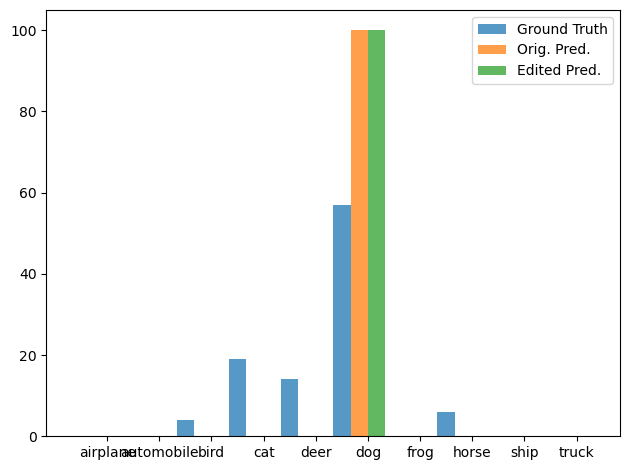

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/quickshift_masked_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/quickshift_masked_0/models
Finished trial 85/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/quickshift_masked_0
(0113_181456) Starting Trial 86/2008...
Current run_id: 0113_160154/dog-train-n02086079_9352/quickshift_masked_5
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/quickshift_masked_5
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02086079_9352.png
Value images: saved/segmentations/dog/dog-t

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 33.92it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0083, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.06870223581790924 0.008342405781149864
L2 norm of weight change: 0.26704466342926025
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:12<00:00, 22.43it/s]


Post-edit metrics: {'TP': array([6028, 5586, 5008, 3160, 4375, 3357, 5868, 5176, 4980, 4618]), 'TN': array([60654, 60570, 60082, 61183, 59878, 61224, 60420, 61659, 61408,
       61078]), 'FPs': array([2346, 2430, 2918, 1817, 3122, 1776, 2580, 1341, 1592, 1922]), 'FNs': array([ 972, 1414, 1992, 3840, 2625, 3643, 1132, 1824, 2020, 2382]), 'accuracy': 0.6879428571428572, 'per_class_accuracy': array([0.9526    , 0.94508571, 0.92985714, 0.91918571, 0.9179    ,
       0.92258571, 0.94697143, 0.95478571, 0.9484    , 0.93851429]), 'per_class_accuracy_mean': 0.9375885714285713, 'precision': array([0.71984715, 0.69685629, 0.63184456, 0.63492063, 0.58356676,
       0.65400351, 0.69460227, 0.79423047, 0.75776019, 0.70611621]), 'precision_mean': 0.6873748046821134, 'recall': array([0.86114286, 0.798     , 0.71542857, 0.45142857, 0.625     ,
       0.47957143, 0.83828571, 0.73942857, 0.71142857, 0.65971429]), 'recall_mean': 0.6879428571428571, 'f1': array([0.78418108, 0.74400639, 0.67104382, 0.52767

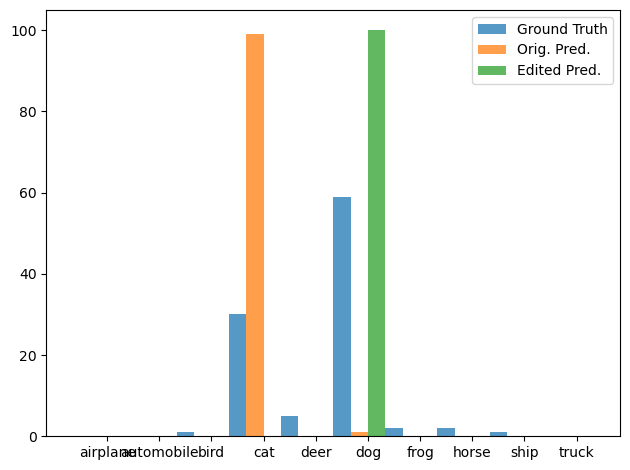

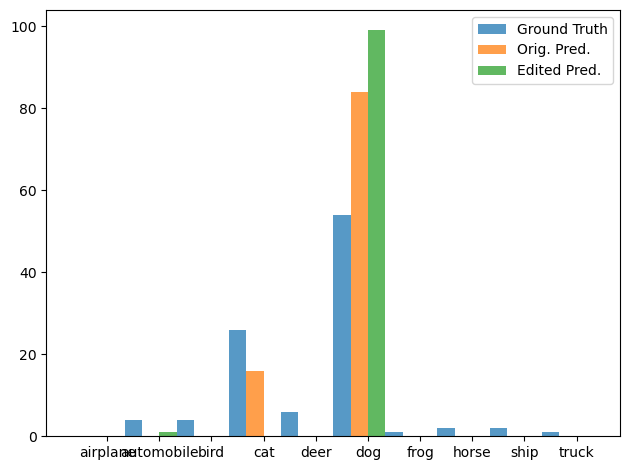

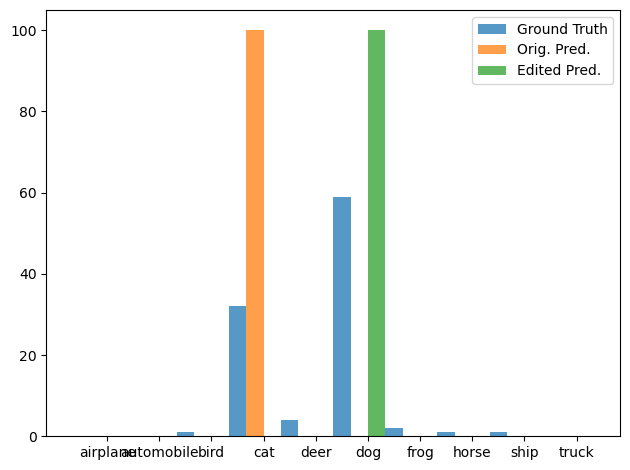

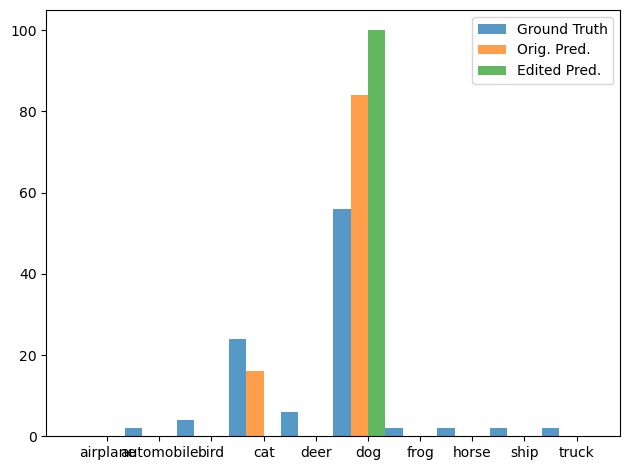

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/quickshift_masked_5/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/quickshift_masked_5/models
Finished trial 86/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/quickshift_masked_5
(0113_181626) Starting Trial 87/2008...
Current run_id: 0113_160154/dog-train-n02086079_9352/slic_gaussian_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/slic_gaussian_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02086079_9352.png
Value images: saved/segmentations/dog/dog-train-n02

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 31.81it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:


Loss (orig, final): 0.03310900926589966 0.0036465623416006565
L2 norm of weight change: 0.1874493509531021
Performing post-edit metric & KNN calculations on validation set.


100%|██████████████████████████████████████████| 274/274 [00:10<00:00, 25.67it/s]


Post-edit metrics: {'TP': array([6065, 5503, 5172, 3583, 4291, 3414, 5668, 5147, 4910, 4542]), 'TN': array([60468, 60900, 59602, 60408, 60093, 61104, 61043, 61741, 61531,
       61405]), 'FPs': array([2532, 2100, 3398, 2592, 2907, 1896, 1957, 1259, 1469, 1595]), 'FNs': array([ 935, 1497, 1828, 3417, 2709, 3586, 1332, 1853, 2090, 2458]), 'accuracy': 0.6899285714285714, 'per_class_accuracy': array([0.95047143, 0.94861429, 0.92534286, 0.91415714, 0.91977143,
       0.92168571, 0.95301429, 0.95554286, 0.94915714, 0.9421    ]), 'per_class_accuracy_mean': 0.9379857142857142, 'precision': array([0.70547866, 0.72379324, 0.60350058, 0.58024291, 0.59613782,
       0.64293785, 0.74334426, 0.8034655 , 0.76971312, 0.74010103]), 'precision_mean': 0.6908714973560182, 'recall': array([0.86642857, 0.78614286, 0.73885714, 0.51185714, 0.613     ,
       0.48771429, 0.80971429, 0.73528571, 0.70142857, 0.64885714]), 'recall_mean': 0.6899285714285714, 'f1': array([0.77771366, 0.75368075, 0.66435453, 0.54390

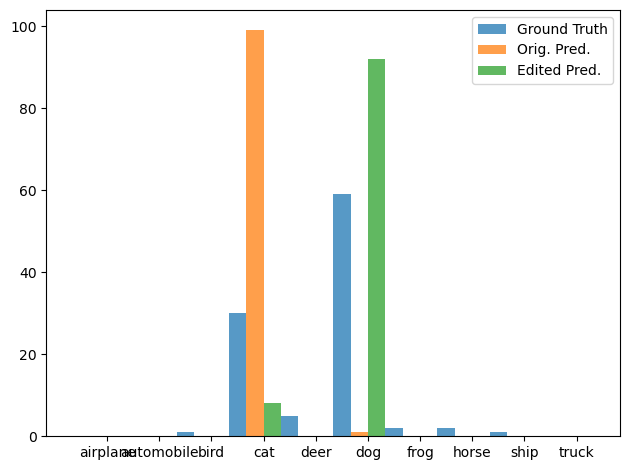

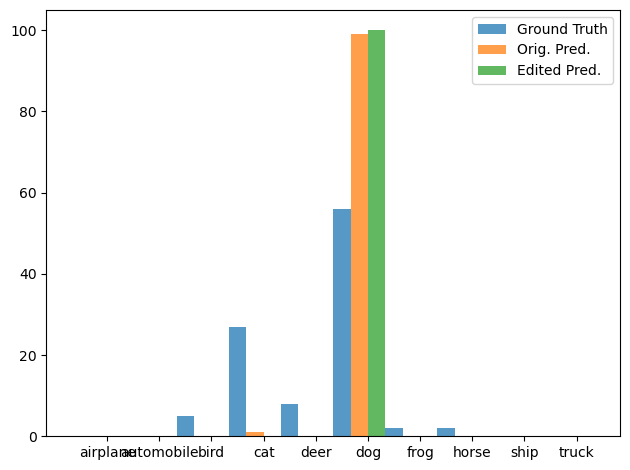

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/slic_gaussian_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/slic_gaussian_1/models
Finished trial 87/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/slic_gaussian_1
(0113_181755) Starting Trial 88/2008...
Current run_id: 0113_160154/dog-train-n02086079_9352/slic_gaussian_3
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/slic_gaussian_3
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02086079_9352.png
Value images: saved/segmentations/dog/dog-train-n02086079_9352/

100%|██████████████████████████████████████████| 274/274 [00:10<00:00, 26.96it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [01:

Loss (orig, final): 0.06354477256536484 0.004081716760993004
L2 norm of weight change: 0.25399941205978394
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [00:20<00:00, 13.38it/s]


Post-edit metrics: {'TP': array([6064, 5512, 5644, 3070, 4192, 3130, 5642, 5102, 4750, 4437]), 'TN': array([60332, 60881, 57169, 61273, 60255, 61652, 60924, 61808, 61677,
       61572]), 'FPs': array([2668, 2119, 5831, 1727, 2745, 1348, 2076, 1192, 1323, 1428]), 'FNs': array([ 936, 1488, 1356, 3930, 2808, 3870, 1358, 1898, 2250, 2563]), 'accuracy': 0.6791857142857143, 'per_class_accuracy': array([0.94851429, 0.94847143, 0.89732857, 0.91918571, 0.92067143,
       0.92545714, 0.95094286, 0.95585714, 0.94895714, 0.94298571]), 'per_class_accuracy_mean': 0.9358371428571427, 'precision': array([0.69445717, 0.72231687, 0.49185185, 0.63998332, 0.60429581,
       0.69897276, 0.7310184 , 0.81061328, 0.7821505 , 0.75652174]), 'precision_mean': 0.6932181692403894, 'recall': array([0.86628571, 0.78742857, 0.80628571, 0.43857143, 0.59885714,
       0.44714286, 0.806     , 0.72885714, 0.67857143, 0.63385714]), 'recall_mean': 0.6791857142857143, 'f1': array([0.77091279, 0.75346866, 0.61098782, 0.52047

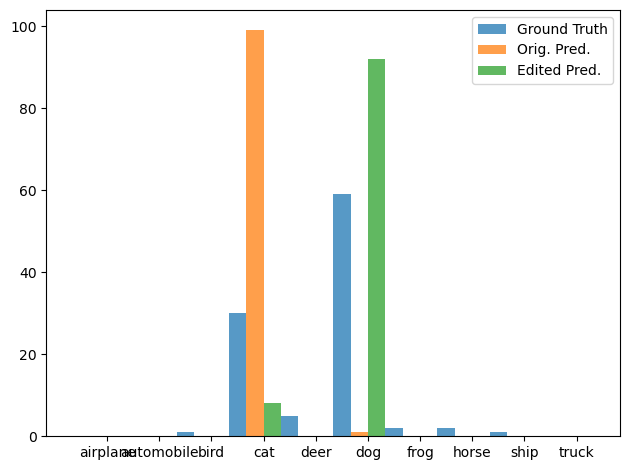

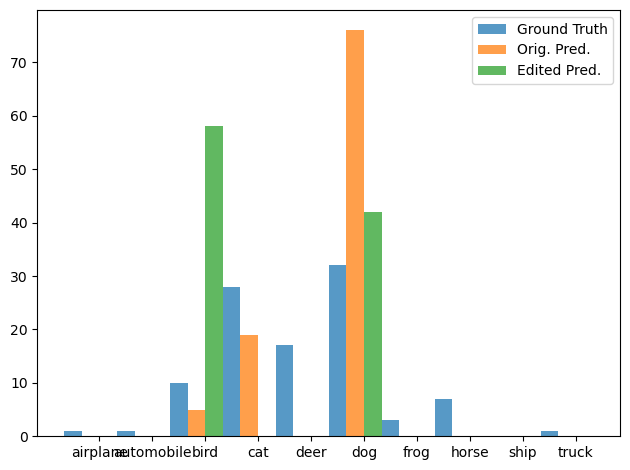

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/slic_gaussian_3/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/slic_gaussian_3/models
Finished trial 88/2008. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/slic_gaussian_3
(0113_181937) Starting Trial 89/2008...
Current run_id: 0113_160154/dog-train-n02086079_9352/slic_gaussian_5
saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/dog-train-n02086079_9352/slic_gaussian_5
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02086079_9352.png
Value images: saved/segmentations/dog/dog-train-n02086079_9352/

100%|██████████████████████████████████████████| 274/274 [00:08<00:00, 32.26it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>):  94%|▉| 37770/40000 [00:

In [ ]:
for idx, (key_path, value_path) in enumerate(zip(key_image_paths, value_image_paths)):
    split = os.path.basename(os.path.dirname(os.path.dirname(key_path)))
    class_name = os.path.basename(os.path.dirname(key_path))
    file_name = os.path.basename(key_path).split(".")[0]
    key_image_id = "{}-{}-{}".format(class_name, split, file_name)
    # Print Progress
    informal_log("({}) Starting Trial {}/{}...".format(datetime.now().strftime(r'%m%d_%H%M%S'), idx + 1, n_trials), progress_report_path)
    
    # Create run id 
    value_image_id = os.path.splitext(os.path.basename(value_path))[0]
    run_id = os.path.join(timestamp, key_image_id, value_image_id)
    informal_log("Current run_id: {}".format(run_id), progress_report_path)
    
    # Read config file as json and make updates to key and value paths
    config_dict = read_json(config_path)
    config_dict['editor'].update({
        'key_paths_file': key_path,
        'value_paths_file': value_path
    })
    
    # Create config object
    config = ConfigParser(config_dict, run_id=run_id)
    
    # Log the current trial path
    informal_log(os.path.dirname(config.save_dir), save_trials_path)
    
    informal_log("Calling edit()...", progress_report_path)
    
    edit(
        config=config,
        val_paths_data_loader=val_paths_data_loader,
        covariance_data_loader=covariance_data_loader,
        do_analyze_knn=analyze_in_edit)
    
    # Print progress
    informal_log("Finished trial {}/{}. Results saved to {}".format(idx + 1, n_trials, os.path.dirname(config.save_dir)),
                progress_report_path)


In [21]:
save_trials_path = 'saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/trial_paths.txt'
trial_dirs = read_lists(save_trials_path)
knn_analysis_filename = 'knn_analysis_results.pth'

In [22]:
try:
    if not os.path.exists(save_trials_path):
        print("Path {} does not exist".format(save_trials_path))
    else:
        print("Obtaining trial paths from {}".format(save_trials_path))
except:
    print("Need to define save_trials_path.")



Obtaining trial paths from saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/trial_paths.txt


## Analyze KNN

In [23]:
## Process KNN results for each
n_trials = len(trial_dirs)
n_log = n_trials // 10 + 1  # log every 10%
progress_report_path = os.path.join(os.path.dirname(save_trials_path), 'progress_report_analysis.txt')

informal_log("Starting KNN analysis...", progress_report_path)
for trial_idx, trial_dir in tqdm(enumerate(trial_dirs)):
    # if trial_idx % n_log == 0:
    informal_log("Processing {}/{} trials. Currently processing {}".format(
        trial_idx+1, n_trials, os.path.basename(trial_dir)), progress_report_path)
                     
    results_save_dir = os.path.join(trial_dir, 'models')
    load_and_analyze_knn(
        restore_dir=results_save_dir,
        pre_edit_knn_path=os.path.join(results_save_dir, 'pre_edit_{}-nn.pth'.format(K)),
        post_edit_knn_path=os.path.join(results_save_dir, 'post_edit_{}-nn.pth'.format(K)),
        knn_analysis_filename=knn_analysis_filename,
        target_class_idx=target_class_idx,
        class_list=class_list,
        progress_report_path=progress_report_path,
        save_images=False,
        save_plots=True)
    


Starting KNN analysis...


0it [00:00, ?it/s]

Processing 1/37 trials. Currently processing felzenszwalb_gaussian_0
Analyzing KNN results from saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/felzenszwalb_gaussian_0/models
Logging and saving visualizations to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/felzenszwalb_gaussian_0/models/knn_visualizations/knn_analysis_log.txt
Saving results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/felzenszwalb_gaussian_0/models/knn_analysis_results.pth


0it [00:00, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/felzenszwalb_gaussian_0/models/edited_model.pth'

## Convert to CSV for all trials

In [24]:
data = []
# Iterate through all trials
for trial_idx, trial_dir in tqdm(enumerate(trial_dirs)):
    # Obtain key ID from path
    key_id = os.path.basename(os.path.dirname(trial_dir))
    id_class = key_id.split('-')[0]
    if id_class not in class_list:
        raise ValueError("Invalid key_id {}".format(key_id))
    # Obtain value ID from path
    val_id = os.path.basename(trial_dir)
    # Join to make a data ID
    data_id = os.path.join(key_id, val_id)
    
    # Load results from knn, pre-edit metrics, and post-edit metrics
    restore_dir = os.path.join(trial_dir, 'models')
    knn_analysis_results = torch.load(os.path.join(restore_dir, knn_analysis_filename))
    pre_edit_metrics = torch.load(os.path.join(restore_dir, 'pre_edit_metrics.pth'))
    post_edit_metrics = torch.load(os.path.join(restore_dir, 'post_edit_metrics.pth'))
    
    # Combine results into one dictionary
    combined_results = combine_results(
        data_id=data_id,
        knn_analysis=knn_analysis_results,
        pre_edit_metrics=pre_edit_metrics,
        post_edit_metrics=post_edit_metrics)
    
    # Save column headers in first trial run
    if trial_idx == 0:
        column_headers = list(combined_results.keys())
    # Convert results to np.array & append to list
    combined_results = np.expand_dims(np.array(list(combined_results.values())), axis=0)
    data.append(combined_results)

# Convert data from list of np.arrays -> pd.DataFrame    
data = np.concatenate(data, axis=0)
df = pd.DataFrame(data, columns=column_headers)


37it [00:01, 23.99it/s]


In [25]:
# Save to CSV
csv_save_path = os.path.join(os.path.dirname(save_trials_path), 'results_table.csv')
df.to_csv(csv_save_path)
print("Saved CSV to {}".format(csv_save_path))

Saved CSV to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/results_table.csv
